# IMPORT

In [1]:
#!pip install pandas-profiling[notebook]
#!pip install optuna
#!pip install dostoevsky
#!pip install pymorphy2

In [2]:
#!pip install lightautoml -q

In [334]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm, tqdm_notebook


from sklearn.preprocessing import LabelEncoder

# Сброс ограничений на количество выводимых рядов
pd.set_option('display.max_rows', 100)
 
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', 200)

###
import datetime 
from pandas_profiling import ProfileReport # для EDA
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.float_format ='{:,.3f}'.format

import re
import json
# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()

import optuna

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor, Pool
import xgboost as xgb

#!pip install -U gensim
#nltk.download('punkt')
import pymorphy2


#!python -m dostoevsky download fasttext-social-network-model # это набор аннотированных данных собранный из социальной сети ВКонтакте
from dostoevsky.tokenization import RegexTokenizer
from dostoevsky.models import FastTextSocialNetworkModel
#import joblib

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Max\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [98]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

Python       : 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
Numpy        : 1.20.3


# Functions

In [3]:
class Prerocessor():
    """Класс препроцессинга"""

    
    def __init__(self):
        #from sklearn.preprocessing import LabelEncoder
        from sklearn.preprocessing import StandardScaler, MinMaxScaler
        from scipy.stats.mstats import winsorize
        from tqdm import tqdm, tqdm_notebook
        from copy import deepcopy
        
        self.dict_of_encoders = dict()
        self.cat_features = list()
        self.num_features = list()
        self.dict_methods = dict({"std": StandardScaler,"minmax":MinMaxScaler, "label": LabelEncoderPro, None:None})
        pass
    
    """
    Работа с любыми признаками
    """
    
    def fit_Encoder(self, method, Serie, column):
        E = self.dict_methods[method]()
        E.fit(Serie)
        self.dict_of_encoders[column] = E
    
    def fit(self, df:pd.DataFrame, features, method):
        """Обучение кодировщика"""
        if type(features) ==str:
            features = [features]
        for colum in features:
            self.fit_Encoder(method, df[colum], colum)
                
    def transform(self, df:pd.DataFrame, features):
        for colum in features:
            df[colum] = self.dict_of_encoders[colum].transform(df[colum])
        return df
    
    def fit_transform_Encoder(self, Serie, method, column):
        """Функция нижнего уровня, выполняет преобразование и записывает енкодер"""
        if method == None:
            return Serie
        if method not in self.dict_methods:
            Serie.map(method)
        if method != "label":
            Serie = np.array(Serie).reshape(len(Serie),1)
            
        E = self.dict_methods[method]()
        E.fit_transform(Serie)
        self.dict_of_encoders[column] = E
        return E.fit_transform(Serie)
    

    def fit_transform_Serie(self, Serie, method, depth=None, 
                            q1=None, q2=None, cut_outliers=False, name_of_feature = None):
        """Функция среднего уровня, работает с серией из датафрейма"""
        if depth:
            if 0<depth<1:
                VC = Serie.value_counts(dropna=False, normalize=True).reset_index()
                try:
                    VC = VC[VC[Serie.name] > depth]["index"]
                except:
                    VC = VC[VC[0] > depth]["index"]
                return self.fit_transform_Encoder(Serie.apply(lambda x: x if (x in set(VC)) or 
                                                              (pd.isnull(x)) else "N/A"),
                                    method,  name_of_feature)
            else:
                VC = Serie.value_counts(dropna=False).reset_index()[:int(depth)]["index"]
                return self.fit_transform_Encoder(Serie.apply(lambda x: x if (x in set(VC)) or 
                                                      (pd.isnull(x)) else "N/A"), method,  name_of_feature)
        if q1 or q2:
            if cut_outliers:
                Serie = self.outliers_mask(Serie, q1, q2)
            else:
                Serie = winsorize(Serie, limits=[q1, q2], nan_policy="omit").data
            return self.fit_transform_Encoder(Serie, method, name_of_feature)
        if cut_outliers:
            Serie = self.outliers_mask(Serie, 0.001, 0.999)
        #print(self.fit_transform_Encoder(method, Serie, name_of_feature))
        return self.fit_transform_Encoder(Serie, method, name_of_feature)
    
    def fit_transform(self, df:pd.DataFrame, features, method, depth=None, 
                      q1=None, q2=None, cut_outliers=False, inplace=False):
        """Функция верхнего уровня, работает с датафреймом"""
        if type(features) ==str:
            features = [features]
        res = df.copy()
        for colum in tqdm_notebook(features):
            res[colum] = self.fit_transform_Serie(df[colum], method,depth, q1, q2, cut_outliers, colum)
            if inplace:
                df[colum] = res[colum]
        return res
    
        
    
    
    def outliers_mask(self, Serie, q1, q2):
        if q1==None:
            q1=0
        if q2 == None:
            q2=1
        Serie.loc[Serie.between(Serie.quantile(q1), Serie.quantile(q2))==False] = None
        return Serie

    
    def inverse_transform(self, df:pd.DataFrame, columns=None):
        res = pd.DataFrame()
        
        if not columns:
            columns = df.columns
            
        if type(columns) == str:
            columns = list(columns)
        for col in tqdm_notebook(columns):
            if col not in df.columns:
                print(col, " не найден")
                continue
            if col in self.dict_of_encoders.keys():
                try:
                    res[col] = self.dict_of_encoders[col].inverse_transform(df[col])
                except:
                    res[col] = self.dict_of_encoders[col].inverse_transform(np.array(df[col]).reshape(len(df[col]) ,1))
            else:
                res[col] = df[col]

        return res

    
    def inverse_transform_Serie(self, Serie, name_of_feature = None):
        if name_of_feature:
            res = self.dict_of_encoders[name_of_feature].inverse_transform(Serie)
        else:
            res = self.dict_of_encoders[Serie.name].inverse_transform(Serie)
        return res
            

            
    def transform_by_group(self, df:pd.DataFrame, group_features, agg_func, column, log, multiplier=1):
        """Функция для квантилизации"""
        GB = df.groupby(group_features)[column].agg(agg_func).reset_index()
        if log:
            GB[column] = np.log(GB[column]+1)
        GB[column+"_cut"] = pd.qcut(GB[column], q= int((GB[column].max() - GB[column].min())*multiplier))
        LE = LabelEncoder()
        GB[column+"_cut"] = LE.fit_transform(GB[column+"_cut"])
        self.dict_of_encoders[column+"_cut"]  = LE
        res = pd.merge(df, GB.drop(column, axis=1), on=group_features, how="left")
        return res
    
    def fillna_by_group(self, df, group_features, target_feature):
        """Справляется в случаях, когда более одной групповой переменной"""
        df.groupby(group_features, sort=False)[target_feature].apply(lambda x: x.fillna(x.median()))


    
    # Не моя функция, не проработана
    def undummify(df, prefix_sep="_"):
        cols2collapse = {
            item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
        }
        series_list = []
        for col, needs_to_collapse in cols2collapse.items():
            if needs_to_collapse:
                undummified = (
                    df.filter(like=col)
                    .idxmax(axis=1)
                    .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                    .rename(col)
                )
                series_list.append(undummified)
            else:
                series_list.append(df[col])
        undummified_df = pd.concat(series_list, axis=1)
        return undummified_df
    
        
    """
    Работа с численными признаками
    """

    ##винсоризация
    def robust_cut(s,a=0,b=1):
        return s.apply(lambda x:a if x<a else b if x>b else x)
    
    ##винсоризация по квантилям, но не предусмотрена отрезка выбросов в None
    def quant_cut(s, q1=0.01, q2=0.99):
        return robust_cut(s, s.quantile(q1), s.quantile(q2))
    
class LabelEncoderPro():
    """Энкодер из scikit зависал при применении его в цикле, пришлось писать свой"""
    def __init__(self):
        self.map_level_dict = dict()
        self.classes_ = []
        pass
    
    def fit(self, Serie):
        self.map_level_dict = {i:j for j, i in dict(enumerate(Serie.astype('category').cat.categories)).items()}
        self.classes_ = self.map_level_dict.keys()
        
    def fit_transform(self, Serie):
        self.map_level_dict = {i:j for j, i in dict(enumerate(Serie.astype('category').cat.categories)).items()}
        self.classes_ = self.map_level_dict.keys()
        Serie = Serie.map(self.map_level_dict).fillna(-1).astype('int')
        return Serie
        
    def inverse_transform(self, Serie):
        inv_dict = {v:k for k, v in self.map_level_dict.items()}
        Serie = Serie.map(inv_dict).replace(-1, None)
        return Serie
                        

In [5]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

def mape_exp(y_true, y_pred):
    y_test = np.exp(y_true)
    y_pred_ = np.exp(y_pred)
    return np.mean(np.abs((y_pred_-y_test)/y_test))


def ParseDateTest(x):
    if str(x) == "nan":
        return None
    x_spl = x.split()
    year = 0
    month = 0
    
    nums = []
    if re.findall(r"\d+", x):
        nums = re.findall(r"\d+", x)
        #print(nums)
    
    if  re.findall(r"год", x) or re.findall(r"лет", x):
        year = nums[0]
        #print(nums[0])
    if  re.findall(r"мес", x):
        month = nums[-1]
        #print(nums[-1])

    #for s in x_spl:
    #    if re.findall(r"\d", x):
    #        print(re.findall(r"\d", x))
        
    return datetime.timedelta(365 * int(year) + 30 * int(month))

def GetEngineDisplacement(x):
    row = str(x)
    engine = re.findall('\d\.\d', row)
    if engine == []:
        return None
    return float(engine[0])

def getbody(x, set_body:set):
    body = str(x).lower()
    if body in set_body:
        return body
    else:
        for b in set_body:
            if b in body:
                return b
    return body
    


# Прогнозирование стоимости автомобиля по характеристикам

Помним, что по условию соревнования, нам нужно самостоятельно собрать обучающий датасет. В этом ноутбуке мы не будем рассматривать сбор данных. Предположим, что мы уже все собрали и просто подключили свой датасет через "Add Data", чтобы приступить к самому ML.

# Setup

In [441]:
DIR_TRAIN  = ""#'../input/parsing-all-moscow-auto-ru-09-09-2020/' # подключил к ноутбуку внешний датасет
DIR_TEST   = ""#'../input/sf-dst-car-price-prediction/'
VAL_SIZE   = 0.20   # 20%

In [442]:
train = pd.read_csv(DIR_TRAIN+'all_auto_ru_09_09_2020.csv') # датасет для обучения модели
test = pd.read_csv(DIR_TEST+'test.csv')
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

# EDA

Начнём с ускоренного анализа при помощи Pandas Profiling

In [75]:
profile_train = ProfileReport(train, title="Pandas Profiling Report for train")
profile_test = ProfileReport(test, title="Pandas Profiling Report for test")

In [76]:
#profile_train.to_file("profile_train.html")
#profile_test.to_file("profile_test.html")

In [77]:
# Показать профайлинг внутри ноутбука
#profile_train
#profile_test

Чтобы не загромождать ноутбук, сохраним результаты профайлинга в HTML формате и откроем в браузере.

## Значения в колонках

In [78]:
for col in train.columns:
    display(train[col].value_counts(dropna=False).reset_index()[:10])

index  bodyType
0  Внедорожник 5 дв.     31885
1              Седан     30593
2      Хэтчбек 5 дв.      8668
3    Универсал 5 дв.      3385
4            Лифтбек      3121
5         Компактвэн      1922
6            Минивэн      1815
7      Хэтчбек 3 дв.      1377
8               Купе      1289
9         Седан Long      1104

index  brand
0    MERCEDES   8012
1         BMW   7393
2  VOLKSWAGEN   7139
3      NISSAN   5772
4     HYUNDAI   5734
5         KIA   5630
6      TOYOTA   4824
7        FORD   4797
8        AUDI   4084
9  MITSUBISHI   3933

index  color
0  040001  25212
1  FAFBFB  15824
2  CACECB  11336
3  97948F  10819
4  0000CC   8874
5  EE1D19   4508
6  200204   3583
7  007F00   2598
8  C49648   1854
9  22A0F8   1398

index  fuelType
0     бензин     75053
1     дизель     13907
2     гибрид       295
3    электро       111
4        газ        11
5  универсал         1

index  modelDate
0 2,006.000       6138
1 2,010.000       5905
2 2,009.000       5703
3 2,017.000       5636
4 2,018.000       5205
5 2,011.000       4758
6 2,005.000       4715
7 2,012.000       4507
8 2,007.000       4147
9 2,008.000       4072

index  name
0      2.0 AT (150 л.с.)  1610
1      1.6 AT (123 л.с.)  1386
2      1.6 AT (110 л.с.)  1200
3      1.6 MT (105 л.с.)   888
4       1.4 MT (75 л.с.)   783
5  2.0 AT (150 л.с.) 4WD   716
6      1.6 MT (109 л.с.)   714
7   1.7 MT (80 л.с.) 4WD   679
8      1.6 MT (110 л.с.)   677
9      1.6 AT (120 л.с.)   637

index  numberOfDoors
0  5.000          51625
1  4.000          33647
2  3.000           2211
3  2.000           1893
4    NaN              1
5  0.000              1

index  productionDate
0   2020           12524
1   2008            7043
2   2012            6630
3   2011            6192
4   2013            5601
5   2007            5428
6   2014            4555
7   2010            4474
8   2006            3622
9   2015            3145

index  vehicleConfiguration
0              SEDAN MECHANICAL 1.6                  4166
1               SEDAN AUTOMATIC 1.6                  3633
2      ALLROAD_5_DOORS VARIATOR 2.0                  3098
3     ALLROAD_5_DOORS AUTOMATIC 2.0                  2795
4               SEDAN AUTOMATIC 2.0                  2230
5   HATCHBACK_5_DOORS AUTOMATIC 1.6                  1820
6  HATCHBACK_5_DOORS MECHANICAL 1.6                  1510
7              SEDAN MECHANICAL 1.5                  1374
8              SEDAN MECHANICAL 1.8                  1243
9              SEDAN MECHANICAL 1.4                  1227

index  vehicleTransmission
0   AUTOMATIC                49218
1  MECHANICAL                25264
2       ROBOT                 7871
3    VARIATOR                 7024
4         NaN                    1

index  engineDisplacement
0   1.6               17032
1   2.0               13446
2   1.4                5649
3   1.8                5102
4   2.4                3272
5   2.5                2887
6   1.5                2145
7  2.0d                2092
8   200                1519
9   350                1506

index  enginePower
0 150.000         7058
1 249.000         3721
2 140.000         2898
3 105.000         2360
4 123.000         2302
5 110.000         2093
6 190.000         2087
7 115.000         1835
8 184.000         1638
9 109.000         1526

index  description
0                                                NaN         3254
1  РОЛЬФ Северо-Запад - это первый мегамолл автом...          246
2  ПРИГЛАШАЕМ на бесплатный тест-драйв!\nПРИ ПОКУ...          157
3  Автодилер года 2020\n\nПобедитель в номинации ...          131
4  УНИКАЛЬНОЕ ПРЕДЛОЖЕНИЕ НА  ВСЕ АВТОМОБИЛИ!!!  ...          114
5  Выгода до 82 000 руб. при обмене на Ваш автомо...          114
6  При покупке автомобиля до 15 сентября \n► Выго...          102
7  РОЛЬФ Северо-Запад - это первый мегамолл автом...           99
8  КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...           97
9  РОЛЬФ - Официальный дилер и Лучший дилер Росси...           85

index  mileage
0       0    13588
1  200000     1136
2  150000     1048
3  180000      897
4  160000      860
5  170000      838
6  250000      834
7  120000      775
8  140000      741
9  130000      735

index  Комплектация
0                                        {'id': '0'}         59130
1  {'id': '21678548', 'name': 'Комфорт', 'availab...           257
2  {'id': '21397679', 'name': 'Intense+', 'availa...           224
3  {'id': '21426455', 'name': '450 4MATIC Sport P...           198
4  {'id': '21426444', 'name': '300 d 4MATIC Sport...           196
5  {'id': '22152659', 'name': 'Respect', 'availab...           191
6  {'id': '22174500', 'name': 'Inscription', 'ava...           162
7  {'id': '21436723', 'name': 'SE Top', 'availabl...           143
8  {'id': '21464201', 'name': 'E 200 Premium', 'a...           140
9  {'id': '21397672', 'name': 'Intense+', 'availa...           138

index  Привод
0  передний   47315
1    полный   35001
2    задний    7061
3       NaN       1

index   Руль
0   LEFT  87589
1  RIGHT   1789

index  Состояние
0    NaN      89378

index  Владельцы
0  3.000      36248
1  2.000      21006
2  1.000      18536
3    NaN      13588

index    ПТС
0   ORIGINAL  78597
1  DUPLICATE  10420
2        NaN    361

index  Таможня
0   True    89378

index  Владение
0                          NaN     60177
1  {'year': 2018, 'month': 10}       497
2   {'year': 2019, 'month': 8}       494
3   {'year': 2018, 'month': 8}       492
4   {'year': 2018, 'month': 9}       478
5  {'year': 2018, 'month': 11}       473
6  {'year': 2018, 'month': 12}       469
7   {'year': 2018, 'month': 5}       450
8   {'year': 2019, 'month': 9}       442
9   {'year': 2018, 'month': 6}       434

index  price
0 450,000.000   1212
1 350,000.000   1045
2 250,000.000    994
3 550,000.000    967
4 650,000.000    942
5 400,000.000    889
6 300,000.000    879
7 750,000.000    835
8 500,000.000    825
9 600,000.000    768

index  start_date
0  2020-09-01T10:01:11Z          93
1  2020-08-10T11:02:50Z          87
2  2020-08-21T14:41:04Z          78
3  2020-08-05T11:29:41Z          73
4  2020-08-21T14:41:13Z          71
5  2020-09-08T20:32:51Z          68
6  2020-09-04T10:24:58Z          65
7  2020-09-02T14:12:26Z          59
8  2020-09-04T11:21:47Z          59
9  2020-08-10T11:02:58Z          59

index  hidden
0    NaN   89378

index  model
0      FOCUS   2467
1    SOLARIS   1769
2        5ER   1675
3      ASTRA   1548
4    OCTAVIA   1497
5        RIO   1469
6   E_KLASSE   1432
7        3ER   1419
8     PASSAT   1399
9  OUTLANDER   1369

In [79]:
for col in test.columns:
    display(test[col].value_counts(dropna=False).reset_index()[:10])

index  bodyType
0                 седан     13147
1     внедорожник 5 дв.     12228
2               лифтбек      2232
3         хэтчбек 5 дв.      2124
4       универсал 5 дв.      1276
5               минивэн       995
6                  купе       824
7            компактвэн       489
8         хэтчбек 3 дв.       485
9  пикап двойная кабина       280

index  brand
0         BMW   4473
1  VOLKSWAGEN   4404
2      NISSAN   4393
3    MERCEDES   4180
4      TOYOTA   3913
5        AUDI   3421
6  MITSUBISHI   2843
7       SKODA   2741
8       VOLVO   1463
9       HONDA   1150

index  car_url
0  https://auto.ru/cars/used/sale/skoda/octavia/1...        1
1  https://auto.ru/cars/used/sale/lexus/lx/109965...        1
2  https://auto.ru/cars/used/sale/lexus/lx/109632...        1
3  https://auto.ru/cars/used/sale/lexus/rx/110124...        1
4  https://auto.ru/cars/used/sale/lexus/rx/109267...        1
5  https://auto.ru/cars/used/sale/lexus/rx/109760...        1
6  https://auto.ru/cars/used/sale/lexus/lx/110115...        1
7  https://auto.ru/cars/used/sale/lexus/ls/109131...        1
8  https://auto.ru/cars/used/sale/lexus/rx/109714...        1
9  https://auto.ru/cars/used/sale/lexus/rx/109688...        1

index  color
0       чёрный  11010
1        белый   6133
2  серебристый   4113
3        серый   3984
4        синий   3289
5      красный   1531
6   коричневый   1501
7      зелёный    952
8      бежевый    639
9      голубой    457

index  complectation_dict
0                                                NaN               28268
1  {"id":"4562904","name":"Elegance","available_o...                  51
2  {"id":"20913628","name":"Style","available_opt...                  26
3  {"id":"7768581","name":"Ambition","available_o...                  25
4  {"id":"7150237","name":"Highline","available_o...                  24
5  {"id":"7953884","name":"Люкс 7 мест","availabl...                  22
6  {"id":"6129708","name":"SE","available_options...                  22
7  {"id":"4562901","name":"Ambition","available_o...                  21
8  {"id":"2430584","name":"Murano","available_opt...                  21
9  {"id":"2324184","name":"Стандарт","available_o...                  21

index  description
0  Выгода до 82 000 руб. при обмене на Ваш автомо...          264
1  РОЛЬФ - Официальный дилер и Лучший дилер Росси...          259
2  Автодилер года 2020\n\nПобедитель в номинации ...          211
3  • Автомобиль проверен по 110 пунктам\n• Автокр...          161
4  Купить автомобиль с пробегом в РОЛЬФ — это быс...          153
5  РОЛЬФ Премиум – крупнейший официальный дилер М...          148
6  При покупке автомобиля:\n► Возможна покупка ав...          124
7  Выгода от 30 000 руб. при обмене на Ваш автомо...          106
8  РОЛЬФ Северо-Запад - это первый мегамолл автом...          100
9  Официальный дилер Mercedes-Benz \nООО «РОЛЬФ» ...           80

index  engineDisplacement
0  2.0 LTR                7391
1  1.6 LTR                4973
2  3.0 LTR                3915
3  1.8 LTR                3349
4  2.5 LTR                2477
5  2.4 LTR                1745
6  3.5 LTR                1710
7  1.4 LTR                1635
8  1.5 LTR                 725
9  1.2 LTR                 485

index  enginePower
0  249 N12         1708
1  150 N12         1699
2  110 N12         1039
3  170 N12          977
4  105 N12          955
5  140 N12          942
6  184 N12          923
7  152 N12          873
8  102 N12          832
9  190 N12          779

index  equipment_dict
0                                                NaN            9996
1                                   {"leather":true}             108
2                                       {"gbo":true}             106
3                              {"fabric-seats":true}              59
4                                {"roof-rails":true}              37
5  {"cruise-control":true,"esp":true,"airbag-driv...              21
6                                     {"hatch":true}              20
7                            {"combo-interior":true}              15
8                                      {"lock":true}              15
9              {"roof-rails":true,"12v-socket":true}              13

index  fuelType
0   бензин     28601
1   дизель      5800
2   гибрид       223
3  электро        55
4      газ         7

index  image
0  https://avatars.mds.yandex.net/get-verba/21620...     13
1  https://avatars.mds.yandex.net/get-verba/21620...      9
2  https://avatars.mds.yandex.net/get-verba/78701...      8
3  https://avatars.mds.yandex.net/get-verba/10303...      8
4  https://avatars.mds.yandex.net/get-verba/78701...      7
5  https://avatars.mds.yandex.net/get-verba/21620...      7
6  https://avatars.mds.yandex.net/get-verba/78701...      6
7  https://avatars.mds.yandex.net/get-verba/21620...      6
8  https://avatars.mds.yandex.net/get-verba/21620...      5
9  https://avatars.mds.yandex.net/get-verba/10303...      5

index  mileage
0  200000      436
1  150000      382
2  300000      381
3  180000      347
4  250000      346
5  160000      343
6  170000      297
7  140000      259
8  130000      256
9  190000      252

index  modelDate
0   2010       2503
1   2013       2275
2   2008       2243
3   2011       2173
4   2006       2169
5   2009       2098
6   2012       2047
7   2014       1918
8   2005       1805
9   2007       1733

index  model_info
0  {"code":"OCTAVIA","name":"Octavia","ru_name":"...        1404
1  {"code":"LANCER","name":"Lancer","ru_name":"Ла...         843
2  {"code":"PASSAT","name":"Passat","ru_name":"Па...         776
3  {"code":"A6","name":"A6","ru_name":"А6","morph...         757
4  {"code":"POLO","name":"Polo","ru_name":"Поло",...         724
5  {"code":"CAMRY","name":"Camry","ru_name":"Камр...         706
6  {"code":"X_TRAIL","name":"X-Trail","ru_name":"...         654
7  {"code":"A4","name":"A4","ru_name":"А4","morph...         626
8  {"code":"QASHQAI","name":"Qashqai","ru_name":"...         609
9  {"code":"OUTLANDER","name":"Outlander","ru_nam...         544

index  model_name
0   OCTAVIA        1418
1       5ER        1026
2    LANCER         855
3  E_KLASSE         809
4    PASSAT         782
5        A6         757
6       3ER         752
7      POLO         724
8     CAMRY         709
9        X5         675

index  name
0       1.6 AT (110 л.с.)   631
1       1.6 MT (102 л.с.)   410
2       1.6 MT (110 л.с.)   314
3  2.0 CVT (141 л.с.) 4WD   309
4      1.4 AMT (122 л.с.)   308
5      1.4 AMT (150 л.с.)   299
6       1.6 MT (105 л.с.)   293
7       2.5 AT (181 л.с.)   278
8      1.8 AMT (152 л.с.)   278
9        1.6 MT (98 л.с.)   265

index  numberOfDoors
0      5          18703
1      4          14126
2      2           1206
3      3            650
4      0              1

index  parsing_unixtime
0  1603226273                 1
1  1603301936                 1
2  1603301988                 1
3  1603301984                 1
4  1603301980                 1
5  1603301977                 1
6  1603301973                 1
7  1603301970                 1
8  1603301966                 1
9  1603301962                 1

index  priceCurrency
0   RUB          34686

index  productionDate
0   2012            2798
1   2008            2606
2   2011            2589
3   2013            2488
4   2014            2134
5   2007            1964
6   2010            1826
7   2015            1770
8   2017            1667
9   2016            1615

index  sell_id
0  1100575026        1
1  1099652342        1
2  1096320100        1
3  1101246116        1
4  1092674980        1
5  1097603312        1
6  1101152502        1
7  1091314224        1
8  1097141728        1
9  1096884322        1

index  super_gen
0  {"id":"6214876","displacement":1598,"engine_ty...        193
1  {"id":"20726520","displacement":1598,"engine_t...        159
2  {"id":"4561004","displacement":1798,"engine_ty...        148
3  {"id":"7277667","displacement":1598,"engine_ty...        139
4  {"id":"2404949","displacement":1596,"engine_ty...        131
5  {"id":"9279339","displacement":1598,"engine_ty...        120
6  {"id":"6214877","displacement":1598,"engine_ty...        119
7  {"id":"7024189","displacement":1997,"engine_ty...        116
8  {"id":"20494479","displacement":1584,"engine_t...        115
9  {"id":"7150232","displacement":1798,"engine_ty...        112

index  vehicleConfiguration
0  ALLROAD_5_DOORS AUTOMATIC 3.0                  2389
1            SEDAN AUTOMATIC 2.0                  1610
2  ALLROAD_5_DOORS AUTOMATIC 2.0                  1327
3   ALLROAD_5_DOORS VARIATOR 2.0                  1323
4           SEDAN MECHANICAL 1.6                  1314
5            SEDAN AUTOMATIC 1.6                  1037
6            SEDAN AUTOMATIC 2.5                   937
7            SEDAN AUTOMATIC 3.0                   927
8  ALLROAD_5_DOORS AUTOMATIC 3.5                   678
9            SEDAN AUTOMATIC 2.4                   669

index  vehicleTransmission
0    автоматическая                19596
1      механическая                 7209
2          вариатор                 3999
3  роботизированная                 3882

index  vendor
0  EUROPEAN   20682
1  JAPANESE   14004

index  Владельцы
0  3 или более      15957
1   1 владелец       9459
2  2 владельца       9270

index  Владение
0                 NaN     22691
1  1 год и 10 месяцев       209
2              2 года       197
3               1 год       194
4     1 год и 1 месяц       193
5    1 год и 2 месяца       187
6    2 года и 1 месяц       182
7  1 год и 11 месяцев       179
8   1 год и 6 месяцев       171
9    1 год и 4 месяца       169

index    ПТС
0  Оригинал  30098
1  Дубликат   4587
2       NaN      1

index  Привод
0  передний   15565
1    полный   15020
2    задний    4101

index   Руль
0   Левый  33287
1  Правый   1399

index  Состояние
0  Не требует ремонта      34686

index  Таможня
0  Растаможен    34686

## Совместная обработка Train и Test

- Списки колонок

In [80]:
print()
print(test.columns)


Index(['bodyType', 'brand', 'car_url', 'color', 'complectation_dict',
       'description', 'engineDisplacement', 'enginePower', 'equipment_dict',
       'fuelType', 'image', 'mileage', 'modelDate', 'model_info', 'model_name',
       'name', 'numberOfDoors', 'parsing_unixtime', 'priceCurrency',
       'productionDate', 'sell_id', 'super_gen', 'vehicleConfiguration',
       'vehicleTransmission', 'vendor', 'Владельцы', 'Владение', 'ПТС',
       'Привод', 'Руль', 'Состояние', 'Таможня'],
      dtype='object')


Идём во вкладку Alerts в Pandas Profiling и делаем следующие выводы:
- Признак "Таможня" следует исключить, так как имеет только 1 значение

In [81]:
train.drop("Таможня", axis=1, inplace=True)
test.drop("Таможня", axis=1, inplace=True)

- Признаки Состояние и priceCurrency в тестовом датасете также имеют только 1 значение и подлежат удалению

In [82]:
test.drop(["priceCurrency", "Состояние"], axis=1, inplace=True)

- Тренировочный Датасет содержит большое количество дубликатов

In [83]:
print(len(train))
train.drop_duplicates(inplace=True)
print(len(train))

89378
87264


- Работа с пропусками

В обучающей выборке:

In [84]:
(train.isnull().sum()[train.isnull().sum() != 0] / len(train)).sort_values(ascending=False)

Состояние              1.000
hidden                 1.000
Владение               0.668
Владельцы              0.138
description            0.037
price                  0.005
ПТС                    0.004
bodyType               0.000
modelDate              0.000
name                   0.000
numberOfDoors          0.000
vehicleConfiguration   0.000
vehicleTransmission    0.000
engineDisplacement     0.000
enginePower            0.000
Привод                 0.000
dtype: float64

- Нельзя обучать на пустом целевом признаке

In [85]:
print(train["price"].isnull().sum())
train = train[train['price'].notna()]

410


- Удалим колонки "Состояние" и "hidden"

In [86]:
train.drop(["Состояние", "hidden"], axis=1, inplace=True)

C:\Users\Max\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


В тестовой выборке

In [87]:
(test.isnull().sum()[test.isnull().sum() != 0] / len(test)).sort_values(ascending=False)

complectation_dict   0.815
Владение             0.654
equipment_dict       0.288
ПТС                  0.000
dtype: float64

- Комплектация имеет много одинаковых значений, а complectation_dict имеет много пропусков. Используем заполняемость как фактор:

In [88]:
train["КомплектацияTrue"] = (train["Комплектация"] != "{'id': '0'}").astype(int)
test["КомплектацияTrue"] = test["complectation_dict"].map(pd.isna).astype(int)

C:\Users\Max\AppData\Local\Temp/ipykernel_7104/1082625634.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["КомплектацияTrue"] = (train["Комплектация"] != "{'id': '0'}").astype(int)


В целом можно заняться распознаванием комплектаций и выделять наиболее значимые слова, но сэкономим время

In [89]:
train.drop(['Комплектация'], axis=1, inplace=True)
test.drop(['complectation_dict'], axis=1, inplace=True)

- vehicleConfiguration не несёт дополнительной информации, так как уже разбит на **bodyType**, **vehicleTransmission**, **engineDisplacement**, его можно удалить

In [90]:
train.drop(["vehicleConfiguration"], axis=1, inplace=True)
test.drop(["vehicleConfiguration"], axis=1, inplace=True)

- Данные в sell_id являются уникальными номерами и подлежат удалению

[      2665   33504008   40521560 ... 1101373573 1101373897 1101374610]


<AxesSubplot:>

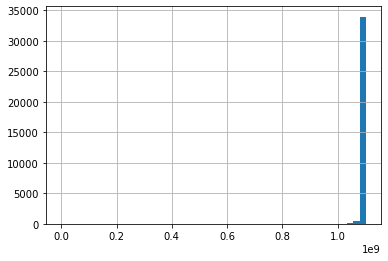

In [91]:
print(np.sort(test["sell_id"].unique()))
test["sell_id"].hist(bins=50)

In [92]:
test.drop(["sell_id"], axis=1, inplace=True)

- car_url содержит ссылку на авто из тестовой выборки. Мог бы быть полезен для парсинга дополнительных признаков, но я не придумал, что оттуда можно ещё вытащить, кроме комплектации, которая итак представлена в словаре.

In [93]:
test.drop(["car_url"], axis=1, inplace=True)

- equipment_dict используется только в test и не может быть использован для обучения и прогноза стоимости

In [94]:
test.drop(["equipment_dict"], axis=1, inplace=True)

- image содержит ссылки на картинки и используется только в test, а значит бесполезен

In [95]:
test.drop(["image"], axis=1, inplace=True)

- super_gen содержит описание двигателя и используется только в test

In [96]:
test.drop(["super_gen"], axis=1, inplace=True)

- model_info содержится только в test и уже разобран на дополнительные признаки

In [97]:
test.drop(["model_info"], axis=1, inplace=True)

- Используем время парсинга для работы с временными признаками в test

In [98]:
parsing_time = datetime.datetime.fromtimestamp(test["parsing_unixtime"].mean())
parsing_time
test.drop("parsing_unixtime", axis=1, inplace=True)

In [99]:
train["Владение"] = parsing_time - pd.to_datetime(train["Владение"].progress_apply(lambda x: "" if (pd.isnull(x) or str(x) == 'nan') else
                 datetime.date(eval(str(x))['year'], eval(str(x))['month'],1)))
test["Владение"] = test["Владение"].apply(ParseDateTest)

train["Владение"] = train["Владение"].dt.days
test["Владение"] = test["Владение"].dt.days

train['modelDate'] = 2020 - train['modelDate']
test['modelDate'] = 2020 - test['modelDate']
train['productionDate'] = 2020 - train['productionDate']
test['productionDate'] = 2020 - test['productionDate']

  0%|          | 0/86854 [00:00<?, ?it/s]

C:\Users\Max\AppData\Local\Temp/ipykernel_7104/3678694702.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["Владение"] = parsing_time - pd.to_datetime(train["Владение"].progress_apply(lambda x: "" if (pd.isnull(x) or str(x) == 'nan') else
C:\Users\Max\AppData\Local\Temp/ipykernel_7104/3678694702.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["Владение"] = train["Владение"].dt.days
C:\Users\Max\AppData\Local\Temp/ipykernel_7104/3678694702.py:8: SettingWithCopyWarning: 
A value is trying t

- start_date непонятный признак, который используется только в train

<AxesSubplot:>

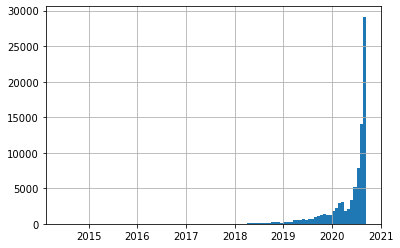

In [100]:
pd.to_datetime(train["start_date"]).hist(bins=100)

In [101]:
train.drop("start_date", axis=1, inplace=True)

- vendor есть только в тестовой выборке, используем словарь для получения конкретной страны бренда

In [102]:
test.groupby(["vendor", "brand"])["brand"].count()

vendor    brand     
EUROPEAN  AUDI          3421
          BMW           4473
          MERCEDES      4180
          SKODA         2741
          VOLKSWAGEN    4404
          VOLVO         1463
JAPANESE  HONDA         1150
          INFINITI       871
          LEXUS          834
          MITSUBISHI    2843
          NISSAN        4393
          TOYOTA        3913
Name: brand, dtype: int64

In [103]:
test.drop("vendor", axis=1, inplace=True)

In [104]:
dict_countries = {'Europe': ['AUDI','BMW','OPEL','PORSCHE','VOLKSWAGEN','MERCEDES', "SKODA", "VOLVO", "CITROEN", "PEUGEOT", "RENAULT"],
                  'Japan':   ['HONDA','INFINITI','LEXUS','MAZDA','MITSUBISHI','NISSAN','SUBARU','SUZUKI','TOYOTA'],
                  'USA':     ['CADILLAC','CHEVROLET','CHRYSLER','DODGE','FORD','JEEP'],
                  'China':   ['CHERY','GEELY','GREAT_WALL'],
                  'UK':      ['JAGUAR','MINI','LAND_ROVER'],
                  'Korea':   ['DAEWOO','HYUNDAI','KIA','SSANG_YONG']}
inv_dict_countries = dict()
for key in dict_countries.keys():
    for value in dict_countries[key]:
        inv_dict_countries[value] = key

In [105]:
train["country"] = train["brand"].apply(lambda x: inv_dict_countries[x])
test["country"] = test["brand"].apply(lambda x: inv_dict_countries[x])

C:\Users\Max\AppData\Local\Temp/ipykernel_7104/4238479035.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["country"] = train["brand"].apply(lambda x: inv_dict_countries[x])


- Признак name разобран на составляющие, можем от него избавиться:

In [106]:
train.drop("name", axis=1, inplace=True)
test.drop("name", axis=1, inplace=True)

- Признак Владельцы:

In [107]:
train[train["Владельцы"].isna()]["productionDate"].value_counts()

0    10854
1     1061
2       82
3        1
Name: productionDate, dtype: int64

In [108]:
# чаще всего машина новая, но поскольку в тестовой выборке представлены только 1+ владельцы, лучше присвоим пропускам значение 1, как наименьшее
train["Владельцы"] = train["Владельцы"].fillna(1)
test["Владельцы"] = test["Владельцы"].apply(lambda x: x[0]).astype(int)

C:\Users\Max\AppData\Local\Temp/ipykernel_7104/2958620958.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["Владельцы"] = train["Владельцы"].fillna(1)


- некоторые признаки требуют предобработки, используем словари:

In [109]:
dict_trans = {"MECHANICAL": "механическая", "AUTOMATIC": "автоматическая", "ROBOT": "роботизированная", "VARIATOR": "вариатор"}
dict_PTS = {'ORIGINAL': 'Оригинал', 'DUPLICATE': 'Дубликат'}
dict_Руль = {'LEFT': 'Левый', 'RIGHT': 'Правый'}
# В обучающей выборке цвета представлены в виде кодов, приведем их к единому виду:
dict_color = {'040001': 'чёрный', 'FAFBFB': 'белый', 'CACECB': 'серебристый', '97948F': 'серый', '0000CC': 'синий','EE1D19': 'красный', '200204': 'коричневый',
                '007F00': 'зелёный', 'C49648': 'бежевый', '22A0F8': 'голубой', '660099': 'пурпурный', 'DEA522': 'золотистый',
              '4A2197': 'фиолетовый', 'FFD600': 'жёлтый', 'FF8649': 'оранжевый', 'FFC0CB': 'розовый'}

In [110]:
# Приведём названия к единому виду
train.rename({"model":"model_name"}, axis=1, inplace=True)

C:\Users\Max\anaconda3\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [111]:
# приведём кузова к единому виду (особенно это каксалось пикапов)
set_body = set(test["bodyType"].unique())
train["bodyType"] = train["bodyType"].apply(lambda x: getbody(x, set_body))
train["bodyTypeRough"] = train["bodyType"].apply(lambda x: str(x).lower().split()[0])
test["bodyTypeRough"] = test["bodyType"].apply(lambda x: str(x).lower().split()[0])

C:\Users\Max\AppData\Local\Temp/ipykernel_7104/459099897.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["bodyType"] = train["bodyType"].apply(lambda x: getbody(x, set_body))
C:\Users\Max\AppData\Local\Temp/ipykernel_7104/459099897.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["bodyTypeRough"] = train["bodyType"].apply(lambda x: str(x).lower().split()[0])


In [112]:
# приведём трансмиссию к виду в test
train["vehicleTransmission"] = train["vehicleTransmission"].apply(lambda x: "автоматическая" if pd.isnull(x) else dict_trans[x])

C:\Users\Max\AppData\Local\Temp/ipykernel_7104/1282894528.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["vehicleTransmission"] = train["vehicleTransmission"].apply(lambda x: "автоматическая" if pd.isnull(x) else dict_trans[x])


In [113]:
# приведём ПТС к виду в test
train["ПТС"] = train["ПТС"].apply(lambda x: 'Оригинал' if pd.isnull(x) else dict_PTS[x])

C:\Users\Max\AppData\Local\Temp/ipykernel_7104/3575988446.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["ПТС"] = train["ПТС"].apply(lambda x: 'Оригинал' if pd.isnull(x) else dict_PTS[x])


In [114]:
# Распознаём объём двигателя через регулярные выражения
train["engineDisplacement"] = train["engineDisplacement"].apply(GetEngineDisplacement)
test["engineDisplacement"] = test["engineDisplacement"].apply(GetEngineDisplacement)

C:\Users\Max\AppData\Local\Temp/ipykernel_7104/1562008742.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["engineDisplacement"] = train["engineDisplacement"].apply(GetEngineDisplacement)


In [115]:
# Приводим мощность к целым значениям
train["enginePower"] = train["enginePower"].apply(lambda x: (int)(x) if pd.isnull(x) != True else None)
test["enginePower"] = test["enginePower"].apply(lambda x : (int)(x.split(' ')[0]))

C:\Users\Max\AppData\Local\Temp/ipykernel_7104/2587770394.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["enginePower"] = train["enginePower"].apply(lambda x: (int)(x) if pd.isnull(x) != True else None)


In [116]:
# приведём Руль и color к виду в test
train["Руль"].replace(dict_Руль, inplace=True)
train['color'].replace(dict_color, inplace=True)

C:\Users\Max\anaconda3\lib\site-packages\pandas\core\generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


- Добавим дополнительные признаки по пробегу

In [117]:
train["mileage_by_owner"] = train["mileage"] / train["Владельцы"]
test["mileage_by_owner"] = test["mileage"] / test["Владельцы"]

C:\Users\Max\AppData\Local\Temp/ipykernel_7104/3724234439.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["mileage_by_owner"] = train["mileage"] / train["Владельцы"]


In [118]:
train["mileage_by_year"] = train["mileage"] / train["modelDate"]
test["mileage_by_year"] = test["mileage"] / test["modelDate"]

C:\Users\Max\AppData\Local\Temp/ipykernel_7104/3166475389.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["mileage_by_year"] = train["mileage"] / train["modelDate"]


In [119]:
train[:1]

bodyType brand   color fuelType  modelDate  numberOfDoors  productionDate  \
0    седан  AUDI  чёрный   бензин     30.000          4.000              29   

  vehicleTransmission  engineDisplacement  enginePower  \
0        механическая               2.800      174.000   

                                         description  mileage  Привод   Руль  \
0   Машина  в приличном состоянии ,не гнилая не р...   350000  полный  Левый   

   Владельцы       ПТС  Владение       price model_name  КомплектацияTrue  \
0      3.000  Оригинал       NaN 200,000.000        100                 0   

  country bodyTypeRough  mileage_by_owner  mileage_by_year  
0  Europe         седан       116,666.667       11,666.667

In [120]:
test[:1]

bodyType  brand  color                                        description  \
0  лифтбек  SKODA  синий  Все автомобили, представленные в продаже, прох...   

   engineDisplacement  enginePower fuelType  mileage  modelDate model_name  \
0               1.200          105   бензин    74000          7    OCTAVIA   

   numberOfDoors  productionDate vehicleTransmission  Владельцы  Владение  \
0              5               6    роботизированная          3       NaN   

        ПТС    Привод   Руль  КомплектацияTrue country bodyTypeRough  \
0  Оригинал  передний  Левый                 1  Europe       лифтбек   

   mileage_by_owner  mileage_by_year  
0        24,666.667       10,571.429

## Создаём pickle перед работой с description

In [121]:
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест

data = train.append(test, sort=False).reset_index(drop=True) # объединяем

C:\Users\Max\AppData\Local\Temp/ipykernel_7104/545692207.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['sample'] = 1 # помечаем где у нас трейн


In [122]:
data.shape

(121540, 25)

In [123]:
data.to_pickle("data.pickle")

# Работа с description

## Предобработка

In [124]:
# Почищенный description
data["descriptionTrue"] = data["description"].apply(lambda x: str.join(" ", re.findall(r"\w+", re.sub("[^\D]", " ", str(x)))).lower())

In [125]:
# Признак дилера (достаточно точный)
data["dealer"] = data["descriptionTrue"].apply(lambda x: ("услов" in x) or ("выгод" in x) or (" центр " in x) or ("обраща" in x) or ("взнос" in x)).astype(int)

In [126]:
# Класс для стемминга
class Porter:
	PERFECTIVEGROUND =  re.compile(u"((ив|ивши|ившись|ыв|ывши|ывшись)|((?<=[ая])(в|вши|вшись)))$")
	REFLEXIVE = re.compile(u"(с[яь])$")
	ADJECTIVE = re.compile(u"(ее|ие|ые|ое|ими|ыми|ей|ий|ый|ой|ем|им|ым|ом|его|ого|ему|ому|их|ых|ую|юю|ая|яя|ою|ею)$")
	PARTICIPLE = re.compile(u"((ивш|ывш|ующ)|((?<=[ая])(ем|нн|вш|ющ|щ)))$")
	VERB = re.compile(u"((ила|ыла|ена|ейте|уйте|ите|или|ыли|ей|уй|ил|ыл|им|ым|ен|ило|ыло|ено|ят|ует|уют|ит|ыт|ены|ить|ыть|ишь|ую|ю)|((?<=[ая])(ла|на|ете|йте|ли|й|л|ем|н|ло|но|ет|ют|ны|ть|ешь|нно)))$")
	NOUN = re.compile(u"(а|ев|ов|ие|ье|е|иями|ями|ами|еи|ии|и|ией|ей|ой|ий|й|иям|ям|ием|ем|ам|ом|о|у|ах|иях|ях|ы|ь|ию|ью|ю|ия|ья|я)$")
	RVRE = re.compile(u"^(.*?[аеиоуыэюя])(.*)$")
	DERIVATIONAL = re.compile(u".*[^аеиоуыэюя]+[аеиоуыэюя].*ость?$")
	DER = re.compile(u"ость?$")
	SUPERLATIVE = re.compile(u"(ейше|ейш)$")
	I = re.compile(u"и$")
	P = re.compile(u"ь$")
	NN = re.compile(u"нн$")

	def stem(word):
		word = word.lower()
		word = word.replace(u'ё', u'е')
		m = re.match(Porter.RVRE, word)
		if m and m.groups():
			pre = m.group(1)
			rv = m.group(2)
			temp = Porter.PERFECTIVEGROUND.sub('', rv, 1)
			if temp == rv:
				rv = Porter.REFLEXIVE.sub('', rv, 1)
				temp = Porter.ADJECTIVE.sub('', rv, 1)
				if temp != rv:
					rv = temp
					rv = Porter.PARTICIPLE.sub('', rv, 1)
				else:
					temp = Porter.VERB.sub('', rv, 1)
					if temp == rv:
						rv = Porter.NOUN.sub('', rv, 1)
					else:
						rv = temp
			else:
				rv = temp
			
			rv = Porter.I.sub('', rv, 1)

			if re.match(Porter.DERIVATIONAL, rv):
				rv = Porter.DER.sub('', rv, 1)

			temp = Porter.P.sub('', rv, 1)
			if temp == rv:
				rv = Porter.SUPERLATIVE.sub('', rv, 1)
				rv = Porter.NN.sub(u'н', rv, 1)
			else:
				rv = temp
			word = pre+rv
		return word
	stem=staticmethod(stem)

In [127]:
morph = pymorphy2.MorphAnalyzer()
def clean_review(review):
    """
    Receives a raw review and clean it using the following steps:
    1. Remove all non-words
    2. Transform the review in lower case
    3. Remove all stop words
    4. Perform stemming

    Args:
        review: the review that iwill be cleaned
    Returns:
        a clean review using the mentioned steps above.
    """
    s = set(stopwords.words("russian"))
    s.remove("не")
    s.remove("нет")

    review = str.join(" ", re.findall(r"\w+", re.sub("[^\D]", " ", str(review)))).lower()
    review = nltk.word_tokenize(review)
    # избавляемся от стоп-слов
    #stemmer = PorterStemmer()
    stemmer = Porter()
    #review = [stemmer.stem(word) for word in review if word not in s]
    review = [stemmer.stem(word) for word in review if word not in s]
    # слова к нормальной форме
    #morph = pymorphy2.MorphAnalyzer()
    res = list()
    for word in review:
        res.append(morph.parse(word)[0].normal_form)
    return res#" ".join(review)

[Dostoevsky — анализ тональности в Python за 5 минут](https://github.com/bureaucratic-labs/dostoevsky)

In [ ]:
#from dostoevsky.tokenization import RegexTokenizer
#from dostoevsky.models import FastTextSocialNetworkModel

In [130]:
tokenizer = RegexTokenizer()
model = FastTextSocialNetworkModel(tokenizer=tokenizer)

messages =  data["description"].astype(str).values
results = model.predict(messages, k=5)

In [131]:
res_df = pd.DataFrame(results)
data["description_neutral"] = res_df["neutral"]
data["description_negative"] = res_df["negative"]
data["description_skip"] = res_df["skip"]
data["description_positive"] = res_df["positive"]
data["description_speech"] = res_df["speech"]

In [132]:
print(data[data["dealer"] == 1]["description_positive"].mean())
print(data[data["dealer"] == 0]["description_positive"].mean())

0.05734825881679042
0.08912024468864108


Как мы видим, средняя оценка тональности отзывов собственников выше

In [133]:
# Подготовим данные для векторизации
data["descriptionTrue"] = data["description"].progress_apply(lambda x: clean_review(str(x)))

  0%|          | 0/121540 [00:00<?, ?it/s]

Запишем данные после долгой обработки

In [134]:
data.to_pickle("data_1.pickle")

In [135]:
data = pd.read_pickle("data_1.pickle")

In [136]:
desc_list = data["descriptionTrue"].tolist()

In [137]:
from gensim.models import Word2Vec

# Обучаем модель векторайзера на нашем наборе данных
# На выходе мы получим вектор признаков для каждого слова
model = Word2Vec(desc_list, min_count=20, vector_size=50)

In [138]:
# Наивный подход к созданию единого эмбеддинга для документа – средний эмбеддинг по словам
def doc_vectorizer(doc, model):
    doc_vector = []
    num_words = 0
    for word in doc:
        try:
            if num_words == 0:
                doc_vector = model.wv[word]
            else:
                doc_vector = np.add(doc_vector, model.wv[word])
            num_words += 1
        except:
            pass
     
    return np.asarray(doc_vector) / num_words

# Составляем эмбеддинги для наших документов
X = []
for doc in tqdm(desc_list):
    X.append(doc_vectorizer(doc, model))

  0%|          | 0/121540 [00:00<?, ?it/s]

In [139]:
data["description_vectorized"] = X

In [141]:
data["description_vectorized"]

0         [0.14316565, -0.2704191, -1.2541035, -1.901166...
1         [0.31685418, 0.82982403, -1.143442, -3.7511628...
2         [-1.1903324, -0.88833135, -0.19825284, 0.86106...
3         [-0.008114043, -0.0057699396, -0.0018216276, -...
4         [-0.20371813, -0.15655461, -0.6841683, -2.2949...
                                ...                        
121535    [-0.58197284, 0.22345115, -0.48433563, -1.3880...
121536    [-0.8130412, -1.0647333, -0.77336425, -1.79026...
121537    [-1.6075549, -0.36081862, -2.730777, -2.713755...
121538    [0.44480005, 0.13109167, -0.8720364, 0.0432154...
121539    [0.68418723, 0.1782795, -1.0528737, -1.9739575...
Name: description_vectorized, Length: 121540, dtype: object

In [142]:
data["description_vectorized"] =data["description_vectorized"].progress_apply(lambda x: None if x.shape == (0,) else x)

  0%|          | 0/121540 [00:00<?, ?it/s]

In [145]:
np.array(data["description_vectorized"]).shape

(121540,)

In [143]:
np.asarray((data["description_vectorized"][data["description_vectorized"].isnull() == False].values).tolist()).shape

(121455, 50)

In [146]:
_X = np.asarray((data["description_vectorized"][data["description_vectorized"].isnull() == False].values).tolist())

In [147]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
_X = pca.fit_transform(_X)

- t-SNE очень медленный, откажемся от использования
https://habr.com/ru/company/rubda/blog/594759/

In [148]:
# t-SNE – метод понижения размерности
#from sklearn.manifold import TSNE

# Создаём объект для выполнения t-SNE
#tsne = TSNE(n_components=2, random_state=0, ini)

# Преобразуем наши данные, понизив размерность с 50 до 2
#_X = tsne.fit_transform(_X)

print(_X.shape)

(121455, 2)


Снизили размерность с 50 до 2

## Кластеризация

In [150]:
from sklearn import metrics
from sklearn.cluster import KMeans
#from sklearn.feature_extraction.text import CountVectorizer

# Создаём KMeans кластеризатор 
kmeans = KMeans(n_clusters=3)

# Обучим кластеризатор на подготовленных данных
kmeans.fit(_X)

KMeans(n_clusters=3)

In [151]:
# Получаем предсказанные кластеры
y_pred = kmeans.labels_.astype(int)

# Координаты полученных центроидов
print ("Координаты центроидов:\n", kmeans.cluster_centers_)

Координаты центроидов:
 [[-2.2200274  -1.1223944 ]
 [-0.21419966  7.0147424 ]
 [ 6.9679537  -0.31063473]]


In [153]:
# Метрики
print ("Коэффициент силуэта: %0.3f" % metrics.silhouette_score(_X, y_pred, metric='euclidean'))

Коэффициент силуэта: 0.579


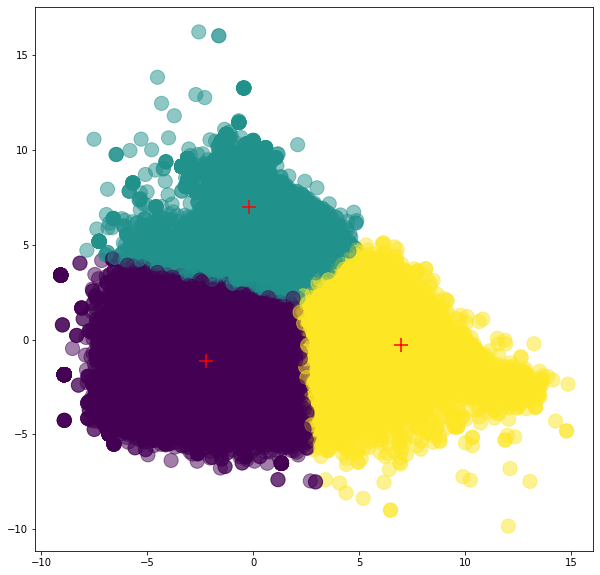

In [154]:
# Графики полученных кластеров
plt.rcParams['figure.figsize'] = 10, 10
plt.scatter(_X[:, 0], _X[:, 1], c=y_pred, s=200, alpha=.5)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=200, marker='+')
plt.show()

In [155]:
data.loc[data["description_vectorized"].isnull() == False, "description_claster"] = y_pred

In [156]:
data.to_pickle("data_2.pickle")

In [ ]:
# CountVectorizer более сложный, но интересный подход, как мне показалось
# Не хватает времени с ним разбираться

# from sklearn.feature_extraction.text import CountVectorizer

# vectorizer2 = CountVectorizer(analyzer='word', ngram_range=(3, 3))
# X2 = vectorizer2.fit_transform(train["descriptionTrue"])
# vectorizer2.get_feature_names_out()

# # Создаём объект, который будет токенизировать данные
# analyzer = CountVectorizer(stop_words='english').build_analyzer()

# # Токенизируем наш набор данных
# docs = []
# for document in dataset.data:
#     docs.append(analyzer(document.replace('_', '')))

# # И посмотрим 10 первых примеров
# for i in range(10):
#     print(docs[i], end='\n\n')

# vectorizer2.get_feature_names_out()

array(['00 00 00', '00 00 02', '00 00 без', ..., '𝐁𝐞𝐧𝐳 𝐂𝟏𝟖𝟎 пробег',
       '𝐂𝟏𝟖𝟎 пробег 2730', '𝐌𝐞𝐫𝐜𝐞𝐝𝐞𝐬 𝐁𝐞𝐧𝐳 𝐂𝟏𝟖𝟎'], dtype=object)

## Наивный подход к TF-IDF

In [36]:
data = pd.read_pickle("data_2.pickle")

In [37]:
dict_words = dict()
L = []

for item in data["description"]:
    if pd.isna(item):
        L.append(None)
        continue
    item = item.upper().replace(",", "").replace(".", " ").replace("  "," ").strip()
    str_list= re.split(";|,|\s|\n|/", item)
    if len(str_list)>0:
        while "" in str_list:
            str_list.remove('')
        L.append(str_list)
        for i in str_list:
            if i in dict_words.keys():
                dict_words[i] +=1
            else:
                dict_words[i] = 1
dict_words

sorted_tuple = sorted(dict_words.items(), key =lambda x: x[1], reverse=True)
sorted_tuple
dict_words = dict(sorted_tuple)

In [38]:
def Score(list_words):
    score = 0
    for i in list_words:
        if i !="":
            if i in dict_words.keys():
                score += dict_words[i]
            else:
                pass
    return score/len(list_words)

In [39]:
data["descriptionTrue2"] = data["description"].progress_apply(lambda x:
    x.upper().replace(",", "").replace(".", " ").replace("  "," ").strip() if pd.isna(x) ==False else " ")
data["descriptionLen"] = data["descriptionTrue2"].progress_apply(lambda item: len(re.split(";|,|\s|\n|/", item)))

  0%|          | 0/121540 [00:00<?, ?it/s]

  0%|          | 0/121540 [00:00<?, ?it/s]

In [40]:
data["descriptionLenLog"] = np.log(data["descriptionLen"] + 1)

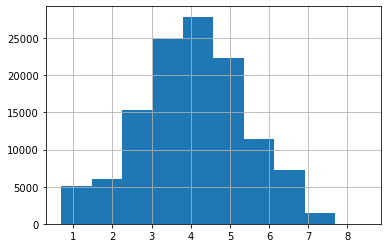

In [41]:
data["descriptionLenLog"].hist()
plt.show()

<AxesSubplot:xlabel='descriptionLen', ylabel='price'>

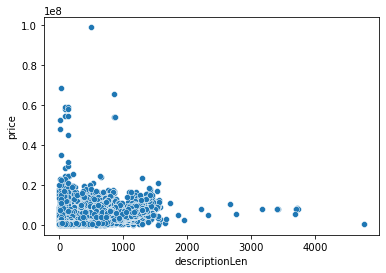

In [42]:
sns.scatterplot(data=data, x="descriptionLen", y="price")

In [43]:
data["descriptionScore"] = data["descriptionTrue2"].progress_apply(lambda x: Score(re.split(";|,|\s|\n|/", str(x))))
data["descriptionScoreLog"] = np.log(data["descriptionScore"] + 1)

  0%|          | 0/121540 [00:00<?, ?it/s]

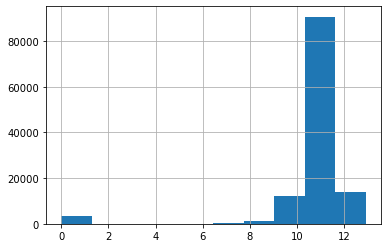

In [44]:
data["descriptionScoreLog"].hist()
plt.show()

<AxesSubplot:xlabel='descriptionScore', ylabel='price'>

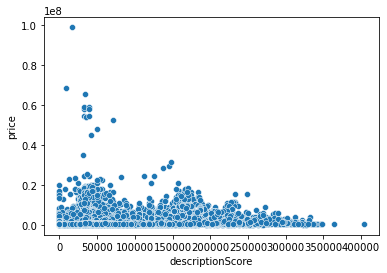

In [45]:
sns.scatterplot(data=data, x="descriptionScore", y="price")

# Data Preprocessing

- Как видим, у объявлений с более редкими словами цена может быть выше

In [46]:
data[:1].T

0
bodyType                                                            седан
brand                                                                AUDI
color                                                              чёрный
fuelType                                                           бензин
modelDate                                                          30.000
numberOfDoors                                                       4.000
productionDate                                                         29
vehicleTransmission                                          механическая
engineDisplacement                                                  2.800
enginePower                                                       174.000
description              Машина  в приличном состоянии ,не гнилая не р...
mileage                                                            350000
Привод                                                             полный
Руль                                                                Левый
Владельцы                                                           3.000
ПТС                                                              Оригинал
Владение                                                              NaN
price                                                         200,000.000
model_name                                                            100
КомплектацияTrue                                                        0
country                                                            Europe
bodyTypeRough                                                       седан
mileage_by_owner                                              116,666.667
mileage_by_year                                                11,666.667
sample                                                                  1
descriptionTrue         [машина, приличн, состоять, не, гнилой, не, рж...
dealer                                                                  0
description_neutral                                                 0.484
description_negative                                                0.192
description_skip                                                    0.133
description_positive                                                0.119
description_speech                                                  0.002
description_vectorized  [0.14316565, -0.2704191, -1.2541035, -1.901166...
description_claster                                                 0.000
descriptionTrue2        МАШИНА В ПРИЛИЧНОМ СОСТОЯНИИ НЕ ГНИЛАЯ НЕ РЖАВ...
descriptionLen                                                         35
descriptionLenLog                                                   3.584
descriptionScore                                               47,784.714
descriptionScoreLog                                                10.774

- Удалим лишние признаки

In [47]:
data.drop(["description", "descriptionTrue", "description_vectorized", "descriptionTrue2"], axis=1, inplace=True)

In [48]:
data[:1].T

0
bodyType                     седан
brand                         AUDI
color                       чёрный
fuelType                    бензин
modelDate                   30.000
numberOfDoors                4.000
productionDate                  29
vehicleTransmission   механическая
engineDisplacement           2.800
enginePower                174.000
mileage                     350000
Привод                      полный
Руль                         Левый
Владельцы                    3.000
ПТС                       Оригинал
Владение                       NaN
price                  200,000.000
model_name                     100
КомплектацияTrue                 0
country                     Europe
bodyTypeRough                седан
mileage_by_owner       116,666.667
mileage_by_year         11,666.667
sample                           1
dealer                           0
description_neutral          0.484
description_negative         0.192
description_skip             0.133
description_positive         0.119
description_speech           0.002
description_claster          0.000
descriptionLen                  35
descriptionLenLog            3.584
descriptionScore        47,784.714
descriptionScoreLog         10.774

## План действий  
- Обратиться к пропускам и дозаполнить некоторые  
- Выделить числовые и категориальные признаки  
- Квантилизация стоимости по марке+модели  
- Логарифмирование целевой переменной  
- LabelEncoding (это не последний этап для всех кроме Cat и XG)  
Для кНН модели:  
- Заполнить все числовые пропуски медианным значением  
- Выполнить MinMax масштабирование числовых  
- get_dummies  
- Провести оптимизацию гиперпараметров  
Для линейной модели и ансамблевых алгоритмов scikit:  
- Заполнить все числовые пропуски медианным значением  
- Выполнить Standart масштабирование числовых  
- get_dummies  
- Провести оптимизацию гиперпараметров  
Для сложных алгоритмов:  
- Выполнить Standart масштабирование числовых  
- Провести оптимизацию гиперпараметров  
Провести стекинг на лучшем наборе моделей.  

In [49]:
data.isnull().sum()

bodyType                    0
brand                       0
color                       0
fuelType                    0
modelDate                   1
numberOfDoors               1
productionDate              0
vehicleTransmission         0
engineDisplacement      20352
enginePower                 1
mileage                     0
Привод                      1
Руль                        0
Владельцы                   0
ПТС                         1
Владение                80707
price                   34686
model_name                  0
КомплектацияTrue            0
country                     0
bodyTypeRough               0
mileage_by_owner            0
mileage_by_year          1323
sample                      0
dealer                      0
description_neutral         0
description_negative        0
description_skip            0
description_positive        0
description_speech          0
description_claster        85
descriptionLen              0
descriptionLenLog           0
descriptio

In [50]:
data["engineDisplacement"].fillna(1.3, inplace=True)

In [51]:
# Во владении очень много пропусков, придётся удалить
data.drop("Владение", axis=1, inplace=True)

## Разделим признаки

In [52]:
data.dtypes[data.dtypes == "object"].index

Index(['bodyType', 'brand', 'color', 'fuelType', 'vehicleTransmission',
       'Привод', 'Руль', 'ПТС', 'model_name', 'country', 'bodyTypeRough'],
      dtype='object')

In [53]:
data.dtypes[data.dtypes != "object"].index

Index(['modelDate', 'numberOfDoors', 'productionDate', 'engineDisplacement',
       'enginePower', 'mileage', 'Владельцы', 'price', 'КомплектацияTrue',
       'mileage_by_owner', 'mileage_by_year', 'sample', 'dealer',
       'description_neutral', 'description_negative', 'description_skip',
       'description_positive', 'description_speech', 'description_claster',
       'descriptionLen', 'descriptionLenLog', 'descriptionScore',
       'descriptionScoreLog'],
      dtype='object')

In [54]:
cat_list =  ['bodyType', 'brand', 'color', 'fuelType', 'vehicleTransmission',
       'Привод', 'Руль', 'ПТС', 'model_name', 'country', 'bodyTypeRough',
             'numberOfDoors', 'description_claster']

num_list = ['modelDate', 'productionDate', 'engineDisplacement',
       'enginePower', 'mileage', 'Владельцы', 'КомплектацияTrue',
       'mileage_by_owner', 'mileage_by_year', 'dealer',
       'description_neutral', 'description_negative', 'description_skip',
       'description_positive', 'description_speech', 
       'descriptionLen', 'descriptionLenLog', 'descriptionScore',
       'descriptionScoreLog']

## Квантилизация и логарифмирование целевой переменной

In [55]:
P = Prerocessor()

In [56]:
data = P.transform_by_group(data, group_features = ["brand", "model_name"],
                     agg_func=np.median, column = "price", log=True, multiplier=1)

In [57]:
data["price_cut"].value_counts()

5    33501
4    21891
3    21623
2    18792
6    13526
1     7593
0     4589
7       25
Name: price_cut, dtype: int64

- по результатам предварительных расчётов, логарифмирование целевой переменной улучшает устойчивость алгоритмов к выбросам

In [58]:
data["price"] = np.log(data["price"])

## Label Encoding

- Сделаем Label Encoding по всему датасету

In [59]:
P_label = Prerocessor()

In [60]:
P_label.fit_transform(data, cat_list, method="label", depth=None, # глубина значений, по которым отсекаем value_counts
                      q1=None, q2=None, cut_outliers=False, # это полезно для числовых признаков
                inplace=True)

  0%|          | 0/13 [00:00<?, ?it/s]

bodyType  brand  color  fuelType  modelDate  numberOfDoors  \
0             16      0     15         0     30.000              3   
1             16      0      7         0     38.000              3   
2             20      0     13         0     32.000              4   
3             16      0     11         0     32.000              3   
4             16      0     15         0     30.000              3   
...          ...    ...    ...       ...        ...            ...   
121535        16      1      6         0      9.000              3   
121536        16      1     15         3      4.000              3   
121537        16      1     12         0     25.000              3   
121538         2      1      6         3      8.000              4   
121539         2      1     15         3     14.000              4   

        productionDate  vehicleTransmission  engineDisplacement  enginePower  \
0                   29                    2               2.800      174.000   
1                   34                    2               1.800       90.000   
2                   31                    2               2.300      136.000   
3                   31                    2               1.800       90.000   
4                   29                    2               2.000      101.000   
...                ...                  ...                 ...          ...   
121535               6                    0               1.600      136.000   
121536               2                    0               2.000      190.000   
121537              23                    0               2.500      170.000   
121538               7                    0               2.000      184.000   
121539              12                    0               3.000      235.000   

        mileage  Привод  Руль  Владельцы  ПТС  price  model_name  \
0        350000       2     0      3.000    1 12.206           1   
1        173424       1     0      3.000    1 11.002           1   
2        230000       2     0      3.000    1 11.503           1   
3        240000       1     0      3.000    1 11.082           1   
4        300000       1     0      3.000    0 11.513           1   
...         ...     ...   ...        ...  ...    ...         ...   
121535   115000       0     0      3.000    1    NaN          45   
121536    98000       2     0      1.000    1    NaN          60   
121537   360000       0     0      3.000    0    NaN          60   
121538    90500       2     0      2.000    1    NaN        1053   
121539   240000       2     0      3.000    1    NaN        1059   

        КомплектацияTrue  country  bodyTypeRough  mileage_by_owner  \
0                      0        1             12       116,666.667   
1                      0        1             12        57,808.000   
2                      0        1             15        76,666.667   
3                      0        1             12        80,000.000   
4                      0        1             12       100,000.000   
...                  ...      ...            ...               ...   
121535                 1        1             12        38,333.333   
121536                 1        1             12        98,000.000   
121537                 1        1             12       120,000.000   
121538                 0        1              1        45,250.000   
121539                 1        1              1        80,000.000   

        mileage_by_year  sample  dealer  description_neutral  \
0            11,666.667       1       0                0.484   
1             4,563.789       1       0                0.896   
2             7,187.500       1       1                0.712   
3             7,500.000       1       0                1.000   
4            10,000.000       1       0                0.301   
...                 ...     ...     ...                  ...   
121535       12,777.778       0       0                0.840   
121536       24,500.000       0     

## Анализ корреляций

<AxesSubplot:>

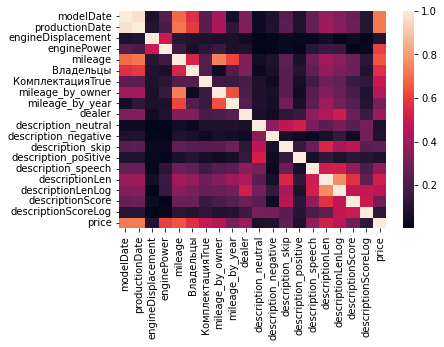

In [61]:
sns.heatmap(np.abs(data[num_list + ["price"]].corr()))

- modelDate и productionDate сильно скоррелированы, сгенерируем признак production_delay  - разница между началом и датой производства

In [62]:
data["production_delay"] = data["modelDate"] - data["productionDate"]

In [63]:
data.drop("modelDate", axis=1, inplace=True)

In [64]:
num_list.remove("modelDate")
num_list.append("production_delay")

<AxesSubplot:>

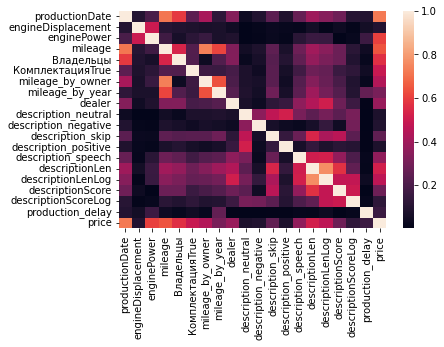

In [65]:
sns.heatmap(np.abs(data[num_list + ["price"]].corr()))

In [66]:
data[cat_list].nunique()

bodyType                 26
brand                    36
color                    16
fuelType                  6
vehicleTransmission       4
Привод                    4
Руль                      2
ПТС                       3
model_name             1104
country                   6
bodyTypeRough            19
numberOfDoors             6
description_claster       4
dtype: int64

# Специфичная предобработка

In [67]:
data

bodyType  brand  color  fuelType  numberOfDoors  productionDate  \
0             16      0     15         0              3              29   
1             16      0      7         0              3              34   
2             20      0     13         0              4              31   
3             16      0     11         0              3              31   
4             16      0     15         0              3              29   
...          ...    ...    ...       ...            ...             ...   
121535        16      1      6         0              3               6   
121536        16      1     15         3              3               2   
121537        16      1     12         0              3              23   
121538         2      1      6         3              4               7   
121539         2      1     15         3              4              12   

        vehicleTransmission  engineDisplacement  enginePower  mileage  Привод  \
0                         2               2.800      174.000   350000       2   
1                         2               1.800       90.000   173424       1   
2                         2               2.300      136.000   230000       2   
3                         2               1.800       90.000   240000       1   
4                         2               2.000      101.000   300000       1   
...                     ...                 ...          ...      ...     ...   
121535                    0               1.600      136.000   115000       0   
121536                    0               2.000      190.000    98000       2   
121537                    0               2.500      170.000   360000       0   
121538                    0               2.000      184.000    90500       2   
121539                    0               3.000      235.000   240000       2   

        Руль  Владельцы  ПТС  price  model_name  КомплектацияTrue  country  \
0          0      3.000    1 12.206           1                 0        1   
1          0      3.000    1 11.002           1                 0        1   
2          0      3.000    1 11.503           1                 0        1   
3          0      3.000    1 11.082           1                 0        1   
4          0      3.000    0 11.513           1                 0        1   
...      ...        ...  ...    ...         ...               ...      ...   
121535     0      3.000    1    NaN          45                 1        1   
121536     0      1.000    1    NaN          60                 1        1   
121537     0      3.000    0    NaN          60                 1        1   
121538     0      2.000    1    NaN        1053                 0        1   
121539     0      3.000    1    NaN        1059                 1        1   

        bodyTypeRough  mileage_by_owner  mileage_by_year  sample  dealer  \
0                  12       116,666.667       11,666.667       1       0   
1                  12        57,808.000        4,563.789       1       0   
2                  15        76,666.667        7,187.500       1       1   
3                  12        80,000.000        7,500.000       1       0   
4                  12       100,000.000       10,000.000       1       0   
...               ...               ...              ...     ...     ...   
121535             12        38,333.333       12,777.778       0       0   
121536             12        98,000.000       24,500.000       0       0   
121537             12       120,000.000       14,400.000       0       0   
121538              1        45,250.000       11,312.500       0       0   
121539              1        80,000.000       17,142.857       0       0   

        description_neutral  description_negative  description_skip  \
0                     0.484                 0.192             0.133   
1                     0.896                 0.060             0.070   
2                     0.712                 0.182             0.090   


## Для kNN

- заполним пропуски медианой

In [68]:
P_knn = Prerocessor()

In [69]:
data_knn = data.copy()

- MinMax Scale

In [70]:
P_knn.fit_transform(data_knn, num_list, method="minmax", cut_outliers=True, inplace=True)

  0%|          | 0/19 [00:00<?, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\Max\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\Max\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

bodyType  brand  color  fuelType  numberOfDoors  productionDate  \
0             16      0     15         0              3           0.659   
1             16      0      7         0              3           0.773   
2             20      0     13         0              4           0.705   
3             16      0     11         0              3           0.705   
4             16      0     15         0              3           0.659   
...          ...    ...    ...       ...            ...             ...   
121535        16      1      6         0              3           0.136   
121536        16      1     15         3              3           0.045   
121537        16      1     12         0              3           0.523   
121538         2      1      6         3              4           0.159   
121539         2      1     15         3              4           0.273   

        vehicleTransmission  engineDisplacement  enginePower  mileage  Привод  \
0                         2               0.382        0.218    0.538       2   
1                         2               0.200        0.068    0.267       1   
2                         2               0.291        0.150    0.354       2   
3                         2               0.200        0.068    0.369       1   
4                         2               0.236        0.087    0.462       1   
...                     ...                 ...          ...      ...     ...   
121535                    0               0.164        0.150    0.177       0   
121536                    0               0.236        0.246    0.151       2   
121537                    0               0.327        0.211    0.554       0   
121538                    0               0.236        0.236    0.139       2   
121539                    0               0.418        0.327    0.369       2   

        Руль  Владельцы  ПТС  price  model_name  КомплектацияTrue  country  \
0          0      1.000    1 12.206           1             0.000        1   
1          0      1.000    1 11.002           1             0.000        1   
2          0      1.000    1 11.503           1             0.000        1   
3          0      1.000    1 11.082           1             0.000        1   
4          0      1.000    0 11.513           1             0.000        1   
...      ...        ...  ...    ...         ...               ...      ...   
121535     0      1.000    1    NaN          45             1.000        1   
121536     0      0.000    1    NaN          60             1.000        1   
121537     0      1.000    0    NaN          60             1.000        1   
121538     0      0.500    1    NaN        1053             0.000        1   
121539     0      1.000    1    NaN        1059             1.000        1   

        bodyTypeRough  mileage_by_owner  mileage_by_year  sample  dealer  \
0                  12             0.284            0.198       1   0.000   
1                  12             0.141            0.077       1   0.000   
2                  15             0.187            0.122       1   1.000   
3                  12             0.195            0.127       1   0.000   
4                  12             0.243            0.170       1   0.000   
...               ...               ...              ...     ...     ...   
121535             12             0.093            0.217       0   0.000   
121536             12             0.238            0.416       0   0.000   
121537             12             0.292            0.245       0   0.000   
121538              1             0.110            0.192       0   0.000   
121539              1             0.195            0.291       0   0.000   

        description_neutral  description_negative  description_skip  \
0                     0.481                 0.316             0.133   
1                     0.896                 0.099             0.070   
2                     0.710                 0.300             0.090   


In [71]:
for col in num_list:
    data_knn[col] = data_knn[col].fillna(data_knn[col].median())

In [72]:
data_knn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121540 entries, 0 to 121539
Data columns (total 35 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              121540 non-null  int32  
 1   brand                 121540 non-null  int32  
 2   color                 121540 non-null  int32  
 3   fuelType              121540 non-null  int32  
 4   numberOfDoors         121540 non-null  int32  
 5   productionDate        121540 non-null  float64
 6   vehicleTransmission   121540 non-null  int32  
 7   engineDisplacement    121540 non-null  float64
 8   enginePower           121540 non-null  float64
 9   mileage               121540 non-null  float64
 10  Привод                121540 non-null  int32  
 11  Руль                  121540 non-null  int32  
 12  Владельцы             121540 non-null  float64
 13  ПТС                   121540 non-null  int32  
 14  price                 86854 non-null   float64
 15  

In [73]:
data_knn[num_list].describe().T

count  mean   std   min   25%   50%   75%   max
productionDate       121,540.000 0.220 0.155 0.000 0.114 0.205 0.295 1.000
engineDisplacement   121,540.000 0.241 0.152 0.000 0.127 0.200 0.309 1.000
enginePower          121,540.000 0.221 0.151 0.000 0.116 0.175 0.282 1.000
mileage              121,540.000 0.221 0.154 0.000 0.112 0.211 0.308 1.000
Владельцы            121,540.000 0.550 0.431 0.000 0.000 0.500 1.000 1.000
КомплектацияTrue     121,540.000 0.467 0.499 0.000 0.000 0.000 1.000 1.000
mileage_by_owner     121,540.000 0.168 0.126 0.000 0.091 0.150 0.223 1.000
mileage_by_year      121,540.000 0.199 0.118 0.000 0.134 0.196 0.261 1.000
dealer               121,540.000 0.190 0.392 0.000 0.000 0.000 0.000 1.000
description_neutral  121,540.000 0.634 0.208 0.000 0.489 0.649 0.787 1.000
description_negative 121,540.000 0.229 0.129 0.000 0.148 0.219 0.293 1.000
description_skip     121,540.000 0.119 0.131 0.000 0.057 0.088 0.129 1.000
description_positive 121,540.000 0.096 0.094 0.000 0.045 0.074 0.118 1.000
description_speech   121,540.000 0.055 0.070 0.000 0.010 0.033 0.076 1.000
descriptionLen       121,540.000 0.094 0.145 0.000 0.016 0.039 0.107 1.000
descriptionLenLog    121,540.000 0.513 0.206 0.000 0.379 0.510 0.662 1.000
descriptionScore     121,540.000 0.205 0.152 0.000 0.127 0.165 0.219 1.000
descriptionScoreLog  121,540.000 0.837 0.149 0.000 0.837 0.857 0.880 1.000
production_delay     121,540.000 0.173 0.133 0.000 0.077 0.154 0.231 1.000

- исключим model_name из dummies, так как имеет слишком много уникальных значений

In [74]:
cat_list_dummies =  ['bodyType', 'brand', 'color', 'fuelType', 'vehicleTransmission',
       'Привод', 'Руль', 'ПТС', 'country', 'bodyTypeRough',
             'numberOfDoors', 'description_claster']
data_knn.drop("model_name",axis=1, inplace=True)
data_knn = pd.get_dummies(data_knn, columns = cat_list_dummies)

In [75]:
data_knn.shape

(121540, 154)

## Для линейных и ансамблевых алгоритмов

In [76]:
P_lin = Prerocessor()

In [77]:
data_lin = data.copy()

- Standart Scale

In [78]:
P_lin.fit_transform(data_lin, num_list, method="std", cut_outliers=True, inplace=True)

  0%|          | 0/19 [00:00<?, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\Max\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\Max\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

bodyType  brand  color  fuelType  numberOfDoors  productionDate  \
0             16      0     15         0              3           2.832   
1             16      0      7         0              3           3.565   
2             20      0     13         0              4           3.125   
3             16      0     11         0              3           3.125   
4             16      0     15         0              3           2.832   
...          ...    ...    ...       ...            ...             ...   
121535        16      1      6         0              3          -0.539   
121536        16      1     15         3              3          -1.125   
121537        16      1     12         0              3           1.953   
121538         2      1      6         3              4          -0.392   
121539         2      1     15         3              4           0.341   

        vehicleTransmission  engineDisplacement  enginePower  mileage  Привод  \
0                         2               0.922       -0.019    2.066       2   
1                         2              -0.273       -1.011    0.299       1   
2                         2               0.325       -0.468    0.865       2   
3                         2              -0.273       -1.011    0.965       1   
4                         2              -0.034       -0.881    1.566       1   
...                     ...                 ...          ...      ...     ...   
121535                    0              -0.512       -0.468   -0.286       0   
121536                    0              -0.034        0.170   -0.456       2   
121537                    0               0.564       -0.066    2.167       0   
121538                    0              -0.034        0.099   -0.531       2   
121539                    0               1.161        0.702    0.965       2   

        Руль  Владельцы  ПТС  price  model_name  КомплектацияTrue  country  \
0          0      1.044    1 12.206           1            -0.935        1   
1          0      1.044    1 11.002           1            -0.935        1   
2          0      1.044    1 11.503           1            -0.935        1   
3          0      1.044    1 11.082           1            -0.935        1   
4          0      1.044    0 11.513           1            -0.935        1   
...      ...        ...  ...    ...         ...               ...      ...   
121535     0      1.044    1    NaN          45             1.069        1   
121536     0     -1.276    1    NaN          60             1.069        1   
121537     0      1.044    0    NaN          60             1.069        1   
121538     0     -0.116    1    NaN        1053            -0.935        1   
121539     0      1.044    1    NaN        1059             1.069        1   

        bodyTypeRough  mileage_by_owner  mileage_by_year  sample  dealer  \
0                  12             0.916           -0.011       1  -0.484   
1                  12            -0.218           -1.028       1  -0.484   
2                  15             0.145           -0.652       1   2.065   
3                  12             0.210           -0.607       1  -0.484   
4                  12             0.595           -0.249       1  -0.484   
...               ...               ...              ...     ...     ...   
121535             12            -0.593            0.148       0  -0.484   
121536             12             0.556            1.827       0  -0.484   
121537             12             0.980            0.381       0  -0.484   
121538              1            -0.460           -0.061       0  -0.484   
121539              1             0.210            0.774       0  -0.484   

        description_neutral  description_negative  description_skip  \
0                    -0.736                 0.673             0.104   
1                     1.261                -1.010            -0.380   
2                     0.369                 0.552            -0.223   


In [79]:
for col in num_list:
    data_lin[col] = data_lin[col].fillna(data_lin[col].median())

In [80]:
data_lin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121540 entries, 0 to 121539
Data columns (total 35 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              121540 non-null  int32  
 1   brand                 121540 non-null  int32  
 2   color                 121540 non-null  int32  
 3   fuelType              121540 non-null  int32  
 4   numberOfDoors         121540 non-null  int32  
 5   productionDate        121540 non-null  float64
 6   vehicleTransmission   121540 non-null  int32  
 7   engineDisplacement    121540 non-null  float64
 8   enginePower           121540 non-null  float64
 9   mileage               121540 non-null  float64
 10  Привод                121540 non-null  int32  
 11  Руль                  121540 non-null  int32  
 12  Владельцы             121540 non-null  float64
 13  ПТС                   121540 non-null  int32  
 14  price                 86854 non-null   float64
 15  

In [81]:
data_lin[num_list].describe().T

count   mean   std    min    25%    50%    75%  \
productionDate       121,540.000 -0.000 1.000 -1.418 -0.685 -0.099  0.487   
engineDisplacement   121,540.000 -0.000 1.000 -1.587 -0.751 -0.273  0.444   
enginePower          121,540.000 -0.000 0.999 -1.460 -0.692 -0.302  0.406   
mileage              121,540.000 -0.000 1.000 -1.437 -0.707 -0.066  0.565   
Владельцы            121,540.000 -0.000 1.000 -1.276 -1.276 -0.116  1.044   
КомплектацияTrue     121,540.000 -0.000 1.000 -0.935 -0.935 -0.935  1.069   
mileage_by_owner     121,540.000 -0.000 1.000 -1.331 -0.609 -0.148  0.431   
mileage_by_year      121,540.000 -0.000 0.994 -1.681 -0.553 -0.029  0.520   
dealer               121,540.000 -0.000 1.000 -0.484 -0.484 -0.484 -0.484   
description_neutral  121,540.000  0.000 1.000 -3.053 -0.698  0.074  0.736   
description_negative 121,540.000 -0.000 1.000 -1.777 -0.627 -0.080  0.493   
description_skip     121,540.000 -0.000 1.000 -0.910 -0.478 -0.243  0.077   
description_positive 121,540.000 -0.000 1.000 -1.022 -0.544 -0.230  0.232   
description_speech   121,540.000 -0.000 1.000 -0.789 -0.639 -0.315  0.303   
descriptionLen       121,540.000 -0.000 1.000 -0.648 -0.541 -0.380  0.091   
descriptionLenLog    121,540.000 -0.000 1.000 -2.488 -0.651 -0.012  0.723   
descriptionScore     121,540.000 -0.000 1.000 -1.346 -0.511 -0.265  0.093   
descriptionScoreLog  121,540.000  0.000 1.000 -5.620 -0.004  0.134  0.286   
production_delay     121,540.000 -0.000 1.000 -1.303 -0.725 -0.146  0.432   

                        max  
productionDate        5.031  
engineDisplacement    4.985  
enginePower           5.156  
mileage               5.070  
Владельцы             1.044  
КомплектацияTrue      1.069  
mileage_by_owner      6.584  
mileage_by_year       6.751  
dealer                2.065  
description_neutral   1.763  
description_negative  5.980  
description_skip      6.711  
description_positive  9.617  
description_speech   13.583  
descriptionLen        6.234  
descriptionLenLog     2.363  
descriptionScore      5.228  
descriptionScoreLog   1.093  
production_delay      6.218

- исключим model_name из dummies, так как имеет слишком много уникальных значений

In [82]:
cat_list_dummies =  ['bodyType', 'brand', 'color', 'fuelType', 'vehicleTransmission',
       'Привод', 'Руль', 'ПТС', 'country', 'bodyTypeRough',
             'numberOfDoors', 'description_claster']
data_lin.drop("model_name",axis=1, inplace=True)
data_lin = pd.get_dummies(data_lin, columns = cat_list_dummies)

In [83]:
data_lin.shape

(121540, 154)

## Для сложных алгоритмов

In [84]:
P_b = Prerocessor()

In [85]:
data_b = data.copy()

In [86]:
data_b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121540 entries, 0 to 121539
Data columns (total 35 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              121540 non-null  int32  
 1   brand                 121540 non-null  int32  
 2   color                 121540 non-null  int32  
 3   fuelType              121540 non-null  int32  
 4   numberOfDoors         121540 non-null  int32  
 5   productionDate        121540 non-null  int64  
 6   vehicleTransmission   121540 non-null  int32  
 7   engineDisplacement    121540 non-null  float64
 8   enginePower           121539 non-null  float64
 9   mileage               121540 non-null  int64  
 10  Привод                121540 non-null  int32  
 11  Руль                  121540 non-null  int32  
 12  Владельцы             121540 non-null  float64
 13  ПТС                   121540 non-null  int32  
 14  price                 86854 non-null   float64
 15  

- Standart Scale

In [87]:
P_b.fit_transform(data_b, num_list, method="std", cut_outliers=True, inplace=True)

  0%|          | 0/19 [00:00<?, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\Max\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\Max\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

bodyType  brand  color  fuelType  numberOfDoors  productionDate  \
0             16      0     15         0              3           2.832   
1             16      0      7         0              3           3.565   
2             20      0     13         0              4           3.125   
3             16      0     11         0              3           3.125   
4             16      0     15         0              3           2.832   
...          ...    ...    ...       ...            ...             ...   
121535        16      1      6         0              3          -0.539   
121536        16      1     15         3              3          -1.125   
121537        16      1     12         0              3           1.953   
121538         2      1      6         3              4          -0.392   
121539         2      1     15         3              4           0.341   

        vehicleTransmission  engineDisplacement  enginePower  mileage  Привод  \
0                         2               0.922       -0.019    2.066       2   
1                         2              -0.273       -1.011    0.299       1   
2                         2               0.325       -0.468    0.865       2   
3                         2              -0.273       -1.011    0.965       1   
4                         2              -0.034       -0.881    1.566       1   
...                     ...                 ...          ...      ...     ...   
121535                    0              -0.512       -0.468   -0.286       0   
121536                    0              -0.034        0.170   -0.456       2   
121537                    0               0.564       -0.066    2.167       0   
121538                    0              -0.034        0.099   -0.531       2   
121539                    0               1.161        0.702    0.965       2   

        Руль  Владельцы  ПТС  price  model_name  КомплектацияTrue  country  \
0          0      1.044    1 12.206           1            -0.935        1   
1          0      1.044    1 11.002           1            -0.935        1   
2          0      1.044    1 11.503           1            -0.935        1   
3          0      1.044    1 11.082           1            -0.935        1   
4          0      1.044    0 11.513           1            -0.935        1   
...      ...        ...  ...    ...         ...               ...      ...   
121535     0      1.044    1    NaN          45             1.069        1   
121536     0     -1.276    1    NaN          60             1.069        1   
121537     0      1.044    0    NaN          60             1.069        1   
121538     0     -0.116    1    NaN        1053            -0.935        1   
121539     0      1.044    1    NaN        1059             1.069        1   

        bodyTypeRough  mileage_by_owner  mileage_by_year  sample  dealer  \
0                  12             0.916           -0.011       1  -0.484   
1                  12            -0.218           -1.028       1  -0.484   
2                  15             0.145           -0.652       1   2.065   
3                  12             0.210           -0.607       1  -0.484   
4                  12             0.595           -0.249       1  -0.484   
...               ...               ...              ...     ...     ...   
121535             12            -0.593            0.148       0  -0.484   
121536             12             0.556            1.827       0  -0.484   
121537             12             0.980            0.381       0  -0.484   
121538              1            -0.460           -0.061       0  -0.484   
121539              1             0.210            0.774       0  -0.484   

        description_neutral  description_negative  description_skip  \
0                    -0.736                 0.673             0.104   
1                     1.261                -1.010            -0.380   
2                     0.369                 0.552            -0.223   


In [88]:
data_b[num_list].describe().T

count   mean   std    min    25%    50%    75%  \
productionDate       121,423.000 -0.000 1.000 -1.418 -0.685 -0.099  0.487   
engineDisplacement   121,506.000  0.000 1.000 -1.587 -0.751 -0.273  0.444   
enginePower          121,348.000 -0.000 1.000 -1.460 -0.692 -0.302  0.406   
mileage              121,419.000  0.000 1.000 -1.437 -0.710 -0.066  0.565   
Владельцы            121,540.000 -0.000 1.000 -1.276 -1.276 -0.116  1.044   
КомплектацияTrue     121,540.000 -0.000 1.000 -0.935 -0.935 -0.935  1.069   
mileage_by_owner     121,419.000  0.000 1.000 -1.331 -0.611 -0.148  0.434   
mileage_by_year      120,096.000 -0.000 1.000 -1.681 -0.561 -0.029  0.528   
dealer               121,540.000 -0.000 1.000 -0.484 -0.484 -0.484 -0.484   
description_neutral  121,424.000 -0.000 1.000 -3.053 -0.698  0.074  0.736   
description_negative 121,426.000  0.000 1.000 -1.777 -0.627 -0.080  0.493   
description_skip     121,432.000  0.000 1.000 -0.910 -0.478 -0.243  0.077   
description_positive 121,418.000  0.000 1.000 -1.022 -0.544 -0.230  0.232   
description_speech   121,518.000  0.000 1.000 -0.789 -0.639 -0.315  0.303   
descriptionLen       121,419.000  0.000 1.000 -0.648 -0.541 -0.380  0.091   
descriptionLenLog    121,419.000  0.000 1.000 -2.488 -0.651 -0.012  0.723   
descriptionScore     121,418.000  0.000 1.000 -1.346 -0.511 -0.265  0.094   
descriptionScoreLog  121,418.000  0.000 1.000 -5.620 -0.004  0.134  0.286   
production_delay     121,443.000  0.000 1.000 -1.303 -0.725 -0.146  0.432   

                        max  
productionDate        5.031  
engineDisplacement    4.985  
enginePower           5.156  
mileage               5.070  
Владельцы             1.044  
КомплектацияTrue      1.069  
mileage_by_owner      6.584  
mileage_by_year       6.751  
dealer                2.065  
description_neutral   1.763  
description_negative  5.980  
description_skip      6.711  
description_positive  9.617  
description_speech   13.583  
descriptionLen        6.234  
descriptionLenLog     2.363  
descriptionScore      5.228  
descriptionScoreLog   1.093  
production_delay      6.218

In [89]:
data_b.shape

(121540, 35)

# Train Split

In [90]:
X_knn = data_knn.query('sample == 1').drop(['sample','price'], axis=1)
y = data_knn.query('sample == 1')['price']
X_sub_knn = data_knn.query('sample == 0').drop(['sample', 'price'], axis=1)

X_lin = data_lin.query('sample == 1').drop(['sample','price'], axis=1)
X_sub_lin = data_lin.query('sample == 0').drop(['sample', 'price'], axis=1)

X_b = data_b.query('sample == 1').drop(['sample','price'], axis=1)
X_sub_b = data_b.query('sample == 0').drop(['sample', 'price'], axis=1)

# Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели двигателя (engineDisplacement). 
C ней будем сравнивать другие модели.




In [169]:
tmp_train = X_knn.copy()
tmp_train['price'] = y_knn

In [170]:
# Находим median по экземплярам engineDisplacement в трейне и размечаем тест
predict = X_knn['engineDisplacement'].map(tmp_train.groupby('engineDisplacement')['price'].median())

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(np.exp(y_knn), np.exp(predict.values)))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 93.80%


# Функция CV

In [91]:
def my_cv(model, X, y):
    
    kf = KFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)
    # кросс-валидация на 3 выборках, так как на 5 время расчётов выше
    mape_train = []
    mape_valid = []
    for train_index, valid_index in tqdm_notebook(kf.split(X)):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        model.fit(X_train, y_train)
        #Введём предсказания на train для детекции переобучения
        
        y_pred_train = model.predict(X_train)
        y_pred_valid = model.predict(X_valid)
        
        mape_train.append(mape_exp(y_train, y_pred_train))
        mape_valid.append(mape_exp(y_valid, y_pred_valid))
    
    mape_train = np.array(mape_train)
    mape_valid = np.array(mape_valid)
    # минимизируем абсолютную ошибку и разницу между валидационной и обучающей выборкой,
    # получим множество Паретто
    return np.mean(mape_valid), np.mean(np.abs(mape_valid - mape_train))


# kNNRegressor

**Для минимизации эффектов переобучения на конкретной выборке из train_test_split воспользуемся оптимизацией и получением метрики на кросс-валидации**

In [217]:
def objective_knn(trial):
    param = {
        "leaf_size": trial.suggest_int("leaf_size", 20, 60, 10),
        "n_neighbors": trial.suggest_int("n_neighbors", 25, 45, 5),
        #"weights" : trial.suggest_categorical("weights", ['uniform', 'distance']),
    }

    model = KNeighborsRegressor(**param, n_jobs=-1)

    return my_cv(model, X_knn, y)

In [218]:
study_knn = optuna.create_study()
study_knn.optimize(objective_knn, n_trials=10)

[I 2022-04-17 19:25:07,305] A new study created in memory with name: no-name-7abad2ad-fb72-4f83-af78-24f328b4839c


0it [00:00, ?it/s]

[I 2022-04-17 19:28:14,476] Trial 0 finished with value: 0.41320182685225576 and parameters: {'leaf_size': 40, 'n_neighbors': 45}. Best is trial 0 with value: 0.41320182685225576.


Стабильность работы = 65.87756731587058 %


0it [00:00, ?it/s]

[I 2022-04-17 19:31:19,355] Trial 1 finished with value: 0.4130249921310255 and parameters: {'leaf_size': 30, 'n_neighbors': 40}. Best is trial 1 with value: 0.4130249921310255.


Стабильность работы = 66.21264859741144 %


0it [00:00, ?it/s]

[I 2022-04-17 19:34:23,880] Trial 2 finished with value: 0.4126000107114213 and parameters: {'leaf_size': 60, 'n_neighbors': 25}. Best is trial 2 with value: 0.4126000107114213.


Стабильность работы = 67.95269814029784 %


0it [00:00, ?it/s]

[I 2022-04-17 19:37:28,815] Trial 3 finished with value: 0.41277998445993447 and parameters: {'leaf_size': 50, 'n_neighbors': 30}. Best is trial 2 with value: 0.4126000107114213.


Стабильность работы = 67.21989444406881 %


0it [00:00, ?it/s]

[I 2022-04-17 19:40:32,931] Trial 4 finished with value: 0.41277998445993447 and parameters: {'leaf_size': 20, 'n_neighbors': 30}. Best is trial 2 with value: 0.4126000107114213.


Стабильность работы = 67.21989444406881 %


0it [00:00, ?it/s]

[I 2022-04-17 19:43:37,306] Trial 5 finished with value: 0.41277998445993447 and parameters: {'leaf_size': 60, 'n_neighbors': 30}. Best is trial 2 with value: 0.4126000107114213.


Стабильность работы = 67.21989444406881 %


0it [00:00, ?it/s]

[I 2022-04-17 19:46:41,685] Trial 6 finished with value: 0.41320182685225576 and parameters: {'leaf_size': 20, 'n_neighbors': 45}. Best is trial 2 with value: 0.4126000107114213.


Стабильность работы = 65.87756731587058 %


0it [00:00, ?it/s]

[I 2022-04-17 19:49:47,225] Trial 7 finished with value: 0.41320182685225576 and parameters: {'leaf_size': 30, 'n_neighbors': 45}. Best is trial 2 with value: 0.4126000107114213.


Стабильность работы = 65.87756731587058 %


0it [00:00, ?it/s]

[I 2022-04-17 19:52:50,138] Trial 8 finished with value: 0.41277998445993447 and parameters: {'leaf_size': 60, 'n_neighbors': 30}. Best is trial 2 with value: 0.4126000107114213.


Стабильность работы = 67.21989444406881 %


0it [00:00, ?it/s]

[I 2022-04-17 19:55:53,034] Trial 9 finished with value: 0.41320182685225576 and parameters: {'leaf_size': 30, 'n_neighbors': 45}. Best is trial 2 with value: 0.4126000107114213.


Стабильность работы = 65.87756731587058 %


In [219]:
print(study_knn.best_params)
optuna.visualization.plot_optimization_history(study_knn)

{'leaf_size': 60, 'n_neighbors': 25}


In [221]:
import joblib
# save your hyperparameter searches 
joblib.dump(study_knn, 'study_knn.pkl')

['study_knn.pkl']

In [225]:
neigh = KNeighborsRegressor(n_neighbors=25,leaf_size = 60, weights = "uniform",  n_jobs=-1)
neigh.fit(X_knn, y)
y_pred_knn = neigh.predict(X_knn)

In [227]:
mape_exp(y, y_pred_knn)*100

27.372123371012556

In [228]:
y_sub_knn = neigh.predict(X_sub_knn)

# Linear Regression

In [229]:
from sklearn.linear_model import LinearRegression

In [284]:
X_lin.drop("ПТС_-1", axis=1, inplace=True)
X_sub_lin.drop("ПТС_-1", axis=1, inplace=True)

In [253]:
LinReg = LinearRegression()
LinReg.fit(X_lin, y)

LinearRegression()

In [254]:
LinReg.score(X_lin, y)

0.9281243000053016

In [255]:
X_lin.shape

(86854, 151)

In [256]:
LinReg.coef_

array([-4.43316796e-01,  4.56390460e-02,  2.24621788e-01, -4.29770802e-02,
       -1.33921739e-01,  1.66789079e-02, -9.25157161e-02, -6.30343544e-03,
       -1.88811452e-04,  7.92502832e-05, -9.17719869e-03, -3.95689367e-02,
        1.99383514e-03,  1.79778024e-03,  5.41420373e-02,  2.16797796e-02,
       -2.27433441e-02,  1.43125655e-02,  1.00799945e-01, -1.86764009e-02,
        1.74210279e+09, -8.58092617e+09, -8.58092617e+09, -8.58092617e+09,
        6.80641358e+08,  2.99211648e+09,  1.33352669e+08,  4.33137226e+09,
        2.33184863e+09,  2.84673526e+09,  9.21829078e+08,  3.25849446e+09,
        9.61299228e+08,  9.61299228e+08,  9.61299228e+08,  2.08781417e+09,
        5.55270259e+09,  5.55270259e+09,  2.83393466e+09,  2.88408297e+09,
        3.53223525e+09,  2.41265153e+09,  3.50164156e+09,  1.77302783e+09,
        1.77302783e+09,  1.77302783e+09,  3.21094541e+08,  3.21094541e+08,
       -1.22829453e+10, -3.31379480e+09, -1.22829453e+10, -1.22829453e+10,
        3.21094541e+08,  

Тут оптимизировать нечего, алгоритм простой, только проверим его на кросс-валидации

In [257]:
my_cv(LinReg, X_lin, y)

0it [00:00, ?it/s]

C:\Users\Max\AppData\Local\Temp/ipykernel_22952/3763966427.py:6: RuntimeWarning:

overflow encountered in exp

C:\Users\Max\AppData\Local\Temp/ipykernel_22952/3763966427.py:6: RuntimeWarning:

overflow encountered in exp

C:\Users\Max\AppData\Local\Temp/ipykernel_22952/3763966427.py:6: RuntimeWarning:

overflow encountered in exp

C:\Users\Max\AppData\Local\Temp/ipykernel_22952/3763966427.py:6: RuntimeWarning:

overflow encountered in exp



Стабильность работы = nan %


C:\Users\Max\AppData\Local\Temp/ipykernel_22952/3763966427.py:6: RuntimeWarning:

overflow encountered in exp

C:\Users\Max\AppData\Local\Temp/ipykernel_22952/3018938199.py:14: RuntimeWarning:

invalid value encountered in double_scalars



inf

# Decision Tree Regressor

## Поиск на грубой сетке

In [344]:
import itertools

In [412]:
max_depth = np.array([2,6,16,35])
min_samples_split = np.array([2,12])
min_samples_leaf =  np.array([1,12])
max_features = np.array(["auto","sqrt","log2"])

param_grid = list(itertools.product(max_depth,min_samples_split, min_samples_leaf, max_features))

In [413]:
res_df_DTR = pd.DataFrame(columns = ["max_depth", "min_samples_split", "min_samples_leaf", "max_features", 
                                 "mape", "mape_diff"])
for i, p in tqdm_notebook(enumerate(param_grid)):
    param = {
        "max_depth": p[0],
        "min_samples_split": p[1],
        "min_samples_leaf": p[2],
        "max_features": p[3],
    }
    model = DecisionTreeRegressor(**param, random_state=RANDOM_SEED)
    temp = my_cv(model, X_lin, y)
    res_df_DTR.loc[len(res_df_DTR.index)] = [p[0], p[1], p[2], p[3], temp[0], temp[1]]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Допустим, заказчик устанавливает разброс работы модели в 5%. То есть мы могли бы получать самый низкий mape валидационной выборке, но при тесте на других данных, он бы выдал непредсказуемый mape. Будем оптимизировать по сумме целевой переменной и её разброса

In [381]:
stability = 0.05

In [384]:
res_df_DTR["mape_sum"] = res_df_DTR["mape"] + res_df_DTR["mape_diff"]

In [386]:
res_df_DTR[res_df_DTR["mape_diff"] < stability].sort_values("mape_sum")

max_depth min_samples_split min_samples_leaf max_features  mape  mape_diff  \
22        16                12               12         sqrt 0.294      0.033   
18        16                 2               12         sqrt 0.294      0.033   
26        35                 2               12         sqrt 0.290      0.039   
30        35                12               12         sqrt 0.290      0.039   
31        35                12               12         log2 0.352      0.029   
27        35                 2               12         log2 0.352      0.029   
23        16                12               12         log2 0.366      0.028   
19        16                 2               12         log2 0.366      0.028   
12         6                12                1         sqrt 0.455      0.004   
14         6                12               12         sqrt 0.466      0.003   
10         6                 2               12         sqrt 0.466      0.003   
8          6                 2                1         sqrt 0.493      0.001   
15         6                12               12         log2 0.501      0.003   
11         6                 2               12         log2 0.501      0.003   
9          6                 2                1         log2 0.509      0.002   
13         6                12                1         log2 0.519      0.005   
7          2                12               12         log2 0.739      0.004   
5          2                12                1         log2 0.739      0.004   
3          2                 2               12         log2 0.739      0.004   
1          2                 2                1         log2 0.739      0.004   
6          2                12               12         sqrt 0.745      0.003   
4          2                12                1         sqrt 0.745      0.003   
2          2                 2               12         sqrt 0.745      0.003   
0          2                 2                1         sqrt 0.745      0.003   

    mape_sum  
22     0.327  
18     0.327  
26     0.329  
30     0.329  
31     0.381  
27     0.381  
23     0.394  
19     0.394  
12     0.459  
14     0.470  
10     0.470  
8      0.495  
15     0.503  
11     0.503  
9      0.511  
13     0.524  
7      0.743  
5      0.743  
3      0.743  
1      0.743  
6      0.748  
4      0.748  
2      0.748  
0      0.748

В победителях деревья со средней глубиной и высшим min_samples_leaf

## Расширим границу

In [406]:
max_depth = np.array([10,13,16,20,25,35])
min_samples_split = np.array([2,6,10,15,20])
min_samples_leaf =  np.array([1,8,12,20,30])
max_features = np.array(["auto","sqrt","log2"])

param_grid = list(itertools.product(max_depth,min_samples_split, min_samples_leaf, max_features))

In [407]:
res_df_DTR = pd.DataFrame(columns = ["max_depth", "min_samples_split", "min_samples_leaf", "max_features", 
                                 "mape", "mape_diff"])
for i, p in tqdm_notebook(enumerate(param_grid)):
    param = {
        "max_depth": p[0],
        "min_samples_split": p[1],
        "min_samples_leaf": p[2],
        "max_features": p[3],
    }
    model = DecisionTreeRegressor(**param, random_state=RANDOM_SEED)
    temp = my_cv(model, X_lin, y)
    res_df_DTR.loc[len(res_df_DTR.index)] = [p[0], p[1], p[2], p[3], temp[0], temp[1]]
res_df_DTR

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

max_depth min_samples_split min_samples_leaf max_features  mape  mape_diff
0          10                 2                1         auto 0.192      0.020
1          10                 2                1         sqrt 0.360      0.016
2          10                 2                1         log2 0.431      0.016
3          10                 2                8         auto 0.189      0.015
4          10                 2                8         sqrt 0.347      0.012
..        ...               ...              ...          ...   ...        ...
445        35                20               20         sqrt 0.281      0.023
446        35                20               20         log2 0.325      0.017
447        35                20               30         auto 0.175      0.020
448        35                20               30         sqrt 0.302      0.018
449        35                20               30         log2 0.352      0.014

[450 rows x 6 columns]

In [408]:
res_df_DTR["mape_sum"] = res_df_DTR["mape"] + res_df_DTR["mape_diff"]

In [409]:
res_df_DTR.sort_values("mape")[:50]

max_depth min_samples_split min_samples_leaf max_features  mape  \
213        16                20                8         auto 0.169   
186        16                10               12         auto 0.170   
201        16                15               12         auto 0.170   
216        16                20               12         auto 0.170   
156        16                 2               12         auto 0.170   
171        16                 6               12         auto 0.170   
231        20                 2               12         auto 0.170   
276        20                15               12         auto 0.170   
291        20                20               12         auto 0.170   
246        20                 6               12         auto 0.170   
261        20                10               12         auto 0.170   
321        25                 6               12         auto 0.170   
306        25                 2               12         auto 0.170   
366        25                20               12         auto 0.170   
351        25                15               12         auto 0.170   
336        25                10               12         auto 0.170   
411        35                10               12         auto 0.170   
426        35                15               12         auto 0.170   
381        35                 2               12         auto 0.170   
396        35                 6               12         auto 0.170   
441        35                20               12         auto 0.170   
288        20                20                8         auto 0.170   
198        16                15                8         auto 0.170   
153        16                 2                8         auto 0.170   
183        16                10                8         auto 0.170   
168        16                 6                8         auto 0.170   
363        25                20                8         auto 0.171   
438        35                20                8         auto 0.171   
264        20                10               20         auto 0.171   
249        20                 6               20         auto 0.171   
234        20                 2               20         auto 0.171   
294        20                20               20         auto 0.171   
279        20                15               20         auto 0.171   
429        35                15               20         auto 0.171   
414        35                10               20         auto 0.171   
369        25                20               20         auto 0.171   
444        35                20               20         auto 0.171   
384        35                 2               20         auto 0.171   
309        25                 2               20         auto 0.171   
399        35                 6               20         auto 0.171   
354        25                15               20         auto 0.171   
324        25                 6               20         auto 0.171   
339        25                10               20         auto 0.171   
159        16                 2               20         auto 0.171   
204        16                15               20         auto 0.171   
219        16                20               20         auto 0.171   
189        16                10               20         auto 0.171   
174        16                 6               20         auto 0.171   
210        16                20                1         auto 0.171   
273        20                15                8         auto 0.172   

     mape_diff  mape_sum  
213      0.047     0.216  
186      0.039     0.208  
201      0.039     0.208  
216      0.039     0.208  
156      0.039     0.208  
171      0.039     0.208  
231      0.043     0.213  
276      0.043     0.213  
291      0.043     0.213  
246      0.043     0.213  
261      0.043     0.213  
321      0.044     0.214  
306      0.044     0.214  
366 

In [410]:
res_df_DTR[res_df_DTR["mape_diff"] < stability].sort_values("mape_sum")[:50]

max_depth min_samples_split min_samples_leaf max_features  mape  \
147        13                20               30         auto 0.177   
87         13                 2               30         auto 0.177   
102        13                 6               30         auto 0.177   
117        13                10               30         auto 0.177   
132        13                15               30         auto 0.177   
177        16                 6               30         auto 0.175   
192        16                10               30         auto 0.175   
207        16                15               30         auto 0.175   
162        16                 2               30         auto 0.175   
222        16                20               30         auto 0.175   
372        25                20               30         auto 0.175   
327        25                 6               30         auto 0.175   
312        25                 2               30         auto 0.175   
387        35                 2               30         auto 0.175   
402        35                 6               30         auto 0.175   
342        25                10               30         auto 0.175   
357        25                15               30         auto 0.175   
417        35                10               30         auto 0.175   
447        35                20               30         auto 0.175   
432        35                15               30         auto 0.175   
237        20                 2               30         auto 0.175   
267        20                10               30         auto 0.175   
252        20                 6               30         auto 0.175   
297        20                20               30         auto 0.175   
282        20                15               30         auto 0.175   
129        13                15               20         auto 0.175   
144        13                20               20         auto 0.175   
84         13                 2               20         auto 0.175   
114        13                10               20         auto 0.175   
99         13                 6               20         auto 0.175   
219        16                20               20         auto 0.171   
189        16                10               20         auto 0.171   
204        16                15               20         auto 0.171   
159        16                 2               20         auto 0.171   
174        16                 6               20         auto 0.171   
249        20                 6               20         auto 0.171   
294        20                20               20         auto 0.171   
234        20                 2               20         auto 0.171   
279        20                15               20         auto 0.171   
264        20                10               20         auto 0.171   
429        35                15               20         auto 0.171   
324        25                 6               20         auto 0.171   
444        35                20               20         auto 0.171   
384        35                 2               20         auto 0.171   
339        25                10               20         auto 0.171   
369        25                20               20         auto 0.171   
399        35                 6               20         auto 0.171   
414        35                10               20         auto 0.171   
354        25                15               20         auto 0.171   
309        25                 2               20         auto 0.171   

     mape_diff  mape_sum  
147      0.016     0.194  
87       0.016     0.194  
102      0.016     0.194  
117      0.016     0.194  
132      0.016     0.194  
177      0.019     0.194  
192      0.019     0.194  
207      0.019     0.194  
162      0.019     0.194  
222      0.019     0.194  
372      0.020     0.195  
327      0.020     0.195  
312      0.020     0.195  
387 

Проверим решение при помощи библиотеки Optuna.

## Проверка на Optuna

In [462]:
def objective_DTR(trial):
    param = {
        "max_depth": trial.suggest_int("max_depth", 2, 50),
        "min_samples_split": trial.suggest_int("min_samples_split", 2,50),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1,50),
        "max_features": trial.suggest_categorical("max_features", ['auto', 'sqrt','log2']),
    }

    model = DecisionTreeRegressor(**param, random_state=RANDOM_SEED)
    temp = my_cv(model, X_lin, y)
    return temp[0] + temp[1]

In [463]:
study_dtr = optuna.create_study()
study_dtr.optimize(objective_DTR, n_trials=150)

[I 2022-04-20 21:45:21,567] A new study created in memory with name: no-name-8d4b7814-9715-486c-bb8e-eb721ab23676


0it [00:00, ?it/s]

[I 2022-04-20 21:45:25,328] Trial 0 finished with value: 0.19466919770788066 and parameters: {'max_depth': 28, 'min_samples_split': 22, 'min_samples_leaf': 30, 'max_features': 'auto'}. Best is trial 0 with value: 0.19466919770788066.


0it [00:00, ?it/s]

[I 2022-04-20 21:45:26,292] Trial 1 finished with value: 0.3167198441141005 and parameters: {'max_depth': 24, 'min_samples_split': 26, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.19466919770788066.


0it [00:00, ?it/s]

[I 2022-04-20 21:45:29,911] Trial 2 finished with value: 0.19485099261128386 and parameters: {'max_depth': 50, 'min_samples_split': 37, 'min_samples_leaf': 26, 'max_features': 'auto'}. Best is trial 0 with value: 0.19466919770788066.


0it [00:00, ?it/s]

[I 2022-04-20 21:45:30,808] Trial 3 finished with value: 0.32037565471008617 and parameters: {'max_depth': 26, 'min_samples_split': 40, 'min_samples_leaf': 30, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.19466919770788066.


0it [00:00, ?it/s]

[I 2022-04-20 21:45:34,949] Trial 4 finished with value: 0.22914079923587566 and parameters: {'max_depth': 17, 'min_samples_split': 23, 'min_samples_leaf': 1, 'max_features': 'auto'}. Best is trial 0 with value: 0.19466919770788066.


0it [00:00, ?it/s]

[I 2022-04-20 21:45:38,496] Trial 5 finished with value: 0.19466919770788066 and parameters: {'max_depth': 35, 'min_samples_split': 24, 'min_samples_leaf': 30, 'max_features': 'auto'}. Best is trial 0 with value: 0.19466919770788066.


0it [00:00, ?it/s]

[I 2022-04-20 21:45:42,033] Trial 6 finished with value: 0.19376644255699607 and parameters: {'max_depth': 19, 'min_samples_split': 13, 'min_samples_leaf': 37, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:45:43,006] Trial 7 finished with value: 0.32514377981966736 and parameters: {'max_depth': 30, 'min_samples_split': 25, 'min_samples_leaf': 14, 'max_features': 'sqrt'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:45:43,932] Trial 8 finished with value: 0.32673469505589936 and parameters: {'max_depth': 22, 'min_samples_split': 41, 'min_samples_leaf': 35, 'max_features': 'sqrt'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:45:48,235] Trial 9 finished with value: 0.20956474666023955 and parameters: {'max_depth': 39, 'min_samples_split': 31, 'min_samples_leaf': 8, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:45:48,872] Trial 10 finished with value: 0.5530512673353735 and parameters: {'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 45, 'max_features': 'log2'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:45:52,311] Trial 11 finished with value: 0.19414425909688757 and parameters: {'max_depth': 14, 'min_samples_split': 11, 'min_samples_leaf': 43, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:45:53,074] Trial 12 finished with value: 0.41953561499410125 and parameters: {'max_depth': 11, 'min_samples_split': 9, 'min_samples_leaf': 50, 'max_features': 'log2'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:45:56,591] Trial 13 finished with value: 0.19412823067091484 and parameters: {'max_depth': 13, 'min_samples_split': 13, 'min_samples_leaf': 40, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:45:58,284] Trial 14 finished with value: 0.33265556062152346 and parameters: {'max_depth': 4, 'min_samples_split': 15, 'min_samples_leaf': 39, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:46:01,179] Trial 15 finished with value: 0.20913959944167457 and parameters: {'max_depth': 9, 'min_samples_split': 16, 'min_samples_leaf': 18, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:46:01,946] Trial 16 finished with value: 0.393825470190079 and parameters: {'max_depth': 19, 'min_samples_split': 50, 'min_samples_leaf': 36, 'max_features': 'log2'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:46:04,810] Trial 17 finished with value: 0.2089614165995899 and parameters: {'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 21, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:46:08,243] Trial 18 finished with value: 0.19518737664343 and parameters: {'max_depth': 18, 'min_samples_split': 16, 'min_samples_leaf': 48, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:46:09,041] Trial 19 finished with value: 0.4156129767780498 and parameters: {'max_depth': 33, 'min_samples_split': 8, 'min_samples_leaf': 40, 'max_features': 'log2'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:46:12,585] Trial 20 finished with value: 0.1945857352132813 and parameters: {'max_depth': 41, 'min_samples_split': 17, 'min_samples_leaf': 35, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:46:15,949] Trial 21 finished with value: 0.1946657558887769 and parameters: {'max_depth': 14, 'min_samples_split': 10, 'min_samples_leaf': 44, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:46:19,292] Trial 22 finished with value: 0.19433922704630383 and parameters: {'max_depth': 13, 'min_samples_split': 12, 'min_samples_leaf': 42, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:46:22,662] Trial 23 finished with value: 0.19462329605366024 and parameters: {'max_depth': 21, 'min_samples_split': 19, 'min_samples_leaf': 46, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:46:26,113] Trial 24 finished with value: 0.19389038373412393 and parameters: {'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 38, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:46:28,520] Trial 25 finished with value: 0.23548672640028273 and parameters: {'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 36, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:46:32,124] Trial 26 finished with value: 0.19466964925030886 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 25, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:46:33,037] Trial 27 finished with value: 0.32301696959784215 and parameters: {'max_depth': 23, 'min_samples_split': 20, 'min_samples_leaf': 32, 'max_features': 'sqrt'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:46:34,428] Trial 28 finished with value: 0.4333307316172779 and parameters: {'max_depth': 3, 'min_samples_split': 31, 'min_samples_leaf': 40, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:46:35,213] Trial 29 finished with value: 0.37675452145577953 and parameters: {'max_depth': 27, 'min_samples_split': 13, 'min_samples_leaf': 26, 'max_features': 'log2'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:46:37,630] Trial 30 finished with value: 0.23592859401633093 and parameters: {'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 33, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:46:41,222] Trial 31 finished with value: 0.1940262408428401 and parameters: {'max_depth': 14, 'min_samples_split': 11, 'min_samples_leaf': 42, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:46:44,846] Trial 32 finished with value: 0.19396156269521223 and parameters: {'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 39, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:46:48,373] Trial 33 finished with value: 0.1940269198603892 and parameters: {'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 38, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:46:51,835] Trial 34 finished with value: 0.19521971417311276 and parameters: {'max_depth': 24, 'min_samples_split': 5, 'min_samples_leaf': 50, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:46:52,742] Trial 35 finished with value: 0.31579965839984825 and parameters: {'max_depth': 16, 'min_samples_split': 9, 'min_samples_leaf': 46, 'max_features': 'sqrt'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:46:56,331] Trial 36 finished with value: 0.19484068900450174 and parameters: {'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 29, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:46:59,776] Trial 37 finished with value: 0.19419558673023618 and parameters: {'max_depth': 26, 'min_samples_split': 29, 'min_samples_leaf': 42, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:47:00,724] Trial 38 finished with value: 0.3319248612973006 and parameters: {'max_depth': 17, 'min_samples_split': 21, 'min_samples_leaf': 31, 'max_features': 'sqrt'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:47:04,481] Trial 39 finished with value: 0.19378624335681305 and parameters: {'max_depth': 50, 'min_samples_split': 14, 'min_samples_leaf': 37, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:47:08,325] Trial 40 finished with value: 0.1943599597146394 and parameters: {'max_depth': 50, 'min_samples_split': 18, 'min_samples_leaf': 28, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:47:11,933] Trial 41 finished with value: 0.19378624335681305 and parameters: {'max_depth': 47, 'min_samples_split': 14, 'min_samples_leaf': 37, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:47:15,581] Trial 42 finished with value: 0.19460788409615007 and parameters: {'max_depth': 47, 'min_samples_split': 13, 'min_samples_leaf': 34, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:47:19,089] Trial 43 finished with value: 0.19378624335681305 and parameters: {'max_depth': 44, 'min_samples_split': 22, 'min_samples_leaf': 37, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:47:22,544] Trial 44 finished with value: 0.19378624335681305 and parameters: {'max_depth': 45, 'min_samples_split': 21, 'min_samples_leaf': 37, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:47:26,019] Trial 45 finished with value: 0.19378624335681305 and parameters: {'max_depth': 46, 'min_samples_split': 23, 'min_samples_leaf': 37, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:47:27,048] Trial 46 finished with value: 0.3104978060400527 and parameters: {'max_depth': 47, 'min_samples_split': 27, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:47:27,858] Trial 47 finished with value: 0.4022742140455683 and parameters: {'max_depth': 42, 'min_samples_split': 26, 'min_samples_leaf': 33, 'max_features': 'log2'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:47:31,543] Trial 48 finished with value: 0.19693382246862481 and parameters: {'max_depth': 47, 'min_samples_split': 23, 'min_samples_leaf': 22, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:47:35,216] Trial 49 finished with value: 0.19448726805526786 and parameters: {'max_depth': 43, 'min_samples_split': 22, 'min_samples_leaf': 27, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:47:38,952] Trial 50 finished with value: 0.1945857352132813 and parameters: {'max_depth': 37, 'min_samples_split': 28, 'min_samples_leaf': 35, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:47:42,469] Trial 51 finished with value: 0.19477914422528608 and parameters: {'max_depth': 45, 'min_samples_split': 15, 'min_samples_leaf': 31, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:47:45,977] Trial 52 finished with value: 0.19378624335681305 and parameters: {'max_depth': 50, 'min_samples_split': 19, 'min_samples_leaf': 37, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:47:49,445] Trial 53 finished with value: 0.19378624335681305 and parameters: {'max_depth': 49, 'min_samples_split': 24, 'min_samples_leaf': 37, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:47:52,939] Trial 54 finished with value: 0.19460788409615007 and parameters: {'max_depth': 44, 'min_samples_split': 24, 'min_samples_leaf': 34, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:47:56,391] Trial 55 finished with value: 0.1938811994057444 and parameters: {'max_depth': 50, 'min_samples_split': 14, 'min_samples_leaf': 41, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:47:57,196] Trial 56 finished with value: 0.37063828044819735 and parameters: {'max_depth': 40, 'min_samples_split': 31, 'min_samples_leaf': 44, 'max_features': 'log2'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:48:00,842] Trial 57 finished with value: 0.19466919770788066 and parameters: {'max_depth': 45, 'min_samples_split': 25, 'min_samples_leaf': 30, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:48:04,749] Trial 58 finished with value: 0.21058144351188493 and parameters: {'max_depth': 49, 'min_samples_split': 18, 'min_samples_leaf': 13, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:48:08,257] Trial 59 finished with value: 0.19420320890630208 and parameters: {'max_depth': 37, 'min_samples_split': 21, 'min_samples_leaf': 36, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:48:09,196] Trial 60 finished with value: 0.32775557242103137 and parameters: {'max_depth': 48, 'min_samples_split': 17, 'min_samples_leaf': 24, 'max_features': 'sqrt'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:48:12,654] Trial 61 finished with value: 0.1940269198603892 and parameters: {'max_depth': 49, 'min_samples_split': 19, 'min_samples_leaf': 38, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:48:16,104] Trial 62 finished with value: 0.19378624335681305 and parameters: {'max_depth': 46, 'min_samples_split': 15, 'min_samples_leaf': 37, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:48:19,672] Trial 63 finished with value: 0.19440265691907516 and parameters: {'max_depth': 45, 'min_samples_split': 23, 'min_samples_leaf': 33, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:48:23,165] Trial 64 finished with value: 0.19393830185628394 and parameters: {'max_depth': 46, 'min_samples_split': 50, 'min_samples_leaf': 40, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:48:26,511] Trial 65 finished with value: 0.19518737664343 and parameters: {'max_depth': 41, 'min_samples_split': 20, 'min_samples_leaf': 48, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:48:29,995] Trial 66 finished with value: 0.1945857352132813 and parameters: {'max_depth': 43, 'min_samples_split': 15, 'min_samples_leaf': 35, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:48:33,574] Trial 67 finished with value: 0.19396156269521223 and parameters: {'max_depth': 48, 'min_samples_split': 11, 'min_samples_leaf': 39, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:48:34,366] Trial 68 finished with value: 0.42252518223317376 and parameters: {'max_depth': 38, 'min_samples_split': 25, 'min_samples_leaf': 43, 'max_features': 'log2'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:48:37,826] Trial 69 finished with value: 0.19378624335681305 and parameters: {'max_depth': 33, 'min_samples_split': 34, 'min_samples_leaf': 37, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:48:41,242] Trial 70 finished with value: 0.1938811994057444 and parameters: {'max_depth': 34, 'min_samples_split': 36, 'min_samples_leaf': 41, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:48:44,731] Trial 71 finished with value: 0.19378624335681305 and parameters: {'max_depth': 32, 'min_samples_split': 40, 'min_samples_leaf': 37, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:48:48,186] Trial 72 finished with value: 0.19420320890630208 and parameters: {'max_depth': 31, 'min_samples_split': 42, 'min_samples_leaf': 36, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:48:51,648] Trial 73 finished with value: 0.19396156269521223 and parameters: {'max_depth': 35, 'min_samples_split': 43, 'min_samples_leaf': 39, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:48:55,189] Trial 74 finished with value: 0.19387438305546634 and parameters: {'max_depth': 32, 'min_samples_split': 36, 'min_samples_leaf': 32, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:48:58,720] Trial 75 finished with value: 0.19460788409615007 and parameters: {'max_depth': 29, 'min_samples_split': 45, 'min_samples_leaf': 34, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:49:02,434] Trial 76 finished with value: 0.1938811994057444 and parameters: {'max_depth': 50, 'min_samples_split': 37, 'min_samples_leaf': 41, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:49:06,224] Trial 77 finished with value: 0.19378624335681305 and parameters: {'max_depth': 43, 'min_samples_split': 17, 'min_samples_leaf': 37, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:49:07,133] Trial 78 finished with value: 0.33815119529648757 and parameters: {'max_depth': 43, 'min_samples_split': 17, 'min_samples_leaf': 45, 'max_features': 'sqrt'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:49:10,629] Trial 79 finished with value: 0.1940269198603892 and parameters: {'max_depth': 48, 'min_samples_split': 21, 'min_samples_leaf': 38, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:49:14,236] Trial 80 finished with value: 0.19387438305546634 and parameters: {'max_depth': 49, 'min_samples_split': 19, 'min_samples_leaf': 32, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:49:17,761] Trial 81 finished with value: 0.19378624335681305 and parameters: {'max_depth': 41, 'min_samples_split': 16, 'min_samples_leaf': 37, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:49:21,345] Trial 82 finished with value: 0.1945857352132813 and parameters: {'max_depth': 40, 'min_samples_split': 24, 'min_samples_leaf': 35, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:49:24,949] Trial 83 finished with value: 0.19396156269521223 and parameters: {'max_depth': 46, 'min_samples_split': 13, 'min_samples_leaf': 39, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:49:28,503] Trial 84 finished with value: 0.19420320890630208 and parameters: {'max_depth': 25, 'min_samples_split': 39, 'min_samples_leaf': 36, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:49:31,962] Trial 85 finished with value: 0.1940269198603892 and parameters: {'max_depth': 28, 'min_samples_split': 33, 'min_samples_leaf': 38, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:49:32,763] Trial 86 finished with value: 0.42252518223317376 and parameters: {'max_depth': 45, 'min_samples_split': 33, 'min_samples_leaf': 43, 'max_features': 'log2'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:49:36,255] Trial 87 finished with value: 0.19460788409615007 and parameters: {'max_depth': 35, 'min_samples_split': 16, 'min_samples_leaf': 34, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:49:39,694] Trial 88 finished with value: 0.1938811994057444 and parameters: {'max_depth': 47, 'min_samples_split': 14, 'min_samples_leaf': 41, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:49:43,254] Trial 89 finished with value: 0.19466919770788066 and parameters: {'max_depth': 50, 'min_samples_split': 27, 'min_samples_leaf': 30, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:49:47,061] Trial 90 finished with value: 0.20180501100368273 and parameters: {'max_depth': 46, 'min_samples_split': 22, 'min_samples_leaf': 17, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:49:50,534] Trial 91 finished with value: 0.19378624335681305 and parameters: {'max_depth': 44, 'min_samples_split': 10, 'min_samples_leaf': 37, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:49:54,018] Trial 92 finished with value: 0.19378624335681305 and parameters: {'max_depth': 41, 'min_samples_split': 18, 'min_samples_leaf': 37, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:49:57,443] Trial 93 finished with value: 0.19393830185628394 and parameters: {'max_depth': 44, 'min_samples_split': 9, 'min_samples_leaf': 40, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:50:00,935] Trial 94 finished with value: 0.19420320890630208 and parameters: {'max_depth': 41, 'min_samples_split': 12, 'min_samples_leaf': 36, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:50:04,466] Trial 95 finished with value: 0.19440265691907516 and parameters: {'max_depth': 42, 'min_samples_split': 15, 'min_samples_leaf': 33, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:50:05,376] Trial 96 finished with value: 0.32580335161884544 and parameters: {'max_depth': 38, 'min_samples_split': 16, 'min_samples_leaf': 35, 'max_features': 'sqrt'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:50:08,898] Trial 97 finished with value: 0.1940269198603892 and parameters: {'max_depth': 44, 'min_samples_split': 10, 'min_samples_leaf': 38, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:50:12,425] Trial 98 finished with value: 0.19396156269521223 and parameters: {'max_depth': 39, 'min_samples_split': 45, 'min_samples_leaf': 39, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:50:15,898] Trial 99 finished with value: 0.19378624335681305 and parameters: {'max_depth': 22, 'min_samples_split': 20, 'min_samples_leaf': 37, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:50:16,695] Trial 100 finished with value: 0.38395901009390376 and parameters: {'max_depth': 18, 'min_samples_split': 21, 'min_samples_leaf': 42, 'max_features': 'log2'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:50:20,174] Trial 101 finished with value: 0.19378624335681305 and parameters: {'max_depth': 48, 'min_samples_split': 12, 'min_samples_leaf': 37, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:50:23,677] Trial 102 finished with value: 0.19460788409615007 and parameters: {'max_depth': 48, 'min_samples_split': 29, 'min_samples_leaf': 34, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:50:27,110] Trial 103 finished with value: 0.19393830185628394 and parameters: {'max_depth': 47, 'min_samples_split': 12, 'min_samples_leaf': 40, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:50:30,699] Trial 104 finished with value: 0.1945857352132813 and parameters: {'max_depth': 46, 'min_samples_split': 8, 'min_samples_leaf': 35, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:50:34,266] Trial 105 finished with value: 0.19420320890630208 and parameters: {'max_depth': 49, 'min_samples_split': 18, 'min_samples_leaf': 36, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:50:37,705] Trial 106 finished with value: 0.19393830185628394 and parameters: {'max_depth': 49, 'min_samples_split': 14, 'min_samples_leaf': 40, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:50:41,218] Trial 107 finished with value: 0.19440265691907516 and parameters: {'max_depth': 43, 'min_samples_split': 23, 'min_samples_leaf': 33, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:50:44,766] Trial 108 finished with value: 0.19477914422528608 and parameters: {'max_depth': 45, 'min_samples_split': 48, 'min_samples_leaf': 31, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:50:48,227] Trial 109 finished with value: 0.1940269198603892 and parameters: {'max_depth': 40, 'min_samples_split': 18, 'min_samples_leaf': 38, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:50:52,420] Trial 110 finished with value: 0.2420894149547691 and parameters: {'max_depth': 42, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:50:55,887] Trial 111 finished with value: 0.19378624335681305 and parameters: {'max_depth': 22, 'min_samples_split': 20, 'min_samples_leaf': 37, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:50:59,340] Trial 112 finished with value: 0.19396156269521223 and parameters: {'max_depth': 20, 'min_samples_split': 25, 'min_samples_leaf': 39, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:51:02,807] Trial 113 finished with value: 0.19378624335681305 and parameters: {'max_depth': 22, 'min_samples_split': 20, 'min_samples_leaf': 37, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:51:06,281] Trial 114 finished with value: 0.19420320890630208 and parameters: {'max_depth': 24, 'min_samples_split': 23, 'min_samples_leaf': 36, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:51:09,747] Trial 115 finished with value: 0.1940269198603892 and parameters: {'max_depth': 44, 'min_samples_split': 17, 'min_samples_leaf': 38, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:51:13,244] Trial 116 finished with value: 0.19460788409615007 and parameters: {'max_depth': 42, 'min_samples_split': 19, 'min_samples_leaf': 34, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:51:14,183] Trial 117 finished with value: 0.3319348428262302 and parameters: {'max_depth': 50, 'min_samples_split': 16, 'min_samples_leaf': 37, 'max_features': 'sqrt'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:51:17,756] Trial 118 finished with value: 0.19419558673023618 and parameters: {'max_depth': 46, 'min_samples_split': 22, 'min_samples_leaf': 42, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:51:21,232] Trial 119 finished with value: 0.19393830185628394 and parameters: {'max_depth': 27, 'min_samples_split': 14, 'min_samples_leaf': 40, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:51:22,001] Trial 120 finished with value: 0.4132190333919135 and parameters: {'max_depth': 47, 'min_samples_split': 39, 'min_samples_leaf': 35, 'max_features': 'log2'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:51:25,478] Trial 121 finished with value: 0.19378624335681305 and parameters: {'max_depth': 22, 'min_samples_split': 20, 'min_samples_leaf': 37, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:51:28,961] Trial 122 finished with value: 0.19420320890630208 and parameters: {'max_depth': 20, 'min_samples_split': 12, 'min_samples_leaf': 36, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:51:32,420] Trial 123 finished with value: 0.19396156269521223 and parameters: {'max_depth': 44, 'min_samples_split': 11, 'min_samples_leaf': 39, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:51:35,998] Trial 124 finished with value: 0.19378328185832489 and parameters: {'max_depth': 18, 'min_samples_split': 18, 'min_samples_leaf': 32, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:51:39,607] Trial 125 finished with value: 0.19387438305546634 and parameters: {'max_depth': 36, 'min_samples_split': 17, 'min_samples_leaf': 32, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:51:43,167] Trial 126 finished with value: 0.19394409573430202 and parameters: {'max_depth': 16, 'min_samples_split': 22, 'min_samples_leaf': 28, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:51:46,634] Trial 127 finished with value: 0.19397811186787867 and parameters: {'max_depth': 18, 'min_samples_split': 19, 'min_samples_leaf': 38, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:51:50,147] Trial 128 finished with value: 0.19460412119978113 and parameters: {'max_depth': 19, 'min_samples_split': 20, 'min_samples_leaf': 34, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:51:53,643] Trial 129 finished with value: 0.1945857352132813 and parameters: {'max_depth': 22, 'min_samples_split': 18, 'min_samples_leaf': 35, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:51:57,064] Trial 130 finished with value: 0.1938811994057444 and parameters: {'max_depth': 25, 'min_samples_split': 26, 'min_samples_leaf': 41, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:52:00,545] Trial 131 finished with value: 0.19378624335681305 and parameters: {'max_depth': 48, 'min_samples_split': 15, 'min_samples_leaf': 37, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:52:04,021] Trial 132 finished with value: 0.19378624335681305 and parameters: {'max_depth': 48, 'min_samples_split': 14, 'min_samples_leaf': 37, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:52:07,512] Trial 133 finished with value: 0.19420320890630208 and parameters: {'max_depth': 48, 'min_samples_split': 24, 'min_samples_leaf': 36, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:52:10,982] Trial 134 finished with value: 0.1940269198603892 and parameters: {'max_depth': 23, 'min_samples_split': 21, 'min_samples_leaf': 38, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:52:14,263] Trial 135 finished with value: 0.1949238201752212 and parameters: {'max_depth': 12, 'min_samples_split': 16, 'min_samples_leaf': 39, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:52:17,744] Trial 136 finished with value: 0.1945857352132813 and parameters: {'max_depth': 21, 'min_samples_split': 22, 'min_samples_leaf': 35, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:52:21,322] Trial 137 finished with value: 0.19429060492429667 and parameters: {'max_depth': 17, 'min_samples_split': 20, 'min_samples_leaf': 33, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:52:22,243] Trial 138 finished with value: 0.3340772631744021 and parameters: {'max_depth': 50, 'min_samples_split': 34, 'min_samples_leaf': 41, 'max_features': 'sqrt'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:52:25,749] Trial 139 finished with value: 0.19420320890630208 and parameters: {'max_depth': 49, 'min_samples_split': 15, 'min_samples_leaf': 36, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:52:29,234] Trial 140 finished with value: 0.19378624335681305 and parameters: {'max_depth': 21, 'min_samples_split': 20, 'min_samples_leaf': 37, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:52:32,688] Trial 141 finished with value: 0.19400251719340134 and parameters: {'max_depth': 19, 'min_samples_split': 17, 'min_samples_leaf': 38, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:52:36,157] Trial 142 finished with value: 0.19378624335681305 and parameters: {'max_depth': 21, 'min_samples_split': 19, 'min_samples_leaf': 37, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:52:39,633] Trial 143 finished with value: 0.19396156269521223 and parameters: {'max_depth': 41, 'min_samples_split': 18, 'min_samples_leaf': 39, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:52:43,168] Trial 144 finished with value: 0.19427071678842728 and parameters: {'max_depth': 15, 'min_samples_split': 16, 'min_samples_leaf': 35, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:52:46,659] Trial 145 finished with value: 0.19393830185628394 and parameters: {'max_depth': 45, 'min_samples_split': 12, 'min_samples_leaf': 40, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:52:50,126] Trial 146 finished with value: 0.1940269198603892 and parameters: {'max_depth': 23, 'min_samples_split': 20, 'min_samples_leaf': 38, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:52:53,611] Trial 147 finished with value: 0.19420320890630208 and parameters: {'max_depth': 43, 'min_samples_split': 13, 'min_samples_leaf': 36, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:52:54,407] Trial 148 finished with value: 0.38856917235013144 and parameters: {'max_depth': 47, 'min_samples_split': 10, 'min_samples_leaf': 34, 'max_features': 'log2'}. Best is trial 6 with value: 0.19376644255699607.


0it [00:00, ?it/s]

[I 2022-04-20 21:52:57,881] Trial 149 finished with value: 0.19420320890630208 and parameters: {'max_depth': 31, 'min_samples_split': 15, 'min_samples_leaf': 36, 'max_features': 'auto'}. Best is trial 6 with value: 0.19376644255699607.


In [464]:
res_DTR = study_dtr.trials_dataframe().sort_values("value")[:10]
res_DTR

number  value             datetime_start          datetime_complete  \
6         6  0.194 2022-04-20 21:45:38.496343 2022-04-20 21:45:42.033883   
124     124  0.194 2022-04-20 21:51:32.421422 2022-04-20 21:51:35.998855   
53       53  0.194 2022-04-20 21:47:45.977953 2022-04-20 21:47:49.445679   
111     111  0.194 2022-04-20 21:50:52.421387 2022-04-20 21:50:55.886121   
41       41  0.194 2022-04-20 21:47:08.326635 2022-04-20 21:47:11.932992   
101     101  0.194 2022-04-20 21:50:16.696916 2022-04-20 21:50:20.174617   
43       43  0.194 2022-04-20 21:47:15.582233 2022-04-20 21:47:19.089853   
113     113  0.194 2022-04-20 21:50:59.341880 2022-04-20 21:51:02.807613   
44       44  0.194 2022-04-20 21:47:19.090851 2022-04-20 21:47:22.544615   
45       45  0.194 2022-04-20 21:47:22.545612 2022-04-20 21:47:26.018326   

                  duration  params_max_depth params_max_features  \
6   0 days 00:00:03.537540                19                auto   
124 0 days 00:00:03.577433                18                auto   
53  0 days 00:00:03.467726                49                auto   
111 0 days 00:00:03.464734                22                auto   
41  0 days 00:00:03.606357                47                auto   
101 0 days 00:00:03.477701                48                auto   
43  0 days 00:00:03.507620                44                auto   
113 0 days 00:00:03.465733                22                auto   
44  0 days 00:00:03.453764                45                auto   
45  0 days 00:00:03.472714                46                auto   

     params_min_samples_leaf  params_min_samples_split     state  
6                         37                        13  COMPLETE  
124                       32                        18  COMPLETE  
53                        37                        24  COMPLETE  
111                       37                        20  COMPLETE  
41                        37                        14  COMPLETE  
101                       37                        12  COMPLETE  
43                        37                        22  COMPLETE  
113                       37                        20  COMPLETE  
44                        37                        21  COMPLETE  
45                        37                        23  COMPLETE

In [465]:
param_cols = [i for i in res_DTR.columns if 'params_' in i]

In [466]:
for col in param_cols:
    print(col, res_DTR[col].unique().tolist())

params_max_depth [19, 18, 49, 22, 47, 48, 44, 45, 46]
params_max_features ['auto']
params_min_samples_leaf [37, 32]
params_min_samples_split [13, 18, 24, 20, 14, 12, 22, 21, 23]


In [469]:
max_depth = np.array([None, 19, 18, 49, 22, 47, 48, 44, 45, 46])
min_samples_split = np.array([13, 18, 24, 20, 14, 12, 22, 21, 23])
min_samples_leaf =  np.array([37, 32])
max_features = np.array(["auto"])

param_grid = list(itertools.product(max_depth,min_samples_split, min_samples_leaf, max_features))

In [470]:
res_df_DTR = pd.DataFrame(columns = ["max_depth", "min_samples_split", "min_samples_leaf", "max_features", 
                                 "mape", "mape_diff"])
for i, p in tqdm_notebook(enumerate(param_grid)):
    param = {
        "max_depth": p[0],
        "min_samples_split": p[1],
        "min_samples_leaf": p[2],
        "max_features": p[3],
    }
    model = DecisionTreeRegressor(**param, random_state=RANDOM_SEED)
    temp = my_cv(model, X_lin, y)
    res_df_DTR.loc[len(res_df_DTR.index)] = [p[0], p[1], p[2], p[3], temp[0], temp[1]]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [471]:
res_df_DTR["mape_sum"] = res_df_DTR["mape"] + res_df_DTR["mape_diff"]

In [475]:
res_df_DTR.sort_values(["mape_sum", "max_depth"])[:100]

max_depth min_samples_split min_samples_leaf max_features  mape  \
36         18                13               37         auto 0.178   
38         18                18               37         auto 0.178   
40         18                24               37         auto 0.178   
42         18                20               37         auto 0.178   
44         18                14               37         auto 0.178   
46         18                12               37         auto 0.178   
48         18                22               37         auto 0.178   
50         18                21               37         auto 0.178   
52         18                23               37         auto 0.178   
18         19                13               37         auto 0.178   
20         19                18               37         auto 0.178   
22         19                24               37         auto 0.178   
24         19                20               37         auto 0.178   
26         19                14               37         auto 0.178   
28         19                12               37         auto 0.178   
30         19                22               37         auto 0.178   
32         19                21               37         auto 0.178   
34         19                23               37         auto 0.178   
37         18                13               32         auto 0.176   
39         18                18               32         auto 0.176   
41         18                24               32         auto 0.176   
43         18                20               32         auto 0.176   
45         18                14               32         auto 0.176   
47         18                12               32         auto 0.176   
49         18                22               32         auto 0.176   
51         18                21               32         auto 0.176   
53         18                23               32         auto 0.176   
72         22                13               37         auto 0.178   
74         22                18               37         auto 0.178   
76         22                24               37         auto 0.178   
78         22                20               37         auto 0.178   
80         22                14               37         auto 0.178   
82         22                12               37         auto 0.178   
84         22                22               37         auto 0.178   
86         22                21               37         auto 0.178   
88         22                23               37         auto 0.178   
126        44                13               37         auto 0.178   
128        44                18               37         auto 0.178   
130        44                24               37         auto 0.178   
132        44                20               37         auto 0.178   
134        44                14               37         auto 0.178   
136        44                12               37         auto 0.178   
138        44                22               37         auto 0.178   
140        44                21               37         auto 0.178   
142        44                23               37         auto 0.178   
144        45                13               37         auto 0.178   
146        45                18               37         auto 0.178   
148        45                24               37         auto 0.178   
150        45                20               37         auto 0.178   
152        45                14               37         auto 0.178   
154        45                12               37         auto 0.178   
156        45                22               37         auto 0.178   
158        45                21               37         auto 0.178   
160        45                23               37         auto 0.178   
162        46                13               37         auto 0.178   
164        46               

Выберем решение с наименьшим max_depth

In [479]:
DTR = DecisionTreeRegressor(max_depth = 18, min_samples_split= 13, min_samples_leaf = 37, 
                                  max_features = 'auto', random_state=RANDOM_SEED)
DTR.fit(X_lin, y)
y_pred_dtr = DTR.predict(X_lin)

In [480]:
mape_exp(y, y_pred_dtr)*100

15.347152317040253

In [481]:
y_sub_dtr = DTR.predict(X_sub_lin)

# Extra Trees Regressor

In [496]:
def objective_ETR(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 300),
        "max_depth": trial.suggest_int("max_depth", 2, 50),
        "min_samples_split": trial.suggest_int("min_samples_split", 2,100),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1,50),
        "bootstrap" : trial.suggest_categorical("bootstrap", [True, False])
    }
 
    
    model = ExtraTreesRegressor(**param, max_features="auto",n_jobs=-1, random_state=RANDOM_SEED)
    
    temp = my_cv(model, X_lin, y)
    print(temp[0], temp[1])
    return temp[0] + temp[1]

In [497]:
study_etr = optuna.create_study()
study_etr.optimize(objective_ETR, n_trials=100)

[I 2022-04-21 09:02:06,437] A new study created in memory with name: no-name-6ebc765b-263b-4adc-aba4-0310b453c38b


0it [00:00, ?it/s]

[I 2022-04-21 09:02:29,909] Trial 0 finished with value: 0.16258378385378067 and parameters: {'n_estimators': 83, 'max_depth': 42, 'min_samples_split': 60, 'min_samples_leaf': 16, 'bootstrap': True}. Best is trial 0 with value: 0.16258378385378067.


0.15390765876737886 0.0086761250864018


0it [00:00, ?it/s]

[I 2022-04-21 09:03:04,590] Trial 1 finished with value: 0.16261775186516117 and parameters: {'n_estimators': 93, 'max_depth': 13, 'min_samples_split': 19, 'min_samples_leaf': 13, 'bootstrap': False}. Best is trial 0 with value: 0.16258378385378067.


0.1500988481157702 0.012518903749390955


0it [00:00, ?it/s]

[I 2022-04-21 09:04:18,127] Trial 2 finished with value: 0.1686860698625211 and parameters: {'n_estimators': 278, 'max_depth': 37, 'min_samples_split': 71, 'min_samples_leaf': 27, 'bootstrap': True}. Best is trial 0 with value: 0.16258378385378067.


0.16205273968337378 0.006633330179147319


0it [00:00, ?it/s]

[I 2022-04-21 09:05:52,204] Trial 3 finished with value: 0.16551212893169606 and parameters: {'n_estimators': 249, 'max_depth': 31, 'min_samples_split': 51, 'min_samples_leaf': 38, 'bootstrap': False}. Best is trial 0 with value: 0.16258378385378067.


0.1578778737312211 0.007634255200474939


0it [00:00, ?it/s]

[I 2022-04-21 09:06:11,245] Trial 4 finished with value: 0.17844671152080502 and parameters: {'n_estimators': 63, 'max_depth': 39, 'min_samples_split': 5, 'min_samples_leaf': 45, 'bootstrap': True}. Best is trial 0 with value: 0.16258378385378067.


0.17384748728517718 0.004599224235627826


0it [00:00, ?it/s]

[I 2022-04-21 09:06:54,869] Trial 5 finished with value: 0.16802463946441806 and parameters: {'n_estimators': 116, 'max_depth': 48, 'min_samples_split': 74, 'min_samples_leaf': 45, 'bootstrap': False}. Best is trial 0 with value: 0.16258378385378067.


0.161331251757578 0.006693387706840054


0it [00:00, ?it/s]

[I 2022-04-21 09:07:39,184] Trial 6 finished with value: 0.17039389174415911 and parameters: {'n_estimators': 163, 'max_depth': 28, 'min_samples_split': 48, 'min_samples_leaf': 32, 'bootstrap': True}. Best is trial 0 with value: 0.16258378385378067.


0.1643240361707272 0.006069855573431926


0it [00:00, ?it/s]

[I 2022-04-21 09:08:26,156] Trial 7 finished with value: 0.16577278865244408 and parameters: {'n_estimators': 141, 'max_depth': 37, 'min_samples_split': 6, 'min_samples_leaf': 5, 'bootstrap': True}. Best is trial 0 with value: 0.16258378385378067.


0.1331676439464851 0.032605144705958995


0it [00:00, ?it/s]

[I 2022-04-21 09:09:09,462] Trial 8 finished with value: 0.22219812691952864 and parameters: {'n_estimators': 262, 'max_depth': 7, 'min_samples_split': 24, 'min_samples_leaf': 12, 'bootstrap': True}. Best is trial 0 with value: 0.16258378385378067.


0.22017383759093626 0.002024289328592379


0it [00:00, ?it/s]

[I 2022-04-21 09:09:21,498] Trial 9 finished with value: 0.16259449456251127 and parameters: {'n_estimators': 30, 'max_depth': 26, 'min_samples_split': 87, 'min_samples_leaf': 24, 'bootstrap': False}. Best is trial 0 with value: 0.16258378385378067.


0.15355438794643658 0.009040106616074683


0it [00:00, ?it/s]

[I 2022-04-21 09:10:15,236] Trial 10 finished with value: 0.16220565334358064 and parameters: {'n_estimators': 186, 'max_depth': 50, 'min_samples_split': 100, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 10 with value: 0.16220565334358064.


0.1534994511923632 0.00870620215121746


0it [00:00, ?it/s]

[I 2022-04-21 09:11:11,903] Trial 11 finished with value: 0.16153786233492765 and parameters: {'n_estimators': 203, 'max_depth': 50, 'min_samples_split': 96, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 11 with value: 0.16153786233492765.


0.1525341261532326 0.009003736181695032


0it [00:00, ?it/s]

[I 2022-04-21 09:12:06,008] Trial 12 finished with value: 0.1616431509758239 and parameters: {'n_estimators': 193, 'max_depth': 50, 'min_samples_split': 97, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 11 with value: 0.16153786233492765.


0.15270090779990086 0.008942243175923051


0it [00:00, ?it/s]

[I 2022-04-21 09:13:03,382] Trial 13 finished with value: 0.16259481595666678 and parameters: {'n_estimators': 208, 'max_depth': 21, 'min_samples_split': 96, 'min_samples_leaf': 7, 'bootstrap': True}. Best is trial 11 with value: 0.16153786233492765.


0.1550054284030763 0.007589387553590482


0it [00:00, ?it/s]

[I 2022-04-21 09:14:05,785] Trial 14 finished with value: 0.15962403047571758 and parameters: {'n_estimators': 217, 'max_depth': 45, 'min_samples_split': 81, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 14 with value: 0.15962403047571758.


0.14909759043233045 0.010526440043387134


0it [00:00, ?it/s]

[I 2022-04-21 09:15:08,084] Trial 15 finished with value: 0.16462816193493873 and parameters: {'n_estimators': 230, 'max_depth': 44, 'min_samples_split': 81, 'min_samples_leaf': 17, 'bootstrap': True}. Best is trial 14 with value: 0.15962403047571758.


0.15755051284294116 0.007077649091997568


0it [00:00, ?it/s]

[I 2022-04-21 09:16:31,747] Trial 16 finished with value: 0.15928861681369808 and parameters: {'n_estimators': 292, 'max_depth': 44, 'min_samples_split': 65, 'min_samples_leaf': 8, 'bootstrap': True}. Best is trial 16 with value: 0.15928861681369808.


0.1494611119668763 0.009827504846821758


0it [00:00, ?it/s]

[I 2022-04-21 09:17:49,480] Trial 17 finished with value: 0.16395705790848153 and parameters: {'n_estimators': 277, 'max_depth': 34, 'min_samples_split': 39, 'min_samples_leaf': 21, 'bootstrap': True}. Best is trial 16 with value: 0.15928861681369808.


0.1549896651230358 0.008967392785445718


0it [00:00, ?it/s]

[I 2022-04-21 09:19:48,016] Trial 18 finished with value: 0.15666393633835443 and parameters: {'n_estimators': 300, 'max_depth': 19, 'min_samples_split': 66, 'min_samples_leaf': 9, 'bootstrap': False}. Best is trial 18 with value: 0.15666393633835443.


0.14309518795830214 0.013568748380052287


0it [00:00, ?it/s]

[I 2022-04-21 09:21:21,149] Trial 19 finished with value: 0.15843450020923813 and parameters: {'n_estimators': 245, 'max_depth': 15, 'min_samples_split': 63, 'min_samples_leaf': 9, 'bootstrap': False}. Best is trial 18 with value: 0.15666393633835443.


0.14631775249646103 0.012116747712777107


0it [00:00, ?it/s]

[I 2022-04-21 09:22:57,508] Trial 20 finished with value: 0.16319829096871125 and parameters: {'n_estimators': 256, 'max_depth': 15, 'min_samples_split': 38, 'min_samples_leaf': 29, 'bootstrap': False}. Best is trial 18 with value: 0.15666393633835443.


0.15428866951992778 0.008909621448783453


0it [00:00, ?it/s]

[I 2022-04-21 09:24:58,434] Trial 21 finished with value: 0.15650536519781658 and parameters: {'n_estimators': 299, 'max_depth': 20, 'min_samples_split': 63, 'min_samples_leaf': 9, 'bootstrap': False}. Best is trial 21 with value: 0.15650536519781658.


0.1423297648277414 0.014175600370075175


0it [00:00, ?it/s]

[I 2022-04-21 09:26:58,316] Trial 22 finished with value: 0.15682272690509644 and parameters: {'n_estimators': 300, 'max_depth': 19, 'min_samples_split': 57, 'min_samples_leaf': 11, 'bootstrap': False}. Best is trial 21 with value: 0.15650536519781658.


0.14255919366117814 0.014263533243918306


0it [00:00, ?it/s]

[I 2022-04-21 09:28:50,308] Trial 23 finished with value: 0.15917472873938976 and parameters: {'n_estimators': 289, 'max_depth': 21, 'min_samples_split': 53, 'min_samples_leaf': 20, 'bootstrap': False}. Best is trial 21 with value: 0.15650536519781658.


0.14671337960709419 0.012461349132295565


0it [00:00, ?it/s]

[I 2022-04-21 09:30:51,600] Trial 24 finished with value: 0.1573576719433357 and parameters: {'n_estimators': 300, 'max_depth': 21, 'min_samples_split': 42, 'min_samples_leaf': 13, 'bootstrap': False}. Best is trial 21 with value: 0.15650536519781658.


0.1408354699309132 0.016522202012422493


0it [00:00, ?it/s]

[I 2022-04-21 09:31:17,840] Trial 25 finished with value: 0.3581310441872922 and parameters: {'n_estimators': 269, 'max_depth': 3, 'min_samples_split': 71, 'min_samples_leaf': 17, 'bootstrap': False}. Best is trial 21 with value: 0.15650536519781658.


0.3557896314017183 0.0023414127855738895


0it [00:00, ?it/s]

[I 2022-04-21 09:32:52,983] Trial 26 finished with value: 0.1722817874664221 and parameters: {'n_estimators': 300, 'max_depth': 11, 'min_samples_split': 58, 'min_samples_leaf': 11, 'bootstrap': False}. Best is trial 21 with value: 0.15650536519781658.


0.1650778455633324 0.007203941903089668


0it [00:00, ?it/s]

[I 2022-04-21 09:34:27,246] Trial 27 finished with value: 0.15896076886079338 and parameters: {'n_estimators': 228, 'max_depth': 18, 'min_samples_split': 29, 'min_samples_leaf': 6, 'bootstrap': False}. Best is trial 21 with value: 0.15650536519781658.


0.13510778587447278 0.023852982986320603


0it [00:00, ?it/s]

[I 2022-04-21 09:35:55,655] Trial 28 finished with value: 0.16410275618478 and parameters: {'n_estimators': 240, 'max_depth': 25, 'min_samples_split': 45, 'min_samples_leaf': 34, 'bootstrap': False}. Best is trial 21 with value: 0.15650536519781658.


0.15558783341716081 0.008514922767619199


0it [00:00, ?it/s]

[I 2022-04-21 09:36:30,925] Trial 29 finished with value: 0.22171752570410835 and parameters: {'n_estimators': 168, 'max_depth': 7, 'min_samples_split': 55, 'min_samples_leaf': 15, 'bootstrap': False}. Best is trial 21 with value: 0.15650536519781658.


0.2198339709714312 0.00188355473267716


0it [00:00, ?it/s]

[I 2022-04-21 09:38:16,188] Trial 30 finished with value: 0.1597392823273637 and parameters: {'n_estimators': 274, 'max_depth': 18, 'min_samples_split': 61, 'min_samples_leaf': 21, 'bootstrap': False}. Best is trial 21 with value: 0.15650536519781658.


0.14848558164982875 0.011253700677534942


0it [00:00, ?it/s]

[I 2022-04-21 09:40:15,917] Trial 31 finished with value: 0.15789154600208294 and parameters: {'n_estimators': 297, 'max_depth': 22, 'min_samples_split': 38, 'min_samples_leaf': 14, 'bootstrap': False}. Best is trial 21 with value: 0.15650536519781658.


0.14090718243312267 0.016984363568960284


0it [00:00, ?it/s]

[I 2022-04-21 09:42:15,151] Trial 32 finished with value: 0.1562429953439353 and parameters: {'n_estimators': 299, 'max_depth': 18, 'min_samples_split': 65, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 32 with value: 0.1562429953439353.


0.14092599598977307 0.015316999354162225


0it [00:00, ?it/s]

[I 2022-04-21 09:43:50,255] Trial 33 finished with value: 0.1666440300473715 and parameters: {'n_estimators': 279, 'max_depth': 12, 'min_samples_split': 67, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 32 with value: 0.1562429953439353.


0.15763711984928588 0.009006910198085619


0it [00:00, ?it/s]

[I 2022-04-21 09:45:30,638] Trial 34 finished with value: 0.15775764403801934 and parameters: {'n_estimators': 263, 'max_depth': 17, 'min_samples_split': 77, 'min_samples_leaf': 11, 'bootstrap': False}. Best is trial 32 with value: 0.1562429953439353.


0.14645651371857363 0.011301130319445721


0it [00:00, ?it/s]

[I 2022-04-21 09:47:23,288] Trial 35 finished with value: 0.15671290165174626 and parameters: {'n_estimators': 281, 'max_depth': 30, 'min_samples_split': 68, 'min_samples_leaf': 9, 'bootstrap': False}. Best is trial 32 with value: 0.1562429953439353.


0.14302427928688732 0.013688622364858932


0it [00:00, ?it/s]

[I 2022-04-21 09:49:02,356] Trial 36 finished with value: 0.15701265990681315 and parameters: {'n_estimators': 249, 'max_depth': 31, 'min_samples_split': 87, 'min_samples_leaf': 5, 'bootstrap': False}. Best is trial 32 with value: 0.1562429953439353.


0.14430386474128695 0.012708795165526199


0it [00:00, ?it/s]

[I 2022-04-21 09:50:52,559] Trial 37 finished with value: 0.15669262365699113 and parameters: {'n_estimators': 278, 'max_depth': 29, 'min_samples_split': 70, 'min_samples_leaf': 9, 'bootstrap': False}. Best is trial 32 with value: 0.1562429953439353.


0.14329641238409044 0.013396211272900702


0it [00:00, ?it/s]

[I 2022-04-21 09:51:23,627] Trial 38 finished with value: 0.15654225526968213 and parameters: {'n_estimators': 76, 'max_depth': 24, 'min_samples_split': 77, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 32 with value: 0.1562429953439353.


0.14222380317256908 0.014318452097113049


0it [00:00, ?it/s]

[I 2022-04-21 09:52:04,075] Trial 39 finished with value: 0.17003058476777355 and parameters: {'n_estimators': 114, 'max_depth': 24, 'min_samples_split': 77, 'min_samples_leaf': 50, 'bootstrap': False}. Best is trial 32 with value: 0.1562429953439353.


0.1640540726255401 0.005976512142233474


0it [00:00, ?it/s]

[I 2022-04-21 09:52:30,975] Trial 40 finished with value: 0.15680384278142878 and parameters: {'n_estimators': 65, 'max_depth': 34, 'min_samples_split': 86, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 32 with value: 0.1562429953439353.


0.14374712714829396 0.01305671563313481


0it [00:00, ?it/s]

[I 2022-04-21 09:52:44,086] Trial 41 finished with value: 0.15797575099077882 and parameters: {'n_estimators': 30, 'max_depth': 25, 'min_samples_split': 73, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 32 with value: 0.1562429953439353.


0.1427557075767074 0.015220043414071405


0it [00:00, ?it/s]

[I 2022-04-21 09:52:49,483] Trial 42 finished with value: 0.1637439654901642 and parameters: {'n_estimators': 10, 'max_depth': 15, 'min_samples_split': 62, 'min_samples_leaf': 8, 'bootstrap': False}. Best is trial 32 with value: 0.1562429953439353.


0.1508053408068994 0.012938624683264816


0it [00:00, ?it/s]

[I 2022-04-21 09:53:49,578] Trial 43 finished with value: 0.15698019728149576 and parameters: {'n_estimators': 142, 'max_depth': 28, 'min_samples_split': 50, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 32 with value: 0.1562429953439353.


0.13586266392964655 0.0211175333518492


0it [00:00, ?it/s]

[I 2022-04-21 09:54:26,083] Trial 44 finished with value: 0.1568386603603434 and parameters: {'n_estimators': 92, 'max_depth': 27, 'min_samples_split': 69, 'min_samples_leaf': 10, 'bootstrap': False}. Best is trial 32 with value: 0.1562429953439353.


0.14361425137600767 0.013224408984335754


0it [00:00, ?it/s]

[I 2022-04-21 09:55:13,228] Trial 45 finished with value: 0.15674830116214905 and parameters: {'n_estimators': 117, 'max_depth': 23, 'min_samples_split': 78, 'min_samples_leaf': 7, 'bootstrap': False}. Best is trial 32 with value: 0.1562429953439353.


0.1436847123404609 0.013063588821688149


0it [00:00, ?it/s]

[I 2022-04-21 09:56:34,971] Trial 46 finished with value: 0.18183707603365898 and parameters: {'n_estimators': 284, 'max_depth': 10, 'min_samples_split': 91, 'min_samples_leaf': 19, 'bootstrap': False}. Best is trial 32 with value: 0.1562429953439353.


0.17719669456290996 0.004640381470749032


0it [00:00, ?it/s]

[I 2022-04-21 09:58:14,811] Trial 47 finished with value: 0.16102938743954698 and parameters: {'n_estimators': 264, 'max_depth': 33, 'min_samples_split': 73, 'min_samples_leaf': 24, 'bootstrap': False}. Best is trial 32 with value: 0.1562429953439353.


0.15108243643576386 0.009946951003783113


0it [00:00, ?it/s]

[I 2022-04-21 09:59:24,214] Trial 48 finished with value: 0.1581176316958217 and parameters: {'n_estimators': 180, 'max_depth': 38, 'min_samples_split': 81, 'min_samples_leaf': 13, 'bootstrap': False}. Best is trial 32 with value: 0.1562429953439353.


0.1469768815897482 0.01114075010607348


0it [00:00, ?it/s]

[I 2022-04-21 09:59:51,583] Trial 49 finished with value: 0.1661231484279971 and parameters: {'n_estimators': 73, 'max_depth': 20, 'min_samples_split': 65, 'min_samples_leaf': 39, 'bootstrap': False}. Best is trial 32 with value: 0.1562429953439353.


0.15870589022651552 0.007417258201481582


0it [00:00, ?it/s]

[I 2022-04-21 10:01:39,844] Trial 50 finished with value: 0.15685703593165284 and parameters: {'n_estimators': 257, 'max_depth': 29, 'min_samples_split': 58, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 32 with value: 0.1562429953439353.


0.13711523606657308 0.01974179986507976


0it [00:00, ?it/s]

[I 2022-04-21 10:03:34,514] Trial 51 finished with value: 0.15670860837074388 and parameters: {'n_estimators': 285, 'max_depth': 30, 'min_samples_split': 68, 'min_samples_leaf': 9, 'bootstrap': False}. Best is trial 32 with value: 0.1562429953439353.


0.14302017758034377 0.013688430790400117


0it [00:00, ?it/s]

[I 2022-04-21 10:05:28,103] Trial 52 finished with value: 0.15596725201749484 and parameters: {'n_estimators': 286, 'max_depth': 32, 'min_samples_split': 70, 'min_samples_leaf': 6, 'bootstrap': False}. Best is trial 52 with value: 0.15596725201749484.


0.14153436528246469 0.014432886735030154


0it [00:00, ?it/s]

[I 2022-04-21 10:07:17,602] Trial 53 finished with value: 0.1561861631392852 and parameters: {'n_estimators': 274, 'max_depth': 32, 'min_samples_split': 75, 'min_samples_leaf': 6, 'bootstrap': False}. Best is trial 52 with value: 0.15596725201749484.


0.14244170704866851 0.013744456090616705


0it [00:00, ?it/s]

[I 2022-04-21 10:07:36,521] Trial 54 finished with value: 0.15695944548818078 and parameters: {'n_estimators': 47, 'max_depth': 33, 'min_samples_split': 83, 'min_samples_leaf': 6, 'bootstrap': False}. Best is trial 52 with value: 0.15596725201749484.


0.1444107489694987 0.012548696518682076


0it [00:00, ?it/s]

[I 2022-04-21 10:09:11,003] Trial 55 finished with value: 0.15616776042952654 and parameters: {'n_estimators': 238, 'max_depth': 41, 'min_samples_split': 75, 'min_samples_leaf': 6, 'bootstrap': False}. Best is trial 52 with value: 0.15596725201749484.


0.14245051021141833 0.013717250218108212


0it [00:00, ?it/s]

[I 2022-04-21 10:10:44,149] Trial 56 finished with value: 0.15622327580003825 and parameters: {'n_estimators': 232, 'max_depth': 41, 'min_samples_split': 74, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 52 with value: 0.15596725201749484.


0.14077821624342432 0.015445059556613927


0it [00:00, ?it/s]

[I 2022-04-21 10:12:16,600] Trial 57 finished with value: 0.15711674194544115 and parameters: {'n_estimators': 232, 'max_depth': 40, 'min_samples_split': 90, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 52 with value: 0.15596725201749484.


0.1429897263638789 0.014127015581562236


0it [00:00, ?it/s]

[I 2022-04-21 10:13:23,578] Trial 58 finished with value: 0.16240479465420254 and parameters: {'n_estimators': 210, 'max_depth': 48, 'min_samples_split': 9, 'min_samples_leaf': 6, 'bootstrap': True}. Best is trial 52 with value: 0.15596725201749484.


0.13467395388601458 0.027730840768187975


0it [00:00, ?it/s]

[I 2022-04-21 10:14:59,931] Trial 59 finished with value: 0.15642247199220094 and parameters: {'n_estimators': 236, 'max_depth': 41, 'min_samples_split': 74, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 52 with value: 0.15596725201749484.


0.14037834486903752 0.01604412712316342


0it [00:00, ?it/s]

[I 2022-04-21 10:16:27,875] Trial 60 finished with value: 0.15671256069697126 and parameters: {'n_estimators': 215, 'max_depth': 42, 'min_samples_split': 75, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 52 with value: 0.15596725201749484.


0.14068767797049395 0.016024882726477303


0it [00:00, ?it/s]

[I 2022-04-21 10:17:46,557] Trial 61 finished with value: 0.1560701985605225 and parameters: {'n_estimators': 195, 'max_depth': 36, 'min_samples_split': 63, 'min_samples_leaf': 7, 'bootstrap': False}. Best is trial 52 with value: 0.15596725201749484.


0.14087898137572039 0.015191217184802116


0it [00:00, ?it/s]

[I 2022-04-21 10:19:05,662] Trial 62 finished with value: 0.15642849582509505 and parameters: {'n_estimators': 198, 'max_depth': 37, 'min_samples_split': 83, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 52 with value: 0.15596725201749484.


0.1425046178286728 0.01392387799642226


0it [00:00, ?it/s]

[I 2022-04-21 10:20:33,346] Trial 63 finished with value: 0.1565553319532205 and parameters: {'n_estimators': 223, 'max_depth': 41, 'min_samples_split': 73, 'min_samples_leaf': 7, 'bootstrap': False}. Best is trial 52 with value: 0.15596725201749484.


0.14285984224143086 0.013695489711789641


0it [00:00, ?it/s]

[I 2022-04-21 10:22:06,267] Trial 64 finished with value: 0.15631791852176888 and parameters: {'n_estimators': 236, 'max_depth': 36, 'min_samples_split': 80, 'min_samples_leaf': 5, 'bootstrap': False}. Best is trial 52 with value: 0.15596725201749484.


0.14289035218275817 0.01342756633901071


0it [00:00, ?it/s]

[I 2022-04-21 10:23:16,057] Trial 65 finished with value: 0.15990323439461163 and parameters: {'n_estimators': 251, 'max_depth': 36, 'min_samples_split': 80, 'min_samples_leaf': 5, 'bootstrap': True}. Best is trial 52 with value: 0.15596725201749484.


0.15073776379277407 0.00916547060183757


0it [00:00, ?it/s]

[I 2022-04-21 10:24:52,601] Trial 66 finished with value: 0.15596695667450766 and parameters: {'n_estimators': 240, 'max_depth': 35, 'min_samples_split': 60, 'min_samples_leaf': 7, 'bootstrap': False}. Best is trial 66 with value: 0.15596695667450766.


0.14035206996025987 0.015614886714247794


0it [00:00, ?it/s]

[I 2022-04-21 10:26:08,537] Trial 67 finished with value: 0.15674925509634047 and parameters: {'n_estimators': 189, 'max_depth': 45, 'min_samples_split': 54, 'min_samples_leaf': 12, 'bootstrap': False}. Best is trial 66 with value: 0.15596695667450766.


0.14204122168180275 0.014708033414537728


0it [00:00, ?it/s]

[I 2022-04-21 10:27:58,394] Trial 68 finished with value: 0.15615925291413024 and parameters: {'n_estimators': 271, 'max_depth': 39, 'min_samples_split': 64, 'min_samples_leaf': 7, 'bootstrap': False}. Best is trial 66 with value: 0.15596695667450766.


0.1411170090268819 0.015042243887248332


0it [00:00, ?it/s]

[I 2022-04-21 10:29:24,187] Trial 69 finished with value: 0.15801541567051647 and parameters: {'n_estimators': 221, 'max_depth': 35, 'min_samples_split': 60, 'min_samples_leaf': 16, 'bootstrap': False}. Best is trial 66 with value: 0.15596695667450766.


0.1453396035836079 0.012675812086908581


0it [00:00, ?it/s]

[I 2022-04-21 10:31:02,600] Trial 70 finished with value: 0.1567157612884526 and parameters: {'n_estimators': 244, 'max_depth': 39, 'min_samples_split': 47, 'min_samples_leaf': 11, 'bootstrap': False}. Best is trial 66 with value: 0.15596695667450766.


0.14021711781065122 0.016498643477801393


0it [00:00, ?it/s]

[I 2022-04-21 10:32:50,865] Trial 71 finished with value: 0.15616024803151488 and parameters: {'n_estimators': 270, 'max_depth': 32, 'min_samples_split': 64, 'min_samples_leaf': 7, 'bootstrap': False}. Best is trial 66 with value: 0.15596695667450766.


0.14112390248617412 0.015036345545340743


0it [00:00, ?it/s]

[I 2022-04-21 10:34:39,019] Trial 72 finished with value: 0.15615902937906778 and parameters: {'n_estimators': 271, 'max_depth': 32, 'min_samples_split': 64, 'min_samples_leaf': 7, 'bootstrap': False}. Best is trial 66 with value: 0.15596695667450766.


0.1411189187046258 0.015040110674441979


0it [00:00, ?it/s]

[I 2022-04-21 10:36:27,519] Trial 73 finished with value: 0.15604289933060173 and parameters: {'n_estimators': 270, 'max_depth': 33, 'min_samples_split': 60, 'min_samples_leaf': 7, 'bootstrap': False}. Best is trial 66 with value: 0.15596695667450766.


0.14040790854378252 0.015634990786819195


0it [00:00, ?it/s]

[I 2022-04-21 10:38:20,080] Trial 74 finished with value: 0.15643754229686904 and parameters: {'n_estimators': 268, 'max_depth': 38, 'min_samples_split': 56, 'min_samples_leaf': 8, 'bootstrap': False}. Best is trial 66 with value: 0.15596695667450766.


0.140374956257009 0.016062586039860053


0it [00:00, ?it/s]

[I 2022-04-21 10:40:01,644] Trial 75 finished with value: 0.15775079585231486 and parameters: {'n_estimators': 256, 'max_depth': 32, 'min_samples_split': 61, 'min_samples_leaf': 14, 'bootstrap': False}. Best is trial 66 with value: 0.15596695667450766.


0.1445950024363266 0.01315579341598828


0it [00:00, ?it/s]

[I 2022-04-21 10:41:25,809] Trial 76 finished with value: 0.15760880247430847 and parameters: {'n_estimators': 291, 'max_depth': 35, 'min_samples_split': 51, 'min_samples_leaf': 7, 'bootstrap': True}. Best is trial 66 with value: 0.15596695667450766.


0.14560504090120482 0.012003761573103658


0it [00:00, ?it/s]

[I 2022-04-21 10:43:18,348] Trial 77 finished with value: 0.156968109177727 and parameters: {'n_estimators': 272, 'max_depth': 34, 'min_samples_split': 64, 'min_samples_leaf': 11, 'bootstrap': False}. Best is trial 66 with value: 0.15596695667450766.


0.14341359732597944 0.013554511851747544


0it [00:00, ?it/s]

[I 2022-04-21 10:45:03,283] Trial 78 finished with value: 0.1566420383087301 and parameters: {'n_estimators': 256, 'max_depth': 39, 'min_samples_split': 60, 'min_samples_leaf': 10, 'bootstrap': False}. Best is trial 66 with value: 0.15596695667450766.


0.14217782375087615 0.014464214557853952


0it [00:00, ?it/s]

[I 2022-04-21 10:46:35,196] Trial 79 finished with value: 0.16275421306775986 and parameters: {'n_estimators': 245, 'max_depth': 44, 'min_samples_split': 70, 'min_samples_leaf': 30, 'bootstrap': False}. Best is trial 66 with value: 0.15596695667450766.


0.1536148645459069 0.009139348521852969


0it [00:00, ?it/s]

[I 2022-04-21 10:48:43,408] Trial 80 finished with value: 0.1561235825211524 and parameters: {'n_estimators': 288, 'max_depth': 31, 'min_samples_split': 53, 'min_samples_leaf': 8, 'bootstrap': False}. Best is trial 66 with value: 0.15596695667450766.


0.13955727177365793 0.01656631074749448


0it [00:00, ?it/s]

[I 2022-04-21 10:50:45,166] Trial 81 finished with value: 0.15630608711497498 and parameters: {'n_estimators': 290, 'max_depth': 31, 'min_samples_split': 57, 'min_samples_leaf': 8, 'bootstrap': False}. Best is trial 66 with value: 0.15596695667450766.


0.14045993016281297 0.015846156952162026


0it [00:00, ?it/s]

[I 2022-04-21 10:52:34,023] Trial 82 finished with value: 0.1566488738800092 and parameters: {'n_estimators': 263, 'max_depth': 37, 'min_samples_split': 53, 'min_samples_leaf': 10, 'bootstrap': False}. Best is trial 66 with value: 0.15596695667450766.


0.14089458333842053 0.01575429054158868


0it [00:00, ?it/s]

[I 2022-04-21 10:54:30,000] Trial 83 finished with value: 0.15618941186089008 and parameters: {'n_estimators': 285, 'max_depth': 27, 'min_samples_split': 66, 'min_samples_leaf': 7, 'bootstrap': False}. Best is trial 66 with value: 0.15596695667450766.


0.14153758987371381 0.014651821987176258


0it [00:00, ?it/s]

[I 2022-04-21 10:56:33,584] Trial 84 finished with value: 0.15711721389636116 and parameters: {'n_estimators': 272, 'max_depth': 33, 'min_samples_split': 44, 'min_samples_leaf': 5, 'bootstrap': False}. Best is trial 66 with value: 0.15596695667450766.


0.13594715099044966 0.02117006290591149


0it [00:00, ?it/s]

[I 2022-04-21 10:57:55,211] Trial 85 finished with value: 0.1563185370251269 and parameters: {'n_estimators': 179, 'max_depth': 35, 'min_samples_split': 63, 'min_samples_leaf': 8, 'bootstrap': False}. Best is trial 66 with value: 0.15596695667450766.


0.14155789230686053 0.01476064471826638


0it [00:00, ?it/s]

[I 2022-04-21 10:59:43,208] Trial 86 finished with value: 0.15702370141242214 and parameters: {'n_estimators': 267, 'max_depth': 30, 'min_samples_split': 59, 'min_samples_leaf': 12, 'bootstrap': False}. Best is trial 66 with value: 0.15596695667450766.


0.14307648829563002 0.013947213116792118


0it [00:00, ?it/s]

[I 2022-04-21 11:01:28,226] Trial 87 finished with value: 0.15647794085486424 and parameters: {'n_estimators': 252, 'max_depth': 32, 'min_samples_split': 49, 'min_samples_leaf': 6, 'bootstrap': False}. Best is trial 66 with value: 0.15596695667450766.


0.13764141216718126 0.018836528687682975


0it [00:00, ?it/s]

[I 2022-04-21 11:03:22,396] Trial 88 finished with value: 0.15659920299547173 and parameters: {'n_estimators': 280, 'max_depth': 36, 'min_samples_split': 55, 'min_samples_leaf': 10, 'bootstrap': False}. Best is trial 66 with value: 0.15596695667450766.


0.1412316650446074 0.015367537950864327


0it [00:00, ?it/s]

[I 2022-04-21 11:04:38,874] Trial 89 finished with value: 0.15796514358305275 and parameters: {'n_estimators': 262, 'max_depth': 43, 'min_samples_split': 68, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 66 with value: 0.15596695667450766.


0.14684966142394373 0.011115482159109022


0it [00:00, ?it/s]

[I 2022-04-21 11:06:36,180] Trial 90 finished with value: 0.1573184605085824 and parameters: {'n_estimators': 293, 'max_depth': 38, 'min_samples_split': 52, 'min_samples_leaf': 13, 'bootstrap': False}. Best is trial 66 with value: 0.15596695667450766.


0.14254053658339552 0.014777923925186861


0it [00:00, ?it/s]

[I 2022-04-21 11:08:26,961] Trial 91 finished with value: 0.15621214597388436 and parameters: {'n_estimators': 276, 'max_depth': 33, 'min_samples_split': 71, 'min_samples_leaf': 6, 'bootstrap': False}. Best is trial 66 with value: 0.15596695667450766.


0.1418527596710636 0.014359386302820779


0it [00:00, ?it/s]

[I 2022-04-21 11:09:29,863] Trial 92 finished with value: 0.15659487678928463 and parameters: {'n_estimators': 155, 'max_depth': 32, 'min_samples_split': 63, 'min_samples_leaf': 9, 'bootstrap': False}. Best is trial 66 with value: 0.15596695667450766.


0.14210659776184478 0.014488279027439849


0it [00:00, ?it/s]

[I 2022-04-21 11:11:23,957] Trial 93 finished with value: 0.15615907780034102 and parameters: {'n_estimators': 285, 'max_depth': 29, 'min_samples_split': 66, 'min_samples_leaf': 7, 'bootstrap': False}. Best is trial 66 with value: 0.15596695667450766.


0.14151470975303224 0.014644368047308778


0it [00:00, ?it/s]

[I 2022-04-21 11:13:21,077] Trial 94 finished with value: 0.156159077800341 and parameters: {'n_estimators': 285, 'max_depth': 29, 'min_samples_split': 66, 'min_samples_leaf': 7, 'bootstrap': False}. Best is trial 66 with value: 0.15596695667450766.


0.14151470975303224 0.014644368047308768


0it [00:00, ?it/s]

[I 2022-04-21 11:15:14,964] Trial 95 finished with value: 0.1562647705192216 and parameters: {'n_estimators': 286, 'max_depth': 28, 'min_samples_split': 65, 'min_samples_leaf': 8, 'bootstrap': False}. Best is trial 66 with value: 0.15596695667450766.


0.14181596431800367 0.014448806201217931


0it [00:00, ?it/s]

[I 2022-04-21 11:17:16,688] Trial 96 finished with value: 0.15586942523671304 and parameters: {'n_estimators': 295, 'max_depth': 29, 'min_samples_split': 67, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 96 with value: 0.15586942523671304.


0.13986343991112568 0.016005985325587373


0it [00:00, ?it/s]

[I 2022-04-21 11:19:17,675] Trial 97 finished with value: 0.15630759029199776 and parameters: {'n_estimators': 293, 'max_depth': 26, 'min_samples_split': 58, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 96 with value: 0.15586942523671304.


0.13832514483159852 0.01798244546039923


0it [00:00, ?it/s]

[I 2022-04-21 11:21:19,634] Trial 98 finished with value: 0.15663099034839198 and parameters: {'n_estimators': 294, 'max_depth': 29, 'min_samples_split': 61, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 96 with value: 0.15586942523671304.


0.13766133997444396 0.01896965037394802


0it [00:00, ?it/s]

[I 2022-04-21 11:23:12,368] Trial 99 finished with value: 0.15581010074389062 and parameters: {'n_estimators': 280, 'max_depth': 27, 'min_samples_split': 67, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 99 with value: 0.15581010074389062.


0.13986640302262549 0.015943697721265134


In [498]:
res_ETR = study_etr.trials_dataframe().sort_values("value")[:10]
res_ETR

number  value             datetime_start          datetime_complete  \
99      99  0.156 2022-04-21 11:21:19.635631 2022-04-21 11:23:12.368174   
96      96  0.156 2022-04-21 11:15:14.964211 2022-04-21 11:17:16.688711   
66      66  0.156 2022-04-21 10:23:16.057749 2022-04-21 10:24:52.600585   
52      52  0.156 2022-04-21 10:03:34.514302 2022-04-21 10:05:28.103554   
73      73  0.156 2022-04-21 10:34:39.020446 2022-04-21 10:36:27.519899   
61      61  0.156 2022-04-21 10:16:27.876263 2022-04-21 10:17:46.557861   
80      80  0.156 2022-04-21 10:46:35.197895 2022-04-21 10:48:43.407051   
72      72  0.156 2022-04-21 10:32:50.866658 2022-04-21 10:34:39.018451   
94      94  0.156 2022-04-21 11:11:23.958882 2022-04-21 11:13:21.076067   
93      93  0.156 2022-04-21 11:09:29.864981 2022-04-21 11:11:23.957884   

                 duration  params_bootstrap  params_max_depth  \
99 0 days 00:01:52.732543             False                27   
96 0 days 00:02:01.724500             False                29   
66 0 days 00:01:36.542836             False                35   
52 0 days 00:01:53.589252             False                32   
73 0 days 00:01:48.499453             False                33   
61 0 days 00:01:18.681598             False                36   
80 0 days 00:02:08.209156             False                31   
72 0 days 00:01:48.151793             False                32   
94 0 days 00:01:57.117185             False                29   
93 0 days 00:01:54.092903             False                29   

    params_min_samples_leaf  params_min_samples_split  params_n_estimators  \
99                        4                        67                  280   
96                        4                        67                  295   
66                        7                        60                  240   
52                        6                        70                  286   
73                        7                        60                  270   
61                        7                        63                  195   
80                        8                        53                  288   
72                        7                        64                  271   
94                        7                        66                  285   
93                        7                        66                  285   

       state  
99  COMPLETE  
96  COMPLETE  
66  COMPLETE  
52  COMPLETE  
73  COMPLETE  
61  COMPLETE  
80  COMPLETE  
72  COMPLETE  
94  COMPLETE  
93  COMPLETE

In [499]:
param_cols = [i for i in res_ETR.columns if 'params_' in i]

In [506]:
res_ETR[param_cols][:10].values.tolist()

[[False, 27, 4, 67, 280],
 [False, 29, 4, 67, 295],
 [False, 35, 7, 60, 240],
 [False, 32, 6, 70, 286],
 [False, 33, 7, 60, 270],
 [False, 36, 7, 63, 195],
 [False, 31, 8, 53, 288],
 [False, 32, 7, 64, 271],
 [False, 29, 7, 66, 285],
 [False, 29, 7, 66, 285]]

In [500]:
for col in param_cols:
    print(col, res_ETR[col].unique().tolist())

params_bootstrap [False]
params_max_depth [27, 29, 35, 32, 33, 36, 31]
params_min_samples_leaf [4, 7, 6, 8]
params_min_samples_split [67, 60, 70, 63, 53, 64, 66]
params_n_estimators [280, 295, 240, 286, 270, 195, 288, 271, 285]


In [509]:
param_grid = res_ETR[param_cols][:10].values.tolist()
len(param_grid)

10

In [510]:
res_df_ETR = pd.DataFrame(columns = ["bootstrap","max_depth", "min_samples_split", "min_samples_leaf",
                                     "n_estimators", "mape", "mape_diff"])
for p in tqdm_notebook(param_grid):
    param = {
        "bootstrap": p[0],
        "max_depth": p[1],
        "min_samples_split": p[2],
        "min_samples_leaf": p[3],
        "n_estimators": p[4],
    }
    
    model = ExtraTreesRegressor(**param, max_features="auto",n_jobs=-1, random_state=RANDOM_SEED)

    temp = my_cv(model, X_lin, y)
    res_df_ETR.loc[len(res_df_ETR.index)] = [p[0], p[1], p[2], p[3],p[4], temp[0], temp[1]]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [511]:
res_df_ETR["mape_sum"] = res_df_ETR["mape"] + res_df_ETR["mape_diff"]

In [512]:
res_df_ETR.sort_values(["mape_sum", "max_depth"])[:100]

bootstrap max_depth min_samples_split min_samples_leaf n_estimators  mape  \
6     False        31                 8               53          288 0.166   
2     False        35                 7               60          240 0.169   
4     False        33                 7               60          270 0.169   
5     False        36                 7               63          195 0.170   
7     False        32                 7               64          271 0.171   
8     False        29                 7               66          285 0.172   
9     False        29                 7               66          285 0.172   
1     False        29                 4               67          295 0.172   
0     False        27                 4               67          280 0.172   
3     False        32                 6               70          286 0.173   

   mape_diff  mape_sum  
6      0.006     0.172  
2      0.005     0.174  
4      0.005     0.174  
5      0.005     0.175  
7      0.005     0.176  
8      0.005     0.176  
9      0.005     0.176  
1      0.005     0.177  
0      0.005     0.177  
3      0.004     0.178

In [513]:
# save your hyperparameter searches 
joblib.dump(study_etr, 'study_etr.pkl')

['study_etr.pkl']

In [514]:
ETR = ExtraTreesRegressor(bootstrap=False, max_depth=31, min_samples_split=8, min_samples_leaf=53,
                          n_estimators=288, n_jobs=-1, random_state=RANDOM_SEED)
ETR.fit(X_lin, y)

ExtraTreesRegressor(max_depth=31, min_samples_leaf=53, min_samples_split=8,
                    n_estimators=288, n_jobs=-1, random_state=42)

In [515]:
y_pred_etr = ETR.predict(X_lin)

In [516]:
mape_exp(y, y_pred_etr)*100

15.106353273400696

In [517]:
y_sub_etr = ETR.predict(X_sub_lin)

# Random Forest Regressor

In [520]:
def objective_RF(trial):
    param = {
        "max_features": trial.suggest_categorical("max_features", ['auto', 'sqrt','log2']), #weights
        "n_estimators" : trial.suggest_int("n_estimators", 10, 1000),
        "max_depth": trial.suggest_int("max_depth", 2, 100),
        "min_samples_split": trial.suggest_int("min_samples_split", 2,100,1),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1,50,1),
    }

    model = RandomForestRegressor(**param, n_jobs=-1, random_state=RANDOM_SEED)
    temp = my_cv(model, X_lin, y)
    print(temp[0], temp[1])
    return temp[0] + temp[1]

In [521]:
study_rf = optuna.create_study()
study_rf.optimize(objective_RF, n_trials=100)

[I 2022-04-21 11:51:05,022] A new study created in memory with name: no-name-3c6641c0-6ac0-4331-86dd-f62c970c7ad2


0it [00:00, ?it/s]

[I 2022-04-21 11:51:10,789] Trial 0 finished with value: 0.4929215749282894 and parameters: {'max_features': 'sqrt', 'n_estimators': 297, 'max_depth': 3, 'min_samples_split': 29, 'min_samples_leaf': 11}. Best is trial 0 with value: 0.4929215749282894.


0.4908098344210356 0.002111740507253823


0it [00:00, ?it/s]

[I 2022-04-21 11:51:29,991] Trial 1 finished with value: 0.261448140750168 and parameters: {'max_features': 'log2', 'n_estimators': 472, 'max_depth': 38, 'min_samples_split': 33, 'min_samples_leaf': 21}. Best is trial 1 with value: 0.261448140750168.


0.25220945233187164 0.009238688418296337


0it [00:00, ?it/s]

[I 2022-04-21 11:56:53,460] Trial 2 finished with value: 0.16415923468411597 and parameters: {'max_features': 'auto', 'n_estimators': 746, 'max_depth': 28, 'min_samples_split': 87, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.16415923468411597.


0.1508810429924569 0.013278191691659095


0it [00:00, ?it/s]

[I 2022-04-21 11:57:02,392] Trial 3 finished with value: 0.1776975335380896 and parameters: {'max_features': 'auto', 'n_estimators': 22, 'max_depth': 12, 'min_samples_split': 61, 'min_samples_leaf': 46}. Best is trial 2 with value: 0.16415923468411597.


0.16985750420820236 0.007840029329887236


0it [00:00, ?it/s]

[I 2022-04-21 11:57:16,426] Trial 4 finished with value: 0.21124989662924643 and parameters: {'max_features': 'sqrt', 'n_estimators': 226, 'max_depth': 16, 'min_samples_split': 13, 'min_samples_leaf': 15}. Best is trial 2 with value: 0.16415923468411597.


0.19842379778197408 0.012826098847272335


0it [00:00, ?it/s]

[I 2022-04-21 11:57:55,296] Trial 5 finished with value: 0.24336844180122674 and parameters: {'max_features': 'log2', 'n_estimators': 864, 'max_depth': 62, 'min_samples_split': 59, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.16415923468411597.


0.2297555691003097 0.013612872700917036


0it [00:00, ?it/s]

[I 2022-04-21 12:03:00,815] Trial 6 finished with value: 0.1763302485242652 and parameters: {'max_features': 'auto', 'n_estimators': 834, 'max_depth': 54, 'min_samples_split': 51, 'min_samples_leaf': 48}. Best is trial 2 with value: 0.16415923468411597.


0.16827560601614688 0.008054642508118335


0it [00:00, ?it/s]

[I 2022-04-21 12:03:11,322] Trial 7 finished with value: 0.2085395367502541 and parameters: {'max_features': 'sqrt', 'n_estimators': 168, 'max_depth': 31, 'min_samples_split': 76, 'min_samples_leaf': 10}. Best is trial 2 with value: 0.16415923468411597.


0.19704030426609567 0.011499232484158425


0it [00:00, ?it/s]

[I 2022-04-21 12:03:34,097] Trial 8 finished with value: 0.23847689520144574 and parameters: {'max_features': 'sqrt', 'n_estimators': 489, 'max_depth': 12, 'min_samples_split': 75, 'min_samples_leaf': 40}. Best is trial 2 with value: 0.16415923468411597.


0.23287612778803748 0.005600767413408249


0it [00:00, ?it/s]

[I 2022-04-21 12:03:51,175] Trial 9 finished with value: 0.24519865872400728 and parameters: {'max_features': 'sqrt', 'n_estimators': 311, 'max_depth': 11, 'min_samples_split': 45, 'min_samples_leaf': 38}. Best is trial 2 with value: 0.16415923468411597.


0.2401135241270521 0.005085134596955161


0it [00:00, ?it/s]

[I 2022-04-21 12:08:43,053] Trial 10 finished with value: 0.16541824060161633 and parameters: {'max_features': 'auto', 'n_estimators': 687, 'max_depth': 90, 'min_samples_split': 99, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.16415923468411597.


0.1527204549696397 0.012697785631976636


0it [00:00, ?it/s]

[I 2022-04-21 12:13:38,133] Trial 11 finished with value: 0.16548531686527462 and parameters: {'max_features': 'auto', 'n_estimators': 700, 'max_depth': 86, 'min_samples_split': 100, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.16415923468411597.


0.15289644047124162 0.012588876394033


0it [00:00, ?it/s]

[I 2022-04-21 12:18:01,670] Trial 12 finished with value: 0.17078937795983987 and parameters: {'max_features': 'auto', 'n_estimators': 688, 'max_depth': 94, 'min_samples_split': 100, 'min_samples_leaf': 27}. Best is trial 2 with value: 0.16415923468411597.


0.16166043617570292 0.00912894178413696


0it [00:00, ?it/s]

[I 2022-04-21 12:25:09,617] Trial 13 finished with value: 0.1642411833261095 and parameters: {'max_features': 'auto', 'n_estimators': 975, 'max_depth': 74, 'min_samples_split': 83, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.16415923468411597.


0.14950048424802595 0.014740699078083563


0it [00:00, ?it/s]

[I 2022-04-21 12:31:41,957] Trial 14 finished with value: 0.16741963187270198 and parameters: {'max_features': 'auto', 'n_estimators': 978, 'max_depth': 77, 'min_samples_split': 78, 'min_samples_leaf': 19}. Best is trial 2 with value: 0.16415923468411597.


0.15573103175941755 0.011688600113284422


0it [00:00, ?it/s]

[I 2022-04-21 12:38:01,805] Trial 15 finished with value: 0.1702222062294043 and parameters: {'max_features': 'auto', 'n_estimators': 983, 'max_depth': 71, 'min_samples_split': 86, 'min_samples_leaf': 29}. Best is trial 2 with value: 0.16415923468411597.


0.16037352235749422 0.009848683871910078


0it [00:00, ?it/s]

[I 2022-04-21 12:43:47,955] Trial 16 finished with value: 0.16435641907045864 and parameters: {'max_features': 'auto', 'n_estimators': 825, 'max_depth': 36, 'min_samples_split': 86, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.16415923468411597.


0.15138395852342537 0.012972460547033271


0it [00:00, ?it/s]

[I 2022-04-21 12:44:14,894] Trial 17 finished with value: 0.24665399274681143 and parameters: {'max_features': 'log2', 'n_estimators': 596, 'max_depth': 46, 'min_samples_split': 68, 'min_samples_leaf': 7}. Best is trial 2 with value: 0.16415923468411597.


0.23441418855757193 0.012239804189239515


0it [00:00, ?it/s]

[I 2022-04-21 12:50:12,694] Trial 18 finished with value: 0.16679363339627534 and parameters: {'max_features': 'auto', 'n_estimators': 892, 'max_depth': 28, 'min_samples_split': 88, 'min_samples_leaf': 15}. Best is trial 2 with value: 0.16415923468411597.


0.15555410389366053 0.0112395295026148


0it [00:00, ?it/s]

[I 2022-04-21 12:55:15,289] Trial 19 finished with value: 0.17101026267176142 and parameters: {'max_features': 'auto', 'n_estimators': 777, 'max_depth': 61, 'min_samples_split': 65, 'min_samples_leaf': 34}. Best is trial 2 with value: 0.16415923468411597.


0.16033888805601682 0.010671374615744614


0it [00:00, ?it/s]

[I 2022-04-21 12:55:47,673] Trial 20 finished with value: 0.22817109546087266 and parameters: {'max_features': 'log2', 'n_estimators': 572, 'max_depth': 74, 'min_samples_split': 40, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.16415923468411597.


0.20308983593279684 0.025081259528075817


0it [00:00, ?it/s]

[I 2022-04-21 13:01:19,173] Trial 21 finished with value: 0.16424589339389578 and parameters: {'max_features': 'auto', 'n_estimators': 782, 'max_depth': 25, 'min_samples_split': 84, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.16415923468411597.


0.1510318696751867 0.013214023718709075


0it [00:00, ?it/s]

[I 2022-04-21 13:07:34,540] Trial 22 finished with value: 0.16600844715811106 and parameters: {'max_features': 'auto', 'n_estimators': 924, 'max_depth': 24, 'min_samples_split': 89, 'min_samples_leaf': 12}. Best is trial 2 with value: 0.16415923468411597.


0.1544211608774073 0.011587286280703768


0it [00:00, ?it/s]

[I 2022-04-21 13:12:56,532] Trial 23 finished with value: 0.1640341560943328 and parameters: {'max_features': 'auto', 'n_estimators': 759, 'max_depth': 45, 'min_samples_split': 80, 'min_samples_leaf': 6}. Best is trial 23 with value: 0.1640341560943328.


0.1503201350937622 0.0137140210005706


0it [00:00, ?it/s]

[I 2022-04-21 13:17:04,263] Trial 24 finished with value: 0.16767951908138443 and parameters: {'max_features': 'auto', 'n_estimators': 618, 'max_depth': 49, 'min_samples_split': 71, 'min_samples_leaf': 21}. Best is trial 23 with value: 0.1640341560943328.


0.15554076215872073 0.012138756922663687


0it [00:00, ?it/s]

[I 2022-04-21 13:22:16,770] Trial 25 finished with value: 0.1646240497213285 and parameters: {'max_features': 'auto', 'n_estimators': 741, 'max_depth': 43, 'min_samples_split': 92, 'min_samples_leaf': 5}. Best is trial 23 with value: 0.1640341560943328.


0.15215212014118842 0.012471929580140059


0it [00:00, ?it/s]

[I 2022-04-21 13:28:52,649] Trial 26 finished with value: 0.16600012018198743 and parameters: {'max_features': 'auto', 'n_estimators': 925, 'max_depth': 59, 'min_samples_split': 53, 'min_samples_leaf': 16}. Best is trial 23 with value: 0.1640341560943328.


0.15034598649566325 0.01565413368632417


0it [00:00, ?it/s]

[I 2022-04-21 13:31:36,975] Trial 27 finished with value: 0.16473443024095852 and parameters: {'max_features': 'auto', 'n_estimators': 392, 'max_depth': 68, 'min_samples_split': 80, 'min_samples_leaf': 9}. Best is trial 23 with value: 0.1640341560943328.


0.15166294799671773 0.013071482244240798


0it [00:00, ?it/s]

[I 2022-04-21 13:38:46,043] Trial 28 finished with value: 0.1645528845027805 and parameters: {'max_features': 'auto', 'n_estimators': 998, 'max_depth': 100, 'min_samples_split': 92, 'min_samples_leaf': 2}. Best is trial 23 with value: 0.1640341560943328.


0.15133723979104097 0.013215644711739518


0it [00:00, ?it/s]

[I 2022-04-21 13:39:11,074] Trial 29 finished with value: 0.2500712960907843 and parameters: {'max_features': 'log2', 'n_estimators': 544, 'max_depth': 53, 'min_samples_split': 6, 'min_samples_leaf': 12}. Best is trial 23 with value: 0.1640341560943328.


0.23608278863971166 0.013988507451072663


0it [00:00, ?it/s]

[I 2022-04-21 13:39:53,674] Trial 30 finished with value: 0.20603345947695406 and parameters: {'max_features': 'sqrt', 'n_estimators': 646, 'max_depth': 20, 'min_samples_split': 21, 'min_samples_leaf': 10}. Best is trial 23 with value: 0.1640341560943328.


0.18664947723380912 0.019383982243144953


0it [00:00, ?it/s]

[I 2022-04-21 13:40:58,571] Trial 31 finished with value: 0.4828978581316632 and parameters: {'max_features': 'auto', 'n_estimators': 779, 'max_depth': 2, 'min_samples_split': 81, 'min_samples_leaf': 4}. Best is trial 23 with value: 0.1640341560943328.


0.4808343925111959 0.0020634656204672566


0it [00:00, ?it/s]

[I 2022-04-21 13:46:39,605] Trial 32 finished with value: 0.1638933176230462 and parameters: {'max_features': 'auto', 'n_estimators': 778, 'max_depth': 36, 'min_samples_split': 83, 'min_samples_leaf': 4}. Best is trial 32 with value: 0.1638933176230462.


0.15010317406497367 0.013790143558072546


0it [00:00, ?it/s]

[I 2022-04-21 13:52:59,676] Trial 33 finished with value: 0.1634121080532981 and parameters: {'max_features': 'auto', 'n_estimators': 846, 'max_depth': 38, 'min_samples_split': 71, 'min_samples_leaf': 3}. Best is trial 33 with value: 0.1634121080532981.


0.1474608330069305 0.01595127504636759


0it [00:00, ?it/s]

[I 2022-04-21 13:58:53,502] Trial 34 finished with value: 0.1640728994740147 and parameters: {'max_features': 'auto', 'n_estimators': 828, 'max_depth': 38, 'min_samples_split': 71, 'min_samples_leaf': 8}. Best is trial 33 with value: 0.1634121080532981.


0.14955416351511275 0.014518735958901971


0it [00:00, ?it/s]

[I 2022-04-21 14:04:35,747] Trial 35 finished with value: 0.1677056767241791 and parameters: {'max_features': 'auto', 'n_estimators': 842, 'max_depth': 39, 'min_samples_split': 63, 'min_samples_leaf': 22}. Best is trial 33 with value: 0.1634121080532981.


0.1547612782652827 0.012944398458896417


0it [00:00, ?it/s]

[I 2022-04-21 14:05:13,767] Trial 36 finished with value: 0.2559124444780553 and parameters: {'max_features': 'log2', 'n_estimators': 905, 'max_depth': 36, 'min_samples_split': 72, 'min_samples_leaf': 14}. Best is trial 33 with value: 0.1634121080532981.


0.24630532439953154 0.009607120078523712


0it [00:00, ?it/s]

[I 2022-04-21 14:10:28,535] Trial 37 finished with value: 0.16395270844007273 and parameters: {'max_features': 'auto', 'n_estimators': 725, 'max_depth': 44, 'min_samples_split': 58, 'min_samples_leaf': 8}. Best is trial 33 with value: 0.1634121080532981.


0.14713245415516474 0.016820254284907982


0it [00:00, ?it/s]

[I 2022-04-21 14:13:44,319] Trial 38 finished with value: 0.16359417578416274 and parameters: {'max_features': 'auto', 'n_estimators': 434, 'max_depth': 44, 'min_samples_split': 54, 'min_samples_leaf': 4}. Best is trial 33 with value: 0.1634121080532981.


0.14434194022987518 0.019252235554287567


0it [00:00, ?it/s]

[I 2022-04-21 14:14:05,766] Trial 39 finished with value: 0.20211740631659217 and parameters: {'max_features': 'sqrt', 'n_estimators': 322, 'max_depth': 56, 'min_samples_split': 57, 'min_samples_leaf': 4}. Best is trial 33 with value: 0.1634121080532981.


0.18601502950486734 0.016102376811724828


0it [00:00, ?it/s]

[I 2022-04-21 14:17:16,739] Trial 40 finished with value: 0.16658538387319666 and parameters: {'max_features': 'auto', 'n_estimators': 445, 'max_depth': 32, 'min_samples_split': 45, 'min_samples_leaf': 17}. Best is trial 33 with value: 0.1634121080532981.


0.14950493724033267 0.017080446632863993


0it [00:00, ?it/s]

[I 2022-04-21 14:20:16,819] Trial 41 finished with value: 0.16346607131269286 and parameters: {'max_features': 'auto', 'n_estimators': 400, 'max_depth': 44, 'min_samples_split': 58, 'min_samples_leaf': 4}. Best is trial 33 with value: 0.1634121080532981.


0.1452459339651273 0.018220137347565567


0it [00:00, ?it/s]

[I 2022-04-21 14:23:18,691] Trial 42 finished with value: 0.16361740108883505 and parameters: {'max_features': 'auto', 'n_estimators': 398, 'max_depth': 43, 'min_samples_split': 54, 'min_samples_leaf': 3}. Best is trial 33 with value: 0.1634121080532981.


0.1438779633155011 0.01973943777333395


0it [00:00, ?it/s]

[I 2022-04-21 14:25:03,243] Trial 43 finished with value: 0.16697424930496943 and parameters: {'max_features': 'auto', 'n_estimators': 218, 'max_depth': 49, 'min_samples_split': 33, 'min_samples_leaf': 4}. Best is trial 33 with value: 0.1634121080532981.


0.13933185305608436 0.02764239624888506


0it [00:00, ?it/s]

[I 2022-04-21 14:27:54,711] Trial 44 finished with value: 0.16471498957286668 and parameters: {'max_features': 'auto', 'n_estimators': 394, 'max_depth': 32, 'min_samples_split': 52, 'min_samples_leaf': 11}. Best is trial 33 with value: 0.1634121080532981.


0.1475603162629326 0.017154673309934098


0it [00:00, ?it/s]

[I 2022-04-21 14:28:25,712] Trial 45 finished with value: 0.1991799848659903 and parameters: {'max_features': 'sqrt', 'n_estimators': 439, 'max_depth': 41, 'min_samples_split': 42, 'min_samples_leaf': 2}. Best is trial 33 with value: 0.1634121080532981.


0.17768498491240703 0.021494999953583283


0it [00:00, ?it/s]

[I 2022-04-21 14:28:57,360] Trial 46 finished with value: 0.16448016813071797 and parameters: {'max_features': 'auto', 'n_estimators': 65, 'max_depth': 51, 'min_samples_split': 48, 'min_samples_leaf': 3}. Best is trial 33 with value: 0.1634121080532981.


0.1428754686552527 0.021604699475465287


0it [00:00, ?it/s]

[I 2022-04-21 14:31:42,934] Trial 47 finished with value: 0.16658942353780715 and parameters: {'max_features': 'auto', 'n_estimators': 371, 'max_depth': 65, 'min_samples_split': 36, 'min_samples_leaf': 13}. Best is trial 33 with value: 0.1634121080532981.


0.14563254522536292 0.020956878312444208


0it [00:00, ?it/s]

[I 2022-04-21 14:35:30,267] Trial 48 finished with value: 0.16424521205000392 and parameters: {'max_features': 'auto', 'n_estimators': 517, 'max_depth': 34, 'min_samples_split': 55, 'min_samples_leaf': 9}. Best is trial 33 with value: 0.1634121080532981.


0.14708261378481144 0.01716259826519249


0it [00:00, ?it/s]

[I 2022-04-21 14:35:42,433] Trial 49 finished with value: 0.24974475949731084 and parameters: {'max_features': 'log2', 'n_estimators': 265, 'max_depth': 18, 'min_samples_split': 66, 'min_samples_leaf': 7}. Best is trial 33 with value: 0.1634121080532981.


0.23872167599115998 0.011023083506150852


0it [00:00, ?it/s]

[I 2022-04-21 14:37:57,430] Trial 50 finished with value: 0.19680864075684004 and parameters: {'max_features': 'auto', 'n_estimators': 463, 'max_depth': 8, 'min_samples_split': 61, 'min_samples_leaf': 5}. Best is trial 33 with value: 0.1634121080532981.


0.19207419774292636 0.004734443013913681


0it [00:00, ?it/s]

[I 2022-04-21 14:41:36,476] Trial 51 finished with value: 0.16394338388007307 and parameters: {'max_features': 'auto', 'n_estimators': 498, 'max_depth': 46, 'min_samples_split': 59, 'min_samples_leaf': 8}. Best is trial 33 with value: 0.1634121080532981.


0.14734650850542072 0.016596875374652337


0it [00:00, ?it/s]

[I 2022-04-21 14:45:23,807] Trial 52 finished with value: 0.1639745684970758 and parameters: {'max_features': 'auto', 'n_estimators': 488, 'max_depth': 48, 'min_samples_split': 49, 'min_samples_leaf': 3}. Best is trial 33 with value: 0.1634121080532981.


0.14263624032285166 0.02133832817422415


0it [00:00, ?it/s]

[I 2022-04-21 14:47:51,035] Trial 53 finished with value: 0.16470565645955518 and parameters: {'max_features': 'auto', 'n_estimators': 349, 'max_depth': 27, 'min_samples_split': 75, 'min_samples_leaf': 10}. Best is trial 33 with value: 0.1634121080532981.


0.15124340344053785 0.013462253019017314


0it [00:00, ?it/s]

[I 2022-04-21 14:51:01,717] Trial 54 finished with value: 0.1639410330366674 and parameters: {'max_features': 'auto', 'n_estimators': 412, 'max_depth': 41, 'min_samples_split': 61, 'min_samples_leaf': 1}. Best is trial 33 with value: 0.1634121080532981.


0.14498458679542844 0.01895644624123897


0it [00:00, ?it/s]

[I 2022-04-21 14:53:16,596] Trial 55 finished with value: 0.16382649528094465 and parameters: {'max_features': 'auto', 'n_estimators': 298, 'max_depth': 41, 'min_samples_split': 68, 'min_samples_leaf': 1}. Best is trial 33 with value: 0.1634121080532981.


0.1465202010951151 0.017306294185829546


0it [00:00, ?it/s]

[I 2022-04-21 14:53:33,518] Trial 56 finished with value: 0.20243210337059883 and parameters: {'max_features': 'sqrt', 'n_estimators': 255, 'max_depth': 29, 'min_samples_split': 68, 'min_samples_leaf': 3}. Best is trial 33 with value: 0.1634121080532981.


0.18753057616141167 0.014901527209187174


0it [00:00, ?it/s]

[I 2022-04-21 14:54:41,860] Trial 57 finished with value: 0.17485670195060987 and parameters: {'max_features': 'auto', 'n_estimators': 182, 'max_depth': 36, 'min_samples_split': 76, 'min_samples_leaf': 44}. Best is trial 33 with value: 0.1634121080532981.


0.1661593786539672 0.008697323296642662


0it [00:00, ?it/s]

[I 2022-04-21 14:56:51,965] Trial 58 finished with value: 0.17043134641225355 and parameters: {'max_features': 'auto', 'n_estimators': 330, 'max_depth': 23, 'min_samples_split': 67, 'min_samples_leaf': 32}. Best is trial 33 with value: 0.1634121080532981.


0.1594317629483056 0.010999583463947952


0it [00:00, ?it/s]

[I 2022-04-21 14:57:39,782] Trial 59 finished with value: 0.16407294844454887 and parameters: {'max_features': 'auto', 'n_estimators': 106, 'max_depth': 53, 'min_samples_split': 54, 'min_samples_leaf': 6}. Best is trial 33 with value: 0.1634121080532981.


0.14566768282404852 0.01840526562050036


0it [00:00, ?it/s]

[I 2022-04-21 14:57:55,235] Trial 60 finished with value: 0.2317149111983199 and parameters: {'max_features': 'log2', 'n_estimators': 291, 'max_depth': 41, 'min_samples_split': 63, 'min_samples_leaf': 1}. Best is trial 33 with value: 0.1634121080532981.


0.21349886692705258 0.01821604427126732


0it [00:00, ?it/s]

[I 2022-04-21 15:01:01,818] Trial 61 finished with value: 0.16391176097843377 and parameters: {'max_features': 'auto', 'n_estimators': 410, 'max_depth': 41, 'min_samples_split': 62, 'min_samples_leaf': 1}. Best is trial 33 with value: 0.1634121080532981.


0.14520991758680335 0.018701843391630408


0it [00:00, ?it/s]

[I 2022-04-21 15:04:21,367] Trial 62 finished with value: 0.16390587857372732 and parameters: {'max_features': 'auto', 'n_estimators': 429, 'max_depth': 57, 'min_samples_split': 49, 'min_samples_leaf': 5}. Best is trial 33 with value: 0.1634121080532981.


0.1436622407948361 0.02024363777889121


0it [00:00, ?it/s]

[I 2022-04-21 15:07:48,967] Trial 63 finished with value: 0.16428461985955603 and parameters: {'max_features': 'auto', 'n_estimators': 443, 'max_depth': 59, 'min_samples_split': 45, 'min_samples_leaf': 5}. Best is trial 33 with value: 0.1634121080532981.


0.14272437930434007 0.021560240555215975


0it [00:00, ?it/s]

[I 2022-04-21 15:11:53,164] Trial 64 finished with value: 0.16404131550746437 and parameters: {'max_features': 'auto', 'n_estimators': 529, 'max_depth': 56, 'min_samples_split': 49, 'min_samples_leaf': 3}. Best is trial 33 with value: 0.1634121080532981.


0.1426809259259618 0.021360389581502586


0it [00:00, ?it/s]

[I 2022-04-21 15:14:40,756] Trial 65 finished with value: 0.16491505480419946 and parameters: {'max_features': 'auto', 'n_estimators': 364, 'max_depth': 47, 'min_samples_split': 41, 'min_samples_leaf': 7}. Best is trial 33 with value: 0.1634121080532981.


0.14294993826252966 0.021965116541669803


0it [00:00, ?it/s]

[I 2022-04-21 15:19:00,644] Trial 66 finished with value: 0.16354424600496226 and parameters: {'max_features': 'auto', 'n_estimators': 577, 'max_depth': 51, 'min_samples_split': 56, 'min_samples_leaf': 5}. Best is trial 33 with value: 0.1634121080532981.


0.14522218322056038 0.018322062784401877


0it [00:00, ?it/s]

[I 2022-04-21 15:23:59,696] Trial 67 finished with value: 0.16345649551977062 and parameters: {'max_features': 'auto', 'n_estimators': 667, 'max_depth': 50, 'min_samples_split': 71, 'min_samples_leaf': 3}. Best is trial 33 with value: 0.1634121080532981.


0.14750241475662318 0.015954080763147444


0it [00:00, ?it/s]

[I 2022-04-21 15:28:57,710] Trial 68 finished with value: 0.16359025656519066 and parameters: {'max_features': 'auto', 'n_estimators': 661, 'max_depth': 51, 'min_samples_split': 71, 'min_samples_leaf': 2}. Best is trial 33 with value: 0.1634121080532981.


0.14722970246448447 0.016360554100706182


0it [00:00, ?it/s]

[I 2022-04-21 15:33:42,318] Trial 69 finished with value: 0.16391947878613314 and parameters: {'max_features': 'auto', 'n_estimators': 669, 'max_depth': 52, 'min_samples_split': 72, 'min_samples_leaf': 7}. Best is trial 33 with value: 0.1634121080532981.


0.14931346573750384 0.014606013048629296


0it [00:00, ?it/s]

[I 2022-04-21 15:34:18,380] Trial 70 finished with value: 0.20703380640803953 and parameters: {'max_features': 'sqrt', 'n_estimators': 571, 'max_depth': 63, 'min_samples_split': 56, 'min_samples_leaf': 10}. Best is trial 33 with value: 0.1634121080532981.


0.1933277459004796 0.01370606050755994


0it [00:00, ?it/s]

[I 2022-04-21 15:38:46,706] Trial 71 finished with value: 0.1635507043590691 and parameters: {'max_features': 'auto', 'n_estimators': 609, 'max_depth': 50, 'min_samples_split': 69, 'min_samples_leaf': 2}. Best is trial 33 with value: 0.1634121080532981.


0.1468080022363196 0.016742702122749514


0it [00:00, ?it/s]

[I 2022-04-21 15:43:13,970] Trial 72 finished with value: 0.16352610157497627 and parameters: {'max_features': 'auto', 'n_estimators': 618, 'max_depth': 50, 'min_samples_split': 74, 'min_samples_leaf': 3}. Best is trial 33 with value: 0.1634121080532981.


0.1480910443396922 0.015435057235284063


0it [00:00, ?it/s]

[I 2022-04-21 15:47:46,428] Trial 73 finished with value: 0.16359901466134288 and parameters: {'max_features': 'auto', 'n_estimators': 633, 'max_depth': 49, 'min_samples_split': 73, 'min_samples_leaf': 5}. Best is trial 33 with value: 0.1634121080532981.


0.14864430098980339 0.014954713671539499


0it [00:00, ?it/s]

[I 2022-04-21 15:52:11,620] Trial 74 finished with value: 0.1637547777445975 and parameters: {'max_features': 'auto', 'n_estimators': 602, 'max_depth': 53, 'min_samples_split': 78, 'min_samples_leaf': 2}. Best is trial 33 with value: 0.1634121080532981.


0.14861089696867702 0.015143880775920502


0it [00:00, ?it/s]

[I 2022-04-21 15:55:55,534] Trial 75 finished with value: 0.1682988915191164 and parameters: {'max_features': 'auto', 'n_estimators': 562, 'max_depth': 50, 'min_samples_split': 65, 'min_samples_leaf': 24}. Best is trial 33 with value: 0.1634121080532981.


0.1559284808111497 0.012370410707966692


0it [00:00, ?it/s]

[I 2022-04-21 16:00:57,501] Trial 76 finished with value: 0.16368059482973965 and parameters: {'max_features': 'auto', 'n_estimators': 706, 'max_depth': 45, 'min_samples_split': 70, 'min_samples_leaf': 6}. Best is trial 33 with value: 0.1634121080532981.


0.14848849682235934 0.015192098007380306


0it [00:00, ?it/s]

[I 2022-04-21 16:05:38,003] Trial 77 finished with value: 0.16369177501068025 and parameters: {'max_features': 'auto', 'n_estimators': 648, 'max_depth': 55, 'min_samples_split': 78, 'min_samples_leaf': 4}. Best is trial 33 with value: 0.1634121080532981.


0.1492130651314724 0.01447870987920786


0it [00:00, ?it/s]

[I 2022-04-21 16:06:07,527] Trial 78 finished with value: 0.2368164208090988 and parameters: {'max_features': 'log2', 'n_estimators': 594, 'max_depth': 58, 'min_samples_split': 75, 'min_samples_leaf': 2}. Best is trial 33 with value: 0.1634121080532981.


0.22204934504120366 0.014767075767895136


0it [00:00, ?it/s]

[I 2022-04-21 16:10:50,592] Trial 79 finished with value: 0.16399441417863103 and parameters: {'max_features': 'auto', 'n_estimators': 661, 'max_depth': 63, 'min_samples_split': 64, 'min_samples_leaf': 8}. Best is trial 33 with value: 0.1634121080532981.


0.1483279056543604 0.015666508524270623


0it [00:00, ?it/s]

[I 2022-04-21 16:14:57,884] Trial 80 finished with value: 0.16354929153346742 and parameters: {'max_features': 'auto', 'n_estimators': 543, 'max_depth': 67, 'min_samples_split': 58, 'min_samples_leaf': 3}. Best is trial 33 with value: 0.1634121080532981.


0.14481914302060814 0.018730148512859285


0it [00:00, ?it/s]

[I 2022-04-21 16:19:03,626] Trial 81 finished with value: 0.16351225804136904 and parameters: {'max_features': 'auto', 'n_estimators': 543, 'max_depth': 71, 'min_samples_split': 59, 'min_samples_leaf': 3}. Best is trial 33 with value: 0.1634121080532981.


0.14503742165759353 0.018474836383775495


0it [00:00, ?it/s]

[I 2022-04-21 16:23:00,935] Trial 82 finished with value: 0.16358666321957505 and parameters: {'max_features': 'auto', 'n_estimators': 534, 'max_depth': 83, 'min_samples_split': 69, 'min_samples_leaf': 2}. Best is trial 33 with value: 0.1634121080532981.


0.14683714142885837 0.016749521790716666


0it [00:00, ?it/s]

[I 2022-04-21 16:26:57,808] Trial 83 finished with value: 0.16367162927202353 and parameters: {'max_features': 'auto', 'n_estimators': 530, 'max_depth': 82, 'min_samples_split': 59, 'min_samples_leaf': 6}. Best is trial 33 with value: 0.1634121080532981.


0.14640009649295008 0.01727153277907346


0it [00:00, ?it/s]

[I 2022-04-21 16:31:33,710] Trial 84 finished with value: 0.16343658896232108 and parameters: {'max_features': 'auto', 'n_estimators': 617, 'max_depth': 78, 'min_samples_split': 69, 'min_samples_leaf': 3}. Best is trial 33 with value: 0.1634121080532981.


0.14710222073662094 0.01633436822570014


0it [00:00, ?it/s]

[I 2022-04-21 16:36:14,378] Trial 85 finished with value: 0.16340285747816813 and parameters: {'max_features': 'auto', 'n_estimators': 619, 'max_depth': 71, 'min_samples_split': 65, 'min_samples_leaf': 4}. Best is trial 85 with value: 0.16340285747816813.


0.14668422447519805 0.01671863300297009


0it [00:00, ?it/s]

[I 2022-04-21 16:40:58,246] Trial 86 finished with value: 0.16346075403804444 and parameters: {'max_features': 'auto', 'n_estimators': 627, 'max_depth': 75, 'min_samples_split': 59, 'min_samples_leaf': 4}. Best is trial 85 with value: 0.16340285747816813.


0.14543589874910318 0.018024855288941256


0it [00:00, ?it/s]

[I 2022-04-21 16:45:59,568] Trial 87 finished with value: 0.16417577053989474 and parameters: {'max_features': 'auto', 'n_estimators': 698, 'max_depth': 78, 'min_samples_split': 61, 'min_samples_leaf': 9}. Best is trial 85 with value: 0.16340285747816813.


0.14823741195514953 0.01593835858474521


0it [00:00, ?it/s]

[I 2022-04-21 16:50:06,946] Trial 88 finished with value: 0.1649739372950752 and parameters: {'max_features': 'auto', 'n_estimators': 584, 'max_depth': 78, 'min_samples_split': 65, 'min_samples_leaf': 12}. Best is trial 85 with value: 0.16340285747816813.


0.15050328434422863 0.014470652950846569


0it [00:00, ?it/s]

[I 2022-04-21 16:50:46,785] Trial 89 finished with value: 0.20432612751086304 and parameters: {'max_features': 'sqrt', 'n_estimators': 628, 'max_depth': 70, 'min_samples_split': 51, 'min_samples_leaf': 7}. Best is trial 85 with value: 0.16340285747816813.


0.18871563290501103 0.01561049460585201


0it [00:00, ?it/s]

[I 2022-04-21 16:55:24,478] Trial 90 finished with value: 0.17236274211581867 and parameters: {'max_features': 'auto', 'n_estimators': 729, 'max_depth': 74, 'min_samples_split': 57, 'min_samples_leaf': 38}. Best is trial 85 with value: 0.16340285747816813.


0.16264468369177273 0.009718058424045948


0it [00:00, ?it/s]

[I 2022-04-21 16:58:56,253] Trial 91 finished with value: 0.1634330545808304 and parameters: {'max_features': 'auto', 'n_estimators': 475, 'max_depth': 67, 'min_samples_split': 59, 'min_samples_leaf': 4}. Best is trial 85 with value: 0.16340285747816813.


0.14543478803342766 0.017998266547402747


0it [00:00, ?it/s]

[I 2022-04-21 17:02:21,486] Trial 92 finished with value: 0.16357671956488057 and parameters: {'max_features': 'auto', 'n_estimators': 476, 'max_depth': 89, 'min_samples_split': 73, 'min_samples_leaf': 5}. Best is trial 85 with value: 0.16340285747816813.


0.1486435419488996 0.014933177615980972


0it [00:00, ?it/s]

[I 2022-04-21 17:06:35,259] Trial 93 finished with value: 0.16341987510617298 and parameters: {'max_features': 'auto', 'n_estimators': 564, 'max_depth': 72, 'min_samples_split': 61, 'min_samples_leaf': 4}. Best is trial 85 with value: 0.16340285747816813.


0.1458613344898483 0.01755854061632467


0it [00:00, ?it/s]

[I 2022-04-21 17:12:46,085] Trial 94 finished with value: 0.16336589871162635 and parameters: {'max_features': 'auto', 'n_estimators': 804, 'max_depth': 73, 'min_samples_split': 61, 'min_samples_leaf': 4}. Best is trial 94 with value: 0.16336589871162635.


0.14581343895787166 0.01755245975375469


0it [00:00, ?it/s]

[I 2022-04-21 17:18:48,978] Trial 95 finished with value: 0.16414470793527627 and parameters: {'max_features': 'auto', 'n_estimators': 815, 'max_depth': 76, 'min_samples_split': 60, 'min_samples_leaf': 9}. Best is trial 94 with value: 0.16336589871162635.


0.14801829067070216 0.016126417264574127


0it [00:00, ?it/s]

[I 2022-04-21 17:25:19,329] Trial 96 finished with value: 0.1633614009844619 and parameters: {'max_features': 'auto', 'n_estimators': 877, 'max_depth': 70, 'min_samples_split': 66, 'min_samples_leaf': 4}. Best is trial 96 with value: 0.1633614009844619.


0.14684471600619112 0.016516684978270763


0it [00:00, ?it/s]

[I 2022-04-21 17:26:04,384] Trial 97 finished with value: 0.240004377048835 and parameters: {'max_features': 'log2', 'n_estimators': 960, 'max_depth': 75, 'min_samples_split': 66, 'min_samples_leaf': 4}. Best is trial 96 with value: 0.1633614009844619.


0.22586159183858498 0.014142785210250022


0it [00:00, ?it/s]

[I 2022-04-21 17:32:37,130] Trial 98 finished with value: 0.16357240404082715 and parameters: {'max_features': 'auto', 'n_estimators': 888, 'max_depth': 69, 'min_samples_split': 63, 'min_samples_leaf': 6}. Best is trial 96 with value: 0.1633614009844619.


0.1471363460374819 0.016436058003345244


0it [00:00, ?it/s]

[I 2022-04-21 17:38:50,535] Trial 99 finished with value: 0.1639607659767081 and parameters: {'max_features': 'auto', 'n_estimators': 855, 'max_depth': 80, 'min_samples_split': 64, 'min_samples_leaf': 8}. Best is trial 96 with value: 0.1633614009844619.


0.14828925485912944 0.01567151111757868


In [522]:
# save your hyperparameter searches 
joblib.dump(study_rf, 'study_rf.pkl')

['study_rf.pkl']

In [523]:
res_RF = study_rf.trials_dataframe().sort_values("value")[:10]
res_RF

number  value             datetime_start          datetime_complete  \
96      96  0.163 2022-04-21 17:18:48.979621 2022-04-21 17:25:19.328873   
94      94  0.163 2022-04-21 17:06:35.260354 2022-04-21 17:12:46.084968   
85      85  0.163 2022-04-21 16:31:33.710444 2022-04-21 16:36:14.378483   
33      33  0.163 2022-04-21 13:46:39.606055 2022-04-21 13:52:59.675440   
93      93  0.163 2022-04-21 17:02:21.487939 2022-04-21 17:06:35.259357   
91      91  0.163 2022-04-21 16:55:24.479098 2022-04-21 16:58:56.252796   
84      84  0.163 2022-04-21 16:26:57.810661 2022-04-21 16:31:33.709446   
67      67  0.163 2022-04-21 15:19:00.644083 2022-04-21 15:23:59.695062   
86      86  0.163 2022-04-21 16:36:14.379481 2022-04-21 16:40:58.246456   
41      41  0.163 2022-04-21 14:17:16.739633 2022-04-21 14:20:16.819084   

                 duration  params_max_depth params_max_features  \
96 0 days 00:06:30.349252                70                auto   
94 0 days 00:06:10.824614                73                auto   
85 0 days 00:04:40.668039                71                auto   
33 0 days 00:06:20.069385                38                auto   
93 0 days 00:04:13.771418                72                auto   
91 0 days 00:03:31.773698                67                auto   
84 0 days 00:04:35.898785                78                auto   
67 0 days 00:04:59.050979                50                auto   
86 0 days 00:04:43.866975                75                auto   
41 0 days 00:03:00.079451                44                auto   

    params_min_samples_leaf  params_min_samples_split  params_n_estimators  \
96                        4                        66                  877   
94                        4                        61                  804   
85                        4                        65                  619   
33                        3                        71                  846   
93                        4                        61                  564   
91                        4                        59                  475   
84                        3                        69                  617   
67                        3                        71                  667   
86                        4                        59                  627   
41                        4                        58                  400   

       state  
96  COMPLETE  
94  COMPLETE  
85  COMPLETE  
33  COMPLETE  
93  COMPLETE  
91  COMPLETE  
84  COMPLETE  
67  COMPLETE  
86  COMPLETE  
41  COMPLETE

In [524]:
RF = RandomForestRegressor(max_depth = 70, min_samples_split= 66, min_samples_leaf = 4,
                                  max_features = 'auto', n_estimators = 877, random_state=RANDOM_SEED)

In [525]:
RF.fit(X_lin, y)
y_pred_rf = RF.predict(X_lin)

In [526]:
mape_exp(y, y_pred_rf)*100

12.49829928101049

In [527]:
y_sub_rf = RF.predict(X_sub_lin)

# Gradient Boosting Regressor

In [88]:
def objective_GB(trial):
    param = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "n_estimators" : trial.suggest_int("n_estimators", 10, 400),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 100),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1,100),
        "max_depth": trial.suggest_int("max_depth", 2, 50),
        #"max_features": trial.suggest_categorical("max_features", [None, 'auto']),
    }

    model = GradientBoostingRegressor(**param, max_features="auto", random_state=RANDOM_SEED)
    temp = my_cv(model, X_lin, y)
    print(temp[0], temp[1])
    return temp[0] + temp[1]

In [90]:
study_gb = optuna.create_study()
#Gradient Boosting не может быть распараллелен
study_gb.optimize(objective_GB, n_trials=100)

[I 2022-04-22 08:46:01,920] A new study created in memory with name: no-name-dc5dd483-49f9-4ebb-b01f-c7207c1662fa


0it [00:00, ?it/s]

[I 2022-04-22 08:48:56,613] Trial 0 finished with value: 0.15997909230748764 and parameters: {'learning_rate': 0.11626535099579735, 'n_estimators': 65, 'min_samples_split': 62, 'min_samples_leaf': 17, 'max_depth': 10}. Best is trial 0 with value: 0.15997909230748764.


0.13268236062611113 0.027296731681376505


0it [00:00, ?it/s]

[I 2022-04-22 08:53:45,454] Trial 1 finished with value: 0.1803231440435006 and parameters: {'learning_rate': 0.1216713807663013, 'n_estimators': 67, 'min_samples_split': 99, 'min_samples_leaf': 20, 'max_depth': 20}. Best is trial 0 with value: 0.15997909230748764.


0.12964628817940502 0.05067685586409559


0it [00:00, ?it/s]

[I 2022-04-22 09:27:03,452] Trial 2 finished with value: 0.2092674107829467 and parameters: {'learning_rate': 0.08821088379275034, 'n_estimators': 295, 'min_samples_split': 53, 'min_samples_leaf': 47, 'max_depth': 31}. Best is trial 0 with value: 0.15997909230748764.


0.12962814183597085 0.07963926894697586


0it [00:00, ?it/s]

[I 2022-04-22 09:48:05,540] Trial 3 finished with value: 0.2207978561734314 and parameters: {'learning_rate': 0.20221146637466997, 'n_estimators': 323, 'min_samples_split': 58, 'min_samples_leaf': 44, 'max_depth': 15}. Best is trial 0 with value: 0.15997909230748764.


0.13418752925221278 0.08661032692121862


0it [00:00, ?it/s]

[I 2022-04-22 10:24:32,973] Trial 4 finished with value: 0.23524853309950133 and parameters: {'learning_rate': 0.06334754715809818, 'n_estimators': 369, 'min_samples_split': 38, 'min_samples_leaf': 17, 'max_depth': 25}. Best is trial 0 with value: 0.15997909230748764.


0.12949796529443847 0.10575056780506288


0it [00:00, ?it/s]

[I 2022-04-22 10:26:09,649] Trial 5 finished with value: 0.1899752589019885 and parameters: {'learning_rate': 0.06419126085062454, 'n_estimators': 34, 'min_samples_split': 11, 'min_samples_leaf': 71, 'max_depth': 29}. Best is trial 0 with value: 0.15997909230748764.


0.17682698264954289 0.013148276252445615


0it [00:00, ?it/s]

[I 2022-04-22 10:33:22,232] Trial 6 finished with value: 0.16543165039415744 and parameters: {'learning_rate': 0.18795187494342713, 'n_estimators': 180, 'min_samples_split': 70, 'min_samples_leaf': 53, 'max_depth': 9}. Best is trial 0 with value: 0.15997909230748764.


0.133213714519976 0.032217935874181446


0it [00:00, ?it/s]

[I 2022-04-22 10:45:51,112] Trial 7 finished with value: 0.16648182083299604 and parameters: {'learning_rate': 0.03466839403458908, 'n_estimators': 174, 'min_samples_split': 71, 'min_samples_leaf': 68, 'max_depth': 50}. Best is trial 0 with value: 0.15997909230748764.


0.1312859589919833 0.03519586184101272


0it [00:00, ?it/s]

[I 2022-04-22 10:55:28,300] Trial 8 finished with value: 0.17541132337204723 and parameters: {'learning_rate': 0.016460669186896735, 'n_estimators': 176, 'min_samples_split': 87, 'min_samples_leaf': 31, 'max_depth': 26}. Best is trial 0 with value: 0.15997909230748764.


0.14576718151682447 0.029644141855222753


0it [00:00, ?it/s]

[I 2022-04-22 10:56:51,425] Trial 9 finished with value: 0.18684049503076405 and parameters: {'learning_rate': 0.14703580760517462, 'n_estimators': 149, 'min_samples_split': 88, 'min_samples_leaf': 35, 'max_depth': 2}. Best is trial 0 with value: 0.15997909230748764.


0.1851981027970061 0.0016423922337579406


0it [00:00, ?it/s]

[I 2022-04-22 11:10:24,670] Trial 10 finished with value: 0.2752318470677828 and parameters: {'learning_rate': 0.2650143796471719, 'n_estimators': 94, 'min_samples_split': 28, 'min_samples_leaf': 3, 'max_depth': 39}. Best is trial 0 with value: 0.15997909230748764.


0.13841564241131524 0.1368162046564676


0it [00:00, ?it/s]

[I 2022-04-22 11:18:01,794] Trial 11 finished with value: 0.1563495126117368 and parameters: {'learning_rate': 0.19451902518876357, 'n_estimators': 243, 'min_samples_split': 68, 'min_samples_leaf': 99, 'max_depth': 7}. Best is trial 11 with value: 0.1563495126117368.


0.13591185789342794 0.02043765471830886


0it [00:00, ?it/s]

[I 2022-04-22 11:20:30,164] Trial 12 finished with value: 0.17055329813932343 and parameters: {'learning_rate': 0.24562458082982247, 'n_estimators': 268, 'min_samples_split': 69, 'min_samples_leaf': 94, 'max_depth': 2}. Best is trial 11 with value: 0.1563495126117368.


0.16827903015610454 0.0022742679832189008


0it [00:00, ?it/s]

[I 2022-04-22 11:32:20,236] Trial 13 finished with value: 0.17225976591845815 and parameters: {'learning_rate': 0.1984728745921178, 'n_estimators': 247, 'min_samples_split': 39, 'min_samples_leaf': 96, 'max_depth': 11}. Best is trial 11 with value: 0.1563495126117368.


0.13337409055235427 0.038885675366103885


0it [00:00, ?it/s]

[I 2022-04-22 11:36:39,194] Trial 14 finished with value: 0.15415162411972907 and parameters: {'learning_rate': 0.12102860971064289, 'n_estimators': 109, 'min_samples_split': 62, 'min_samples_leaf': 76, 'max_depth': 9}. Best is trial 14 with value: 0.15415162411972907.


0.1362308224836614 0.017920801636067688


0it [00:00, ?it/s]

[I 2022-04-22 11:44:33,881] Trial 15 finished with value: 0.1722500892921546 and parameters: {'learning_rate': 0.16971212172011046, 'n_estimators': 118, 'min_samples_split': 80, 'min_samples_leaf': 83, 'max_depth': 17}. Best is trial 14 with value: 0.15415162411972907.


0.13274381181037057 0.03950627748178404


0it [00:00, ?it/s]

[I 2022-04-22 11:50:57,717] Trial 16 finished with value: 0.15666033886726186 and parameters: {'learning_rate': 0.23453777586511868, 'n_estimators': 234, 'min_samples_split': 43, 'min_samples_leaf': 71, 'max_depth': 6}. Best is trial 14 with value: 0.15415162411972907.


0.13726498002124582 0.01939535884601604


0it [00:00, ?it/s]

[I 2022-04-22 12:08:49,575] Trial 17 finished with value: 0.184150734112366 and parameters: {'learning_rate': 0.13556857317623056, 'n_estimators': 219, 'min_samples_split': 25, 'min_samples_leaf': 85, 'max_depth': 21}. Best is trial 14 with value: 0.15415162411972907.


0.13139818949712745 0.05275254461523853


0it [00:00, ?it/s]

[I 2022-04-22 12:23:59,535] Trial 18 finished with value: 0.2153155346298099 and parameters: {'learning_rate': 0.29291873988405237, 'n_estimators': 128, 'min_samples_split': 80, 'min_samples_leaf': 100, 'max_depth': 36}. Best is trial 14 with value: 0.15415162411972907.


0.13909491688973571 0.07622061774007417


0it [00:00, ?it/s]

[I 2022-04-22 12:43:24,006] Trial 19 finished with value: 0.17628134196725578 and parameters: {'learning_rate': 0.09609173718681877, 'n_estimators': 327, 'min_samples_split': 50, 'min_samples_leaf': 62, 'max_depth': 14}. Best is trial 14 with value: 0.15415162411972907.


0.12954011400578327 0.04674122796147251


0it [00:00, ?it/s]

[I 2022-04-22 12:53:49,946] Trial 20 finished with value: 0.15549186364890125 and parameters: {'learning_rate': 0.16729458392428528, 'n_estimators': 385, 'min_samples_split': 4, 'min_samples_leaf': 84, 'max_depth': 6}. Best is trial 14 with value: 0.15415162411972907.


0.13559299637143019 0.01989886727747105


0it [00:00, ?it/s]

[I 2022-04-22 13:07:24,882] Trial 21 finished with value: 0.1640694961439555 and parameters: {'learning_rate': 0.16777642192603773, 'n_estimators': 381, 'min_samples_split': 5, 'min_samples_leaf': 84, 'max_depth': 8}. Best is trial 14 with value: 0.15415162411972907.


0.13268928632640137 0.03138020981755412


0it [00:00, ?it/s]

[I 2022-04-22 13:16:29,957] Trial 22 finished with value: 0.15492109366300724 and parameters: {'learning_rate': 0.21939016186624236, 'n_estimators': 398, 'min_samples_split': 18, 'min_samples_leaf': 79, 'max_depth': 5}. Best is trial 14 with value: 0.15415162411972907.


0.13676447121621277 0.018156622446794484


0it [00:00, ?it/s]

[I 2022-04-22 13:25:39,081] Trial 23 finished with value: 0.15674373937613617 and parameters: {'learning_rate': 0.23468274159709093, 'n_estimators': 400, 'min_samples_split': 18, 'min_samples_leaf': 78, 'max_depth': 5}. Best is trial 14 with value: 0.15415162411972907.


0.13708190008396623 0.01966183929216994


0it [00:00, ?it/s]

[I 2022-04-22 13:44:13,850] Trial 24 finished with value: 0.2050042631644851 and parameters: {'learning_rate': 0.21811094293267072, 'n_estimators': 348, 'min_samples_split': 12, 'min_samples_leaf': 56, 'max_depth': 12}. Best is trial 14 with value: 0.15415162411972907.


0.1344426342679531 0.070561628896532


0it [00:00, ?it/s]

[I 2022-04-22 13:47:04,278] Trial 25 finished with value: 0.17406475050198925 and parameters: {'learning_rate': 0.15726374800253434, 'n_estimators': 306, 'min_samples_split': 2, 'min_samples_leaf': 90, 'max_depth': 2}. Best is trial 14 with value: 0.15415162411972907.


0.1718299184160442 0.0022348320859450397


0it [00:00, ?it/s]

[I 2022-04-22 14:15:18,339] Trial 26 finished with value: 0.24111010728848348 and parameters: {'learning_rate': 0.2888927418977336, 'n_estimators': 355, 'min_samples_split': 27, 'min_samples_leaf': 77, 'max_depth': 19}. Best is trial 14 with value: 0.15415162411972907.


0.1395788826643747 0.10153122462410878


0it [00:00, ?it/s]

[I 2022-04-22 14:23:05,757] Trial 27 finished with value: 0.1515337281552254 and parameters: {'learning_rate': 0.1049163765223427, 'n_estimators': 286, 'min_samples_split': 17, 'min_samples_leaf': 64, 'max_depth': 6}. Best is trial 27 with value: 0.1515337281552254.


0.13813880178463497 0.01339492637059043


0it [00:00, ?it/s]

[I 2022-04-22 14:39:18,906] Trial 28 finished with value: 0.17189718861891937 and parameters: {'learning_rate': 0.09500300099317782, 'n_estimators': 292, 'min_samples_split': 20, 'min_samples_leaf': 61, 'max_depth': 13}. Best is trial 27 with value: 0.1515337281552254.


0.12981771279620824 0.04207947582271112


0it [00:00, ?it/s]

[I 2022-04-22 14:48:35,946] Trial 29 finished with value: 0.16279369026005025 and parameters: {'learning_rate': 0.11685800343481431, 'n_estimators': 195, 'min_samples_split': 31, 'min_samples_leaf': 63, 'max_depth': 11}. Best is trial 27 with value: 0.1515337281552254.


0.1310321559103249 0.03176153434972533


0it [00:00, ?it/s]

[I 2022-04-22 14:50:47,350] Trial 30 finished with value: 0.16176345027839537 and parameters: {'learning_rate': 0.07235671898576657, 'n_estimators': 45, 'min_samples_split': 47, 'min_samples_leaf': 76, 'max_depth': 16}. Best is trial 27 with value: 0.1515337281552254.


0.144107007738402 0.017656442539993367


0it [00:00, ?it/s]

[I 2022-04-22 14:57:58,829] Trial 31 finished with value: 0.15212588924590245 and parameters: {'learning_rate': 0.13787820789201938, 'n_estimators': 395, 'min_samples_split': 13, 'min_samples_leaf': 89, 'max_depth': 4}. Best is trial 27 with value: 0.1515337281552254.


0.14410205267669596 0.008023836569206503


0it [00:00, ?it/s]

[I 2022-04-22 15:04:05,620] Trial 32 finished with value: 0.15365535897033283 and parameters: {'learning_rate': 0.14086425723483853, 'n_estimators': 335, 'min_samples_split': 13, 'min_samples_leaf': 91, 'max_depth': 4}. Best is trial 27 with value: 0.1515337281552254.


0.14634149035254893 0.007313868617783899


0it [00:00, ?it/s]

[I 2022-04-22 15:15:01,585] Trial 33 finished with value: 0.15742984575356914 and parameters: {'learning_rate': 0.12394026462558652, 'n_estimators': 274, 'min_samples_split': 10, 'min_samples_leaf': 91, 'max_depth': 9}. Best is trial 27 with value: 0.1515337281552254.


0.13254332269292504 0.024886523060644105


0it [00:00, ?it/s]

[I 2022-04-22 15:21:17,338] Trial 34 finished with value: 0.15319080769959137 and parameters: {'learning_rate': 0.13680865018454538, 'n_estimators': 342, 'min_samples_split': 58, 'min_samples_leaf': 90, 'max_depth': 4}. Best is trial 27 with value: 0.1515337281552254.


0.14595071895599646 0.0072400887435949135


0it [00:00, ?it/s]

[I 2022-04-22 15:25:51,383] Trial 35 finished with value: 0.15884183623242332 and parameters: {'learning_rate': 0.14220340265382492, 'n_estimators': 325, 'min_samples_split': 57, 'min_samples_leaf': 90, 'max_depth': 3}. Best is trial 27 with value: 0.1515337281552254.


0.1550305910899567 0.0038112451424666127


0it [00:00, ?it/s]

[I 2022-04-22 15:32:21,059] Trial 36 finished with value: 0.15603065531249385 and parameters: {'learning_rate': 0.09787928731955417, 'n_estimators': 350, 'min_samples_split': 34, 'min_samples_leaf': 42, 'max_depth': 4}. Best is trial 27 with value: 0.1515337281552254.


0.14921325844593195 0.006817396866561909


0it [00:00, ?it/s]

[I 2022-04-22 15:59:11,361] Trial 37 finished with value: 0.19328715894631793 and parameters: {'learning_rate': 0.10761134205513595, 'n_estimators': 311, 'min_samples_split': 22, 'min_samples_leaf': 68, 'max_depth': 22}. Best is trial 27 with value: 0.1515337281552254.


0.1300197308425725 0.06326742810374542


0it [00:00, ?it/s]

[I 2022-04-22 16:46:24,852] Trial 38 finished with value: 0.20088892219310384 and parameters: {'learning_rate': 0.0795887012460168, 'n_estimators': 342, 'min_samples_split': 13, 'min_samples_leaf': 88, 'max_depth': 48}. Best is trial 27 with value: 0.1515337281552254.


0.13015309414919626 0.07073582804390759


0it [00:00, ?it/s]

[I 2022-04-22 17:24:34,270] Trial 39 finished with value: 0.19093628627123016 and parameters: {'learning_rate': 0.04090620699876192, 'n_estimators': 372, 'min_samples_split': 34, 'min_samples_leaf': 49, 'max_depth': 31}. Best is trial 27 with value: 0.1515337281552254.


0.12826809185169832 0.06266819441953185


0it [00:00, ?it/s]

[I 2022-04-22 17:35:05,924] Trial 40 finished with value: 0.15138675376913738 and parameters: {'learning_rate': 0.050019026513514205, 'n_estimators': 287, 'min_samples_split': 8, 'min_samples_leaf': 93, 'max_depth': 8}. Best is trial 40 with value: 0.15138675376913738.


0.13767310344816644 0.013713650320970947


0it [00:00, ?it/s]

[I 2022-04-22 17:44:29,234] Trial 41 finished with value: 0.15667212806602926 and parameters: {'learning_rate': 0.1816002273917941, 'n_estimators': 284, 'min_samples_split': 15, 'min_samples_leaf': 94, 'max_depth': 7}. Best is trial 40 with value: 0.15138675376913738.


0.13486658014372663 0.021805547922302645


0it [00:00, ?it/s]

[I 2022-04-22 17:50:41,635] Trial 42 finished with value: 0.153264515250256 and parameters: {'learning_rate': 0.13376189011851194, 'n_estimators': 328, 'min_samples_split': 6, 'min_samples_leaf': 100, 'max_depth': 4}. Best is trial 40 with value: 0.15138675376913738.


0.14666234931694858 0.006602165933307434


0it [00:00, ?it/s]

[I 2022-04-22 18:02:11,935] Trial 43 finished with value: 0.15249833290351156 and parameters: {'learning_rate': 0.04877927982816742, 'n_estimators': 260, 'min_samples_split': 10, 'min_samples_leaf': 98, 'max_depth': 10}. Best is trial 40 with value: 0.15138675376913738.


0.1346237794608114 0.01787455344270018


0it [00:00, ?it/s]

[I 2022-04-22 18:13:54,145] Trial 44 finished with value: 0.16260466450881894 and parameters: {'learning_rate': 0.05001063972086087, 'n_estimators': 261, 'min_samples_split': 9, 'min_samples_leaf': 25, 'max_depth': 10}. Best is trial 40 with value: 0.15138675376913738.


0.12953345422365656 0.033071210285162383


0it [00:00, ?it/s]

[I 2022-04-22 18:31:15,635] Trial 45 finished with value: 0.15564741066898635 and parameters: {'learning_rate': 0.019650690320293387, 'n_estimators': 311, 'min_samples_split': 23, 'min_samples_leaf': 95, 'max_depth': 15}. Best is trial 40 with value: 0.15138675376913738.


0.1356027359393055 0.020044674729680845


0it [00:00, ?it/s]

[I 2022-04-22 18:55:35,312] Trial 46 finished with value: 0.22913374219060395 and parameters: {'learning_rate': 0.06375785294341069, 'n_estimators': 255, 'min_samples_split': 56, 'min_samples_leaf': 5, 'max_depth': 24}. Best is trial 40 with value: 0.15138675376913738.


0.12856744956783464 0.1005662926227693


0it [00:00, ?it/s]

[I 2022-04-22 19:11:26,442] Trial 47 finished with value: 0.16279519529866987 and parameters: {'learning_rate': 0.05264253962952182, 'n_estimators': 223, 'min_samples_split': 7, 'min_samples_leaf': 81, 'max_depth': 18}. Best is trial 40 with value: 0.15138675376913738.


0.13051311341437655 0.03228208188429332


0it [00:00, ?it/s]

[I 2022-04-22 19:22:20,911] Trial 48 finished with value: 0.15321753100934243 and parameters: {'learning_rate': 0.03182266586396289, 'n_estimators': 292, 'min_samples_split': 64, 'min_samples_leaf': 71, 'max_depth': 8}. Best is trial 40 with value: 0.15138675376913738.


0.1404802708008571 0.012737260208485332


0it [00:00, ?it/s]

[I 2022-04-22 19:40:06,227] Trial 49 finished with value: 0.1618247755004446 and parameters: {'learning_rate': 0.08559861989781119, 'n_estimators': 358, 'min_samples_split': 2, 'min_samples_leaf': 87, 'max_depth': 11}. Best is trial 40 with value: 0.15138675376913738.


0.1307444982158546 0.031080277284590008


0it [00:00, ?it/s]

[I 2022-04-22 19:55:31,078] Trial 50 finished with value: 0.16026060008517978 and parameters: {'learning_rate': 0.07631720620875174, 'n_estimators': 282, 'min_samples_split': 17, 'min_samples_leaf': 96, 'max_depth': 13}. Best is trial 40 with value: 0.15138675376913738.


0.13086506072722134 0.029395539357958442


0it [00:00, ?it/s]

[I 2022-04-22 20:06:44,958] Trial 51 finished with value: 0.15660261205662468 and parameters: {'learning_rate': 0.016144480518697036, 'n_estimators': 304, 'min_samples_split': 65, 'min_samples_leaf': 74, 'max_depth': 8}. Best is trial 40 with value: 0.15138675376913738.


0.14624383050041198 0.01035878155621269


0it [00:00, ?it/s]

[I 2022-04-22 20:16:18,759] Trial 52 finished with value: 0.1553203684437779 and parameters: {'learning_rate': 0.030423817755895047, 'n_estimators': 292, 'min_samples_split': 74, 'min_samples_leaf': 55, 'max_depth': 7}. Best is trial 40 with value: 0.15138675376913738.


0.14495554200273755 0.010364826441040345


0it [00:00, ?it/s]

[I 2022-04-22 20:18:53,893] Trial 53 finished with value: 0.19408281056570298 and parameters: {'learning_rate': 0.05168684956296262, 'n_estimators': 266, 'min_samples_split': 100, 'min_samples_leaf': 73, 'max_depth': 2}. Best is trial 40 with value: 0.15138675376913738.


0.19284383358519594 0.0012389769805070394


0it [00:00, ?it/s]

[I 2022-04-22 20:28:36,147] Trial 54 finished with value: 0.1537117219868241 and parameters: {'learning_rate': 0.03149186701855937, 'n_estimators': 236, 'min_samples_split': 61, 'min_samples_leaf': 66, 'max_depth': 9}. Best is trial 40 with value: 0.15138675376913738.


0.138450461093634 0.015261260893190109


0it [00:00, ?it/s]

[I 2022-04-22 20:37:24,355] Trial 55 finished with value: 0.17680814559259278 and parameters: {'learning_rate': 0.011229926026657327, 'n_estimators': 372, 'min_samples_split': 54, 'min_samples_leaf': 81, 'max_depth': 5}. Best is trial 40 with value: 0.15138675376913738.


0.17380797837360498 0.003000167218987798


0it [00:00, ?it/s]

[I 2022-04-22 20:43:49,716] Trial 56 finished with value: 0.15640443372905238 and parameters: {'learning_rate': 0.15413814747734414, 'n_estimators': 200, 'min_samples_split': 49, 'min_samples_leaf': 42, 'max_depth': 7}. Best is trial 40 with value: 0.15138675376913738.


0.134921229564218 0.021483204164834378


0it [00:00, ?it/s]

[I 2022-04-22 21:15:05,217] Trial 57 finished with value: 0.20885977263752126 and parameters: {'learning_rate': 0.10836273602915669, 'n_estimators': 250, 'min_samples_split': 44, 'min_samples_leaf': 58, 'max_depth': 36}. Best is trial 40 with value: 0.15138675376913738.


0.13051608941782564 0.0783436832196956


0it [00:00, ?it/s]

[I 2022-04-22 21:28:58,251] Trial 58 finished with value: 0.16247831060046078 and parameters: {'learning_rate': 0.12816365433093274, 'n_estimators': 317, 'min_samples_split': 90, 'min_samples_leaf': 97, 'max_depth': 10}. Best is trial 40 with value: 0.15138675376913738.


0.13184235477027798 0.030635955830182814


0it [00:00, ?it/s]

[I 2022-04-22 21:36:30,648] Trial 59 finished with value: 0.15273679078479438 and parameters: {'learning_rate': 0.06718180974378983, 'n_estimators': 274, 'min_samples_split': 75, 'min_samples_leaf': 70, 'max_depth': 6}. Best is trial 40 with value: 0.15138675376913738.


0.142879218278076 0.00985757250671838


0it [00:00, ?it/s]

[I 2022-04-22 21:42:28,722] Trial 60 finished with value: 0.15177560621604863 and parameters: {'learning_rate': 0.104519473038923, 'n_estimators': 216, 'min_samples_split': 74, 'min_samples_leaf': 85, 'max_depth': 6}. Best is trial 40 with value: 0.15138675376913738.


0.1415578894323505 0.01021771678369813


0it [00:00, ?it/s]

[I 2022-04-22 21:46:48,718] Trial 61 finished with value: 0.1535846071337466 and parameters: {'learning_rate': 0.10700551523325877, 'n_estimators': 156, 'min_samples_split': 85, 'min_samples_leaf': 86, 'max_depth': 6}. Best is trial 40 with value: 0.15138675376913738.


0.14482362474527283 0.008760982388473781


0it [00:00, ?it/s]

[I 2022-04-22 21:50:09,265] Trial 62 finished with value: 0.17477419392786459 and parameters: {'learning_rate': 0.07024534307331412, 'n_estimators': 233, 'min_samples_split': 74, 'min_samples_leaf': 93, 'max_depth': 3}. Best is trial 40 with value: 0.15138675376913738.


0.1726384053900338 0.0021357885378307704


0it [00:00, ?it/s]

[I 2022-04-22 21:56:34,271] Trial 63 finished with value: 0.15287790997499884 and parameters: {'learning_rate': 0.09265995075970254, 'n_estimators': 274, 'min_samples_split': 79, 'min_samples_leaf': 82, 'max_depth': 5}. Best is trial 40 with value: 0.15138675376913738.


0.14533422080635042 0.007543689168648411


0it [00:00, ?it/s]

[I 2022-04-22 22:11:04,927] Trial 64 finished with value: 0.1619713913733244 and parameters: {'learning_rate': 0.08792981278052979, 'n_estimators': 271, 'min_samples_split': 94, 'min_samples_leaf': 83, 'max_depth': 12}. Best is trial 40 with value: 0.15138675376913738.


0.13069141005292792 0.03127998132039646


0it [00:00, ?it/s]

[I 2022-04-22 22:16:20,597] Trial 65 finished with value: 0.15737471481299717 and parameters: {'learning_rate': 0.05845282711134594, 'n_estimators': 184, 'min_samples_split': 80, 'min_samples_leaf': 67, 'max_depth': 6}. Best is trial 40 with value: 0.15138675376913738.


0.14981906310238588 0.007555651710611289


0it [00:00, ?it/s]

[I 2022-04-22 22:29:04,513] Trial 66 finished with value: 0.1650037074884759 and parameters: {'learning_rate': 0.09715254513685817, 'n_estimators': 212, 'min_samples_split': 84, 'min_samples_leaf': 79, 'max_depth': 14}. Best is trial 40 with value: 0.15138675376913738.


0.13053192195575028 0.034471785532725625


0it [00:00, ?it/s]

[I 2022-04-22 22:31:15,338] Trial 67 finished with value: 0.2006953146225544 and parameters: {'learning_rate': 0.042506379326899456, 'n_estimators': 224, 'min_samples_split': 73, 'min_samples_leaf': 98, 'max_depth': 2}. Best is trial 40 with value: 0.15138675376913738.


0.19937616959068608 0.0013191450318683258


0it [00:00, ?it/s]

[I 2022-04-22 22:41:01,518] Trial 68 finished with value: 0.1531775604350379 and parameters: {'learning_rate': 0.0829702788588087, 'n_estimators': 240, 'min_samples_split': 77, 'min_samples_leaf': 87, 'max_depth': 9}. Best is trial 40 with value: 0.15138675376913738.


0.13352325575225601 0.01965430468278191


0it [00:00, ?it/s]

[I 2022-04-22 22:47:39,951] Trial 69 finished with value: 0.15538309676598241 and parameters: {'learning_rate': 0.06799266854288104, 'n_estimators': 279, 'min_samples_split': 69, 'min_samples_leaf': 81, 'max_depth': 5}. Best is trial 40 with value: 0.15138675376913738.


0.1491257281928379 0.006257368573144508


0it [00:00, ?it/s]

[I 2022-04-22 22:48:18,263] Trial 70 finished with value: 0.23576245824657507 and parameters: {'learning_rate': 0.11446462547523889, 'n_estimators': 14, 'min_samples_split': 92, 'min_samples_leaf': 93, 'max_depth': 28}. Best is trial 40 with value: 0.15138675376913738.


0.22853035404599287 0.007232104200582197


0it [00:00, ?it/s]

[I 2022-04-22 22:58:21,194] Trial 71 finished with value: 0.15317758945470233 and parameters: {'learning_rate': 0.07958737004418397, 'n_estimators': 248, 'min_samples_split': 79, 'min_samples_leaf': 87, 'max_depth': 9}. Best is trial 40 with value: 0.15138675376913738.


0.13361867976299432 0.01955890969170801


0it [00:00, ?it/s]

[I 2022-04-22 23:09:55,269] Trial 72 finished with value: 0.1599013063062233 and parameters: {'learning_rate': 0.1026741193128291, 'n_estimators': 238, 'min_samples_split': 96, 'min_samples_leaf': 84, 'max_depth': 11}. Best is trial 40 with value: 0.15138675376913738.


0.13143914559605244 0.028462160710170853


0it [00:00, ?it/s]

[I 2022-04-22 23:18:16,708] Trial 73 finished with value: 0.15091119758966492 and parameters: {'learning_rate': 0.08695362214192173, 'n_estimators': 261, 'min_samples_split': 78, 'min_samples_leaf': 89, 'max_depth': 7}. Best is trial 73 with value: 0.15091119758966492.


0.13740603237307866 0.013505165216586271


0it [00:00, ?it/s]

[I 2022-04-22 23:24:11,036] Trial 74 finished with value: 0.15216206159791282 and parameters: {'learning_rate': 0.09300876141971634, 'n_estimators': 212, 'min_samples_split': 83, 'min_samples_leaf': 74, 'max_depth': 6}. Best is trial 73 with value: 0.15091119758966492.


0.14223589340047801 0.009926168197434804


0it [00:00, ?it/s]

[I 2022-04-22 23:26:25,586] Trial 75 finished with value: 0.18235597675436171 and parameters: {'learning_rate': 0.06328654794148417, 'n_estimators': 158, 'min_samples_split': 8, 'min_samples_leaf': 74, 'max_depth': 3}. Best is trial 73 with value: 0.15091119758966492.


0.1806355434175062 0.0017204333368554998


0it [00:00, ?it/s]

[I 2022-04-22 23:33:21,712] Trial 76 finished with value: 0.1525194138971234 and parameters: {'learning_rate': 0.12035384948052397, 'n_estimators': 190, 'min_samples_split': 86, 'min_samples_leaf': 64, 'max_depth': 7}. Best is trial 73 with value: 0.15091119758966492.


0.13710534948124947 0.015414064415873915


0it [00:00, ?it/s]

[I 2022-04-22 23:39:57,576] Trial 77 finished with value: 0.15266966950302147 and parameters: {'learning_rate': 0.12829126418242853, 'n_estimators': 179, 'min_samples_split': 84, 'min_samples_leaf': 63, 'max_depth': 7}. Best is trial 73 with value: 0.15091119758966492.


0.13686114332794308 0.015808526175078375


0it [00:00, ?it/s]

[I 2022-04-23 00:13:05,962] Trial 78 finished with value: 0.20977428595069902 and parameters: {'learning_rate': 0.11221167766256472, 'n_estimators': 208, 'min_samples_split': 88, 'min_samples_leaf': 60, 'max_depth': 44}. Best is trial 73 with value: 0.15091119758966492.


0.13103075651555832 0.07874352943514072


0it [00:00, ?it/s]

[I 2022-04-23 00:21:46,560] Trial 79 finished with value: 0.15580658470546765 and parameters: {'learning_rate': 0.11751826820105571, 'n_estimators': 201, 'min_samples_split': 16, 'min_samples_leaf': 52, 'max_depth': 8}. Best is trial 73 with value: 0.15091119758966492.


0.133737528613648 0.022069056091819653


0it [00:00, ?it/s]

[I 2022-04-23 00:32:53,444] Trial 80 finished with value: 0.17158606861247153 and parameters: {'learning_rate': 0.15792209984808755, 'n_estimators': 190, 'min_samples_split': 82, 'min_samples_leaf': 65, 'max_depth': 12}. Best is trial 73 with value: 0.15091119758966492.


0.1315871059055085 0.03999896270696302


0it [00:00, ?it/s]

[I 2022-04-23 00:39:09,597] Trial 81 finished with value: 0.15255576890544312 and parameters: {'learning_rate': 0.13090686451994513, 'n_estimators': 170, 'min_samples_split': 86, 'min_samples_leaf': 62, 'max_depth': 7}. Best is trial 73 with value: 0.15091119758966492.


0.13731539530565448 0.015240373599788642


0it [00:00, ?it/s]

[I 2022-04-23 00:43:42,044] Trial 82 finished with value: 0.1573083917489777 and parameters: {'learning_rate': 0.1446672720043239, 'n_estimators': 218, 'min_samples_split': 90, 'min_samples_leaf': 59, 'max_depth': 4}. Best is trial 73 with value: 0.15091119758966492.


0.15115135798789092 0.006157033761086793


0it [00:00, ?it/s]

[I 2022-04-23 00:52:34,354] Trial 83 finished with value: 0.16374328883263886 and parameters: {'learning_rate': 0.12943912842710864, 'n_estimators': 172, 'min_samples_split': 86, 'min_samples_leaf': 47, 'max_depth': 10}. Best is trial 73 with value: 0.15091119758966492.


0.13150966089066493 0.03223362794197394


0it [00:00, ?it/s]

[I 2022-04-23 00:57:25,065] Trial 84 finished with value: 0.1525024907266652 and parameters: {'learning_rate': 0.15061138289225462, 'n_estimators': 135, 'min_samples_split': 96, 'min_samples_leaf': 89, 'max_depth': 7}. Best is trial 73 with value: 0.15091119758966492.


0.13931281427700518 0.013189676449660015


0it [00:00, ?it/s]

[I 2022-04-23 00:58:50,154] Trial 85 finished with value: 0.18314093962974948 and parameters: {'learning_rate': 0.12239968700840358, 'n_estimators': 88, 'min_samples_split': 98, 'min_samples_leaf': 89, 'max_depth': 3}. Best is trial 73 with value: 0.15091119758966492.


0.18117930046595035 0.0019616391637991373


0it [00:00, ?it/s]

[I 2022-04-23 01:02:17,446] Trial 86 finished with value: 0.16042031355717837 and parameters: {'learning_rate': 0.10072730912592762, 'n_estimators': 131, 'min_samples_split': 20, 'min_samples_leaf': 92, 'max_depth': 5}. Best is trial 73 with value: 0.15091119758966492.


0.15513965641948801 0.005280657137690363


0it [00:00, ?it/s]

[I 2022-04-23 01:07:52,212] Trial 87 finished with value: 0.15304474260864653 and parameters: {'learning_rate': 0.1525061289674954, 'n_estimators': 134, 'min_samples_split': 14, 'min_samples_leaf': 100, 'max_depth': 8}. Best is trial 73 with value: 0.15091119758966492.


0.13711786027425335 0.01592688233439318


0it [00:00, ?it/s]

[I 2022-04-23 01:20:37,470] Trial 88 finished with value: 0.16465307726720788 and parameters: {'learning_rate': 0.16160823449965986, 'n_estimators': 259, 'min_samples_split': 10, 'min_samples_leaf': 95, 'max_depth': 10}. Best is trial 73 with value: 0.15091119758966492.


0.13263699377531166 0.03201608349189622


0it [00:00, ?it/s]

[I 2022-04-23 01:31:43,902] Trial 89 finished with value: 0.17714380773741895 and parameters: {'learning_rate': 0.1783158396582555, 'n_estimators': 145, 'min_samples_split': 4, 'min_samples_leaf': 77, 'max_depth': 16}. Best is trial 73 with value: 0.15091119758966492.


0.13285118723824144 0.04429262049917751


0it [00:00, ?it/s]

[I 2022-04-23 01:38:47,318] Trial 90 finished with value: 0.15080725736823564 and parameters: {'learning_rate': 0.14006411224542215, 'n_estimators': 226, 'min_samples_split': 96, 'min_samples_leaf': 90, 'max_depth': 6}. Best is trial 90 with value: 0.15080725736823564.


0.1386677655022633 0.012139491865972315


0it [00:00, ?it/s]

[I 2022-04-23 01:46:03,292] Trial 91 finished with value: 0.1516237050033827 and parameters: {'learning_rate': 0.14826771437896785, 'n_estimators': 230, 'min_samples_split': 96, 'min_samples_leaf': 89, 'max_depth': 6}. Best is trial 90 with value: 0.15080725736823564.


0.1387543152688214 0.0128693897345613


0it [00:00, ?it/s]

[I 2022-04-23 01:53:11,186] Trial 92 finished with value: 0.15131618864527904 and parameters: {'learning_rate': 0.14598426436535386, 'n_estimators': 230, 'min_samples_split': 97, 'min_samples_leaf': 89, 'max_depth': 6}. Best is trial 90 with value: 0.15080725736823564.


0.138889568117351 0.012426620527928043


0it [00:00, ?it/s]

[I 2022-04-23 02:00:19,040] Trial 93 finished with value: 0.15116726629021293 and parameters: {'learning_rate': 0.14003497343608443, 'n_estimators': 225, 'min_samples_split': 93, 'min_samples_leaf': 85, 'max_depth': 6}. Best is trial 90 with value: 0.15080725736823564.


0.13896536712532603 0.01220189916488689


0it [00:00, ?it/s]

[I 2022-04-23 02:05:09,955] Trial 94 finished with value: 0.1577227966113302 and parameters: {'learning_rate': 0.13964741730893335, 'n_estimators': 228, 'min_samples_split': 92, 'min_samples_leaf': 85, 'max_depth': 4}. Best is trial 90 with value: 0.15080725736823564.


0.15170260849203204 0.006020188119298155


0it [00:00, ?it/s]

[I 2022-04-23 02:08:34,129] Trial 95 finished with value: 0.16318489288297516 and parameters: {'learning_rate': 0.17624455535880315, 'n_estimators': 212, 'min_samples_split': 97, 'min_samples_leaf': 91, 'max_depth': 3}. Best is trial 90 with value: 0.15080725736823564.


0.15949890517883816 0.0036859877041370095


0it [00:00, ?it/s]

[I 2022-04-23 02:15:00,236] Trial 96 finished with value: 0.15204127441422474 and parameters: {'learning_rate': 0.16329846075624524, 'n_estimators': 248, 'min_samples_split': 93, 'min_samples_leaf': 79, 'max_depth': 5}. Best is trial 90 with value: 0.15080725736823564.


0.14150835597680766 0.010532918437417077


0it [00:00, ?it/s]

[I 2022-04-23 02:17:38,715] Trial 97 finished with value: 0.17494669798692358 and parameters: {'learning_rate': 0.18569228222771694, 'n_estimators': 246, 'min_samples_split': 99, 'min_samples_leaf': 80, 'max_depth': 2}. Best is trial 90 with value: 0.15080725736823564.


0.1731622639777373 0.0017844340091863013


0it [00:00, ?it/s]

[I 2022-04-23 02:24:00,232] Trial 98 finished with value: 0.15324809776076903 and parameters: {'learning_rate': 0.1640625462111157, 'n_estimators': 299, 'min_samples_split': 94, 'min_samples_leaf': 86, 'max_depth': 4}. Best is trial 90 with value: 0.15080725736823564.


0.14531861164136559 0.007929486119403436


0it [00:00, ?it/s]

[I 2022-04-23 02:29:59,551] Trial 99 finished with value: 0.15314129141354596 and parameters: {'learning_rate': 0.20407638683462195, 'n_estimators': 229, 'min_samples_split': 93, 'min_samples_leaf': 93, 'max_depth': 5}. Best is trial 90 with value: 0.15080725736823564.


0.14183526848434758 0.011306022929198384


In [91]:
study_gb.trials_dataframe().sort_values("value")

number  value             datetime_start          datetime_complete  \
90      90  0.151 2022-04-23 01:31:43.903672 2022-04-23 01:38:47.318105   
73      73  0.151 2022-04-22 23:09:55.270233 2022-04-22 23:18:16.708533   
93      93  0.151 2022-04-23 01:53:11.187827 2022-04-23 02:00:19.039910   
92      92  0.151 2022-04-23 01:46:03.293155 2022-04-23 01:53:11.186829   
40      40  0.151 2022-04-22 17:24:34.271374 2022-04-22 17:35:05.924122   
27      27  0.152 2022-04-22 14:15:18.340593 2022-04-22 14:23:05.757186   
91      91  0.152 2022-04-23 01:38:47.319102 2022-04-23 01:46:03.292158   
60      60  0.152 2022-04-22 21:36:30.649304 2022-04-22 21:42:28.722650   
96      96  0.152 2022-04-23 02:08:34.130238 2022-04-23 02:15:00.236163   
31      31  0.152 2022-04-22 14:50:47.351618 2022-04-22 14:57:58.829807   
74      74  0.152 2022-04-22 23:18:16.709530 2022-04-22 23:24:11.035174   
43      43  0.152 2022-04-22 17:50:41.636708 2022-04-22 18:02:11.934822   
84      84  0.153 2022-04-23 00:52:34.355873 2022-04-23 00:57:25.065146   
76      76  0.153 2022-04-22 23:26:25.586471 2022-04-22 23:33:21.711006   
81      81  0.153 2022-04-23 00:32:53.445122 2022-04-23 00:39:09.597535   
77      77  0.153 2022-04-22 23:33:21.713001 2022-04-22 23:39:57.575841   
59      59  0.153 2022-04-22 21:28:58.251912 2022-04-22 21:36:30.648306   
63      63  0.153 2022-04-22 21:50:09.266901 2022-04-22 21:56:34.270414   
87      87  0.153 2022-04-23 01:02:17.448643 2022-04-23 01:07:52.211192   
99      99  0.153 2022-04-23 02:24:00.233510 2022-04-23 02:29:59.551994   
68      68  0.153 2022-04-22 22:31:15.339109 2022-04-22 22:41:01.518363   
71      71  0.153 2022-04-22 22:48:18.264827 2022-04-22 22:58:21.194495   
34      34  0.153 2022-04-22 15:15:01.586863 2022-04-22 15:21:17.338072   
48      48  0.153 2022-04-22 19:11:26.442777 2022-04-22 19:22:20.911668   
98      98  0.153 2022-04-23 02:17:38.717837 2022-04-23 02:24:00.231515   
42      42  0.153 2022-04-22 17:44:29.235663 2022-04-22 17:50:41.635710   
61      61  0.154 2022-04-22 21:42:28.723648 2022-04-22 21:46:48.717038   
32      32  0.154 2022-04-22 14:57:58.830804 2022-04-22 15:04:05.620975   
54      54  0.154 2022-04-22 20:18:53.894264 2022-04-22 20:28:36.147958   
14      14  0.154 2022-04-22 11:32:20.237933 2022-04-22 11:36:39.194460   
22      22  0.155 2022-04-22 13:07:24.883455 2022-04-22 13:16:29.956419   
52      52  0.155 2022-04-22 20:06:44.959616 2022-04-22 20:16:18.759126   
69      69  0.155 2022-04-22 22:41:01.519360 2022-04-22 22:47:39.951280   
20      20  0.155 2022-04-22 12:43:24.007871 2022-04-22 12:53:49.946057   
45      45  0.156 2022-04-22 18:13:54.146556 2022-04-22 18:31:15.635062   
79      79  0.156 2022-04-23 00:13:05.963204 2022-04-23 00:21:46.560236   
36      36  0.156 2022-04-22 15:25:51.384284 2022-04-22 15:32:21.059795   
11      11  0.156 2022-04-22 11:10:24.670094 2022-04-22 11:18:01.794753   
56      56  0.156 2022-04-22 20:37:24.356117 2022-04-22 20:43:49.715735   
51      51  0.157 2022-04-22 19:55:31.079931 2022-04-22 20:06:44.957622   
16      16  0.157 2022-04-22 11:44:33.882103 2022-04-22 11:50:57.717693   
41      41  0.157 2022-04-22 17:35:05.925119 2022-04-22 17:44:29.234666   
23      23  0.157 2022-04-22 13:16:29.957416 2022-04-22 13:25:39.080031   
82      82  0.157 2022-04-23 00:39:09.598533 2022-04-23 00:43:42.044594   
65      65  0.157 2022-04-22 22:11:04.928508 2022-04-22 22:16:20.596982   
33      33  0.157 2022-04-22 15:04:05.621972 2022-04-22 15:15:01.585866   
94      94  0.158 2022-04-23 02:00:19.041904 2022-04-23 02:05:09.954673   
35      35  0.159 2022-04-22 15:21:17.339068 2022-04-22 15:25:51.383287   
72      72  0.160 2022-04-22 22:58:21.195492 2022-04-22 23:09:55.269236   
0        0  0.160 2022-04-22 08:46:01.922090 2022-04-22 08:48:56.612481   
50      50  0.160 2022-04-22 19:40:06.228718 2022-04-22 19:55:31.077936   
86      86  0.160 2022-04-23 00:58:50.157307 2022-04-23 01:02:17.445650   
30      30  0.162 2022-04-22 

In [100]:
# save your hyperparameter searches 
joblib.dump(study_gb, 'study_gb.pkl')

['study_gb.pkl']

In [96]:
GB = GradientBoostingRegressor(learning_rate= 0.140, n_estimators = 226, min_samples_leaf = 90, min_samples_split= 96, 
                                  max_depth = 6	, max_features = "auto",  random_state=RANDOM_SEED)

In [97]:
GB.fit(X_lin, y)
y_pred_gb = GB.predict(X_lin)

In [98]:
mape_exp(y, y_pred_gb)*100

12.707151725177592

In [99]:
y_sub_gb = GB.predict(X_sub_lin)

# CatBoost
![](https://pbs.twimg.com/media/DP-jUCyXcAArRTo.png:large)   


У нас в данных практически все признаки категориальные. Специально для работы с такими данными была создана очень удобная библиотека CatBoost от Яндекса. [https://catboost.ai](http://)     
На данный момент **CatBoost является одной из лучших библиотек для табличных данных!**

Полезные видео о CatBoost (на русском):
* [Доклад про CatBoost](https://youtu.be/9ZrfErvm97M)
* [Свежий Туториал от команды CatBoost (практическая часть)](https://youtu.be/wQt4kgAOgV0) 

In [92]:
def cv_CB(model, X, y):
    
    kf = KFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)
    # кросс-валидация на 3 выборках, так как на 5 время расчётов выше
    mape_train = []
    mape_valid = []
    for train_index, valid_index in tqdm_notebook(kf.split(X)):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]

        model.fit(X_train,y_train, 
                  eval_set=(X_valid, y_valid), cat_features=cat_list, verbose=50, use_best_model=True)
        
        #Введём предсказания на train для детекции переобучения        
        y_pred_train = model.predict(X_train)
        y_pred_valid = model.predict(X_valid)
        
        mape_train.append(mape_exp(y_train, y_pred_train))
        mape_valid.append(mape_exp(y_valid, y_pred_valid))
    
    mape_train = np.array(mape_train)
    mape_valid = np.array(mape_valid)
    # минимизируем абсолютную ошибку и разницу между валидационной и обучающей выборкой,
    # получим множество Паретто
    return np.mean(mape_valid), np.mean(np.abs(mape_valid - mape_train))

In [106]:
def objective(trial):
    param = {
        'iterations' : trial.suggest_int("iterations", 60, 1000), 
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, step=0.01),
        "depth": trial.suggest_int("depth", 3, 15),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered"]), #, "Plain"
                #оставляем только "Ordered" по результатам предварительных расчётов
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["MVS"]) #"Bayesian", "Bernoulli", 
        #оставляем только "MVS" по результатам предварительных расчётов
    }
    print(param)
    
    #if param["bootstrap_type"] == "Bayesian":
    #    param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10, step=0.5)
    #elif param["bootstrap_type"] == "Bernoulli":
    #    param["subsample"] = trial.suggest_float("subsample", 0.1, 1, step=0.1)
    
    model = CatBoostRegressor(**param,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['MAE'],
                              thread_count=-1,
                          silent=True,
                          task_type = "CPU")
    
    preds = cv_CB(model, X_b, y)  
    print(preds)    
    return preds[0] + preds[1]

[I 2022-04-28 12:47:31,346] Trial 30 finished with value: 0.14099164695084646 and parameters: {'iterations': 700, 'learning_rate': 0.11, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 30 with value: 0.14099164695084646.
            
            
[I 2022-04-28 18:31:40,654] Trial 72 finished with value: 0.14156011436896074 and parameters: {'iterations': 700, 'learning_rate': 0.15000000000000002, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 30 with value: 0.14099164695084646.

In [105]:
study_CB = optuna.create_study()
study_CB.optimize(objective, n_trials=100)

[I 2022-04-28 18:37:57,555] A new study created in memory with name: no-name-ef5d1565-227f-4861-954c-e90adb719f19


0it [00:00, ?it/s]

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 0.0477639	test: 0.0478203	best: 0.0478203 (0)	total: 1.02s	remaining: 14m 45s
50:	learn: 0.0103781	test: 0.0108618	best: 0.0108618 (50)	total: 1m 48s	remaining: 29m 4s
100:	learn: 0.0098231	test: 0.0104637	best: 0.0104637 (100)	total: 5m 22s	remaining: 41m 1s
150:	learn: 0.0096126	test: 0.0103631	best: 0.0103621 (147)	total: 9m 38s	remaining: 45m 56s
200:	learn: 0.0092624	test: 0.0101524	best: 0.0101524 (200)	total: 13m 53s	remaining: 46m 18s
250:	learn: 0.0091309	test: 0.0100941	best: 0.0100933 (249)	total: 18m 8s	remaining: 44m 48s
300:	learn: 0.0089387	test: 0.0099953	best: 0.0099953 (300)	total: 22m 21s	remaining: 42m 20s
350:	learn: 0.0088215	test: 0.0099532	best: 0.0099524 (345)	total: 26m 49s	remaining: 39m 45s


KeyboardInterrupt: 

In [1101]:
print(study.best_params)
optuna.visualization.plot_optimization_history(study)

In [107]:
best_params = {'iterations': 700, 'learning_rate': 0.11, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}

In [367]:
best_params = {'iterations': 700, 'learning_rate': 0.11, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}
CB = CatBoostRegressor(**best_params,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['MAE'],
                          task_type = "CPU",
                          silent=True
                         )
CB.fit(X_b, y,
         verbose_eval=0,
         use_best_model=True,
         plot=True
         )
CB.save_model('catboost_single_model.model')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

You should provide test set for use best model. use_best_model parameter has been switched to false value.


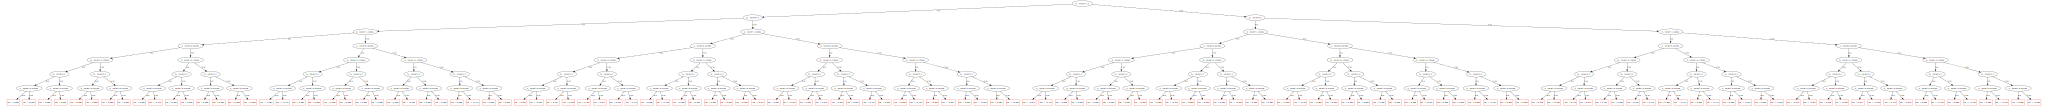

In [135]:
CB.plot_tree(tree_idx=0)

Проверим решение CatBoost

In [372]:
CB.calc_feature_statistics(X_b, target=y,
                        feature=num_list,
                        plot=True,
                        thread_count=-1)

{'productionDate': {'borders': array([-3.40282347e+38, -1.34502959e+00, -1.19845521e+00, -1.05188084e+00,
         -9.05306399e-01, -7.58731961e-01, -6.12157583e-01, -4.65583175e-01,
         -3.19008768e-01, -1.72434345e-01, -2.58599296e-02,  1.20714486e-01,
          2.67288893e-01,  4.13863301e-01,  5.60437679e-01,  7.07012117e-01,
          8.53586555e-01,  1.00016093e+00,  1.14673543e+00,  1.29330969e+00,
          1.43988419e+00,  1.58645868e+00,  1.73303294e+00,  1.87960744e+00,
          2.02618170e+00,  2.17275620e+00,  2.31933069e+00,  2.46590519e+00,
          2.61247945e+00,  2.75905371e+00,  2.90562820e+00,  3.05220270e+00,
          3.19877720e+00,  3.34535146e+00,  3.49192595e+00,  3.63850021e+00,
          3.78507471e+00,  3.93164921e+00,  4.07822323e+00,  4.22479820e+00,
          4.37137222e+00,  4.51794720e+00,  4.66452122e+00,  4.81109524e+00,
          4.95767021e+00], dtype=float32),
  'binarized_feature': array([30, 35, 32, ...,  7,  8,  7]),
  'mean_target': arr

Значимость признаков.

In [136]:
a = dict(zip(CB.feature_names_, CB.feature_importances_))
a = pd.DataFrame(a.items()).sort_values(1, ascending=True)
a

0      1
15      КомплектацияTrue  0.015
30   descriptionScoreLog  0.017
20                dealer  0.045
2                  color  0.045
13                   ПТС  0.047
26   description_claster  0.051
29      descriptionScore  0.055
21   description_neutral  0.066
11                  Руль  0.085
22  description_negative  0.093
28     descriptionLenLog  0.154
25    description_speech  0.221
24  description_positive  0.234
23      description_skip  0.234
27        descriptionLen  0.267
6    vehicleTransmission  0.518
32      production_delay  0.523
4          numberOfDoors  0.594
12             Владельцы  0.626
17         bodyTypeRough  0.823
0               bodyType  1.039
10                Привод  1.257
19       mileage_by_year  1.293
16               country  1.627
7     engineDisplacement  2.158
18      mileage_by_owner  2.308
14            model_name  2.635
3               fuelType  2.715
1                  brand  3.937
9                mileage  6.159
31             price_cut 16.300
8            enginePower 24.152
5         productionDate 29.708

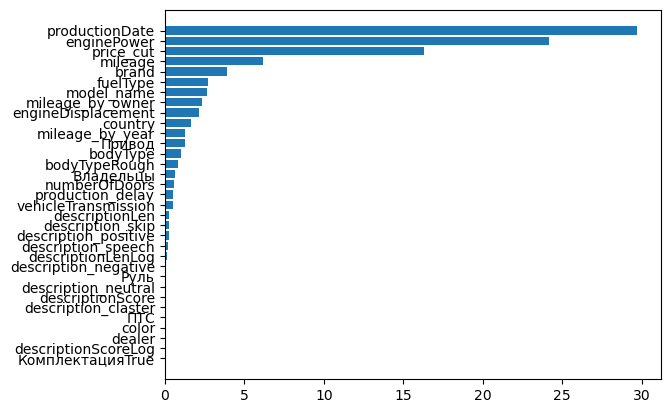

In [137]:
plt.rcdefaults()
fig, ax = plt.subplots()
ax.barh(a[0], a[1])
plt.show()

In [185]:
analize_df = X_b.copy()
analize_df = analize_df.join(np.exp(y))
analize_df = analize_df.join(pd.Series(np.exp(CB.predict(X_b)), name="predict"))
analize_df["error"] = np.abs(analize_df["price"] - analize_df["predict"])

In [189]:
analize_df.sort_values("error", ascending=False)[:100]

bodyType  brand  color  fuelType  numberOfDoors  productionDate  \
84775        16     21     13         0              3           2.393   
86141         6     21     15         0              1             NaN   
84453        16     21     15         0              3          -1.125   
84457        16     21     15         0              3          -1.125   
84458        16     21     15         0              3          -1.125   
54997        15     27     11         2              1          -0.685   
85665        11     21     15         3              4          -1.418   
85668        11     21     15         3              4          -1.272   
84669        16     21     15         0              3          -0.539   
84442        16     21     15         0              3          -0.832   
81378         3     21     12         0              2          -0.392   
84448        16     21     15         0              3          -1.418   
85911        11     21     15         3              3          -1.125   
86138        16     21      7         0              3             NaN   
85670        11     21     15         3              4          -1.272   
84473        16     21     15         0              3          -0.979   
85787        11     21     15         3              4          -1.272   
81654         2     21     15         0              4          -1.125   
85798        11     21     15         3              4          -0.979   
85786        11     21     15         3              4          -1.418   
85172        16     21     15         0              3          -0.685   
85781        11     21     12         3              4          -0.979   
84478        16     21     15         0              3          -0.832   
85117        16     21     15         0              3          -0.685   
11043         2      2     15         0              4          -1.272   
85917        11     21     15         3              3          -1.272   
84474        16     21     12         0              3          -1.125   
85663        15     21      7         0              1          -0.539   
84764        16     21     15         0              3          -0.539   
81631         2     21     15         0              4          -1.418   
11153         2      2     15         0              4          -1.272   
11067         2      2     15         0              4          -0.832   
82734         2     21      1         3              4          -1.125   
85688        11     21     15         3              4          -1.418   
85744        11     21     15         3              4          -1.418   
81457         2     21     15         0              4          -0.246   
31822         2     16      7         0              4          -1.125   
85608        15     21      1         0              1          -1.272   
84418         2     21     15         0              4          -1.418   
11156         2      2     15         0              4          -1.272   
81402         2     21     15         0              4          -0.832   
81511         2     21     15         0              4          -0.832   
11154         2      2     15         0              4          -1.272   
81437         2     21     15         0              4          -0.832   
64965        12     33     15         3              3          -0.832   
84465        16     21     15         0              3          -1.125   
67273        12     33     15         0              3          -0.832   
84455        16     21     12         0              3          -1.125   
84734         8     21     13         0              3           1.073   
79512         6     21      1         0              1          -0.246   
85689        11     21     15         3              4          -1.272   
7899         15      1     12         2              1          -1.272   
85694        11     21     15         3              4          -0.539   
31820      

Выполним обратное преобразование, чтобы понять, где алгоритм ошибся

In [197]:
analize_df = P_label.inverse_transform(analize_df)
analize_df = P_b.inverse_transform(analize_df)

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

In [210]:
analize_df[analize_df["model_name"] == "S_KLASSE" ].sort_values("error", ascending=False)[:100]

bodyType     brand        color fuelType  numberOfDoors  \
84775      седан  MERCEDES        синий   бензин          4.000   
84669      седан  MERCEDES       чёрный   бензин          4.000   
85172      седан  MERCEDES       чёрный   бензин          4.000   
85117      седан  MERCEDES       чёрный   бензин          4.000   
84764      седан  MERCEDES       чёрный   бензин          4.000   
84734    лимузин  MERCEDES        синий   бензин          4.000   
85104      седан  MERCEDES       чёрный   бензин          4.000   
85326      седан  MERCEDES       чёрный   бензин          4.000   
84840      седан  MERCEDES       чёрный   бензин          4.000   
84643      седан  MERCEDES       чёрный   бензин          4.000   
84704      седан  MERCEDES       чёрный   бензин          4.000   
84694      седан  MERCEDES       чёрный   бензин          4.000   
84685      седан  MERCEDES       чёрный   бензин          4.000   
84910      седан  MERCEDES       чёрный   бензин          4.000   
84864    лимузин  MERCEDES       чёрный   бензин          4.000   
84816      седан  MERCEDES       чёрный   бензин          4.000   
84955      седан  MERCEDES       чёрный   бензин          4.000   
84633      седан  MERCEDES       чёрный   бензин          4.000   
84815       купе  MERCEDES       чёрный   бензин          2.000   
85107      седан  MERCEDES       чёрный   бензин          4.000   
84699      седан  MERCEDES       чёрный   бензин          4.000   
84936      седан  MERCEDES        синий   дизель          4.000   
84991      седан  MERCEDES        белый   бензин          4.000   
84681      седан  MERCEDES        белый   бензин          4.000   
84705      седан  MERCEDES       чёрный   бензин          4.000   
84902  кабриолет  MERCEDES      зелёный   бензин          2.000   
85380      седан  MERCEDES       чёрный   бензин          4.000   
84673      седан  MERCEDES        синий   бензин          4.000   
85091      седан  MERCEDES        синий   бензин          4.000   
84660      седан  MERCEDES       чёрный   дизель          4.000   
84772      седан  MERCEDES       чёрный   дизель          4.000   
84762      седан  MERCEDES       чёрный   дизель          4.000   
84788      седан  MERCEDES       чёрный   дизель          4.000   
84768      седан  MERCEDES       чёрный   дизель          4.000   
84776      седан  MERCEDES       чёрный   дизель          4.000   
84784      седан  MERCEDES       чёрный   дизель          4.000   
85463      седан  MERCEDES       чёрный   дизель          4.000   
84980    лимузин  MERCEDES       чёрный   бензин          4.000   
84857       купе  MERCEDES  серебристый   бензин          2.000   
84756      седан  MERCEDES       чёрный   бензин          4.000   
85226      седан  MERCEDES       чёрный   дизель          4.000   
85030       купе  MERCEDES       чёрный   бензин          2.000   
85327      седан  MERCEDES       чёрный   дизель          4.000   
84755      седан  MERCEDES       чёрный   бензин          4.000   
84856       купе  MERCEDES        синий   бензин          2.000   
85025      седан  MERCEDES       чёрный   бензин          4.000   
85017      седан  MERCEDES       чёрный   бензин          4.000   
85224      седан  MERCEDES       чёрный   бензин          4.000   
85208      седан  MERCEDES       чёрный   бензин          4.000   
85003      седан  MERCEDES       чёрный   бензин          4.000   
85162      седан  MERCEDES       чёрный   бензин          4.000   
85137       купе  MERCEDES       чёрный   бензин          2.000   
85019       купе  MERCEDES       чёрный   бензин          2.000   
84817      седан  MERCEDES       чёрный   дизель          4.000   
85079       купе  MERCEDES       чёрный   бензин          2.000   
85278      седан  MERCEDES       чёрный   бензин          4.000   
85222      седан  MERCEDES       чёрный   бензин          4.000   
84789      седан  MERCEDES       чёрный   дизель          4.000   
85220      седан  MERCEDES       чёрный   бензин       

Как видим, есть строки, в которых ничего не предвещало настолько ошибочных предсказаний. Попробуем отсечь выбросы:

In [223]:
not_outliers_mask = analize_df["error"] / analize_df["predict"] < 1.5
len(analize_df) - not_outliers_mask.sum()

95

In [202]:
set_train = set(analize_df.sort_values("error", ascending=False)[:100]["model_name"])

In [205]:
set_test = set(P_label.inverse_transform(X_sub_b)["model_name"])

  0%|          | 0/33 [00:00<?, ?it/s]

In [207]:
set_test.intersection(set_train)

{'7ER',
 'A8',
 'C_KLASSE_AMG',
 'GLE_KLASSE',
 'GLE_KLASSE_COUPE_AMG',
 'GS',
 'G_KLASSE',
 'G_KLASSE_AMG',
 'HILUX',
 'I8',
 'LAND_CRUISER',
 'LX',
 'MAYBACH_GLS',
 'MEGA_CRUISER',
 'SLR_KLASSE',
 'SLS_AMG',
 'SL_KLASSE_AMG',
 'S_CLASS_MAYBACH',
 'S_KLASSE',
 'TUNDRA',
 'VITO',
 'V_KLASSE',
 'W111',
 'W136',
 'W186',
 'W188',
 'X_KLASSE'}

In [258]:
CB = CatBoostRegressor(**best_params,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['MAE'],
                          task_type = "CPU",
                          silent=True
                         )
CB.fit(X_b[not_outliers_mask], y[not_outliers_mask],
         verbose_eval=0,
         use_best_model=True,
         plot=True
         )
CB.save_model('catboost_single_model.model')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

You should provide test set for use best model. use_best_model parameter has been switched to false value.


In [227]:
mape_exp(CB.predict(X_b), y)

0.12274936748975149

In [226]:
mape_exp(CB.predict(X_b[not_outliers_mask]), y[not_outliers_mask])

0.11900038325168108

Улучшение составило 0.3%

# Отбор признаков

Проведём эксперимент на количество используемых признаков и отброс шумовых из них

In [259]:
a = dict(zip(CB.feature_names_, CB.feature_importances_))
a = pd.DataFrame(a.items()).sort_values(1, ascending=False)
n = len(a)
n

33

In [260]:
experiment_df = pd.DataFrame(columns = ["n", "iter_cv", "features", "mape_train", "mape_valid"])
while n>2:
    print("n=", n)
    a = dict(zip(CB.feature_names_, CB.feature_importances_))
    a = pd.DataFrame(a.items()).sort_values(1, ascending=False)[:n]

    kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

    iter_cv = 1
    cat_list_cut = [i for i in cat_list if i in a[0].values]
    X = X_b[a[0].values]
    for train_index, valid_index in tqdm_notebook( kf.split(X) ):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]

        CB.fit(X_train,y_train, 
                  eval_set=(X_valid, y_valid), cat_features=cat_list_cut,verbose=150, use_best_model=True)
        
        #Введём предсказания на train для детекции переобучения        
        y_pred_train = CB.predict(X_train)
        y_pred_valid = CB.predict(X_valid)
        
        experiment_df.loc[len(experiment_df.index)] = [n, iter_cv, a[0].values, mape_exp(y_train, y_pred_train), 
                                                       mape_exp(y_valid, y_pred_valid)]
        iter_cv +=1
    n -= 1

n= 33


0it [00:00, ?it/s]

0:	learn: 0.0559759	test: 0.0556821	best: 0.0556821 (0)	total: 193ms	remaining: 2m 15s
150:	learn: 0.0107682	test: 0.0109289	best: 0.0109289 (150)	total: 33s	remaining: 1m 59s
300:	learn: 0.0099182	test: 0.0102305	best: 0.0102305 (300)	total: 1m 7s	remaining: 1m 29s
450:	learn: 0.0095139	test: 0.0099331	best: 0.0099331 (450)	total: 1m 42s	remaining: 56.7s
600:	learn: 0.0092507	test: 0.0097720	best: 0.0097720 (600)	total: 2m 18s	remaining: 22.8s
699:	learn: 0.0091049	test: 0.0096753	best: 0.0096752 (697)	total: 2m 42s	remaining: 0us

bestTest = 0.009675162194
bestIteration = 697

Shrink model to first 698 iterations.
0:	learn: 0.0558496	test: 0.0564059	best: 0.0564059 (0)	total: 212ms	remaining: 2m 28s
150:	learn: 0.0109582	test: 0.0112144	best: 0.0112144 (150)	total: 33.6s	remaining: 2m 2s
300:	learn: 0.0099392	test: 0.0103489	best: 0.0103489 (300)	total: 1m 9s	remaining: 1m 32s
450:	learn: 0.0095852	test: 0.0100622	best: 0.0100622 (449)	total: 1m 46s	remaining: 59s
600:	learn: 0.00938

0it [00:00, ?it/s]

0:	learn: 0.0558602	test: 0.0555186	best: 0.0555186 (0)	total: 204ms	remaining: 2m 22s
150:	learn: 0.0108534	test: 0.0109758	best: 0.0109758 (150)	total: 34.6s	remaining: 2m 5s
300:	learn: 0.0099573	test: 0.0102506	best: 0.0102506 (300)	total: 1m 11s	remaining: 1m 34s
450:	learn: 0.0095184	test: 0.0099192	best: 0.0099192 (450)	total: 1m 48s	remaining: 59.8s
600:	learn: 0.0092149	test: 0.0097187	best: 0.0097187 (600)	total: 2m 25s	remaining: 24s
699:	learn: 0.0090680	test: 0.0096393	best: 0.0096393 (699)	total: 2m 50s	remaining: 0us

bestTest = 0.009639259273
bestIteration = 699

0:	learn: 0.0557258	test: 0.0562930	best: 0.0562930 (0)	total: 196ms	remaining: 2m 17s
150:	learn: 0.0109751	test: 0.0111794	best: 0.0111794 (150)	total: 33.7s	remaining: 2m 2s
300:	learn: 0.0100166	test: 0.0103636	best: 0.0103636 (300)	total: 1m 9s	remaining: 1m 32s
450:	learn: 0.0096582	test: 0.0101030	best: 0.0101030 (450)	total: 1m 45s	remaining: 58.5s
600:	learn: 0.0093875	test: 0.0099233	best: 0.0099221 (

0it [00:00, ?it/s]

0:	learn: 0.0559455	test: 0.0556394	best: 0.0556394 (0)	total: 196ms	remaining: 2m 17s
150:	learn: 0.0107642	test: 0.0109120	best: 0.0109120 (150)	total: 33.8s	remaining: 2m 3s
300:	learn: 0.0098897	test: 0.0101848	best: 0.0101846 (299)	total: 1m 8s	remaining: 1m 30s
450:	learn: 0.0095518	test: 0.0099574	best: 0.0099573 (449)	total: 1m 45s	remaining: 58.1s
600:	learn: 0.0093283	test: 0.0098124	best: 0.0098124 (600)	total: 2m 21s	remaining: 23.4s
699:	learn: 0.0091652	test: 0.0097075	best: 0.0097075 (698)	total: 2m 45s	remaining: 0us

bestTest = 0.009707535626
bestIteration = 698

Shrink model to first 699 iterations.
0:	learn: 0.0558115	test: 0.0563579	best: 0.0563579 (0)	total: 194ms	remaining: 2m 15s
150:	learn: 0.0110051	test: 0.0111935	best: 0.0111935 (150)	total: 32.9s	remaining: 1m 59s
300:	learn: 0.0101160	test: 0.0104541	best: 0.0104540 (298)	total: 1m 7s	remaining: 1m 29s
450:	learn: 0.0096770	test: 0.0101170	best: 0.0101170 (449)	total: 1m 43s	remaining: 57.2s
600:	learn: 0.0

0it [00:00, ?it/s]

0:	learn: 0.0560048	test: 0.0557018	best: 0.0557018 (0)	total: 201ms	remaining: 2m 20s
150:	learn: 0.0107195	test: 0.0108606	best: 0.0108606 (150)	total: 35s	remaining: 2m 7s
300:	learn: 0.0098762	test: 0.0101489	best: 0.0101489 (300)	total: 1m 11s	remaining: 1m 35s
450:	learn: 0.0094996	test: 0.0098732	best: 0.0098722 (447)	total: 1m 49s	remaining: 1m
600:	learn: 0.0092720	test: 0.0097344	best: 0.0097344 (600)	total: 2m 26s	remaining: 24.1s
699:	learn: 0.0091593	test: 0.0096626	best: 0.0096626 (699)	total: 2m 51s	remaining: 0us

bestTest = 0.009662609519
bestIteration = 699

0:	learn: 0.0558759	test: 0.0564028	best: 0.0564028 (0)	total: 204ms	remaining: 2m 22s
150:	learn: 0.0110315	test: 0.0112874	best: 0.0112874 (150)	total: 35.8s	remaining: 2m 10s
300:	learn: 0.0101078	test: 0.0104871	best: 0.0104871 (300)	total: 1m 12s	remaining: 1m 36s
450:	learn: 0.0097330	test: 0.0102028	best: 0.0102028 (450)	total: 1m 50s	remaining: 1m
600:	learn: 0.0095206	test: 0.0100465	best: 0.0100461 (598)

0it [00:00, ?it/s]

0:	learn: 0.0559254	test: 0.0556202	best: 0.0556202 (0)	total: 202ms	remaining: 2m 21s
150:	learn: 0.0108049	test: 0.0109617	best: 0.0109617 (150)	total: 36.3s	remaining: 2m 11s
300:	learn: 0.0099101	test: 0.0102222	best: 0.0102222 (300)	total: 1m 12s	remaining: 1m 36s
450:	learn: 0.0095725	test: 0.0099754	best: 0.0099754 (450)	total: 1m 50s	remaining: 1m
600:	learn: 0.0092845	test: 0.0097778	best: 0.0097778 (600)	total: 2m 30s	remaining: 24.7s
699:	learn: 0.0091249	test: 0.0096761	best: 0.0096757 (697)	total: 2m 58s	remaining: 0us

bestTest = 0.00967569942
bestIteration = 697

Shrink model to first 698 iterations.
0:	learn: 0.0557993	test: 0.0563412	best: 0.0563412 (0)	total: 222ms	remaining: 2m 35s
150:	learn: 0.0109747	test: 0.0111947	best: 0.0111947 (150)	total: 37.8s	remaining: 2m 17s
300:	learn: 0.0100053	test: 0.0103799	best: 0.0103799 (300)	total: 1m 14s	remaining: 1m 38s
450:	learn: 0.0096412	test: 0.0101069	best: 0.0101069 (450)	total: 1m 53s	remaining: 1m 2s
600:	learn: 0.00

0it [00:00, ?it/s]

0:	learn: 0.0559141	test: 0.0556222	best: 0.0556222 (0)	total: 210ms	remaining: 2m 27s
150:	learn: 0.0107258	test: 0.0109108	best: 0.0109108 (150)	total: 31.9s	remaining: 1m 56s
300:	learn: 0.0098961	test: 0.0102081	best: 0.0102079 (299)	total: 1m 5s	remaining: 1m 27s
450:	learn: 0.0095354	test: 0.0099345	best: 0.0099345 (450)	total: 1m 40s	remaining: 55.8s
600:	learn: 0.0092933	test: 0.0097807	best: 0.0097807 (600)	total: 2m 15s	remaining: 22.4s
699:	learn: 0.0092081	test: 0.0097397	best: 0.0097397 (696)	total: 2m 39s	remaining: 0us

bestTest = 0.009739667126
bestIteration = 696

Shrink model to first 697 iterations.
0:	learn: 0.0557837	test: 0.0563377	best: 0.0563377 (0)	total: 197ms	remaining: 2m 17s
150:	learn: 0.0111482	test: 0.0113270	best: 0.0113270 (150)	total: 32.4s	remaining: 1m 57s
300:	learn: 0.0102157	test: 0.0105279	best: 0.0105279 (300)	total: 1m 9s	remaining: 1m 32s
450:	learn: 0.0097679	test: 0.0101875	best: 0.0101875 (450)	total: 1m 44s	remaining: 57.9s
600:	learn: 0.

0it [00:00, ?it/s]

0:	learn: 0.0559601	test: 0.0556462	best: 0.0556462 (0)	total: 202ms	remaining: 2m 21s
150:	learn: 0.0108330	test: 0.0109653	best: 0.0109653 (150)	total: 31.6s	remaining: 1m 54s
300:	learn: 0.0099432	test: 0.0102290	best: 0.0102284 (299)	total: 1m 4s	remaining: 1m 25s
450:	learn: 0.0096011	test: 0.0099774	best: 0.0099774 (450)	total: 1m 38s	remaining: 54.5s
600:	learn: 0.0093935	test: 0.0098430	best: 0.0098430 (600)	total: 2m 12s	remaining: 21.9s
699:	learn: 0.0092818	test: 0.0097736	best: 0.0097735 (698)	total: 2m 35s	remaining: 0us

bestTest = 0.009773451827
bestIteration = 698

Shrink model to first 699 iterations.
0:	learn: 0.0558281	test: 0.0563736	best: 0.0563736 (0)	total: 189ms	remaining: 2m 11s
150:	learn: 0.0110112	test: 0.0112666	best: 0.0112666 (150)	total: 29.9s	remaining: 1m 48s
300:	learn: 0.0100502	test: 0.0104352	best: 0.0104352 (300)	total: 1m 1s	remaining: 1m 21s
450:	learn: 0.0097042	test: 0.0101878	best: 0.0101878 (450)	total: 1m 35s	remaining: 52.6s
600:	learn: 0.

0it [00:00, ?it/s]

0:	learn: 0.0559241	test: 0.0556208	best: 0.0556208 (0)	total: 201ms	remaining: 2m 20s
150:	learn: 0.0108169	test: 0.0109658	best: 0.0109658 (150)	total: 37.2s	remaining: 2m 15s
300:	learn: 0.0099167	test: 0.0102137	best: 0.0102137 (300)	total: 1m 14s	remaining: 1m 38s
450:	learn: 0.0095498	test: 0.0099404	best: 0.0099404 (450)	total: 1m 50s	remaining: 1m
600:	learn: 0.0093062	test: 0.0097803	best: 0.0097803 (600)	total: 2m 25s	remaining: 24s
699:	learn: 0.0091593	test: 0.0096906	best: 0.0096906 (699)	total: 2m 49s	remaining: 0us

bestTest = 0.009690554658
bestIteration = 699

0:	learn: 0.0558243	test: 0.0563721	best: 0.0563721 (0)	total: 251ms	remaining: 2m 55s
150:	learn: 0.0110310	test: 0.0112455	best: 0.0112455 (150)	total: 34.5s	remaining: 2m 5s
300:	learn: 0.0101456	test: 0.0105002	best: 0.0105002 (300)	total: 1m 12s	remaining: 1m 35s
450:	learn: 0.0097313	test: 0.0101799	best: 0.0101799 (450)	total: 1m 46s	remaining: 59s
600:	learn: 0.0095634	test: 0.0100848	best: 0.0100844 (598

0it [00:00, ?it/s]

0:	learn: 0.0559757	test: 0.0556633	best: 0.0556633 (0)	total: 184ms	remaining: 2m 8s
150:	learn: 0.0108214	test: 0.0109674	best: 0.0109674 (150)	total: 30.2s	remaining: 1m 49s
300:	learn: 0.0099638	test: 0.0102508	best: 0.0102508 (300)	total: 1m 2s	remaining: 1m 22s
450:	learn: 0.0096191	test: 0.0099974	best: 0.0099974 (450)	total: 1m 34s	remaining: 52.2s
600:	learn: 0.0093789	test: 0.0098288	best: 0.0098288 (600)	total: 2m 8s	remaining: 21.1s
699:	learn: 0.0092628	test: 0.0097657	best: 0.0097657 (699)	total: 2m 30s	remaining: 0us

bestTest = 0.009765674758
bestIteration = 699

0:	learn: 0.0557799	test: 0.0563231	best: 0.0563231 (0)	total: 179ms	remaining: 2m 5s
150:	learn: 0.0109600	test: 0.0111656	best: 0.0111655 (149)	total: 30.5s	remaining: 1m 50s
300:	learn: 0.0100908	test: 0.0104437	best: 0.0104437 (300)	total: 1m 1s	remaining: 1m 21s
450:	learn: 0.0097470	test: 0.0101797	best: 0.0101797 (450)	total: 1m 33s	remaining: 51.6s
600:	learn: 0.0094647	test: 0.0099836	best: 0.0099836 (

0it [00:00, ?it/s]

0:	learn: 0.0558517	test: 0.0555581	best: 0.0555581 (0)	total: 171ms	remaining: 1m 59s
150:	learn: 0.0107731	test: 0.0109701	best: 0.0109701 (150)	total: 34.4s	remaining: 2m 5s
300:	learn: 0.0099850	test: 0.0103177	best: 0.0103177 (300)	total: 1m 5s	remaining: 1m 26s
450:	learn: 0.0096054	test: 0.0100303	best: 0.0100302 (449)	total: 1m 35s	remaining: 52.9s
600:	learn: 0.0093516	test: 0.0098542	best: 0.0098542 (600)	total: 2m 11s	remaining: 21.6s
699:	learn: 0.0092397	test: 0.0097867	best: 0.0097867 (698)	total: 2m 32s	remaining: 0us

bestTest = 0.009786699966
bestIteration = 698

Shrink model to first 699 iterations.
0:	learn: 0.0557244	test: 0.0562741	best: 0.0562741 (0)	total: 183ms	remaining: 2m 8s
150:	learn: 0.0110016	test: 0.0112355	best: 0.0112355 (150)	total: 30.4s	remaining: 1m 50s
300:	learn: 0.0101438	test: 0.0105145	best: 0.0105145 (300)	total: 1m 2s	remaining: 1m 23s
450:	learn: 0.0097341	test: 0.0101998	best: 0.0101998 (450)	total: 1m 34s	remaining: 52.3s
600:	learn: 0.00

0it [00:00, ?it/s]

0:	learn: 0.0559924	test: 0.0556808	best: 0.0556808 (0)	total: 216ms	remaining: 2m 31s
150:	learn: 0.0107668	test: 0.0108843	best: 0.0108843 (150)	total: 29.3s	remaining: 1m 46s
300:	learn: 0.0099798	test: 0.0102370	best: 0.0102370 (300)	total: 1m	remaining: 1m 20s
450:	learn: 0.0096440	test: 0.0099845	best: 0.0099845 (450)	total: 1m 32s	remaining: 51s
600:	learn: 0.0094312	test: 0.0098563	best: 0.0098563 (600)	total: 2m 3s	remaining: 20.4s
699:	learn: 0.0092859	test: 0.0097650	best: 0.0097645 (696)	total: 2m 24s	remaining: 0us

bestTest = 0.009764477788
bestIteration = 696

Shrink model to first 697 iterations.
0:	learn: 0.0558615	test: 0.0564106	best: 0.0564106 (0)	total: 212ms	remaining: 2m 28s
150:	learn: 0.0110092	test: 0.0112158	best: 0.0112158 (150)	total: 30.6s	remaining: 1m 51s
300:	learn: 0.0101215	test: 0.0104648	best: 0.0104648 (300)	total: 1m 1s	remaining: 1m 20s
450:	learn: 0.0097948	test: 0.0102133	best: 0.0102133 (450)	total: 1m 32s	remaining: 51s
600:	learn: 0.0095850	

0it [00:00, ?it/s]

0:	learn: 0.0559014	test: 0.0556044	best: 0.0556044 (0)	total: 175ms	remaining: 2m 2s
150:	learn: 0.0108316	test: 0.0109504	best: 0.0109504 (150)	total: 30.1s	remaining: 1m 49s
300:	learn: 0.0099970	test: 0.0102734	best: 0.0102734 (300)	total: 1m 2s	remaining: 1m 22s
450:	learn: 0.0095817	test: 0.0099646	best: 0.0099646 (450)	total: 1m 36s	remaining: 53.2s
600:	learn: 0.0093254	test: 0.0097745	best: 0.0097745 (600)	total: 2m 9s	remaining: 21.4s
699:	learn: 0.0092202	test: 0.0097232	best: 0.0097232 (699)	total: 2m 29s	remaining: 0us

bestTest = 0.00972322888
bestIteration = 699

0:	learn: 0.0557680	test: 0.0562972	best: 0.0562972 (0)	total: 181ms	remaining: 2m 6s
150:	learn: 0.0109628	test: 0.0112354	best: 0.0112354 (150)	total: 27.8s	remaining: 1m 41s
300:	learn: 0.0101085	test: 0.0104698	best: 0.0104698 (300)	total: 58s	remaining: 1m 16s
450:	learn: 0.0097315	test: 0.0101746	best: 0.0101746 (450)	total: 1m 30s	remaining: 49.9s
600:	learn: 0.0095281	test: 0.0100362	best: 0.0100362 (600

0it [00:00, ?it/s]

0:	learn: 0.0559139	test: 0.0556426	best: 0.0556426 (0)	total: 162ms	remaining: 1m 52s
150:	learn: 0.0108249	test: 0.0109848	best: 0.0109848 (150)	total: 26.7s	remaining: 1m 37s
300:	learn: 0.0100975	test: 0.0103715	best: 0.0103715 (300)	total: 54.4s	remaining: 1m 12s
450:	learn: 0.0097041	test: 0.0100774	best: 0.0100774 (450)	total: 1m 23s	remaining: 45.9s
600:	learn: 0.0095059	test: 0.0099401	best: 0.0099401 (600)	total: 1m 51s	remaining: 18.4s
699:	learn: 0.0093849	test: 0.0098476	best: 0.0098476 (699)	total: 2m 10s	remaining: 0us

bestTest = 0.009847625773
bestIteration = 699

0:	learn: 0.0557786	test: 0.0563453	best: 0.0563453 (0)	total: 166ms	remaining: 1m 55s
150:	learn: 0.0110153	test: 0.0112306	best: 0.0112306 (150)	total: 26.2s	remaining: 1m 35s
300:	learn: 0.0100989	test: 0.0104389	best: 0.0104384 (299)	total: 54.1s	remaining: 1m 11s
450:	learn: 0.0097841	test: 0.0102211	best: 0.0102211 (450)	total: 1m 22s	remaining: 45.3s
600:	learn: 0.0095843	test: 0.0100813	best: 0.010081

0it [00:00, ?it/s]

0:	learn: 0.0559823	test: 0.0556880	best: 0.0556880 (0)	total: 172ms	remaining: 2m
150:	learn: 0.0108508	test: 0.0110028	best: 0.0110028 (150)	total: 24.9s	remaining: 1m 30s
300:	learn: 0.0100567	test: 0.0103493	best: 0.0103493 (300)	total: 50.5s	remaining: 1m 6s
450:	learn: 0.0096702	test: 0.0100611	best: 0.0100611 (450)	total: 1m 17s	remaining: 42.8s
600:	learn: 0.0094323	test: 0.0098979	best: 0.0098979 (599)	total: 1m 44s	remaining: 17.2s
699:	learn: 0.0092901	test: 0.0098097	best: 0.0098097 (699)	total: 2m 1s	remaining: 0us

bestTest = 0.009809686871
bestIteration = 699

0:	learn: 0.0558119	test: 0.0563397	best: 0.0563397 (0)	total: 151ms	remaining: 1m 45s
150:	learn: 0.0110308	test: 0.0112674	best: 0.0112674 (149)	total: 24.5s	remaining: 1m 29s
300:	learn: 0.0100907	test: 0.0104540	best: 0.0104540 (300)	total: 50.6s	remaining: 1m 7s
450:	learn: 0.0097118	test: 0.0101706	best: 0.0101706 (450)	total: 1m 16s	remaining: 42.5s
600:	learn: 0.0094508	test: 0.0099732	best: 0.0099732 (600)

0it [00:00, ?it/s]

0:	learn: 0.0559306	test: 0.0556487	best: 0.0556487 (0)	total: 151ms	remaining: 1m 45s
150:	learn: 0.0108442	test: 0.0110065	best: 0.0110065 (150)	total: 25.5s	remaining: 1m 32s
300:	learn: 0.0100266	test: 0.0103459	best: 0.0103459 (300)	total: 51.4s	remaining: 1m 8s
450:	learn: 0.0097053	test: 0.0101147	best: 0.0101147 (450)	total: 1m 17s	remaining: 43.1s
600:	learn: 0.0094961	test: 0.0099834	best: 0.0099831 (599)	total: 1m 44s	remaining: 17.1s
699:	learn: 0.0093852	test: 0.0099085	best: 0.0099082 (698)	total: 2m 1s	remaining: 0us

bestTest = 0.009908193646
bestIteration = 698

Shrink model to first 699 iterations.
0:	learn: 0.0558165	test: 0.0563313	best: 0.0563313 (0)	total: 150ms	remaining: 1m 44s
150:	learn: 0.0110431	test: 0.0112839	best: 0.0112839 (150)	total: 24s	remaining: 1m 27s
300:	learn: 0.0101133	test: 0.0104780	best: 0.0104780 (300)	total: 49.1s	remaining: 1m 5s
450:	learn: 0.0097447	test: 0.0101963	best: 0.0101963 (450)	total: 1m 15s	remaining: 41.5s
600:	learn: 0.00950

0it [00:00, ?it/s]

0:	learn: 0.0559498	test: 0.0556572	best: 0.0556572 (0)	total: 139ms	remaining: 1m 37s
150:	learn: 0.0107975	test: 0.0109008	best: 0.0109008 (150)	total: 24.6s	remaining: 1m 29s
300:	learn: 0.0100530	test: 0.0102818	best: 0.0102818 (300)	total: 50.5s	remaining: 1m 6s
450:	learn: 0.0097078	test: 0.0100291	best: 0.0100291 (450)	total: 1m 17s	remaining: 42.5s
600:	learn: 0.0094712	test: 0.0098757	best: 0.0098756 (599)	total: 1m 43s	remaining: 17s
699:	learn: 0.0093405	test: 0.0097946	best: 0.0097946 (699)	total: 2m	remaining: 0us

bestTest = 0.009794582378
bestIteration = 699

0:	learn: 0.0557292	test: 0.0562818	best: 0.0562818 (0)	total: 143ms	remaining: 1m 40s
150:	learn: 0.0110374	test: 0.0112661	best: 0.0112661 (150)	total: 24.7s	remaining: 1m 29s
300:	learn: 0.0101145	test: 0.0104668	best: 0.0104668 (300)	total: 49.7s	remaining: 1m 5s
450:	learn: 0.0097553	test: 0.0101955	best: 0.0101955 (450)	total: 1m 15s	remaining: 41.6s
600:	learn: 0.0095465	test: 0.0100676	best: 0.0100671 (594)	

0it [00:00, ?it/s]

0:	learn: 0.0559914	test: 0.0556868	best: 0.0556868 (0)	total: 137ms	remaining: 1m 36s
150:	learn: 0.0107259	test: 0.0109167	best: 0.0109167 (150)	total: 24.4s	remaining: 1m 28s
300:	learn: 0.0100117	test: 0.0103246	best: 0.0103246 (300)	total: 49.5s	remaining: 1m 5s
450:	learn: 0.0097341	test: 0.0101235	best: 0.0101235 (450)	total: 1m 15s	remaining: 41.6s
600:	learn: 0.0094929	test: 0.0099636	best: 0.0099636 (600)	total: 1m 41s	remaining: 16.8s
699:	learn: 0.0093692	test: 0.0098853	best: 0.0098853 (699)	total: 1m 59s	remaining: 0us

bestTest = 0.00988525696
bestIteration = 699

0:	learn: 0.0558634	test: 0.0564056	best: 0.0564056 (0)	total: 155ms	remaining: 1m 48s
150:	learn: 0.0110025	test: 0.0111791	best: 0.0111791 (150)	total: 24s	remaining: 1m 27s
300:	learn: 0.0101273	test: 0.0104352	best: 0.0104352 (300)	total: 48.5s	remaining: 1m 4s
450:	learn: 0.0098189	test: 0.0101986	best: 0.0101986 (448)	total: 1m 13s	remaining: 40.8s
600:	learn: 0.0096003	test: 0.0100442	best: 0.0100442 (60

0it [00:00, ?it/s]

0:	learn: 0.0559262	test: 0.0556328	best: 0.0556328 (0)	total: 138ms	remaining: 1m 36s
150:	learn: 0.0108302	test: 0.0109664	best: 0.0109664 (150)	total: 24.1s	remaining: 1m 27s
300:	learn: 0.0100674	test: 0.0103447	best: 0.0103447 (300)	total: 48.8s	remaining: 1m 4s
450:	learn: 0.0097620	test: 0.0101192	best: 0.0101192 (450)	total: 1m 13s	remaining: 40.8s
600:	learn: 0.0095108	test: 0.0099497	best: 0.0099497 (600)	total: 1m 39s	remaining: 16.3s
699:	learn: 0.0093807	test: 0.0098662	best: 0.0098662 (699)	total: 1m 55s	remaining: 0us

bestTest = 0.009866165544
bestIteration = 699

0:	learn: 0.0558021	test: 0.0563458	best: 0.0563458 (0)	total: 134ms	remaining: 1m 33s
150:	learn: 0.0110291	test: 0.0112241	best: 0.0112241 (150)	total: 23.7s	remaining: 1m 26s
300:	learn: 0.0101365	test: 0.0104330	best: 0.0104329 (299)	total: 48.3s	remaining: 1m 3s
450:	learn: 0.0098151	test: 0.0101870	best: 0.0101870 (450)	total: 1m 13s	remaining: 40.7s
600:	learn: 0.0096744	test: 0.0100998	best: 0.0100998 

0it [00:00, ?it/s]

0:	learn: 0.0559325	test: 0.0556173	best: 0.0556173 (0)	total: 140ms	remaining: 1m 37s
150:	learn: 0.0108920	test: 0.0110237	best: 0.0110237 (150)	total: 23.5s	remaining: 1m 25s
300:	learn: 0.0101860	test: 0.0104603	best: 0.0104603 (300)	total: 48.1s	remaining: 1m 3s
450:	learn: 0.0098486	test: 0.0102157	best: 0.0102157 (450)	total: 1m 13s	remaining: 40.8s
600:	learn: 0.0095709	test: 0.0100151	best: 0.0100151 (600)	total: 1m 38s	remaining: 16.3s
699:	learn: 0.0094399	test: 0.0099417	best: 0.0099417 (699)	total: 1m 55s	remaining: 0us

bestTest = 0.0099416792
bestIteration = 699

0:	learn: 0.0556370	test: 0.0561715	best: 0.0561715 (0)	total: 131ms	remaining: 1m 31s
150:	learn: 0.0109526	test: 0.0111511	best: 0.0111511 (150)	total: 23.8s	remaining: 1m 26s
300:	learn: 0.0102722	test: 0.0105805	best: 0.0105805 (300)	total: 49s	remaining: 1m 5s
450:	learn: 0.0099512	test: 0.0103425	best: 0.0103425 (450)	total: 1m 14s	remaining: 40.9s
600:	learn: 0.0097600	test: 0.0102186	best: 0.0102186 (600

0it [00:00, ?it/s]

0:	learn: 0.0561827	test: 0.0559115	best: 0.0559115 (0)	total: 161ms	remaining: 1m 52s
150:	learn: 0.0109255	test: 0.0110361	best: 0.0110361 (150)	total: 23s	remaining: 1m 23s
300:	learn: 0.0101966	test: 0.0104430	best: 0.0104430 (300)	total: 47.1s	remaining: 1m 2s
450:	learn: 0.0098513	test: 0.0102029	best: 0.0102029 (450)	total: 1m 11s	remaining: 39.5s
600:	learn: 0.0096418	test: 0.0100718	best: 0.0100718 (600)	total: 1m 36s	remaining: 15.9s
699:	learn: 0.0095411	test: 0.0100089	best: 0.0100084 (698)	total: 1m 52s	remaining: 0us

bestTest = 0.01000844814
bestIteration = 698

Shrink model to first 699 iterations.
0:	learn: 0.0559216	test: 0.0564914	best: 0.0564914 (0)	total: 155ms	remaining: 1m 48s
150:	learn: 0.0110222	test: 0.0111773	best: 0.0111773 (150)	total: 23.5s	remaining: 1m 25s
300:	learn: 0.0102658	test: 0.0105451	best: 0.0105451 (300)	total: 48s	remaining: 1m 3s
450:	learn: 0.0099341	test: 0.0103010	best: 0.0103010 (450)	total: 1m 13s	remaining: 40.5s
600:	learn: 0.0096947

0it [00:00, ?it/s]

0:	learn: 0.0559517	test: 0.0556639	best: 0.0556639 (0)	total: 134ms	remaining: 1m 33s
150:	learn: 0.0109299	test: 0.0110375	best: 0.0110375 (150)	total: 24s	remaining: 1m 27s
300:	learn: 0.0102884	test: 0.0105369	best: 0.0105367 (299)	total: 49.1s	remaining: 1m 5s
450:	learn: 0.0098937	test: 0.0102665	best: 0.0102665 (450)	total: 1m 14s	remaining: 40.9s
600:	learn: 0.0096714	test: 0.0101206	best: 0.0101206 (600)	total: 1m 39s	remaining: 16.4s
699:	learn: 0.0095336	test: 0.0100340	best: 0.0100340 (699)	total: 1m 56s	remaining: 0us

bestTest = 0.01003404324
bestIteration = 699

0:	learn: 0.0558300	test: 0.0563709	best: 0.0563709 (0)	total: 135ms	remaining: 1m 34s
150:	learn: 0.0111804	test: 0.0113536	best: 0.0113536 (150)	total: 21.9s	remaining: 1m 19s
300:	learn: 0.0103346	test: 0.0106065	best: 0.0106065 (300)	total: 46s	remaining: 1m
450:	learn: 0.0100418	test: 0.0103928	best: 0.0103926 (449)	total: 1m 10s	remaining: 38.9s
600:	learn: 0.0097663	test: 0.0102116	best: 0.0102116 (600)	to

0it [00:00, ?it/s]

0:	learn: 0.0558110	test: 0.0554888	best: 0.0554888 (0)	total: 119ms	remaining: 1m 23s
150:	learn: 0.0109524	test: 0.0110741	best: 0.0110741 (150)	total: 21.5s	remaining: 1m 18s
300:	learn: 0.0103235	test: 0.0105956	best: 0.0105956 (300)	total: 43.9s	remaining: 58.2s
450:	learn: 0.0099540	test: 0.0103276	best: 0.0103276 (450)	total: 1m 6s	remaining: 36.6s
600:	learn: 0.0097316	test: 0.0101819	best: 0.0101818 (599)	total: 1m 28s	remaining: 14.7s
699:	learn: 0.0095971	test: 0.0100894	best: 0.0100894 (699)	total: 1m 43s	remaining: 0us

bestTest = 0.01008935171
bestIteration = 699

0:	learn: 0.0556876	test: 0.0562343	best: 0.0562343 (0)	total: 123ms	remaining: 1m 25s
150:	learn: 0.0111331	test: 0.0112812	best: 0.0112812 (150)	total: 21.3s	remaining: 1m 17s
300:	learn: 0.0103814	test: 0.0106362	best: 0.0106362 (300)	total: 43.8s	remaining: 58.1s
450:	learn: 0.0100673	test: 0.0104025	best: 0.0104025 (450)	total: 1m 5s	remaining: 36.4s
600:	learn: 0.0098720	test: 0.0102664	best: 0.0102664 (60

0it [00:00, ?it/s]

0:	learn: 0.0559283	test: 0.0556480	best: 0.0556480 (0)	total: 113ms	remaining: 1m 19s
150:	learn: 0.0110755	test: 0.0112085	best: 0.0112085 (150)	total: 19s	remaining: 1m 9s
300:	learn: 0.0103637	test: 0.0106101	best: 0.0106101 (300)	total: 38.9s	remaining: 51.6s
450:	learn: 0.0100690	test: 0.0104043	best: 0.0104043 (450)	total: 59.3s	remaining: 32.7s
600:	learn: 0.0098105	test: 0.0102514	best: 0.0102514 (600)	total: 1m 19s	remaining: 13.1s
699:	learn: 0.0097015	test: 0.0101864	best: 0.0101864 (699)	total: 1m 33s	remaining: 0us

bestTest = 0.01018638489
bestIteration = 699

0:	learn: 0.0557482	test: 0.0562964	best: 0.0562964 (0)	total: 134ms	remaining: 1m 33s
150:	learn: 0.0112897	test: 0.0114814	best: 0.0114814 (150)	total: 17.9s	remaining: 1m 4s
300:	learn: 0.0105356	test: 0.0107914	best: 0.0107914 (300)	total: 37.8s	remaining: 50.1s
450:	learn: 0.0101818	test: 0.0105088	best: 0.0105087 (449)	total: 57.6s	remaining: 31.8s
600:	learn: 0.0099914	test: 0.0103867	best: 0.0103867 (600)	t

0it [00:00, ?it/s]

0:	learn: 0.0558814	test: 0.0555807	best: 0.0555807 (0)	total: 103ms	remaining: 1m 11s
150:	learn: 0.0111466	test: 0.0112925	best: 0.0112925 (150)	total: 16.8s	remaining: 1m 1s
300:	learn: 0.0104424	test: 0.0107079	best: 0.0107079 (300)	total: 34.3s	remaining: 45.5s
450:	learn: 0.0100545	test: 0.0104193	best: 0.0104193 (450)	total: 52.2s	remaining: 28.8s
600:	learn: 0.0098070	test: 0.0102530	best: 0.0102530 (600)	total: 1m 10s	remaining: 11.6s
699:	learn: 0.0096854	test: 0.0101777	best: 0.0101766 (698)	total: 1m 22s	remaining: 0us

bestTest = 0.01017664642
bestIteration = 698

Shrink model to first 699 iterations.
0:	learn: 0.0558161	test: 0.0563594	best: 0.0563594 (0)	total: 119ms	remaining: 1m 23s
150:	learn: 0.0112792	test: 0.0114514	best: 0.0114514 (150)	total: 16.9s	remaining: 1m 1s
300:	learn: 0.0105145	test: 0.0107995	best: 0.0107995 (300)	total: 33.9s	remaining: 45s
450:	learn: 0.0101838	test: 0.0105410	best: 0.0105410 (450)	total: 51.8s	remaining: 28.6s
600:	learn: 0.0099564	t

0it [00:00, ?it/s]

0:	learn: 0.0559658	test: 0.0556797	best: 0.0556797 (0)	total: 103ms	remaining: 1m 11s
150:	learn: 0.0115450	test: 0.0116868	best: 0.0116866 (149)	total: 14.3s	remaining: 52.2s
300:	learn: 0.0108106	test: 0.0111017	best: 0.0111017 (300)	total: 28.9s	remaining: 38.3s
450:	learn: 0.0105111	test: 0.0108791	best: 0.0108791 (450)	total: 43.6s	remaining: 24s
600:	learn: 0.0103079	test: 0.0107609	best: 0.0107609 (600)	total: 58.3s	remaining: 9.6s
699:	learn: 0.0101580	test: 0.0106656	best: 0.0106656 (699)	total: 1m 8s	remaining: 0us

bestTest = 0.01066559994
bestIteration = 699

0:	learn: 0.0557327	test: 0.0562779	best: 0.0562779 (0)	total: 111ms	remaining: 1m 17s
150:	learn: 0.0116030	test: 0.0118048	best: 0.0118048 (150)	total: 14.2s	remaining: 51.8s
300:	learn: 0.0109023	test: 0.0112075	best: 0.0112075 (300)	total: 29.1s	remaining: 38.6s
450:	learn: 0.0105134	test: 0.0109162	best: 0.0109161 (449)	total: 44.3s	remaining: 24.5s
600:	learn: 0.0103262	test: 0.0107808	best: 0.0107808 (600)	tota

0it [00:00, ?it/s]

0:	learn: 0.0558958	test: 0.0556199	best: 0.0556199 (0)	total: 80ms	remaining: 56s
150:	learn: 0.0121125	test: 0.0122256	best: 0.0122256 (150)	total: 12.6s	remaining: 45.6s
300:	learn: 0.0115865	test: 0.0117743	best: 0.0117743 (300)	total: 25.1s	remaining: 33.3s
450:	learn: 0.0112358	test: 0.0114930	best: 0.0114930 (449)	total: 37.7s	remaining: 20.8s
600:	learn: 0.0109960	test: 0.0113250	best: 0.0113250 (600)	total: 50.5s	remaining: 8.32s
699:	learn: 0.0108941	test: 0.0112618	best: 0.0112618 (699)	total: 58.9s	remaining: 0us

bestTest = 0.01126181256
bestIteration = 699

0:	learn: 0.0558032	test: 0.0563489	best: 0.0563489 (0)	total: 83.6ms	remaining: 58.4s
150:	learn: 0.0121906	test: 0.0124939	best: 0.0124939 (150)	total: 12.3s	remaining: 44.6s
300:	learn: 0.0115121	test: 0.0119463	best: 0.0119463 (300)	total: 25.5s	remaining: 33.7s
450:	learn: 0.0112113	test: 0.0117163	best: 0.0117163 (450)	total: 38.1s	remaining: 21s
600:	learn: 0.0109951	test: 0.0115695	best: 0.0115690 (599)	total: 

0it [00:00, ?it/s]

0:	learn: 0.0558597	test: 0.0555756	best: 0.0555756 (0)	total: 70.8ms	remaining: 49.5s
150:	learn: 0.0121860	test: 0.0123426	best: 0.0123426 (150)	total: 11.1s	remaining: 40.2s
300:	learn: 0.0115110	test: 0.0117805	best: 0.0117805 (300)	total: 22s	remaining: 29.1s
450:	learn: 0.0111253	test: 0.0114763	best: 0.0114763 (450)	total: 32.9s	remaining: 18.2s
600:	learn: 0.0109526	test: 0.0113518	best: 0.0113518 (600)	total: 44s	remaining: 7.25s
699:	learn: 0.0109051	test: 0.0113216	best: 0.0113216 (699)	total: 51.3s	remaining: 0us

bestTest = 0.0113215892
bestIteration = 699

0:	learn: 0.0557722	test: 0.0563189	best: 0.0563189 (0)	total: 72.6ms	remaining: 50.8s
150:	learn: 0.0123448	test: 0.0126566	best: 0.0126566 (150)	total: 11.1s	remaining: 40.4s
300:	learn: 0.0115070	test: 0.0119252	best: 0.0119252 (300)	total: 22.1s	remaining: 29.3s
450:	learn: 0.0111894	test: 0.0116936	best: 0.0116934 (449)	total: 33.1s	remaining: 18.3s
600:	learn: 0.0109604	test: 0.0115359	best: 0.0115359 (600)	total:

0it [00:00, ?it/s]

0:	learn: 0.0560457	test: 0.0557421	best: 0.0557421 (0)	total: 72ms	remaining: 50.3s
150:	learn: 0.0122767	test: 0.0123920	best: 0.0123920 (150)	total: 10.7s	remaining: 38.9s
300:	learn: 0.0116627	test: 0.0118560	best: 0.0118560 (300)	total: 20.9s	remaining: 27.7s
450:	learn: 0.0113676	test: 0.0116409	best: 0.0116406 (448)	total: 31.2s	remaining: 17.2s
600:	learn: 0.0111052	test: 0.0114549	best: 0.0114549 (600)	total: 41.8s	remaining: 6.89s
699:	learn: 0.0109651	test: 0.0113428	best: 0.0113428 (699)	total: 48.9s	remaining: 0us

bestTest = 0.01134279333
bestIteration = 699

0:	learn: 0.0557531	test: 0.0562999	best: 0.0562999 (0)	total: 71.3ms	remaining: 49.9s
150:	learn: 0.0123368	test: 0.0125798	best: 0.0125798 (150)	total: 10.8s	remaining: 39.2s
300:	learn: 0.0116469	test: 0.0119856	best: 0.0119856 (300)	total: 21.2s	remaining: 28.1s
450:	learn: 0.0112826	test: 0.0117157	best: 0.0117143 (445)	total: 32.1s	remaining: 17.7s
600:	learn: 0.0110273	test: 0.0115210	best: 0.0115210 (600)	tot

0it [00:00, ?it/s]

0:	learn: 0.0558562	test: 0.0555856	best: 0.0555856 (0)	total: 64.5ms	remaining: 45.1s
150:	learn: 0.0131881	test: 0.0133491	best: 0.0133491 (150)	total: 9.2s	remaining: 33.4s
300:	learn: 0.0123108	test: 0.0125674	best: 0.0125674 (300)	total: 18.3s	remaining: 24.3s
450:	learn: 0.0118644	test: 0.0122093	best: 0.0122093 (450)	total: 27.7s	remaining: 15.3s
600:	learn: 0.0115596	test: 0.0119646	best: 0.0119646 (600)	total: 37s	remaining: 6.09s
699:	learn: 0.0114385	test: 0.0118770	best: 0.0118770 (699)	total: 43.1s	remaining: 0us

bestTest = 0.01187703219
bestIteration = 699

0:	learn: 0.0556834	test: 0.0562320	best: 0.0562320 (0)	total: 65ms	remaining: 45.5s
150:	learn: 0.0133005	test: 0.0135669	best: 0.0135669 (150)	total: 9.46s	remaining: 34.4s
300:	learn: 0.0123729	test: 0.0127458	best: 0.0127458 (300)	total: 18.6s	remaining: 24.7s
450:	learn: 0.0118506	test: 0.0123147	best: 0.0123147 (450)	total: 27.8s	remaining: 15.3s
600:	learn: 0.0115791	test: 0.0121125	best: 0.0121125 (597)	total:

0it [00:00, ?it/s]

0:	learn: 0.0558713	test: 0.0555756	best: 0.0555756 (0)	total: 64.9ms	remaining: 45.4s
150:	learn: 0.0137934	test: 0.0138197	best: 0.0138197 (150)	total: 9.09s	remaining: 33s
300:	learn: 0.0129747	test: 0.0130652	best: 0.0130652 (300)	total: 18s	remaining: 23.9s
450:	learn: 0.0126179	test: 0.0127711	best: 0.0127711 (450)	total: 26.9s	remaining: 14.8s
600:	learn: 0.0124517	test: 0.0126228	best: 0.0126228 (598)	total: 35.8s	remaining: 5.9s
699:	learn: 0.0123588	test: 0.0125504	best: 0.0125504 (699)	total: 41.7s	remaining: 0us

bestTest = 0.0125503808
bestIteration = 699

0:	learn: 0.0557699	test: 0.0563148	best: 0.0563148 (0)	total: 64.2ms	remaining: 44.9s
150:	learn: 0.0139034	test: 0.0141194	best: 0.0141194 (150)	total: 9.05s	remaining: 32.9s
300:	learn: 0.0130681	test: 0.0133522	best: 0.0133522 (300)	total: 17.9s	remaining: 23.7s
450:	learn: 0.0126997	test: 0.0130165	best: 0.0130165 (450)	total: 26.7s	remaining: 14.8s
600:	learn: 0.0125148	test: 0.0128521	best: 0.0128521 (600)	total: 

0it [00:00, ?it/s]

0:	learn: 0.0558650	test: 0.0555737	best: 0.0555737 (0)	total: 30.1ms	remaining: 21.1s
150:	learn: 0.0156358	test: 0.0157465	best: 0.0157465 (150)	total: 4.11s	remaining: 14.9s
300:	learn: 0.0151126	test: 0.0152467	best: 0.0152467 (300)	total: 8.08s	remaining: 10.7s
450:	learn: 0.0147341	test: 0.0149066	best: 0.0149066 (450)	total: 12s	remaining: 6.65s
600:	learn: 0.0145203	test: 0.0147222	best: 0.0147221 (599)	total: 16s	remaining: 2.64s
699:	learn: 0.0143978	test: 0.0146182	best: 0.0146175 (696)	total: 18.7s	remaining: 0us

bestTest = 0.01461747493
bestIteration = 696

Shrink model to first 697 iterations.
0:	learn: 0.0557376	test: 0.0562876	best: 0.0562876 (0)	total: 30.3ms	remaining: 21.2s
150:	learn: 0.0155426	test: 0.0157202	best: 0.0157202 (150)	total: 4.37s	remaining: 15.9s
300:	learn: 0.0149874	test: 0.0152026	best: 0.0152026 (300)	total: 8.53s	remaining: 11.3s
450:	learn: 0.0146474	test: 0.0149072	best: 0.0149072 (450)	total: 12.7s	remaining: 7s
600:	learn: 0.0144211	test: 0.

In [267]:
experiment_df

n iter_cv                                           features  \
0    33       1  [productionDate, enginePower, price_cut, milea...   
1    33       2  [productionDate, enginePower, price_cut, milea...   
2    33       3  [productionDate, enginePower, price_cut, milea...   
3    33       4  [productionDate, enginePower, price_cut, milea...   
4    33       5  [productionDate, enginePower, price_cut, milea...   
..   ..     ...                                                ...   
150   3       1           [productionDate, enginePower, price_cut]   
151   3       2           [productionDate, enginePower, price_cut]   
152   3       3           [productionDate, enginePower, price_cut]   
153   3       4           [productionDate, enginePower, price_cut]   
154   3       5           [productionDate, enginePower, price_cut]   

     mape_train  mape_valid  
0         0.121       0.130  
1         0.124       0.132  
2         0.124       0.134  
3         0.123       0.130  
4         0.122       0.131  
..          ...         ...  
150       0.195       0.199  
151       0.194       0.198  
152       0.196       0.201  
153       0.195       0.200  
154       0.193       0.198  

[155 rows x 5 columns]

In [266]:
GB = experiment_df.groupby("n")

In [270]:
GB["mape_train"].mean().index

Int64Index([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
            20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33],
           dtype='int64', name='n')

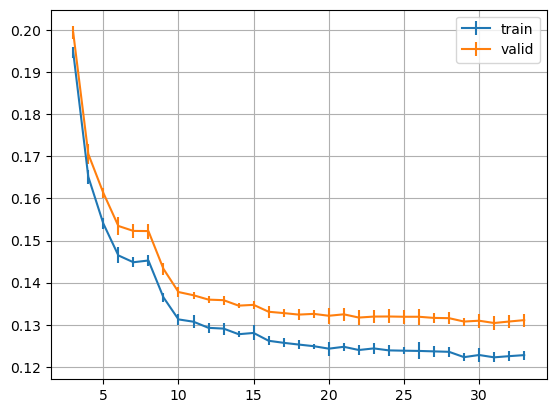

In [274]:
plt.errorbar(GB["mape_train"].mean().index, GB["mape_train"].mean(), yerr=GB["mape_train"].std(), label='train')
plt.errorbar(GB["mape_valid"].mean().index, GB["mape_valid"].mean(), yerr=GB["mape_valid"].std(), label='valid')
plt.grid()
plt.legend()

Наилучшую метрику дают число фичей=31

In [280]:
new_ft = experiment_df[experiment_df["n"] == 31].features.values[0]

In [281]:
cat_list_cut = [i for i in cat_list if i in new_ft]

In [282]:
CB.fit(X_b[new_ft],y, cat_features=cat_list_cut,verbose=150, use_best_model=True)

You should provide test set for use best model. use_best_model parameter has been switched to false value.


0:	learn: 0.0558611	total: 251ms	remaining: 2m 55s
150:	learn: 0.0108547	total: 35.4s	remaining: 2m 8s
300:	learn: 0.0099431	total: 1m 13s	remaining: 1m 36s
450:	learn: 0.0095861	total: 1m 51s	remaining: 1m 1s
600:	learn: 0.0093778	total: 2m 30s	remaining: 24.8s
699:	learn: 0.0092537	total: 2m 55s	remaining: 0us


In [283]:
# оцениваем точность
predict = CB.predict(X_b[new_ft])
print(f"Точность модели по метрике MAPE: {(mape_exp(y, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 12.27%


In [284]:
y_sub_cb = CB.predict(X_sub_b)

 # XGBoost

In [146]:
#pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [148]:
def cv_XG(model, X, y):
    
    kf = KFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)
    # кросс-валидация на 3 выборках, так как на 5 время расчётов выше
    mape_train = []
    mape_valid = []
    for train_index, valid_index in tqdm_notebook(kf.split(X)):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]

        model.fit(X_train,y_train)
        
        #Введём предсказания на train для детекции переобучения        
        y_pred_train = model.predict(X_train)
        y_pred_valid = model.predict(X_valid)
        
        mape_train.append(mape_exp(y_train, y_pred_train))
        mape_valid.append(mape_exp(y_valid, y_pred_valid))
    
    mape_train = np.array(mape_train)
    mape_valid = np.array(mape_valid)
    # минимизируем абсолютную ошибку и разницу между валидационной и обучающей выборкой,
    # получим множество Паретто
    return np.mean(mape_valid), np.mean(np.abs(mape_valid - mape_train))

In [165]:
def objective_XG(trial):
    param = {
        "max_depth": trial.suggest_int("max_depth",2,50,1),
        "n_estimators": trial.suggest_int("n_estimators", 100,1000,step=10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01,0.2, step=0.01),
        "eta": trial.suggest_float("eta", 0,1.0,step=0.01),
        "gamma": trial.suggest_float("gamma", 0,10, step=0.1),
        "min_child_weight": trial.suggest_int("min_child_weight", 0,10),
        "max_delta_step": trial.suggest_int("max_delta_step", 0,10),
        "subsample": trial.suggest_float('subsample',0.5,1.0, step=0.1),
        "reg_lambda": trial.suggest_int("reg_lambda", 0,1000,step=100),
        "reg_alpha": trial.suggest_int('reg_alpha', 0,100, step=100)
    }
    
    print(param)
    
    model = xgb.XGBRegressor(**param, booster='gbtree',objective="reg:squarederror", nthread=-1,
       silent=None, verbosity=1, seed = RANDOM_SEED)
    
    preds = cv_XG(model, X_lin, y)  
    print(preds)    
    return preds[0] + preds[1]

In [167]:
study_XG = optuna.create_study()
study_XG.optimize(objective_XG, n_trials=100)

[I 2022-04-29 13:54:26,112] A new study created in memory with name: no-name-8c9ed8f0-3e1c-454b-8baf-a4aba5b6bfec


{'max_depth': 30, 'n_estimators': 350, 'learning_rate': 0.17, 'eta': 0.5700000000000001, 'gamma': 8.0, 'min_child_weight': 2, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 900, 'reg_alpha': 100}


0it [00:00, ?it/s]

[I 2022-04-29 13:59:40,996] Trial 0 finished with value: 0.1937254969357502 and parameters: {'max_depth': 30, 'n_estimators': 350, 'learning_rate': 0.17, 'eta': 0.5700000000000001, 'gamma': 8.0, 'min_child_weight': 2, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 900, 'reg_alpha': 100}. Best is trial 0 with value: 0.1937254969357502.


(0.19241968981684887, 0.001305807118901316)
{'max_depth': 27, 'n_estimators': 780, 'learning_rate': 0.2, 'eta': 0.19, 'gamma': 5.4, 'min_child_weight': 2, 'max_delta_step': 0, 'subsample': 0.8, 'reg_lambda': 800, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-29 14:16:49,305] Trial 1 finished with value: 0.17981414165508655 and parameters: {'max_depth': 27, 'n_estimators': 780, 'learning_rate': 0.2, 'eta': 0.19, 'gamma': 5.4, 'min_child_weight': 2, 'max_delta_step': 0, 'subsample': 0.8, 'reg_lambda': 800, 'reg_alpha': 0}. Best is trial 1 with value: 0.17981414165508655.


(0.1778311950223516, 0.00198294663273497)
{'max_depth': 3, 'n_estimators': 270, 'learning_rate': 0.060000000000000005, 'eta': 0.29, 'gamma': 6.9, 'min_child_weight': 8, 'max_delta_step': 4, 'subsample': 0.8, 'reg_lambda': 400, 'reg_alpha': 100}


0it [00:00, ?it/s]

[I 2022-04-29 14:17:26,611] Trial 2 finished with value: 0.1938384903014724 and parameters: {'max_depth': 3, 'n_estimators': 270, 'learning_rate': 0.060000000000000005, 'eta': 0.29, 'gamma': 6.9, 'min_child_weight': 8, 'max_delta_step': 4, 'subsample': 0.8, 'reg_lambda': 400, 'reg_alpha': 100}. Best is trial 1 with value: 0.17981414165508655.


(0.19268471304363977, 0.0011537772578326388)
{'max_depth': 26, 'n_estimators': 310, 'learning_rate': 0.19, 'eta': 0.93, 'gamma': 0.7000000000000001, 'min_child_weight': 1, 'max_delta_step': 4, 'subsample': 1.0, 'reg_lambda': 200, 'reg_alpha': 100}


0it [00:00, ?it/s]

[I 2022-04-29 14:21:09,545] Trial 3 finished with value: 0.1665666455352844 and parameters: {'max_depth': 26, 'n_estimators': 310, 'learning_rate': 0.19, 'eta': 0.93, 'gamma': 0.7000000000000001, 'min_child_weight': 1, 'max_delta_step': 4, 'subsample': 1.0, 'reg_lambda': 200, 'reg_alpha': 100}. Best is trial 3 with value: 0.1665666455352844.


(0.1623687715602272, 0.004197873975057211)
{'max_depth': 23, 'n_estimators': 1000, 'learning_rate': 0.01, 'eta': 0.64, 'gamma': 3.6, 'min_child_weight': 1, 'max_delta_step': 3, 'subsample': 0.6, 'reg_lambda': 400, 'reg_alpha': 100}


0it [00:00, ?it/s]

[I 2022-04-29 14:28:57,223] Trial 4 finished with value: 0.18697135521410932 and parameters: {'max_depth': 23, 'n_estimators': 1000, 'learning_rate': 0.01, 'eta': 0.64, 'gamma': 3.6, 'min_child_weight': 1, 'max_delta_step': 3, 'subsample': 0.6, 'reg_lambda': 400, 'reg_alpha': 100}. Best is trial 3 with value: 0.1665666455352844.


(0.185425518355542, 0.001545836858567314)
{'max_depth': 19, 'n_estimators': 750, 'learning_rate': 0.05, 'eta': 0.61, 'gamma': 8.1, 'min_child_weight': 7, 'max_delta_step': 6, 'subsample': 0.7, 'reg_lambda': 200, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-29 14:39:29,094] Trial 5 finished with value: 0.18116359402789825 and parameters: {'max_depth': 19, 'n_estimators': 750, 'learning_rate': 0.05, 'eta': 0.61, 'gamma': 8.1, 'min_child_weight': 7, 'max_delta_step': 6, 'subsample': 0.7, 'reg_lambda': 200, 'reg_alpha': 0}. Best is trial 3 with value: 0.1665666455352844.


(0.17944107465145342, 0.0017225193764448161)
{'max_depth': 28, 'n_estimators': 440, 'learning_rate': 0.02, 'eta': 0.11, 'gamma': 0.9, 'min_child_weight': 7, 'max_delta_step': 4, 'subsample': 1.0, 'reg_lambda': 500, 'reg_alpha': 100}


0it [00:00, ?it/s]

[I 2022-04-29 14:42:52,260] Trial 6 finished with value: 0.174177917254013 and parameters: {'max_depth': 28, 'n_estimators': 440, 'learning_rate': 0.02, 'eta': 0.11, 'gamma': 0.9, 'min_child_weight': 7, 'max_delta_step': 4, 'subsample': 1.0, 'reg_lambda': 500, 'reg_alpha': 100}. Best is trial 3 with value: 0.1665666455352844.


(0.1711103097138956, 0.0030676075401174043)
{'max_depth': 25, 'n_estimators': 650, 'learning_rate': 0.02, 'eta': 0.43, 'gamma': 1.2000000000000002, 'min_child_weight': 10, 'max_delta_step': 9, 'subsample': 0.6, 'reg_lambda': 700, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-29 14:50:41,033] Trial 7 finished with value: 0.16541283315019598 and parameters: {'max_depth': 25, 'n_estimators': 650, 'learning_rate': 0.02, 'eta': 0.43, 'gamma': 1.2000000000000002, 'min_child_weight': 10, 'max_delta_step': 9, 'subsample': 0.6, 'reg_lambda': 700, 'reg_alpha': 0}. Best is trial 7 with value: 0.16541283315019598.


(0.1625116678055513, 0.002901165344644676)
{'max_depth': 29, 'n_estimators': 180, 'learning_rate': 0.14, 'eta': 0.15, 'gamma': 5.5, 'min_child_weight': 0, 'max_delta_step': 7, 'subsample': 0.8, 'reg_lambda': 900, 'reg_alpha': 100}


0it [00:00, ?it/s]

[I 2022-04-29 14:53:07,572] Trial 8 finished with value: 0.186933703832387 and parameters: {'max_depth': 29, 'n_estimators': 180, 'learning_rate': 0.14, 'eta': 0.15, 'gamma': 5.5, 'min_child_weight': 0, 'max_delta_step': 7, 'subsample': 0.8, 'reg_lambda': 900, 'reg_alpha': 100}. Best is trial 7 with value: 0.16541283315019598.


(0.18519107625299017, 0.0017426275793968233)
{'max_depth': 26, 'n_estimators': 260, 'learning_rate': 0.15000000000000002, 'eta': 0.88, 'gamma': 1.5, 'min_child_weight': 5, 'max_delta_step': 9, 'subsample': 0.5, 'reg_lambda': 700, 'reg_alpha': 100}


0it [00:00, ?it/s]

[I 2022-04-29 14:55:51,141] Trial 9 finished with value: 0.18074005914303837 and parameters: {'max_depth': 26, 'n_estimators': 260, 'learning_rate': 0.15000000000000002, 'eta': 0.88, 'gamma': 1.5, 'min_child_weight': 5, 'max_delta_step': 9, 'subsample': 0.5, 'reg_lambda': 700, 'reg_alpha': 100}. Best is trial 7 with value: 0.16541283315019598.


(0.17849726885848463, 0.002242790284553727)
{'max_depth': 48, 'n_estimators': 650, 'learning_rate': 0.09999999999999999, 'eta': 0.38, 'gamma': 3.0, 'min_child_weight': 10, 'max_delta_step': 10, 'subsample': 0.5, 'reg_lambda': 0, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-29 15:13:33,345] Trial 10 finished with value: 0.15630540768046985 and parameters: {'max_depth': 48, 'n_estimators': 650, 'learning_rate': 0.09999999999999999, 'eta': 0.38, 'gamma': 3.0, 'min_child_weight': 10, 'max_delta_step': 10, 'subsample': 0.5, 'reg_lambda': 0, 'reg_alpha': 0}. Best is trial 10 with value: 0.15630540768046985.


(0.148096936664643, 0.008208471015826871)
{'max_depth': 50, 'n_estimators': 640, 'learning_rate': 0.09999999999999999, 'eta': 0.4, 'gamma': 3.2, 'min_child_weight': 10, 'max_delta_step': 10, 'subsample': 0.5, 'reg_lambda': 0, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-29 15:31:25,212] Trial 11 finished with value: 0.15734495180224276 and parameters: {'max_depth': 50, 'n_estimators': 640, 'learning_rate': 0.09999999999999999, 'eta': 0.4, 'gamma': 3.2, 'min_child_weight': 10, 'max_delta_step': 10, 'subsample': 0.5, 'reg_lambda': 0, 'reg_alpha': 0}. Best is trial 10 with value: 0.15630540768046985.


(0.1496015741280949, 0.007743377674147854)
{'max_depth': 48, 'n_estimators': 530, 'learning_rate': 0.09999999999999999, 'eta': 0.38, 'gamma': 3.6, 'min_child_weight': 10, 'max_delta_step': 10, 'subsample': 0.5, 'reg_lambda': 0, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-29 15:45:34,445] Trial 12 finished with value: 0.1584450374563113 and parameters: {'max_depth': 48, 'n_estimators': 530, 'learning_rate': 0.09999999999999999, 'eta': 0.38, 'gamma': 3.6, 'min_child_weight': 10, 'max_delta_step': 10, 'subsample': 0.5, 'reg_lambda': 0, 'reg_alpha': 0}. Best is trial 10 with value: 0.15630540768046985.


(0.15161043787049336, 0.006834599585817956)
{'max_depth': 50, 'n_estimators': 870, 'learning_rate': 0.09999999999999999, 'eta': 0.76, 'gamma': 3.3000000000000003, 'min_child_weight': 9, 'max_delta_step': 10, 'subsample': 0.6, 'reg_lambda': 0, 'reg_alpha': 0}


0it [00:00, ?it/s]

(0.14815006603332556, 0.008461597910693822)


[I 2022-04-29 16:10:43,144] Trial 13 finished with value: 0.15661166394401937 and parameters: {'max_depth': 50, 'n_estimators': 870, 'learning_rate': 0.09999999999999999, 'eta': 0.76, 'gamma': 3.3000000000000003, 'min_child_weight': 9, 'max_delta_step': 10, 'subsample': 0.6, 'reg_lambda': 0, 'reg_alpha': 0}. Best is trial 10 with value: 0.15630540768046985.


{'max_depth': 41, 'n_estimators': 950, 'learning_rate': 0.12, 'eta': 0.76, 'gamma': 2.6, 'min_child_weight': 8, 'max_delta_step': 7, 'subsample': 0.6, 'reg_lambda': 200, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-29 16:29:53,177] Trial 14 finished with value: 0.16011339115470946 and parameters: {'max_depth': 41, 'n_estimators': 950, 'learning_rate': 0.12, 'eta': 0.76, 'gamma': 2.6, 'min_child_weight': 8, 'max_delta_step': 7, 'subsample': 0.6, 'reg_lambda': 200, 'reg_alpha': 0}. Best is trial 10 with value: 0.15630540768046985.


(0.15666455436856166, 0.0034488367861477964)
{'max_depth': 40, 'n_estimators': 880, 'learning_rate': 0.08, 'eta': 0.0, 'gamma': 4.5, 'min_child_weight': 4, 'max_delta_step': 1, 'subsample': 0.7, 'reg_lambda': 0, 'reg_alpha': 0}


0it [00:00, ?it/s]

(0.15205574131520616, 0.006963180676486473)


[I 2022-04-29 16:53:46,724] Trial 15 finished with value: 0.15901892199169262 and parameters: {'max_depth': 40, 'n_estimators': 880, 'learning_rate': 0.08, 'eta': 0.0, 'gamma': 4.5, 'min_child_weight': 4, 'max_delta_step': 1, 'subsample': 0.7, 'reg_lambda': 0, 'reg_alpha': 0}. Best is trial 10 with value: 0.15630540768046985.


{'max_depth': 41, 'n_estimators': 820, 'learning_rate': 0.13, 'eta': 0.81, 'gamma': 10.0, 'min_child_weight': 8, 'max_delta_step': 8, 'subsample': 0.6, 'reg_lambda': 100, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-29 17:09:57,412] Trial 16 finished with value: 0.18435400947005548 and parameters: {'max_depth': 41, 'n_estimators': 820, 'learning_rate': 0.13, 'eta': 0.81, 'gamma': 10.0, 'min_child_weight': 8, 'max_delta_step': 8, 'subsample': 0.6, 'reg_lambda': 100, 'reg_alpha': 0}. Best is trial 10 with value: 0.15630540768046985.


(0.18274137722298744, 0.0016126322470680354)
{'max_depth': 45, 'n_estimators': 670, 'learning_rate': 0.06999999999999999, 'eta': 0.68, 'gamma': 2.3000000000000003, 'min_child_weight': 9, 'max_delta_step': 10, 'subsample': 0.5, 'reg_lambda': 300, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-29 17:21:23,068] Trial 17 finished with value: 0.16469303998481583 and parameters: {'max_depth': 45, 'n_estimators': 670, 'learning_rate': 0.06999999999999999, 'eta': 0.68, 'gamma': 2.3000000000000003, 'min_child_weight': 9, 'max_delta_step': 10, 'subsample': 0.5, 'reg_lambda': 300, 'reg_alpha': 0}. Best is trial 10 with value: 0.15630540768046985.


(0.16177965347664594, 0.002913386508169894)
{'max_depth': 36, 'n_estimators': 530, 'learning_rate': 0.09, 'eta': 1.0, 'gamma': 4.4, 'min_child_weight': 6, 'max_delta_step': 6, 'subsample': 0.7, 'reg_lambda': 500, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-29 17:31:33,884] Trial 18 finished with value: 0.17363874600561002 and parameters: {'max_depth': 36, 'n_estimators': 530, 'learning_rate': 0.09, 'eta': 1.0, 'gamma': 4.4, 'min_child_weight': 6, 'max_delta_step': 6, 'subsample': 0.7, 'reg_lambda': 500, 'reg_alpha': 0}. Best is trial 10 with value: 0.15630540768046985.


(0.17157459895361774, 0.0020641470519922878)
{'max_depth': 12, 'n_estimators': 880, 'learning_rate': 0.12, 'eta': 0.49, 'gamma': 0.0, 'min_child_weight': 9, 'max_delta_step': 8, 'subsample': 0.9, 'reg_lambda': 100, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-29 17:38:46,191] Trial 19 finished with value: 0.22132320952940987 and parameters: {'max_depth': 12, 'n_estimators': 880, 'learning_rate': 0.12, 'eta': 0.49, 'gamma': 0.0, 'min_child_weight': 9, 'max_delta_step': 8, 'subsample': 0.9, 'reg_lambda': 100, 'reg_alpha': 0}. Best is trial 10 with value: 0.15630540768046985.


(0.12755047426166258, 0.09377273526774728)
{'max_depth': 34, 'n_estimators': 720, 'learning_rate': 0.04, 'eta': 0.29, 'gamma': 6.300000000000001, 'min_child_weight': 5, 'max_delta_step': 9, 'subsample': 0.6, 'reg_lambda': 100, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-29 17:52:08,397] Trial 20 finished with value: 0.1757063314268434 and parameters: {'max_depth': 34, 'n_estimators': 720, 'learning_rate': 0.04, 'eta': 0.29, 'gamma': 6.300000000000001, 'min_child_weight': 5, 'max_delta_step': 9, 'subsample': 0.6, 'reg_lambda': 100, 'reg_alpha': 0}. Best is trial 10 with value: 0.15630540768046985.


(0.1738891835787153, 0.0018171478481280774)
{'max_depth': 49, 'n_estimators': 600, 'learning_rate': 0.09999999999999999, 'eta': 0.37, 'gamma': 3.1, 'min_child_weight': 10, 'max_delta_step': 10, 'subsample': 0.5, 'reg_lambda': 0, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-29 18:07:31,539] Trial 21 finished with value: 0.15661223597429877 and parameters: {'max_depth': 49, 'n_estimators': 600, 'learning_rate': 0.09999999999999999, 'eta': 0.37, 'gamma': 3.1, 'min_child_weight': 10, 'max_delta_step': 10, 'subsample': 0.5, 'reg_lambda': 0, 'reg_alpha': 0}. Best is trial 10 with value: 0.15630540768046985.


(0.1487468617893637, 0.007865374184935076)
{'max_depth': 46, 'n_estimators': 570, 'learning_rate': 0.11, 'eta': 0.29, 'gamma': 2.2, 'min_child_weight': 9, 'max_delta_step': 10, 'subsample': 0.5, 'reg_lambda': 0, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-29 18:22:27,521] Trial 22 finished with value: 0.15491298608433468 and parameters: {'max_depth': 46, 'n_estimators': 570, 'learning_rate': 0.11, 'eta': 0.29, 'gamma': 2.2, 'min_child_weight': 9, 'max_delta_step': 10, 'subsample': 0.5, 'reg_lambda': 0, 'reg_alpha': 0}. Best is trial 22 with value: 0.15491298608433468.


(0.1438140643667943, 0.01109892171754038)
{'max_depth': 44, 'n_estimators': 460, 'learning_rate': 0.15000000000000002, 'eta': 0.51, 'gamma': 2.0, 'min_child_weight': 9, 'max_delta_step': 9, 'subsample': 0.5, 'reg_lambda': 100, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-29 18:30:57,149] Trial 23 finished with value: 0.15669686617778353 and parameters: {'max_depth': 44, 'n_estimators': 460, 'learning_rate': 0.15000000000000002, 'eta': 0.51, 'gamma': 2.0, 'min_child_weight': 9, 'max_delta_step': 9, 'subsample': 0.5, 'reg_lambda': 100, 'reg_alpha': 0}. Best is trial 22 with value: 0.15491298608433468.


(0.15264321493121255, 0.004053651246570977)
{'max_depth': 45, 'n_estimators': 420, 'learning_rate': 0.12, 'eta': 0.3, 'gamma': 4.3, 'min_child_weight': 7, 'max_delta_step': 7, 'subsample': 0.6, 'reg_lambda': 300, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-29 18:38:41,288] Trial 24 finished with value: 0.1747445844823411 and parameters: {'max_depth': 45, 'n_estimators': 420, 'learning_rate': 0.12, 'eta': 0.3, 'gamma': 4.3, 'min_child_weight': 7, 'max_delta_step': 7, 'subsample': 0.6, 'reg_lambda': 300, 'reg_alpha': 0}. Best is trial 22 with value: 0.15491298608433468.


(0.17234060551180988, 0.002403978970531203)
{'max_depth': 36, 'n_estimators': 580, 'learning_rate': 0.08, 'eta': 0.72, 'gamma': 2.0, 'min_child_weight': 9, 'max_delta_step': 10, 'subsample': 0.5, 'reg_lambda': 0, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-29 18:52:14,165] Trial 25 finished with value: 0.1532894436152427 and parameters: {'max_depth': 36, 'n_estimators': 580, 'learning_rate': 0.08, 'eta': 0.72, 'gamma': 2.0, 'min_child_weight': 9, 'max_delta_step': 10, 'subsample': 0.5, 'reg_lambda': 0, 'reg_alpha': 0}. Best is trial 25 with value: 0.1532894436152427.


(0.1421295706614237, 0.011159872953818992)
{'max_depth': 36, 'n_estimators': 570, 'learning_rate': 0.08, 'eta': 0.22, 'gamma': 0.0, 'min_child_weight': 8, 'max_delta_step': 8, 'subsample': 0.5, 'reg_lambda': 200, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-29 19:02:58,097] Trial 26 finished with value: 0.20236520684603698 and parameters: {'max_depth': 36, 'n_estimators': 570, 'learning_rate': 0.08, 'eta': 0.22, 'gamma': 0.0, 'min_child_weight': 8, 'max_delta_step': 8, 'subsample': 0.5, 'reg_lambda': 200, 'reg_alpha': 0}. Best is trial 25 with value: 0.1532894436152427.


(0.12869708397784596, 0.07366812286819102)
{'max_depth': 33, 'n_estimators': 720, 'learning_rate': 0.08, 'eta': 0.46, 'gamma': 1.9000000000000001, 'min_child_weight': 6, 'max_delta_step': 2, 'subsample': 0.5, 'reg_lambda': 300, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-29 19:16:26,013] Trial 27 finished with value: 0.16058651429901488 and parameters: {'max_depth': 33, 'n_estimators': 720, 'learning_rate': 0.08, 'eta': 0.46, 'gamma': 1.9000000000000001, 'min_child_weight': 6, 'max_delta_step': 2, 'subsample': 0.5, 'reg_lambda': 300, 'reg_alpha': 0}. Best is trial 25 with value: 0.1532894436152427.


(0.15742670985708876, 0.0031598044419261138)
{'max_depth': 38, 'n_estimators': 500, 'learning_rate': 0.04, 'eta': 0.55, 'gamma': 2.6, 'min_child_weight': 4, 'max_delta_step': 9, 'subsample': 0.7, 'reg_lambda': 100, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-29 19:27:18,947] Trial 28 finished with value: 0.1587918570132561 and parameters: {'max_depth': 38, 'n_estimators': 500, 'learning_rate': 0.04, 'eta': 0.55, 'gamma': 2.6, 'min_child_weight': 4, 'max_delta_step': 9, 'subsample': 0.7, 'reg_lambda': 100, 'reg_alpha': 0}. Best is trial 25 with value: 0.1532894436152427.


(0.15503231719694296, 0.0037595398163131253)
{'max_depth': 44, 'n_estimators': 370, 'learning_rate': 0.18000000000000002, 'eta': 0.07, 'gamma': 1.5, 'min_child_weight': 9, 'max_delta_step': 6, 'subsample': 0.9, 'reg_lambda': 400, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-29 19:35:09,346] Trial 29 finished with value: 0.15394094414091714 and parameters: {'max_depth': 44, 'n_estimators': 370, 'learning_rate': 0.18000000000000002, 'eta': 0.07, 'gamma': 1.5, 'min_child_weight': 9, 'max_delta_step': 6, 'subsample': 0.9, 'reg_lambda': 400, 'reg_alpha': 0}. Best is trial 25 with value: 0.1532894436152427.


(0.14866315218051843, 0.0052777919603987184)
{'max_depth': 43, 'n_estimators': 350, 'learning_rate': 0.17, 'eta': 0.04, 'gamma': 0.7000000000000001, 'min_child_weight': 6, 'max_delta_step': 5, 'subsample': 0.9, 'reg_lambda': 1000, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-29 19:43:04,511] Trial 30 finished with value: 0.15114955981830644 and parameters: {'max_depth': 43, 'n_estimators': 350, 'learning_rate': 0.17, 'eta': 0.04, 'gamma': 0.7000000000000001, 'min_child_weight': 6, 'max_delta_step': 5, 'subsample': 0.9, 'reg_lambda': 1000, 'reg_alpha': 0}. Best is trial 30 with value: 0.15114955981830644.


(0.14544547477701772, 0.0057040850412887105)
{'max_depth': 44, 'n_estimators': 370, 'learning_rate': 0.17, 'eta': 0.01, 'gamma': 0.5, 'min_child_weight': 6, 'max_delta_step': 5, 'subsample': 0.9, 'reg_lambda': 1000, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-29 19:51:32,230] Trial 31 finished with value: 0.1489006159835761 and parameters: {'max_depth': 44, 'n_estimators': 370, 'learning_rate': 0.17, 'eta': 0.01, 'gamma': 0.5, 'min_child_weight': 6, 'max_delta_step': 5, 'subsample': 0.9, 'reg_lambda': 1000, 'reg_alpha': 0}. Best is trial 31 with value: 0.1489006159835761.


(0.142045065714932, 0.006855550268644095)
{'max_depth': 42, 'n_estimators': 350, 'learning_rate': 0.17, 'eta': 0.01, 'gamma': 0.7000000000000001, 'min_child_weight': 4, 'max_delta_step': 5, 'subsample': 0.9, 'reg_lambda': 1000, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-29 20:00:00,079] Trial 32 finished with value: 0.15054495400270745 and parameters: {'max_depth': 42, 'n_estimators': 350, 'learning_rate': 0.17, 'eta': 0.01, 'gamma': 0.7000000000000001, 'min_child_weight': 4, 'max_delta_step': 5, 'subsample': 0.9, 'reg_lambda': 1000, 'reg_alpha': 0}. Best is trial 31 with value: 0.1489006159835761.


(0.14493653119934694, 0.005608422803360509)
{'max_depth': 32, 'n_estimators': 180, 'learning_rate': 0.17, 'eta': 0.0, 'gamma': 0.5, 'min_child_weight': 3, 'max_delta_step': 5, 'subsample': 0.9, 'reg_lambda': 1000, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-29 20:03:44,322] Trial 33 finished with value: 0.15072399968626715 and parameters: {'max_depth': 32, 'n_estimators': 180, 'learning_rate': 0.17, 'eta': 0.0, 'gamma': 0.5, 'min_child_weight': 3, 'max_delta_step': 5, 'subsample': 0.9, 'reg_lambda': 1000, 'reg_alpha': 0}. Best is trial 31 with value: 0.1489006159835761.


(0.1444881660903384, 0.0062358335959287374)
{'max_depth': 32, 'n_estimators': 170, 'learning_rate': 0.17, 'eta': 0.02, 'gamma': 0.5, 'min_child_weight': 3, 'max_delta_step': 5, 'subsample': 0.9, 'reg_lambda': 1000, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-29 20:07:24,964] Trial 34 finished with value: 0.1509883284364327 and parameters: {'max_depth': 32, 'n_estimators': 170, 'learning_rate': 0.17, 'eta': 0.02, 'gamma': 0.5, 'min_child_weight': 3, 'max_delta_step': 5, 'subsample': 0.9, 'reg_lambda': 1000, 'reg_alpha': 0}. Best is trial 31 with value: 0.1489006159835761.


(0.14481111163775054, 0.006177216798682152)
{'max_depth': 32, 'n_estimators': 110, 'learning_rate': 0.17, 'eta': 0.0, 'gamma': 0.4, 'min_child_weight': 3, 'max_delta_step': 5, 'subsample': 0.9, 'reg_lambda': 1000, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-29 20:09:33,310] Trial 35 finished with value: 0.15337392443829095 and parameters: {'max_depth': 32, 'n_estimators': 110, 'learning_rate': 0.17, 'eta': 0.0, 'gamma': 0.4, 'min_child_weight': 3, 'max_delta_step': 5, 'subsample': 0.9, 'reg_lambda': 1000, 'reg_alpha': 0}. Best is trial 31 with value: 0.1489006159835761.


(0.1473647048859967, 0.006009219552294239)
{'max_depth': 19, 'n_estimators': 210, 'learning_rate': 0.2, 'eta': 0.2, 'gamma': 0.5, 'min_child_weight': 3, 'max_delta_step': 3, 'subsample': 1.0, 'reg_lambda': 900, 'reg_alpha': 100}


0it [00:00, ?it/s]

[I 2022-04-29 20:11:26,157] Trial 36 finished with value: 0.1665077134512848 and parameters: {'max_depth': 19, 'n_estimators': 210, 'learning_rate': 0.2, 'eta': 0.2, 'gamma': 0.5, 'min_child_weight': 3, 'max_delta_step': 3, 'subsample': 1.0, 'reg_lambda': 900, 'reg_alpha': 100}. Best is trial 31 with value: 0.1489006159835761.


(0.16205238133498837, 0.004455332116296414)
{'max_depth': 21, 'n_estimators': 140, 'learning_rate': 0.16, 'eta': 0.1, 'gamma': 1.2000000000000002, 'min_child_weight': 2, 'max_delta_step': 4, 'subsample': 0.8, 'reg_lambda': 800, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-29 20:13:40,501] Trial 37 finished with value: 0.1589063318978098 and parameters: {'max_depth': 21, 'n_estimators': 140, 'learning_rate': 0.16, 'eta': 0.1, 'gamma': 1.2000000000000002, 'min_child_weight': 2, 'max_delta_step': 4, 'subsample': 0.8, 'reg_lambda': 800, 'reg_alpha': 0}. Best is trial 31 with value: 0.1489006159835761.


(0.15522377889876424, 0.003682552999045583)
{'max_depth': 31, 'n_estimators': 290, 'learning_rate': 0.19, 'eta': 0.14, 'gamma': 1.1, 'min_child_weight': 3, 'max_delta_step': 3, 'subsample': 0.9, 'reg_lambda': 1000, 'reg_alpha': 100}


0it [00:00, ?it/s]

[I 2022-04-29 20:17:43,401] Trial 38 finished with value: 0.17004057620087557 and parameters: {'max_depth': 31, 'n_estimators': 290, 'learning_rate': 0.19, 'eta': 0.14, 'gamma': 1.1, 'min_child_weight': 3, 'max_delta_step': 3, 'subsample': 0.9, 'reg_lambda': 1000, 'reg_alpha': 100}. Best is trial 31 with value: 0.1489006159835761.


(0.16643596254303356, 0.0036046136578420005)
{'max_depth': 13, 'n_estimators': 220, 'learning_rate': 0.18000000000000002, 'eta': 0.05, 'gamma': 0.0, 'min_child_weight': 2, 'max_delta_step': 5, 'subsample': 1.0, 'reg_lambda': 800, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-29 20:19:46,808] Trial 39 finished with value: 0.16053964406508522 and parameters: {'max_depth': 13, 'n_estimators': 220, 'learning_rate': 0.18000000000000002, 'eta': 0.05, 'gamma': 0.0, 'min_child_weight': 2, 'max_delta_step': 5, 'subsample': 1.0, 'reg_lambda': 800, 'reg_alpha': 0}. Best is trial 31 with value: 0.1489006159835761.


(0.12982167943184644, 0.03071796463323878)
{'max_depth': 39, 'n_estimators': 160, 'learning_rate': 0.16, 'eta': 0.16, 'gamma': 7.6000000000000005, 'min_child_weight': 4, 'max_delta_step': 4, 'subsample': 0.8, 'reg_lambda': 900, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-29 20:22:42,120] Trial 40 finished with value: 0.1899938075163158 and parameters: {'max_depth': 39, 'n_estimators': 160, 'learning_rate': 0.16, 'eta': 0.16, 'gamma': 7.6000000000000005, 'min_child_weight': 4, 'max_delta_step': 4, 'subsample': 0.8, 'reg_lambda': 900, 'reg_alpha': 0}. Best is trial 31 with value: 0.1489006159835761.


(0.18845828309423332, 0.001535524422082481)
{'max_depth': 42, 'n_estimators': 370, 'learning_rate': 0.17, 'eta': 0.05, 'gamma': 0.6000000000000001, 'min_child_weight': 5, 'max_delta_step': 5, 'subsample': 0.9, 'reg_lambda': 1000, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-29 20:31:25,911] Trial 41 finished with value: 0.15016262101453215 and parameters: {'max_depth': 42, 'n_estimators': 370, 'learning_rate': 0.17, 'eta': 0.05, 'gamma': 0.6000000000000001, 'min_child_weight': 5, 'max_delta_step': 5, 'subsample': 0.9, 'reg_lambda': 1000, 'reg_alpha': 0}. Best is trial 31 with value: 0.1489006159835761.


(0.14387611616234874, 0.006286504852183396)
{'max_depth': 38, 'n_estimators': 350, 'learning_rate': 0.2, 'eta': 0.09, 'gamma': 0.6000000000000001, 'min_child_weight': 5, 'max_delta_step': 6, 'subsample': 0.9, 'reg_lambda': 1000, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-29 20:39:34,470] Trial 42 finished with value: 0.15074492262299805 and parameters: {'max_depth': 38, 'n_estimators': 350, 'learning_rate': 0.2, 'eta': 0.09, 'gamma': 0.6000000000000001, 'min_child_weight': 5, 'max_delta_step': 6, 'subsample': 0.9, 'reg_lambda': 1000, 'reg_alpha': 0}. Best is trial 31 with value: 0.1489006159835761.


(0.1441840393461493, 0.006560883276848746)
{'max_depth': 42, 'n_estimators': 350, 'learning_rate': 0.19, 'eta': 0.09, 'gamma': 1.3, 'min_child_weight': 5, 'max_delta_step': 6, 'subsample': 0.8, 'reg_lambda': 700, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-29 20:47:30,961] Trial 43 finished with value: 0.15575015011266 and parameters: {'max_depth': 42, 'n_estimators': 350, 'learning_rate': 0.19, 'eta': 0.09, 'gamma': 1.3, 'min_child_weight': 5, 'max_delta_step': 6, 'subsample': 0.8, 'reg_lambda': 700, 'reg_alpha': 0}. Best is trial 31 with value: 0.1489006159835761.


(0.15149587151016855, 0.004254278602491455)
{'max_depth': 37, 'n_estimators': 390, 'learning_rate': 0.2, 'eta': 0.23, 'gamma': 1.6, 'min_child_weight': 5, 'max_delta_step': 4, 'subsample': 1.0, 'reg_lambda': 900, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-29 20:55:59,404] Trial 44 finished with value: 0.1628094043329565 and parameters: {'max_depth': 37, 'n_estimators': 390, 'learning_rate': 0.2, 'eta': 0.23, 'gamma': 1.6, 'min_child_weight': 5, 'max_delta_step': 4, 'subsample': 1.0, 'reg_lambda': 900, 'reg_alpha': 0}. Best is trial 31 with value: 0.1489006159835761.


(0.15919906821413113, 0.003610336118825367)
{'max_depth': 47, 'n_estimators': 320, 'learning_rate': 0.15000000000000002, 'eta': 0.13, 'gamma': 0.8, 'min_child_weight': 4, 'max_delta_step': 5, 'subsample': 0.9, 'reg_lambda': 900, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-29 21:04:00,267] Trial 45 finished with value: 0.15250443408732275 and parameters: {'max_depth': 47, 'n_estimators': 320, 'learning_rate': 0.15000000000000002, 'eta': 0.13, 'gamma': 0.8, 'min_child_weight': 4, 'max_delta_step': 5, 'subsample': 0.9, 'reg_lambda': 900, 'reg_alpha': 0}. Best is trial 31 with value: 0.1489006159835761.


(0.14658549535305096, 0.005918938734271785)
{'max_depth': 2, 'n_estimators': 260, 'learning_rate': 0.18000000000000002, 'eta': 0.07, 'gamma': 0.4, 'min_child_weight': 6, 'max_delta_step': 3, 'subsample': 1.0, 'reg_lambda': 1000, 'reg_alpha': 100}


0it [00:00, ?it/s]

[I 2022-04-29 21:04:25,397] Trial 46 finished with value: 0.19462819870662276 and parameters: {'max_depth': 2, 'n_estimators': 260, 'learning_rate': 0.18000000000000002, 'eta': 0.07, 'gamma': 0.4, 'min_child_weight': 6, 'max_delta_step': 3, 'subsample': 1.0, 'reg_lambda': 1000, 'reg_alpha': 100}. Best is trial 31 with value: 0.1489006159835761.


(0.19334445876159334, 0.0012837399450294125)
{'max_depth': 39, 'n_estimators': 460, 'learning_rate': 0.14, 'eta': 0.17, 'gamma': 0.8, 'min_child_weight': 5, 'max_delta_step': 6, 'subsample': 0.9, 'reg_lambda': 800, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-29 21:15:43,462] Trial 47 finished with value: 0.15036378512389556 and parameters: {'max_depth': 39, 'n_estimators': 460, 'learning_rate': 0.14, 'eta': 0.17, 'gamma': 0.8, 'min_child_weight': 5, 'max_delta_step': 6, 'subsample': 0.9, 'reg_lambda': 800, 'reg_alpha': 0}. Best is trial 31 with value: 0.1489006159835761.


(0.14460374322843464, 0.005760041895460931)
{'max_depth': 41, 'n_estimators': 460, 'learning_rate': 0.14, 'eta': 0.18, 'gamma': 0.9, 'min_child_weight': 4, 'max_delta_step': 7, 'subsample': 0.8, 'reg_lambda': 600, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-29 21:27:44,476] Trial 48 finished with value: 0.151071048512044 and parameters: {'max_depth': 41, 'n_estimators': 460, 'learning_rate': 0.14, 'eta': 0.18, 'gamma': 0.9, 'min_child_weight': 4, 'max_delta_step': 7, 'subsample': 0.8, 'reg_lambda': 600, 'reg_alpha': 0}. Best is trial 31 with value: 0.1489006159835761.


(0.14546135710951227, 0.00560969140253174)
{'max_depth': 28, 'n_estimators': 400, 'learning_rate': 0.16, 'eta': 0.0, 'gamma': 9.200000000000001, 'min_child_weight': 7, 'max_delta_step': 6, 'subsample': 0.9, 'reg_lambda': 800, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-29 21:35:19,186] Trial 49 finished with value: 0.1885958882556182 and parameters: {'max_depth': 28, 'n_estimators': 400, 'learning_rate': 0.16, 'eta': 0.0, 'gamma': 9.200000000000001, 'min_child_weight': 7, 'max_delta_step': 6, 'subsample': 0.9, 'reg_lambda': 800, 'reg_alpha': 0}. Best is trial 31 with value: 0.1489006159835761.


(0.18705737124531732, 0.0015385170103008976)
{'max_depth': 40, 'n_estimators': 500, 'learning_rate': 0.14, 'eta': 0.24, 'gamma': 1.6, 'min_child_weight': 1, 'max_delta_step': 4, 'subsample': 1.0, 'reg_lambda': 700, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-29 21:51:46,055] Trial 50 finished with value: 0.16016780790274474 and parameters: {'max_depth': 40, 'n_estimators': 500, 'learning_rate': 0.14, 'eta': 0.24, 'gamma': 1.6, 'min_child_weight': 1, 'max_delta_step': 4, 'subsample': 1.0, 'reg_lambda': 700, 'reg_alpha': 0}. Best is trial 31 with value: 0.1489006159835761.


(0.15617381984739442, 0.003993988055350321)
{'max_depth': 34, 'n_estimators': 330, 'learning_rate': 0.18000000000000002, 'eta': 0.11, 'gamma': 0.30000000000000004, 'min_child_weight': 5, 'max_delta_step': 6, 'subsample': 0.9, 'reg_lambda': 1000, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-29 21:59:44,131] Trial 51 finished with value: 0.14833979033736866 and parameters: {'max_depth': 34, 'n_estimators': 330, 'learning_rate': 0.18000000000000002, 'eta': 0.11, 'gamma': 0.30000000000000004, 'min_child_weight': 5, 'max_delta_step': 6, 'subsample': 0.9, 'reg_lambda': 1000, 'reg_alpha': 0}. Best is trial 51 with value: 0.14833979033736866.


(0.13859581869775683, 0.009743971639611826)
{'max_depth': 35, 'n_estimators': 310, 'learning_rate': 0.18000000000000002, 'eta': 0.04, 'gamma': 0.2, 'min_child_weight': 6, 'max_delta_step': 6, 'subsample': 0.9, 'reg_lambda': 900, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-29 22:06:58,901] Trial 52 finished with value: 0.14854547027812506 and parameters: {'max_depth': 35, 'n_estimators': 310, 'learning_rate': 0.18000000000000002, 'eta': 0.04, 'gamma': 0.2, 'min_child_weight': 6, 'max_delta_step': 6, 'subsample': 0.9, 'reg_lambda': 900, 'reg_alpha': 0}. Best is trial 51 with value: 0.14833979033736866.


(0.13570497426979236, 0.012840496008332708)
{'max_depth': 34, 'n_estimators': 310, 'learning_rate': 0.18000000000000002, 'eta': 0.05, 'gamma': 0.1, 'min_child_weight': 6, 'max_delta_step': 6, 'subsample': 0.9, 'reg_lambda': 900, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-29 22:14:14,820] Trial 53 finished with value: 0.1527296520369334 and parameters: {'max_depth': 34, 'n_estimators': 310, 'learning_rate': 0.18000000000000002, 'eta': 0.05, 'gamma': 0.1, 'min_child_weight': 6, 'max_delta_step': 6, 'subsample': 0.9, 'reg_lambda': 900, 'reg_alpha': 0}. Best is trial 51 with value: 0.14833979033736866.


(0.132981669389814, 0.019747982647119383)
{'max_depth': 43, 'n_estimators': 240, 'learning_rate': 0.19, 'eta': 0.12, 'gamma': 1.0, 'min_child_weight': 5, 'max_delta_step': 7, 'subsample': 0.8, 'reg_lambda': 900, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-29 22:19:55,027] Trial 54 finished with value: 0.15508829239744748 and parameters: {'max_depth': 43, 'n_estimators': 240, 'learning_rate': 0.19, 'eta': 0.12, 'gamma': 1.0, 'min_child_weight': 5, 'max_delta_step': 7, 'subsample': 0.8, 'reg_lambda': 900, 'reg_alpha': 0}. Best is trial 51 with value: 0.14833979033736866.


(0.15061838019616458, 0.004469912201282909)
{'max_depth': 35, 'n_estimators': 420, 'learning_rate': 0.15000000000000002, 'eta': 0.16, 'gamma': 2.7, 'min_child_weight': 7, 'max_delta_step': 6, 'subsample': 0.9, 'reg_lambda': 800, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-29 22:29:07,310] Trial 55 finished with value: 0.1636241976695729 and parameters: {'max_depth': 35, 'n_estimators': 420, 'learning_rate': 0.15000000000000002, 'eta': 0.16, 'gamma': 2.7, 'min_child_weight': 7, 'max_delta_step': 6, 'subsample': 0.9, 'reg_lambda': 800, 'reg_alpha': 0}. Best is trial 51 with value: 0.14833979033736866.


(0.16056660624900757, 0.00305759142056534)
{'max_depth': 30, 'n_estimators': 290, 'learning_rate': 0.16, 'eta': 0.04, 'gamma': 1.7000000000000002, 'min_child_weight': 6, 'max_delta_step': 7, 'subsample': 1.0, 'reg_lambda': 1000, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-29 22:35:18,709] Trial 56 finished with value: 0.16507149306460991 and parameters: {'max_depth': 30, 'n_estimators': 290, 'learning_rate': 0.16, 'eta': 0.04, 'gamma': 1.7000000000000002, 'min_child_weight': 6, 'max_delta_step': 7, 'subsample': 1.0, 'reg_lambda': 1000, 'reg_alpha': 0}. Best is trial 51 with value: 0.14833979033736866.


(0.16134710062765564, 0.0037243924369542714)
{'max_depth': 39, 'n_estimators': 470, 'learning_rate': 0.13, 'eta': 0.11, 'gamma': 6.0, 'min_child_weight': 5, 'max_delta_step': 5, 'subsample': 0.9, 'reg_lambda': 900, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-29 22:45:43,594] Trial 57 finished with value: 0.17985935020409177 and parameters: {'max_depth': 39, 'n_estimators': 470, 'learning_rate': 0.13, 'eta': 0.11, 'gamma': 6.0, 'min_child_weight': 5, 'max_delta_step': 5, 'subsample': 0.9, 'reg_lambda': 900, 'reg_alpha': 0}. Best is trial 51 with value: 0.14833979033736866.


(0.17808004141707098, 0.001779308787020789)
{'max_depth': 25, 'n_estimators': 390, 'learning_rate': 0.19, 'eta': 0.34, 'gamma': 1.2000000000000002, 'min_child_weight': 4, 'max_delta_step': 7, 'subsample': 0.8, 'reg_lambda': 800, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-29 22:53:43,266] Trial 58 finished with value: 0.15613103984399557 and parameters: {'max_depth': 25, 'n_estimators': 390, 'learning_rate': 0.19, 'eta': 0.34, 'gamma': 1.2000000000000002, 'min_child_weight': 4, 'max_delta_step': 7, 'subsample': 0.8, 'reg_lambda': 800, 'reg_alpha': 0}. Best is trial 51 with value: 0.14833979033736866.


(0.15154979089480655, 0.004581248949189006)
{'max_depth': 48, 'n_estimators': 330, 'learning_rate': 0.18000000000000002, 'eta': 0.07, 'gamma': 0.2, 'min_child_weight': 5, 'max_delta_step': 5, 'subsample': 1.0, 'reg_lambda': 600, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-29 23:02:32,346] Trial 59 finished with value: 0.15005937680766274 and parameters: {'max_depth': 48, 'n_estimators': 330, 'learning_rate': 0.18000000000000002, 'eta': 0.07, 'gamma': 0.2, 'min_child_weight': 5, 'max_delta_step': 5, 'subsample': 1.0, 'reg_lambda': 600, 'reg_alpha': 0}. Best is trial 51 with value: 0.14833979033736866.


(0.13433100946765134, 0.01572836734001139)
{'max_depth': 47, 'n_estimators': 320, 'learning_rate': 0.16, 'eta': 0.26, 'gamma': 0.2, 'min_child_weight': 7, 'max_delta_step': 6, 'subsample': 1.0, 'reg_lambda': 600, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-29 23:10:06,094] Trial 60 finished with value: 0.1495965317665249 and parameters: {'max_depth': 47, 'n_estimators': 320, 'learning_rate': 0.16, 'eta': 0.26, 'gamma': 0.2, 'min_child_weight': 7, 'max_delta_step': 6, 'subsample': 1.0, 'reg_lambda': 600, 'reg_alpha': 0}. Best is trial 51 with value: 0.14833979033736866.


(0.13348635270885467, 0.016110179057670232)
{'max_depth': 47, 'n_estimators': 280, 'learning_rate': 0.18000000000000002, 'eta': 0.26, 'gamma': 0.4, 'min_child_weight': 7, 'max_delta_step': 6, 'subsample': 1.0, 'reg_lambda': 600, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-29 23:16:45,272] Trial 61 finished with value: 0.14902887195085113 and parameters: {'max_depth': 47, 'n_estimators': 280, 'learning_rate': 0.18000000000000002, 'eta': 0.26, 'gamma': 0.4, 'min_child_weight': 7, 'max_delta_step': 6, 'subsample': 1.0, 'reg_lambda': 600, 'reg_alpha': 0}. Best is trial 51 with value: 0.14833979033736866.


(0.13944397179344942, 0.00958490015740171)
{'max_depth': 47, 'n_estimators': 270, 'learning_rate': 0.18000000000000002, 'eta': 0.26, 'gamma': 0.2, 'min_child_weight': 7, 'max_delta_step': 6, 'subsample': 1.0, 'reg_lambda': 600, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-29 23:23:25,875] Trial 62 finished with value: 0.15020071043456712 and parameters: {'max_depth': 47, 'n_estimators': 270, 'learning_rate': 0.18000000000000002, 'eta': 0.26, 'gamma': 0.2, 'min_child_weight': 7, 'max_delta_step': 6, 'subsample': 1.0, 'reg_lambda': 600, 'reg_alpha': 0}. Best is trial 51 with value: 0.14833979033736866.


(0.13410712192224758, 0.01609358851231955)
{'max_depth': 50, 'n_estimators': 310, 'learning_rate': 0.19, 'eta': 0.2, 'gamma': 0.30000000000000004, 'min_child_weight': 7, 'max_delta_step': 5, 'subsample': 1.0, 'reg_lambda': 600, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-29 23:31:12,632] Trial 63 finished with value: 0.1487475891415288 and parameters: {'max_depth': 50, 'n_estimators': 310, 'learning_rate': 0.19, 'eta': 0.2, 'gamma': 0.30000000000000004, 'min_child_weight': 7, 'max_delta_step': 5, 'subsample': 1.0, 'reg_lambda': 600, 'reg_alpha': 0}. Best is trial 51 with value: 0.14833979033736866.


(0.1367041505556328, 0.01204343858589603)
{'max_depth': 50, 'n_estimators': 320, 'learning_rate': 0.19, 'eta': 0.34, 'gamma': 0.2, 'min_child_weight': 8, 'max_delta_step': 0, 'subsample': 1.0, 'reg_lambda': 600, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-29 23:39:27,981] Trial 64 finished with value: 0.15034138670104627 and parameters: {'max_depth': 50, 'n_estimators': 320, 'learning_rate': 0.19, 'eta': 0.34, 'gamma': 0.2, 'min_child_weight': 8, 'max_delta_step': 0, 'subsample': 1.0, 'reg_lambda': 600, 'reg_alpha': 0}. Best is trial 51 with value: 0.14833979033736866.


(0.133901981550868, 0.01643940515017828)
{'max_depth': 48, 'n_estimators': 220, 'learning_rate': 0.2, 'eta': 0.14, 'gamma': 0.0, 'min_child_weight': 7, 'max_delta_step': 4, 'subsample': 1.0, 'reg_lambda': 500, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-29 23:45:05,472] Trial 65 finished with value: 0.20439448054853526 and parameters: {'max_depth': 48, 'n_estimators': 220, 'learning_rate': 0.2, 'eta': 0.14, 'gamma': 0.0, 'min_child_weight': 7, 'max_delta_step': 4, 'subsample': 1.0, 'reg_lambda': 500, 'reg_alpha': 0}. Best is trial 51 with value: 0.14833979033736866.


(0.12930666537233895, 0.0750878151761963)
{'max_depth': 46, 'n_estimators': 290, 'learning_rate': 0.18000000000000002, 'eta': 0.2, 'gamma': 1.3, 'min_child_weight': 6, 'max_delta_step': 8, 'subsample': 1.0, 'reg_lambda': 500, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-29 23:52:21,405] Trial 66 finished with value: 0.15695468682068373 and parameters: {'max_depth': 46, 'n_estimators': 290, 'learning_rate': 0.18000000000000002, 'eta': 0.2, 'gamma': 1.3, 'min_child_weight': 6, 'max_delta_step': 8, 'subsample': 1.0, 'reg_lambda': 500, 'reg_alpha': 0}. Best is trial 51 with value: 0.14833979033736866.


(0.15172100146599807, 0.005233685354685648)
{'max_depth': 49, 'n_estimators': 250, 'learning_rate': 0.16, 'eta': 0.25, 'gamma': 0.2, 'min_child_weight': 8, 'max_delta_step': 6, 'subsample': 1.0, 'reg_lambda': 600, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-29 23:58:17,189] Trial 67 finished with value: 0.14892738176810777 and parameters: {'max_depth': 49, 'n_estimators': 250, 'learning_rate': 0.16, 'eta': 0.25, 'gamma': 0.2, 'min_child_weight': 8, 'max_delta_step': 6, 'subsample': 1.0, 'reg_lambda': 600, 'reg_alpha': 0}. Best is trial 51 with value: 0.14833979033736866.


(0.1340117510760274, 0.014915630692080392)
{'max_depth': 50, 'n_estimators': 240, 'learning_rate': 0.16, 'eta': 0.27, 'gamma': 1.0, 'min_child_weight': 8, 'max_delta_step': 6, 'subsample': 1.0, 'reg_lambda': 400, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-30 00:03:42,682] Trial 68 finished with value: 0.15312771721299503 and parameters: {'max_depth': 50, 'n_estimators': 240, 'learning_rate': 0.16, 'eta': 0.27, 'gamma': 1.0, 'min_child_weight': 8, 'max_delta_step': 6, 'subsample': 1.0, 'reg_lambda': 400, 'reg_alpha': 0}. Best is trial 51 with value: 0.14833979033736866.


(0.14715636115901184, 0.0059713560539832)
{'max_depth': 45, 'n_estimators': 240, 'learning_rate': 0.15000000000000002, 'eta': 0.34, 'gamma': 2.2, 'min_child_weight': 8, 'max_delta_step': 7, 'subsample': 1.0, 'reg_lambda': 700, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-30 00:08:56,794] Trial 69 finished with value: 0.16588469835664213 and parameters: {'max_depth': 45, 'n_estimators': 240, 'learning_rate': 0.15000000000000002, 'eta': 0.34, 'gamma': 2.2, 'min_child_weight': 8, 'max_delta_step': 7, 'subsample': 1.0, 'reg_lambda': 700, 'reg_alpha': 0}. Best is trial 51 with value: 0.14833979033736866.


(0.1624605220112361, 0.003424176345406029)
{'max_depth': 49, 'n_estimators': 290, 'learning_rate': 0.17, 'eta': 0.41000000000000003, 'gamma': 4.800000000000001, 'min_child_weight': 7, 'max_delta_step': 6, 'subsample': 1.0, 'reg_lambda': 600, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-30 00:15:02,199] Trial 70 finished with value: 0.1781332322523917 and parameters: {'max_depth': 49, 'n_estimators': 290, 'learning_rate': 0.17, 'eta': 0.41000000000000003, 'gamma': 4.800000000000001, 'min_child_weight': 7, 'max_delta_step': 6, 'subsample': 1.0, 'reg_lambda': 600, 'reg_alpha': 0}. Best is trial 51 with value: 0.14833979033736866.


(0.17647356219005253, 0.0016596700623391636)
{'max_depth': 47, 'n_estimators': 320, 'learning_rate': 0.18000000000000002, 'eta': 0.21, 'gamma': 0.30000000000000004, 'min_child_weight': 7, 'max_delta_step': 5, 'subsample': 1.0, 'reg_lambda': 600, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-30 00:23:07,955] Trial 71 finished with value: 0.14824812049322472 and parameters: {'max_depth': 47, 'n_estimators': 320, 'learning_rate': 0.18000000000000002, 'eta': 0.21, 'gamma': 0.30000000000000004, 'min_child_weight': 7, 'max_delta_step': 5, 'subsample': 1.0, 'reg_lambda': 600, 'reg_alpha': 0}. Best is trial 71 with value: 0.14824812049322472.


(0.13592208561529104, 0.012326034877933684)
{'max_depth': 47, 'n_estimators': 210, 'learning_rate': 0.19, 'eta': 0.3, 'gamma': 0.30000000000000004, 'min_child_weight': 7, 'max_delta_step': 7, 'subsample': 1.0, 'reg_lambda': 500, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-30 00:28:19,207] Trial 72 finished with value: 0.14846929402807604 and parameters: {'max_depth': 47, 'n_estimators': 210, 'learning_rate': 0.19, 'eta': 0.3, 'gamma': 0.30000000000000004, 'min_child_weight': 7, 'max_delta_step': 7, 'subsample': 1.0, 'reg_lambda': 500, 'reg_alpha': 0}. Best is trial 71 with value: 0.14824812049322472.


(0.13598108713434498, 0.012488206893731058)
{'max_depth': 45, 'n_estimators': 190, 'learning_rate': 0.19, 'eta': 0.3, 'gamma': 0.30000000000000004, 'min_child_weight': 8, 'max_delta_step': 7, 'subsample': 1.0, 'reg_lambda': 500, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-30 00:32:42,123] Trial 73 finished with value: 0.14776852917115707 and parameters: {'max_depth': 45, 'n_estimators': 190, 'learning_rate': 0.19, 'eta': 0.3, 'gamma': 0.30000000000000004, 'min_child_weight': 8, 'max_delta_step': 7, 'subsample': 1.0, 'reg_lambda': 500, 'reg_alpha': 0}. Best is trial 73 with value: 0.14776852917115707.


(0.13565108174059345, 0.01211744743056361)
{'max_depth': 44, 'n_estimators': 200, 'learning_rate': 0.2, 'eta': 0.3, 'gamma': 0.8, 'min_child_weight': 8, 'max_delta_step': 8, 'subsample': 1.0, 'reg_lambda': 400, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-30 00:37:23,661] Trial 74 finished with value: 0.15132543269590445 and parameters: {'max_depth': 44, 'n_estimators': 200, 'learning_rate': 0.2, 'eta': 0.3, 'gamma': 0.8, 'min_child_weight': 8, 'max_delta_step': 8, 'subsample': 1.0, 'reg_lambda': 400, 'reg_alpha': 0}. Best is trial 73 with value: 0.14776852917115707.


(0.14432099210397933, 0.007004440591925111)
{'max_depth': 45, 'n_estimators': 100, 'learning_rate': 0.19, 'eta': 0.2, 'gamma': 3.7, 'min_child_weight': 6, 'max_delta_step': 7, 'subsample': 1.0, 'reg_lambda': 500, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-30 00:39:20,143] Trial 75 finished with value: 0.17138227266984304 and parameters: {'max_depth': 45, 'n_estimators': 100, 'learning_rate': 0.19, 'eta': 0.2, 'gamma': 3.7, 'min_child_weight': 6, 'max_delta_step': 7, 'subsample': 1.0, 'reg_lambda': 500, 'reg_alpha': 0}. Best is trial 73 with value: 0.14776852917115707.


(0.16894581921040444, 0.0024364534594386125)
{'max_depth': 49, 'n_estimators': 260, 'learning_rate': 0.2, 'eta': 0.44, 'gamma': 1.4000000000000001, 'min_child_weight': 8, 'max_delta_step': 7, 'subsample': 1.0, 'reg_lambda': 500, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-30 00:45:25,780] Trial 76 finished with value: 0.1580690839112294 and parameters: {'max_depth': 49, 'n_estimators': 260, 'learning_rate': 0.2, 'eta': 0.44, 'gamma': 1.4000000000000001, 'min_child_weight': 8, 'max_delta_step': 7, 'subsample': 1.0, 'reg_lambda': 500, 'reg_alpha': 0}. Best is trial 73 with value: 0.14776852917115707.


(0.15364059450958834, 0.004428489401641061)
{'max_depth': 46, 'n_estimators': 130, 'learning_rate': 0.19, 'eta': 0.31, 'gamma': 0.0, 'min_child_weight': 7, 'max_delta_step': 8, 'subsample': 1.0, 'reg_lambda': 500, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-30 00:48:22,443] Trial 77 finished with value: 0.17794013830280375 and parameters: {'max_depth': 46, 'n_estimators': 130, 'learning_rate': 0.19, 'eta': 0.31, 'gamma': 0.0, 'min_child_weight': 7, 'max_delta_step': 8, 'subsample': 1.0, 'reg_lambda': 500, 'reg_alpha': 0}. Best is trial 73 with value: 0.14776852917115707.


(0.12992903236377687, 0.04801110593902688)
{'max_depth': 43, 'n_estimators': 200, 'learning_rate': 0.17, 'eta': 0.22, 'gamma': 1.8, 'min_child_weight': 8, 'max_delta_step': 4, 'subsample': 0.7, 'reg_lambda': 400, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-30 00:52:23,194] Trial 78 finished with value: 0.1599408339762706 and parameters: {'max_depth': 43, 'n_estimators': 200, 'learning_rate': 0.17, 'eta': 0.22, 'gamma': 1.8, 'min_child_weight': 8, 'max_delta_step': 4, 'subsample': 0.7, 'reg_lambda': 400, 'reg_alpha': 0}. Best is trial 73 with value: 0.14776852917115707.


(0.15639311001415648, 0.0035477239621141223)
{'max_depth': 50, 'n_estimators': 140, 'learning_rate': 0.19, 'eta': 0.19, 'gamma': 0.30000000000000004, 'min_child_weight': 6, 'max_delta_step': 5, 'subsample': 1.0, 'reg_lambda': 700, 'reg_alpha': 100}


0it [00:00, ?it/s]

[I 2022-04-30 00:54:17,188] Trial 79 finished with value: 0.16360941418778926 and parameters: {'max_depth': 50, 'n_estimators': 140, 'learning_rate': 0.19, 'eta': 0.19, 'gamma': 0.30000000000000004, 'min_child_weight': 6, 'max_delta_step': 5, 'subsample': 1.0, 'reg_lambda': 700, 'reg_alpha': 100}. Best is trial 73 with value: 0.14776852917115707.


(0.15865807087873315, 0.004951343309056111)
{'max_depth': 44, 'n_estimators': 170, 'learning_rate': 0.18000000000000002, 'eta': 0.23, 'gamma': 1.0, 'min_child_weight': 6, 'max_delta_step': 7, 'subsample': 0.9, 'reg_lambda': 400, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-30 00:58:12,948] Trial 80 finished with value: 0.152763033229153 and parameters: {'max_depth': 44, 'n_estimators': 170, 'learning_rate': 0.18000000000000002, 'eta': 0.23, 'gamma': 1.0, 'min_child_weight': 6, 'max_delta_step': 7, 'subsample': 0.9, 'reg_lambda': 400, 'reg_alpha': 0}. Best is trial 73 with value: 0.14776852917115707.


(0.14628409720739627, 0.0064789360217567165)
{'max_depth': 47, 'n_estimators': 240, 'learning_rate': 0.18000000000000002, 'eta': 0.32, 'gamma': 0.5, 'min_child_weight': 7, 'max_delta_step': 6, 'subsample': 1.0, 'reg_lambda': 600, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-30 01:04:06,623] Trial 81 finished with value: 0.14964272479091364 and parameters: {'max_depth': 47, 'n_estimators': 240, 'learning_rate': 0.18000000000000002, 'eta': 0.32, 'gamma': 0.5, 'min_child_weight': 7, 'max_delta_step': 6, 'subsample': 1.0, 'reg_lambda': 600, 'reg_alpha': 0}. Best is trial 73 with value: 0.14776852917115707.


(0.14136565298012646, 0.008277071810787184)
{'max_depth': 5, 'n_estimators': 280, 'learning_rate': 0.19, 'eta': 0.24, 'gamma': 0.4, 'min_child_weight': 7, 'max_delta_step': 6, 'subsample': 1.0, 'reg_lambda': 500, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-30 01:05:02,839] Trial 82 finished with value: 0.15717948039939597 and parameters: {'max_depth': 5, 'n_estimators': 280, 'learning_rate': 0.19, 'eta': 0.24, 'gamma': 0.4, 'min_child_weight': 7, 'max_delta_step': 6, 'subsample': 1.0, 'reg_lambda': 500, 'reg_alpha': 0}. Best is trial 73 with value: 0.14776852917115707.


(0.15199487876243656, 0.005184601636959403)
{'max_depth': 46, 'n_estimators': 190, 'learning_rate': 0.17, 'eta': 0.36, 'gamma': 0.7000000000000001, 'min_child_weight': 8, 'max_delta_step': 5, 'subsample': 1.0, 'reg_lambda': 600, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-30 01:09:00,596] Trial 83 finished with value: 0.15190337957278474 and parameters: {'max_depth': 46, 'n_estimators': 190, 'learning_rate': 0.17, 'eta': 0.36, 'gamma': 0.7000000000000001, 'min_child_weight': 8, 'max_delta_step': 5, 'subsample': 1.0, 'reg_lambda': 600, 'reg_alpha': 0}. Best is trial 73 with value: 0.14776852917115707.


(0.14511351298591674, 0.006789866586867995)
{'max_depth': 49, 'n_estimators': 370, 'learning_rate': 0.2, 'eta': 0.28, 'gamma': 0.4, 'min_child_weight': 7, 'max_delta_step': 6, 'subsample': 1.0, 'reg_lambda': 500, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-30 01:18:17,184] Trial 84 finished with value: 0.14844678744775167 and parameters: {'max_depth': 49, 'n_estimators': 370, 'learning_rate': 0.2, 'eta': 0.28, 'gamma': 0.4, 'min_child_weight': 7, 'max_delta_step': 6, 'subsample': 1.0, 'reg_lambda': 500, 'reg_alpha': 0}. Best is trial 73 with value: 0.14776852917115707.


(0.13786936878862585, 0.010577418659125806)
{'max_depth': 49, 'n_estimators': 410, 'learning_rate': 0.2, 'eta': 0.28, 'gamma': 1.1, 'min_child_weight': 9, 'max_delta_step': 5, 'subsample': 1.0, 'reg_lambda': 500, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-30 01:26:46,002] Trial 85 finished with value: 0.1559338616312397 and parameters: {'max_depth': 49, 'n_estimators': 410, 'learning_rate': 0.2, 'eta': 0.28, 'gamma': 1.1, 'min_child_weight': 9, 'max_delta_step': 5, 'subsample': 1.0, 'reg_lambda': 500, 'reg_alpha': 0}. Best is trial 73 with value: 0.14776852917115707.


(0.15064440939059975, 0.005289452240639943)
{'max_depth': 49, 'n_estimators': 370, 'learning_rate': 0.2, 'eta': 0.4, 'gamma': 0.7000000000000001, 'min_child_weight': 6, 'max_delta_step': 7, 'subsample': 0.9, 'reg_lambda': 500, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-30 01:35:35,551] Trial 86 finished with value: 0.15007792013923535 and parameters: {'max_depth': 49, 'n_estimators': 370, 'learning_rate': 0.2, 'eta': 0.4, 'gamma': 0.7000000000000001, 'min_child_weight': 6, 'max_delta_step': 7, 'subsample': 0.9, 'reg_lambda': 500, 'reg_alpha': 0}. Best is trial 73 with value: 0.14776852917115707.


(0.14215100253531857, 0.007926917603916775)
{'max_depth': 48, 'n_estimators': 370, 'learning_rate': 0.19, 'eta': 0.15, 'gamma': 0.0, 'min_child_weight': 8, 'max_delta_step': 5, 'subsample': 0.9, 'reg_lambda': 300, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-30 01:44:55,517] Trial 87 finished with value: 0.23691484252374762 and parameters: {'max_depth': 48, 'n_estimators': 370, 'learning_rate': 0.19, 'eta': 0.15, 'gamma': 0.0, 'min_child_weight': 8, 'max_delta_step': 5, 'subsample': 0.9, 'reg_lambda': 300, 'reg_alpha': 0}. Best is trial 73 with value: 0.14776852917115707.


(0.1296734447107959, 0.10724139781295171)
{'max_depth': 45, 'n_estimators': 340, 'learning_rate': 0.19, 'eta': 0.09, 'gamma': 1.4000000000000001, 'min_child_weight': 7, 'max_delta_step': 6, 'subsample': 1.0, 'reg_lambda': 700, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-30 01:52:03,832] Trial 88 finished with value: 0.16050298914620126 and parameters: {'max_depth': 45, 'n_estimators': 340, 'learning_rate': 0.19, 'eta': 0.09, 'gamma': 1.4000000000000001, 'min_child_weight': 7, 'max_delta_step': 6, 'subsample': 1.0, 'reg_lambda': 700, 'reg_alpha': 0}. Best is trial 73 with value: 0.14776852917115707.


(0.15610249613990304, 0.004400493006298227)
{'max_depth': 22, 'n_estimators': 220, 'learning_rate': 0.17, 'eta': 0.12, 'gamma': 7.2, 'min_child_weight': 6, 'max_delta_step': 4, 'subsample': 1.0, 'reg_lambda': 500, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-30 01:55:22,164] Trial 89 finished with value: 0.1848085850149629 and parameters: {'max_depth': 22, 'n_estimators': 220, 'learning_rate': 0.17, 'eta': 0.12, 'gamma': 7.2, 'min_child_weight': 6, 'max_delta_step': 4, 'subsample': 1.0, 'reg_lambda': 500, 'reg_alpha': 0}. Best is trial 73 with value: 0.14776852917115707.


(0.18289876604822863, 0.0019098189667342464)
{'max_depth': 42, 'n_estimators': 440, 'learning_rate': 0.2, 'eta': 0.02, 'gamma': 0.30000000000000004, 'min_child_weight': 9, 'max_delta_step': 7, 'subsample': 0.9, 'reg_lambda': 400, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-30 02:05:12,553] Trial 90 finished with value: 0.15077039535987996 and parameters: {'max_depth': 42, 'n_estimators': 440, 'learning_rate': 0.2, 'eta': 0.02, 'gamma': 0.30000000000000004, 'min_child_weight': 9, 'max_delta_step': 7, 'subsample': 0.9, 'reg_lambda': 400, 'reg_alpha': 0}. Best is trial 73 with value: 0.14776852917115707.


(0.13490567648421153, 0.015864718875668427)
{'max_depth': 47, 'n_estimators': 300, 'learning_rate': 0.18000000000000002, 'eta': 0.6, 'gamma': 0.5, 'min_child_weight': 7, 'max_delta_step': 6, 'subsample': 1.0, 'reg_lambda': 600, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-30 02:12:10,438] Trial 91 finished with value: 0.14964272479091364 and parameters: {'max_depth': 47, 'n_estimators': 300, 'learning_rate': 0.18000000000000002, 'eta': 0.6, 'gamma': 0.5, 'min_child_weight': 7, 'max_delta_step': 6, 'subsample': 1.0, 'reg_lambda': 600, 'reg_alpha': 0}. Best is trial 73 with value: 0.14776852917115707.


(0.14136565298012646, 0.008277071810787184)
{'max_depth': 48, 'n_estimators': 270, 'learning_rate': 0.01, 'eta': 0.21, 'gamma': 0.9, 'min_child_weight': 7, 'max_delta_step': 5, 'subsample': 1.0, 'reg_lambda': 600, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-30 02:12:33,509] Trial 92 finished with value: 0.7854416575536621 and parameters: {'max_depth': 48, 'n_estimators': 270, 'learning_rate': 0.01, 'eta': 0.21, 'gamma': 0.9, 'min_child_weight': 7, 'max_delta_step': 5, 'subsample': 1.0, 'reg_lambda': 600, 'reg_alpha': 0}. Best is trial 73 with value: 0.14776852917115707.


(0.7840390095032369, 0.0014026480504252259)
{'max_depth': 46, 'n_estimators': 310, 'learning_rate': 0.18000000000000002, 'eta': 0.25, 'gamma': 0.6000000000000001, 'min_child_weight': 7, 'max_delta_step': 6, 'subsample': 1.0, 'reg_lambda': 700, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-30 02:19:38,497] Trial 93 finished with value: 0.15024400484485748 and parameters: {'max_depth': 46, 'n_estimators': 310, 'learning_rate': 0.18000000000000002, 'eta': 0.25, 'gamma': 0.6000000000000001, 'min_child_weight': 7, 'max_delta_step': 6, 'subsample': 1.0, 'reg_lambda': 700, 'reg_alpha': 0}. Best is trial 73 with value: 0.14776852917115707.


(0.1431761714472464, 0.007067833397611069)
{'max_depth': 43, 'n_estimators': 250, 'learning_rate': 0.18000000000000002, 'eta': 0.17, 'gamma': 0.2, 'min_child_weight': 8, 'max_delta_step': 6, 'subsample': 1.0, 'reg_lambda': 600, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-30 02:25:07,735] Trial 94 finished with value: 0.1502094156881765 and parameters: {'max_depth': 43, 'n_estimators': 250, 'learning_rate': 0.18000000000000002, 'eta': 0.17, 'gamma': 0.2, 'min_child_weight': 8, 'max_delta_step': 6, 'subsample': 1.0, 'reg_lambda': 600, 'reg_alpha': 0}. Best is trial 73 with value: 0.14776852917115707.


(0.13439793308838724, 0.015811482599789272)
{'max_depth': 50, 'n_estimators': 350, 'learning_rate': 0.19, 'eta': 0.28, 'gamma': 0.30000000000000004, 'min_child_weight': 6, 'max_delta_step': 5, 'subsample': 1.0, 'reg_lambda': 500, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-30 02:33:41,801] Trial 95 finished with value: 0.14974711344149655 and parameters: {'max_depth': 50, 'n_estimators': 350, 'learning_rate': 0.19, 'eta': 0.28, 'gamma': 0.30000000000000004, 'min_child_weight': 6, 'max_delta_step': 5, 'subsample': 1.0, 'reg_lambda': 500, 'reg_alpha': 0}. Best is trial 73 with value: 0.14776852917115707.


(0.13641492957272586, 0.013332183868770687)
{'max_depth': 27, 'n_estimators': 380, 'learning_rate': 0.060000000000000005, 'eta': 0.86, 'gamma': 0.8, 'min_child_weight': 7, 'max_delta_step': 6, 'subsample': 1.0, 'reg_lambda': 1000, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-30 02:39:36,999] Trial 96 finished with value: 0.15301187557229667 and parameters: {'max_depth': 27, 'n_estimators': 380, 'learning_rate': 0.060000000000000005, 'eta': 0.86, 'gamma': 0.8, 'min_child_weight': 7, 'max_delta_step': 6, 'subsample': 1.0, 'reg_lambda': 1000, 'reg_alpha': 0}. Best is trial 73 with value: 0.14776852917115707.


(0.14805928322794298, 0.0049525923443537)
{'max_depth': 48, 'n_estimators': 160, 'learning_rate': 0.17, 'eta': 0.32, 'gamma': 0.4, 'min_child_weight': 7, 'max_delta_step': 7, 'subsample': 0.9, 'reg_lambda': 600, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-30 02:42:48,760] Trial 97 finished with value: 0.14891384180873604 and parameters: {'max_depth': 48, 'n_estimators': 160, 'learning_rate': 0.17, 'eta': 0.32, 'gamma': 0.4, 'min_child_weight': 7, 'max_delta_step': 7, 'subsample': 0.9, 'reg_lambda': 600, 'reg_alpha': 0}. Best is trial 73 with value: 0.14776852917115707.


(0.14032283186771588, 0.00859100994102017)
{'max_depth': 44, 'n_estimators': 160, 'learning_rate': 0.17, 'eta': 0.37, 'gamma': 1.1, 'min_child_weight': 6, 'max_delta_step': 8, 'subsample': 0.9, 'reg_lambda': 500, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-30 02:46:03,082] Trial 98 finished with value: 0.1538623460852153 and parameters: {'max_depth': 44, 'n_estimators': 160, 'learning_rate': 0.17, 'eta': 0.37, 'gamma': 1.1, 'min_child_weight': 6, 'max_delta_step': 8, 'subsample': 0.9, 'reg_lambda': 500, 'reg_alpha': 0}. Best is trial 73 with value: 0.14776852917115707.


(0.14836818972514904, 0.005494156360066245)
{'max_depth': 48, 'n_estimators': 150, 'learning_rate': 0.16, 'eta': 0.48, 'gamma': 0.5, 'min_child_weight': 8, 'max_delta_step': 7, 'subsample': 0.9, 'reg_lambda': 700, 'reg_alpha': 0}


0it [00:00, ?it/s]

[I 2022-04-30 02:48:51,873] Trial 99 finished with value: 0.15042208945673766 and parameters: {'max_depth': 48, 'n_estimators': 150, 'learning_rate': 0.16, 'eta': 0.48, 'gamma': 0.5, 'min_child_weight': 8, 'max_delta_step': 7, 'subsample': 0.9, 'reg_lambda': 700, 'reg_alpha': 0}. Best is trial 73 with value: 0.14776852917115707.


(0.1435914157486515, 0.006830673708086155)


In [169]:
study_XG.trials_dataframe().sort_values("value")

number  value             datetime_start          datetime_complete  \
73      73  0.148 2022-04-30 00:28:19.208771 2022-04-30 00:32:42.122647   
71      71  0.148 2022-04-30 00:15:02.200553 2022-04-30 00:23:07.955486   
51      51  0.148 2022-04-29 21:51:46.056806 2022-04-29 21:59:44.130261   
84      84  0.148 2022-04-30 01:09:00.597033 2022-04-30 01:18:17.183033   
72      72  0.148 2022-04-30 00:23:07.956486 2022-04-30 00:28:19.205773   
52      52  0.149 2022-04-29 21:59:44.132261 2022-04-29 22:06:58.900942   
63      63  0.149 2022-04-29 23:23:25.876681 2022-04-29 23:31:12.630727   
31      31  0.149 2022-04-29 19:43:04.512703 2022-04-29 19:51:32.229751   
97      97  0.149 2022-04-30 02:39:37.000032 2022-04-30 02:42:48.759035   
67      67  0.149 2022-04-29 23:52:21.406304 2022-04-29 23:58:17.187187   
61      61  0.149 2022-04-29 23:10:06.095751 2022-04-29 23:16:45.270509   
60      60  0.150 2022-04-29 23:02:32.347234 2022-04-29 23:10:06.092752   
81      81  0.150 2022-04-30 00:58:12.949606 2022-04-30 01:04:06.621176   
91      91  0.150 2022-04-30 02:05:12.555033 2022-04-30 02:12:10.437035   
95      95  0.150 2022-04-30 02:25:07.736033 2022-04-30 02:33:41.800034   
59      59  0.150 2022-04-29 22:53:43.267737 2022-04-29 23:02:32.346234   
86      86  0.150 2022-04-30 01:26:46.003032 2022-04-30 01:35:35.550035   
41      41  0.150 2022-04-29 20:22:42.121598 2022-04-29 20:31:25.910625   
62      62  0.150 2022-04-29 23:16:45.273509 2022-04-29 23:23:25.874682   
94      94  0.150 2022-04-30 02:19:38.498032 2022-04-30 02:25:07.734033   
93      93  0.150 2022-04-30 02:12:33.510037 2022-04-30 02:19:38.496033   
64      64  0.150 2022-04-29 23:31:12.633726 2022-04-29 23:39:27.980849   
47      47  0.150 2022-04-29 21:04:25.399080 2022-04-29 21:15:43.462703   
99      99  0.150 2022-04-30 02:46:03.084033 2022-04-30 02:48:51.872036   
32      32  0.151 2022-04-29 19:51:32.232751 2022-04-29 20:00:00.079831   
33      33  0.151 2022-04-29 20:00:00.080830 2022-04-29 20:03:44.320390   
42      42  0.151 2022-04-29 20:31:25.913624 2022-04-29 20:39:34.469624   
90      90  0.151 2022-04-30 01:55:22.166033 2022-04-30 02:05:12.552032   
34      34  0.151 2022-04-29 20:03:44.323390 2022-04-29 20:07:24.962114   
48      48  0.151 2022-04-29 21:15:43.463704 2022-04-29 21:27:44.476989   
30      30  0.151 2022-04-29 19:35:09.347682 2022-04-29 19:43:04.510703   
74      74  0.151 2022-04-30 00:32:42.124647 2022-04-30 00:37:23.659200   
83      83  0.152 2022-04-30 01:05:02.840642 2022-04-30 01:09:00.595033   
45      45  0.153 2022-04-29 20:55:59.405839 2022-04-29 21:04:00.266023   
53      53  0.153 2022-04-29 22:06:58.902942 2022-04-29 22:14:14.819897   
80      80  0.153 2022-04-30 00:54:17.189431 2022-04-30 00:58:12.946604   
96      96  0.153 2022-04-30 02:33:41.803033 2022-04-30 02:39:36.998032   
68      68  0.153 2022-04-29 23:58:17.190188 2022-04-30 00:03:42.680267   
25      25  0.153 2022-04-29 18:38:41.289863 2022-04-29 18:52:14.165474   
35      35  0.153 2022-04-29 20:07:24.965114 2022-04-29 20:09:33.308418   
98      98  0.154 2022-04-30 02:42:48.761035 2022-04-30 02:46:03.081033   
29      29  0.154 2022-04-29 19:27:18.948679 2022-04-29 19:35:09.345682   
22      22  0.155 2022-04-29 18:07:31.540657 2022-04-29 18:22:27.521769   
54      54  0.155 2022-04-29 22:14:14.822897 2022-04-29 22:19:55.026113   
43      43  0.156 2022-04-29 20:39:34.471624 2022-04-29 20:47:30.960231   
85      85  0.156 2022-04-30 01:18:17.186033 2022-04-30 01:26:46.001035   
58      58  0.156 2022-04-29 22:45:43.595143 2022-04-29 22:53:43.264739   
10      10  0.156 2022-04-29 14:55:51.143240 2022-04-29 15:13:33.344253   
13      13  0.157 2022-04-29 15:45:34.446443 2022-04-29 16:10:43.143385   
21      21  0.157 2022-04-29 17:52:08.398553 2022-04-29 18:07:31.539655   
23      23  0.157 2022-04-29 18:22:27.522769 2022-04-29 18:30:57.148814   
66      66  0.157 2022-04-29 23:45:05.473924 2022-04-29 23:52:21.403305   
82      82  0.157 2022-04-30 

In [346]:
best_param_xg = study_XG.best_params

In [347]:
best_param_xg

{'max_depth': 45,
 'n_estimators': 190,
 'learning_rate': 0.19,
 'eta': 0.3,
 'gamma': 0.30000000000000004,
 'min_child_weight': 8,
 'max_delta_step': 7,
 'subsample': 1.0,
 'reg_lambda': 500,
 'reg_alpha': 0}

# LightGBM

In [285]:
import lightgbm as lgbm

In [302]:
X_lgbm = X_b.rename({'ПТС':"PTS", 'Привод':"Privod", 'Руль':"Wheel", "КомплектацияTrue":"ComplTrue", 
                     "Владельцы":"owners"
                    }, axis=1)
X_lgbm

bodyType  brand  color  fuelType  numberOfDoors  productionDate  \
0            16      0     15         0              3           2.832   
1            16      0      7         0              3           3.565   
2            20      0     13         0              4           3.125   
3            16      0     11         0              3           3.125   
4            16      0     15         0              3           2.832   
...         ...    ...    ...       ...            ...             ...   
86849        11     30     15         3              4           0.634   
86850        11     30     11         3              4           0.487   
86851        11     30     15         3              4          -0.539   
86852        11     30     12         3              4          -0.392   
86853        11     30      1         3              4          -0.539   

       vehicleTransmission  engineDisplacement  enginePower  mileage  Privod  \
0                        2               0.922       -0.019    2.066       2   
1                        2              -0.273       -1.011    0.299       1   
2                        2               0.325       -0.468    0.865       2   
3                        2              -0.273       -1.011    0.965       1   
4                        2              -0.034       -0.881    1.566       1   
...                    ...                 ...          ...      ...     ...   
86849                    0               0.803       -0.149    1.165       2   
86850                    0               0.803       -0.149    1.566       2   
86851                    0              -0.034       -0.314   -0.176       2   
86852                    0              -0.034       -0.314   -0.596       2   
86853                    0              -0.034       -0.314    0.004       2   

       Wheel  owners  PTS  model_name  ComplTrue  country  bodyTypeRough  \
0          0   1.044    1           1     -0.935        1             12   
1          0   1.044    1           1     -0.935        1             12   
2          0   1.044    1           1     -0.935        1             15   
3          0   1.044    1           1     -0.935        1             12   
4          0   1.044    0           1     -0.935        1             12   
...      ...     ...  ...         ...        ...      ...            ...   
86849      0   1.044    1         806     -0.935        3              9   
86850      0   1.044    1         806     -0.935        3              9   
86851      0  -1.276    1         909      1.069        3              9   
86852      0   1.044    1         909      1.069        3              9   
86853      0  -0.116    1         909     -0.935        3              9   

       mileage_by_owner  mileage_by_year  dealer  description_neutral  \
0                 0.916           -0.011  -0.484               -0.736   
1                -0.218           -1.028  -0.484                1.261   
2                 0.145           -0.652   2.065                0.369   
3                 0.210           -0.607  -0.484                1.763   
4                 0.595           -0.249  -0.484               -1.626   
...                 ...              ...     ...                  ...   
86849             0.338            0.646  -0.484               -1.495   
86850             0.595            1.004  -0.484                0.710   
86851             1.096            0.896  -0.484               -0.471   
86852            -0.792            0.037   2.065               -0.584   
86853             0.056            1.265  -0.484                0.274   

       description_negative  description_skip  description_positive  \
0                     0.673             0.104                 0.460   
1                    -1.010            -0.380                -0.529   
2                     0.552            -0.223                -0.585   
3                    -1.777            -0.910                -1.022   
4           

In [303]:
cat_lgbm = ['bodyType',
 'brand',
 'color',
 'fuelType',
 'vehicleTransmission',
 'Privod',
 'Wheel',
 'PTS',
 'model_name',
 'country',
 'bodyTypeRough',
 'numberOfDoors',
 'description_claster']

In [304]:
def cv_lgbm(model, X, y):
    
    kf = KFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)
    # кросс-валидация на 3 выборках, так как на 5 время расчётов выше
    mape_train = []
    mape_valid = []
    for train_index, valid_index in tqdm_notebook(kf.split(X)):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]

        model.fit(X_train,y_train, categorical_feature= cat_lgbm)
        
        #Введём предсказания на train для детекции переобучения        
        y_pred_train = model.predict(X_train)
        y_pred_valid = model.predict(X_valid)
        
        mape_train.append(mape_exp(y_train, y_pred_train))
        mape_valid.append(mape_exp(y_valid, y_pred_valid))
    
    mape_train = np.array(mape_train)
    mape_valid = np.array(mape_valid)
    # минимизируем абсолютную ошибку и разницу между валидационной и обучающей выборкой,
    # получим множество Паретто
    return np.mean(mape_valid), np.mean(np.abs(mape_valid - mape_train))

In [305]:
def objective_LGBM(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 100,500,step=10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01,0.31, step=0.01),        
        "num_leaves" : trial.suggest_int("num_leaves", 3, 63, step=2),
        "max_depth": trial.suggest_int("max_depth",-1,20,step=1),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10,100, step=10),
        "lambda_1": trial.suggest_int("lambda_l1", 0,100, step=5),
        "lambda_2": trial.suggest_int("lambda_2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0,15),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [0,1,5]),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.3,1.0, step=0.1)
    }
    if param["bagging_freq"] !=0:
        param["bagging_fraction"] = trial.suggest_float("bagging_fraction", 0.1,1.0,step=0.1)
    
    print(param)
    
    model = lgbm.LGBMRegressor(**param, verbosity=0, silent=True, objective_LGBM='regression',
                              boosting_type='gbdt', n_jobs=4, seed=RANDOM_SEED)
    
    preds = cv_lgbm(model, X_lgbm, y)  
    print(preds)    
    return preds[0] + preds[1]

In [306]:
study_LGBM = optuna.create_study()
study_LGBM.optimize(objective_LGBM, n_trials=200)

[I 2022-05-01 12:51:51,700] A new study created in memory with name: no-name-6679e714-7fd6-472c-af32-309b06465f7a


{'n_estimators': 130, 'learning_rate': 0.09999999999999999, 'num_leaves': 19, 'max_depth': 19, 'min_data_in_leaf': 100, 'lambda_1': 15, 'lambda_2': 70, 'min_gain_to_split': 0.5370197323484394, 'bagging_freq': 0, 'feature_fraction': 1.0}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:51:55,151] Trial 0 finished with value: 0.14404249763049765 and parameters: {'n_estimators': 130, 'learning_rate': 0.09999999999999999, 'num_leaves': 19, 'max_depth': 19, 'min_data_in_leaf': 100, 'lambda_l1': 15, 'lambda_2': 70, 'min_gain_to_split': 0.5370197323484394, 'bagging_freq': 0, 'feature_fraction': 1.0}. Best is trial 0 with value: 0.14404249763049765.


(0.13478624039393042, 0.00925625723656722)
{'n_estimators': 190, 'learning_rate': 0.13, 'num_leaves': 13, 'max_depth': 9, 'min_data_in_leaf': 100, 'lambda_1': 55, 'lambda_2': 40, 'min_gain_to_split': 1.8480350275160489, 'bagging_freq': 1, 'feature_fraction': 0.7, 'bagging_fraction': 0.2}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:51:57,439] Trial 1 finished with value: 0.1532070796938077 and parameters: {'n_estimators': 190, 'learning_rate': 0.13, 'num_leaves': 13, 'max_depth': 9, 'min_data_in_leaf': 100, 'lambda_l1': 55, 'lambda_2': 40, 'min_gain_to_split': 1.8480350275160489, 'bagging_freq': 1, 'feature_fraction': 0.7, 'bagging_fraction': 0.2}. Best is trial 0 with value: 0.14404249763049765.


(0.15038764678292088, 0.00281943291088683)
{'n_estimators': 380, 'learning_rate': 0.22, 'num_leaves': 45, 'max_depth': 11, 'min_data_in_leaf': 50, 'lambda_1': 60, 'lambda_2': 100, 'min_gain_to_split': 11.37664312130718, 'bagging_freq': 1, 'feature_fraction': 1.0, 'bagging_fraction': 0.30000000000000004}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:51:59,778] Trial 2 finished with value: 0.16479716568429087 and parameters: {'n_estimators': 380, 'learning_rate': 0.22, 'num_leaves': 45, 'max_depth': 11, 'min_data_in_leaf': 50, 'lambda_l1': 60, 'lambda_2': 100, 'min_gain_to_split': 11.37664312130718, 'bagging_freq': 1, 'feature_fraction': 1.0, 'bagging_fraction': 0.30000000000000004}. Best is trial 0 with value: 0.14404249763049765.


(0.16235408971253484, 0.002443075971756035)
{'n_estimators': 310, 'learning_rate': 0.11, 'num_leaves': 7, 'max_depth': 5, 'min_data_in_leaf': 70, 'lambda_1': 5, 'lambda_2': 15, 'min_gain_to_split': 14.964276324499712, 'bagging_freq': 1, 'feature_fraction': 0.7, 'bagging_fraction': 0.1}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:52:01,353] Trial 3 finished with value: 0.19795743417123074 and parameters: {'n_estimators': 310, 'learning_rate': 0.11, 'num_leaves': 7, 'max_depth': 5, 'min_data_in_leaf': 70, 'lambda_l1': 5, 'lambda_2': 15, 'min_gain_to_split': 14.964276324499712, 'bagging_freq': 1, 'feature_fraction': 0.7, 'bagging_fraction': 0.1}. Best is trial 0 with value: 0.14404249763049765.


(0.19714596271204798, 0.0008114714591827646)
{'n_estimators': 350, 'learning_rate': 0.09, 'num_leaves': 25, 'max_depth': 20, 'min_data_in_leaf': 20, 'lambda_1': 35, 'lambda_2': 45, 'min_gain_to_split': 3.2975971745070276, 'bagging_freq': 0, 'feature_fraction': 0.9000000000000001}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:52:05,127] Trial 4 finished with value: 0.14475589182847967 and parameters: {'n_estimators': 350, 'learning_rate': 0.09, 'num_leaves': 25, 'max_depth': 20, 'min_data_in_leaf': 20, 'lambda_l1': 35, 'lambda_2': 45, 'min_gain_to_split': 3.2975971745070276, 'bagging_freq': 0, 'feature_fraction': 0.9000000000000001}. Best is trial 0 with value: 0.14404249763049765.


(0.13864825853497642, 0.006107633293503251)
{'n_estimators': 200, 'learning_rate': 0.14, 'num_leaves': 55, 'max_depth': 7, 'min_data_in_leaf': 100, 'lambda_1': 50, 'lambda_2': 75, 'min_gain_to_split': 3.7300257313824767, 'bagging_freq': 0, 'feature_fraction': 0.4}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:52:07,318] Trial 5 finished with value: 0.15117616226969202 and parameters: {'n_estimators': 200, 'learning_rate': 0.14, 'num_leaves': 55, 'max_depth': 7, 'min_data_in_leaf': 100, 'lambda_l1': 50, 'lambda_2': 75, 'min_gain_to_split': 3.7300257313824767, 'bagging_freq': 0, 'feature_fraction': 0.4}. Best is trial 0 with value: 0.14404249763049765.


(0.14545965017194376, 0.00571651209774827)
{'n_estimators': 270, 'learning_rate': 0.09999999999999999, 'num_leaves': 35, 'max_depth': 13, 'min_data_in_leaf': 40, 'lambda_1': 60, 'lambda_2': 15, 'min_gain_to_split': 9.578848385566449, 'bagging_freq': 5, 'feature_fraction': 0.7, 'bagging_fraction': 1.0}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:52:09,750] Trial 6 finished with value: 0.1475998339693645 and parameters: {'n_estimators': 270, 'learning_rate': 0.09999999999999999, 'num_leaves': 35, 'max_depth': 13, 'min_data_in_leaf': 40, 'lambda_l1': 60, 'lambda_2': 15, 'min_gain_to_split': 9.578848385566449, 'bagging_freq': 5, 'feature_fraction': 0.7, 'bagging_fraction': 1.0}. Best is trial 0 with value: 0.14404249763049765.


(0.1431163847174658, 0.004483449251898697)
{'n_estimators': 410, 'learning_rate': 0.27, 'num_leaves': 35, 'max_depth': -1, 'min_data_in_leaf': 60, 'lambda_1': 0, 'lambda_2': 15, 'min_gain_to_split': 1.1447709343542773, 'bagging_freq': 1, 'feature_fraction': 0.9000000000000001, 'bagging_fraction': 0.7000000000000001}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:52:15,212] Trial 7 finished with value: 0.14719200324234036 and parameters: {'n_estimators': 410, 'learning_rate': 0.27, 'num_leaves': 35, 'max_depth': -1, 'min_data_in_leaf': 60, 'lambda_l1': 0, 'lambda_2': 15, 'min_gain_to_split': 1.1447709343542773, 'bagging_freq': 1, 'feature_fraction': 0.9000000000000001, 'bagging_fraction': 0.7000000000000001}. Best is trial 0 with value: 0.14404249763049765.


(0.13917861171022955, 0.0080133915321108)
{'n_estimators': 360, 'learning_rate': 0.2, 'num_leaves': 23, 'max_depth': 8, 'min_data_in_leaf': 40, 'lambda_1': 10, 'lambda_2': 0, 'min_gain_to_split': 13.293314895356321, 'bagging_freq': 1, 'feature_fraction': 0.3, 'bagging_fraction': 0.7000000000000001}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:52:17,914] Trial 8 finished with value: 0.16728600155768544 and parameters: {'n_estimators': 360, 'learning_rate': 0.2, 'num_leaves': 23, 'max_depth': 8, 'min_data_in_leaf': 40, 'lambda_l1': 10, 'lambda_2': 0, 'min_gain_to_split': 13.293314895356321, 'bagging_freq': 1, 'feature_fraction': 0.3, 'bagging_fraction': 0.7000000000000001}. Best is trial 0 with value: 0.14404249763049765.


(0.16394798971099386, 0.0033380118466915707)
{'n_estimators': 150, 'learning_rate': 0.24000000000000002, 'num_leaves': 59, 'max_depth': 18, 'min_data_in_leaf': 20, 'lambda_1': 50, 'lambda_2': 100, 'min_gain_to_split': 9.848345830773503, 'bagging_freq': 0, 'feature_fraction': 1.0}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:52:19,724] Trial 9 finished with value: 0.15142829889484163 and parameters: {'n_estimators': 150, 'learning_rate': 0.24000000000000002, 'num_leaves': 59, 'max_depth': 18, 'min_data_in_leaf': 20, 'lambda_l1': 50, 'lambda_2': 100, 'min_gain_to_split': 9.848345830773503, 'bagging_freq': 0, 'feature_fraction': 1.0}. Best is trial 0 with value: 0.14404249763049765.


(0.14623423375582814, 0.005194065139013483)
{'n_estimators': 490, 'learning_rate': 0.02, 'num_leaves': 3, 'max_depth': 15, 'min_data_in_leaf': 80, 'lambda_1': 95, 'lambda_2': 70, 'min_gain_to_split': 6.057371275800575, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 1.0}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:52:23,964] Trial 10 finished with value: 0.17908511965971838 and parameters: {'n_estimators': 490, 'learning_rate': 0.02, 'num_leaves': 3, 'max_depth': 15, 'min_data_in_leaf': 80, 'lambda_l1': 95, 'lambda_2': 70, 'min_gain_to_split': 6.057371275800575, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 1.0}. Best is trial 0 with value: 0.14404249763049765.


(0.1775233950426541, 0.0015617246170642844)
{'n_estimators': 260, 'learning_rate': 0.04, 'num_leaves': 21, 'max_depth': 20, 'min_data_in_leaf': 10, 'lambda_1': 25, 'lambda_2': 50, 'min_gain_to_split': 4.730038127843576, 'bagging_freq': 0, 'feature_fraction': 0.9000000000000001}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:52:28,929] Trial 11 finished with value: 0.1454907129043014 and parameters: {'n_estimators': 260, 'learning_rate': 0.04, 'num_leaves': 21, 'max_depth': 20, 'min_data_in_leaf': 10, 'lambda_l1': 25, 'lambda_2': 50, 'min_gain_to_split': 4.730038127843576, 'bagging_freq': 0, 'feature_fraction': 0.9000000000000001}. Best is trial 0 with value: 0.14404249763049765.


(0.14017151613598, 0.005319196768321395)
{'n_estimators': 110, 'learning_rate': 0.06999999999999999, 'num_leaves': 25, 'max_depth': 17, 'min_data_in_leaf': 30, 'lambda_1': 30, 'lambda_2': 70, 'min_gain_to_split': 0.20493503386461204, 'bagging_freq': 0, 'feature_fraction': 0.9000000000000001}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:52:33,371] Trial 12 finished with value: 0.14292610674340459 and parameters: {'n_estimators': 110, 'learning_rate': 0.06999999999999999, 'num_leaves': 25, 'max_depth': 17, 'min_data_in_leaf': 30, 'lambda_l1': 30, 'lambda_2': 70, 'min_gain_to_split': 0.20493503386461204, 'bagging_freq': 0, 'feature_fraction': 0.9000000000000001}. Best is trial 12 with value: 0.14292610674340459.


(0.13369153088063043, 0.009234575862774153)
{'n_estimators': 100, 'learning_rate': 0.04, 'num_leaves': 15, 'max_depth': 16, 'min_data_in_leaf': 80, 'lambda_1': 25, 'lambda_2': 70, 'min_gain_to_split': 1.0725911149946974, 'bagging_freq': 0, 'feature_fraction': 0.8}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:52:36,287] Trial 13 finished with value: 0.1547895762341478 and parameters: {'n_estimators': 100, 'learning_rate': 0.04, 'num_leaves': 15, 'max_depth': 16, 'min_data_in_leaf': 80, 'lambda_l1': 25, 'lambda_2': 70, 'min_gain_to_split': 1.0725911149946974, 'bagging_freq': 0, 'feature_fraction': 0.8}. Best is trial 12 with value: 0.14292610674340459.


(0.15118487272523093, 0.0036047035089168677)
{'n_estimators': 100, 'learning_rate': 0.06999999999999999, 'num_leaves': 29, 'max_depth': 15, 'min_data_in_leaf': 30, 'lambda_1': 20, 'lambda_2': 80, 'min_gain_to_split': 0.3062639085292037, 'bagging_freq': 0, 'feature_fraction': 1.0}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:52:40,479] Trial 14 finished with value: 0.14290480760266083 and parameters: {'n_estimators': 100, 'learning_rate': 0.06999999999999999, 'num_leaves': 29, 'max_depth': 15, 'min_data_in_leaf': 30, 'lambda_l1': 20, 'lambda_2': 80, 'min_gain_to_split': 0.3062639085292037, 'bagging_freq': 0, 'feature_fraction': 1.0}. Best is trial 14 with value: 0.14290480760266083.


(0.13334720186178686, 0.009557605740873975)
{'n_estimators': 190, 'learning_rate': 0.06999999999999999, 'num_leaves': 45, 'max_depth': 14, 'min_data_in_leaf': 30, 'lambda_1': 40, 'lambda_2': 85, 'min_gain_to_split': 7.15763079617463, 'bagging_freq': 0, 'feature_fraction': 0.8}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:52:43,536] Trial 15 finished with value: 0.1447649085643246 and parameters: {'n_estimators': 190, 'learning_rate': 0.06999999999999999, 'num_leaves': 45, 'max_depth': 14, 'min_data_in_leaf': 30, 'lambda_l1': 40, 'lambda_2': 85, 'min_gain_to_split': 7.15763079617463, 'bagging_freq': 0, 'feature_fraction': 0.8}. Best is trial 14 with value: 0.14290480760266083.


(0.13974200328410638, 0.005022905280218241)
{'n_estimators': 110, 'learning_rate': 0.16, 'num_leaves': 29, 'max_depth': 12, 'min_data_in_leaf': 10, 'lambda_1': 100, 'lambda_2': 85, 'min_gain_to_split': 2.797159786265744, 'bagging_freq': 0, 'feature_fraction': 0.6000000000000001}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:52:45,329] Trial 16 finished with value: 0.14571137122257719 and parameters: {'n_estimators': 110, 'learning_rate': 0.16, 'num_leaves': 29, 'max_depth': 12, 'min_data_in_leaf': 10, 'lambda_l1': 100, 'lambda_2': 85, 'min_gain_to_split': 2.797159786265744, 'bagging_freq': 0, 'feature_fraction': 0.6000000000000001}. Best is trial 14 with value: 0.14290480760266083.


(0.13971591398514357, 0.00599545723743362)
{'n_estimators': 220, 'learning_rate': 0.01, 'num_leaves': 41, 'max_depth': 17, 'min_data_in_leaf': 30, 'lambda_1': 80, 'lambda_2': 60, 'min_gain_to_split': 0.11642882746237368, 'bagging_freq': 5, 'feature_fraction': 0.8, 'bagging_fraction': 0.4}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:52:53,679] Trial 17 finished with value: 0.1950737013375296 and parameters: {'n_estimators': 220, 'learning_rate': 0.01, 'num_leaves': 41, 'max_depth': 17, 'min_data_in_leaf': 30, 'lambda_l1': 80, 'lambda_2': 60, 'min_gain_to_split': 0.11642882746237368, 'bagging_freq': 5, 'feature_fraction': 0.8, 'bagging_fraction': 0.4}. Best is trial 14 with value: 0.14290480760266083.


(0.19214707337990103, 0.002926627957628584)
{'n_estimators': 160, 'learning_rate': 0.31, 'num_leaves': 31, 'max_depth': 2, 'min_data_in_leaf': 40, 'lambda_1': 20, 'lambda_2': 85, 'min_gain_to_split': 5.373962400136373, 'bagging_freq': 0, 'feature_fraction': 0.9000000000000001}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:52:55,348] Trial 18 finished with value: 0.1727515375597524 and parameters: {'n_estimators': 160, 'learning_rate': 0.31, 'num_leaves': 31, 'max_depth': 2, 'min_data_in_leaf': 40, 'lambda_l1': 20, 'lambda_2': 85, 'min_gain_to_split': 5.373962400136373, 'bagging_freq': 0, 'feature_fraction': 0.9000000000000001}. Best is trial 14 with value: 0.14290480760266083.


(0.16868532878184225, 0.004066208777910131)
{'n_estimators': 100, 'learning_rate': 0.060000000000000005, 'num_leaves': 11, 'max_depth': 16, 'min_data_in_leaf': 50, 'lambda_1': 35, 'lambda_2': 35, 'min_gain_to_split': 2.349470017378389, 'bagging_freq': 0, 'feature_fraction': 1.0}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:52:58,171] Trial 19 finished with value: 0.15060562856284082 and parameters: {'n_estimators': 100, 'learning_rate': 0.060000000000000005, 'num_leaves': 11, 'max_depth': 16, 'min_data_in_leaf': 50, 'lambda_l1': 35, 'lambda_2': 35, 'min_gain_to_split': 2.349470017378389, 'bagging_freq': 0, 'feature_fraction': 1.0}. Best is trial 14 with value: 0.14290480760266083.


(0.14598818249754683, 0.004617446065293999)
{'n_estimators': 250, 'learning_rate': 0.18000000000000002, 'num_leaves': 41, 'max_depth': 11, 'min_data_in_leaf': 30, 'lambda_1': 75, 'lambda_2': 55, 'min_gain_to_split': 8.160222633623302, 'bagging_freq': 5, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 0.6}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:52:59,909] Trial 20 finished with value: 0.15284888128573684 and parameters: {'n_estimators': 250, 'learning_rate': 0.18000000000000002, 'num_leaves': 41, 'max_depth': 11, 'min_data_in_leaf': 30, 'lambda_l1': 75, 'lambda_2': 55, 'min_gain_to_split': 8.160222633623302, 'bagging_freq': 5, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 0.6}. Best is trial 14 with value: 0.14290480760266083.


(0.14928027329164384, 0.003568607994093013)
{'n_estimators': 150, 'learning_rate': 0.06999999999999999, 'num_leaves': 19, 'max_depth': 18, 'min_data_in_leaf': 60, 'lambda_1': 15, 'lambda_2': 65, 'min_gain_to_split': 0.1571663384771297, 'bagging_freq': 0, 'feature_fraction': 1.0}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:53:04,787] Trial 21 finished with value: 0.14354263997482647 and parameters: {'n_estimators': 150, 'learning_rate': 0.06999999999999999, 'num_leaves': 19, 'max_depth': 18, 'min_data_in_leaf': 60, 'lambda_l1': 15, 'lambda_2': 65, 'min_gain_to_split': 0.1571663384771297, 'bagging_freq': 0, 'feature_fraction': 1.0}. Best is trial 14 with value: 0.14290480760266083.


(0.13380039008712574, 0.009742249887700736)
{'n_estimators': 150, 'learning_rate': 0.060000000000000005, 'num_leaves': 27, 'max_depth': 18, 'min_data_in_leaf': 60, 'lambda_1': 30, 'lambda_2': 60, 'min_gain_to_split': 3.834796795144384, 'bagging_freq': 0, 'feature_fraction': 1.0}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:53:08,407] Trial 22 finished with value: 0.1445471391128045 and parameters: {'n_estimators': 150, 'learning_rate': 0.060000000000000005, 'num_leaves': 27, 'max_depth': 18, 'min_data_in_leaf': 60, 'lambda_l1': 30, 'lambda_2': 60, 'min_gain_to_split': 3.834796795144384, 'bagging_freq': 0, 'feature_fraction': 1.0}. Best is trial 14 with value: 0.14290480760266083.


(0.1386082278795405, 0.00593891123326401)
{'n_estimators': 150, 'learning_rate': 0.13, 'num_leaves': 19, 'max_depth': 14, 'min_data_in_leaf': 70, 'lambda_1': 15, 'lambda_2': 80, 'min_gain_to_split': 1.925392888802248, 'bagging_freq': 0, 'feature_fraction': 0.9000000000000001}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:53:10,917] Trial 23 finished with value: 0.14621781157743188 and parameters: {'n_estimators': 150, 'learning_rate': 0.13, 'num_leaves': 19, 'max_depth': 14, 'min_data_in_leaf': 70, 'lambda_l1': 15, 'lambda_2': 80, 'min_gain_to_split': 1.925392888802248, 'bagging_freq': 0, 'feature_fraction': 0.9000000000000001}. Best is trial 14 with value: 0.14290480760266083.


(0.13961986161330722, 0.006597949964124661)
{'n_estimators': 130, 'learning_rate': 0.08, 'num_leaves': 33, 'max_depth': 17, 'min_data_in_leaf': 20, 'lambda_1': 40, 'lambda_2': 95, 'min_gain_to_split': 0.5334001999229714, 'bagging_freq': 0, 'feature_fraction': 0.8}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:53:14,955] Trial 24 finished with value: 0.14129292324367249 and parameters: {'n_estimators': 130, 'learning_rate': 0.08, 'num_leaves': 33, 'max_depth': 17, 'min_data_in_leaf': 20, 'lambda_l1': 40, 'lambda_2': 95, 'min_gain_to_split': 0.5334001999229714, 'bagging_freq': 0, 'feature_fraction': 0.8}. Best is trial 24 with value: 0.14129292324367249.


(0.13045807729475997, 0.010834845948912519)
{'n_estimators': 220, 'learning_rate': 0.04, 'num_leaves': 37, 'max_depth': 16, 'min_data_in_leaf': 20, 'lambda_1': 40, 'lambda_2': 95, 'min_gain_to_split': 2.132026822513266, 'bagging_freq': 0, 'feature_fraction': 0.8}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:53:20,273] Trial 25 finished with value: 0.14055575167419876 and parameters: {'n_estimators': 220, 'learning_rate': 0.04, 'num_leaves': 37, 'max_depth': 16, 'min_data_in_leaf': 20, 'lambda_l1': 40, 'lambda_2': 95, 'min_gain_to_split': 2.132026822513266, 'bagging_freq': 0, 'feature_fraction': 0.8}. Best is trial 25 with value: 0.14055575167419876.


(0.13318034285129265, 0.007375408822906114)
{'n_estimators': 210, 'learning_rate': 0.04, 'num_leaves': 51, 'max_depth': 15, 'min_data_in_leaf': 20, 'lambda_1': 45, 'lambda_2': 95, 'min_gain_to_split': 4.4135123937372995, 'bagging_freq': 0, 'feature_fraction': 0.8}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:53:24,859] Trial 26 finished with value: 0.1417206432184991 and parameters: {'n_estimators': 210, 'learning_rate': 0.04, 'num_leaves': 51, 'max_depth': 15, 'min_data_in_leaf': 20, 'lambda_l1': 45, 'lambda_2': 95, 'min_gain_to_split': 4.4135123937372995, 'bagging_freq': 0, 'feature_fraction': 0.8}. Best is trial 25 with value: 0.14055575167419876.


(0.13553402064067616, 0.006186622577822931)
{'n_estimators': 230, 'learning_rate': 0.03, 'num_leaves': 53, 'max_depth': 13, 'min_data_in_leaf': 20, 'lambda_1': 45, 'lambda_2': 95, 'min_gain_to_split': 4.08597686533844, 'bagging_freq': 0, 'feature_fraction': 0.8}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:53:30,628] Trial 27 finished with value: 0.14115104967757316 and parameters: {'n_estimators': 230, 'learning_rate': 0.03, 'num_leaves': 53, 'max_depth': 13, 'min_data_in_leaf': 20, 'lambda_l1': 45, 'lambda_2': 95, 'min_gain_to_split': 4.08597686533844, 'bagging_freq': 0, 'feature_fraction': 0.8}. Best is trial 25 with value: 0.14055575167419876.


(0.13478488214815904, 0.006366167529414139)
{'n_estimators': 240, 'learning_rate': 0.01, 'num_leaves': 61, 'max_depth': 12, 'min_data_in_leaf': 10, 'lambda_1': 70, 'lambda_2': 95, 'min_gain_to_split': 5.721114167853293, 'bagging_freq': 0, 'feature_fraction': 0.6000000000000001}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:53:39,339] Trial 28 finished with value: 0.18319797208226166 and parameters: {'n_estimators': 240, 'learning_rate': 0.01, 'num_leaves': 61, 'max_depth': 12, 'min_data_in_leaf': 10, 'lambda_l1': 70, 'lambda_2': 95, 'min_gain_to_split': 5.721114167853293, 'bagging_freq': 0, 'feature_fraction': 0.6000000000000001}. Best is trial 25 with value: 0.14055575167419876.


(0.17870513537024646, 0.004492836712015206)
{'n_estimators': 300, 'learning_rate': 0.03, 'num_leaves': 39, 'max_depth': 10, 'min_data_in_leaf': 20, 'lambda_1': 40, 'lambda_2': 90, 'min_gain_to_split': 6.955884841685128, 'bagging_freq': 5, 'feature_fraction': 0.7, 'bagging_fraction': 0.5}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:53:43,611] Trial 29 finished with value: 0.1483983318327718 and parameters: {'n_estimators': 300, 'learning_rate': 0.03, 'num_leaves': 39, 'max_depth': 10, 'min_data_in_leaf': 20, 'lambda_l1': 40, 'lambda_2': 90, 'min_gain_to_split': 6.955884841685128, 'bagging_freq': 5, 'feature_fraction': 0.7, 'bagging_fraction': 0.5}. Best is trial 25 with value: 0.14055575167419876.


(0.14480977541653858, 0.0035885564162332164)
{'n_estimators': 290, 'learning_rate': 0.09, 'num_leaves': 49, 'max_depth': 13, 'min_data_in_leaf': 10, 'lambda_1': 60, 'lambda_2': 100, 'min_gain_to_split': 1.6682042186894233, 'bagging_freq': 0, 'feature_fraction': 0.8}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:53:47,308] Trial 30 finished with value: 0.14064103267045877 and parameters: {'n_estimators': 290, 'learning_rate': 0.09, 'num_leaves': 49, 'max_depth': 13, 'min_data_in_leaf': 10, 'lambda_l1': 60, 'lambda_2': 100, 'min_gain_to_split': 1.6682042186894233, 'bagging_freq': 0, 'feature_fraction': 0.8}. Best is trial 25 with value: 0.14055575167419876.


(0.13213595540492842, 0.008505077265530356)
{'n_estimators': 320, 'learning_rate': 0.09999999999999999, 'num_leaves': 51, 'max_depth': 13, 'min_data_in_leaf': 10, 'lambda_1': 60, 'lambda_2': 100, 'min_gain_to_split': 1.6716408384061057, 'bagging_freq': 0, 'feature_fraction': 0.8}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:53:50,784] Trial 31 finished with value: 0.14078793939121934 and parameters: {'n_estimators': 320, 'learning_rate': 0.09999999999999999, 'num_leaves': 51, 'max_depth': 13, 'min_data_in_leaf': 10, 'lambda_l1': 60, 'lambda_2': 100, 'min_gain_to_split': 1.6716408384061057, 'bagging_freq': 0, 'feature_fraction': 0.8}. Best is trial 25 with value: 0.14055575167419876.


(0.13235492051082112, 0.008433018880398208)
{'n_estimators': 330, 'learning_rate': 0.09999999999999999, 'num_leaves': 51, 'max_depth': 13, 'min_data_in_leaf': 10, 'lambda_1': 65, 'lambda_2': 100, 'min_gain_to_split': 2.176115270094928, 'bagging_freq': 0, 'feature_fraction': 0.7}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:53:54,038] Trial 32 finished with value: 0.14168344924613757 and parameters: {'n_estimators': 330, 'learning_rate': 0.09999999999999999, 'num_leaves': 51, 'max_depth': 13, 'min_data_in_leaf': 10, 'lambda_l1': 65, 'lambda_2': 100, 'min_gain_to_split': 2.176115270094928, 'bagging_freq': 0, 'feature_fraction': 0.7}. Best is trial 25 with value: 0.14055575167419876.


(0.13384615080758122, 0.00783729843855635)
{'n_estimators': 300, 'learning_rate': 0.12, 'num_leaves': 49, 'max_depth': 10, 'min_data_in_leaf': 10, 'lambda_1': 60, 'lambda_2': 90, 'min_gain_to_split': 1.3495984857410113, 'bagging_freq': 0, 'feature_fraction': 0.8}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:53:57,328] Trial 33 finished with value: 0.14261541818157325 and parameters: {'n_estimators': 300, 'learning_rate': 0.12, 'num_leaves': 49, 'max_depth': 10, 'min_data_in_leaf': 10, 'lambda_l1': 60, 'lambda_2': 90, 'min_gain_to_split': 1.3495984857410113, 'bagging_freq': 0, 'feature_fraction': 0.8}. Best is trial 25 with value: 0.14055575167419876.


(0.13314769652611094, 0.009467721655462313)
{'n_estimators': 280, 'learning_rate': 0.15000000000000002, 'num_leaves': 55, 'max_depth': 12, 'min_data_in_leaf': 20, 'lambda_1': 55, 'lambda_2': 100, 'min_gain_to_split': 2.979557009494359, 'bagging_freq': 1, 'feature_fraction': 0.7, 'bagging_fraction': 0.8}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:54:00,615] Trial 34 finished with value: 0.14356714235387194 and parameters: {'n_estimators': 280, 'learning_rate': 0.15000000000000002, 'num_leaves': 55, 'max_depth': 12, 'min_data_in_leaf': 20, 'lambda_l1': 55, 'lambda_2': 100, 'min_gain_to_split': 2.979557009494359, 'bagging_freq': 1, 'feature_fraction': 0.7, 'bagging_fraction': 0.8}. Best is trial 25 with value: 0.14055575167419876.


(0.13751937991231145, 0.006047762441560485)
{'n_estimators': 230, 'learning_rate': 0.05, 'num_leaves': 47, 'max_depth': 8, 'min_data_in_leaf': 10, 'lambda_1': 80, 'lambda_2': 90, 'min_gain_to_split': 4.63108229466583, 'bagging_freq': 0, 'feature_fraction': 0.8}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:54:04,538] Trial 35 finished with value: 0.1422368700095664 and parameters: {'n_estimators': 230, 'learning_rate': 0.05, 'num_leaves': 47, 'max_depth': 8, 'min_data_in_leaf': 10, 'lambda_l1': 80, 'lambda_2': 90, 'min_gain_to_split': 4.63108229466583, 'bagging_freq': 0, 'feature_fraction': 0.8}. Best is trial 25 with value: 0.14055575167419876.


(0.13628996885147446, 0.005946901158091923)
{'n_estimators': 380, 'learning_rate': 0.09, 'num_leaves': 57, 'max_depth': 13, 'min_data_in_leaf': 20, 'lambda_1': 55, 'lambda_2': 80, 'min_gain_to_split': 1.6364586427256813, 'bagging_freq': 0, 'feature_fraction': 0.7}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:54:08,359] Trial 36 finished with value: 0.13998300133915662 and parameters: {'n_estimators': 380, 'learning_rate': 0.09, 'num_leaves': 57, 'max_depth': 13, 'min_data_in_leaf': 20, 'lambda_l1': 55, 'lambda_2': 80, 'min_gain_to_split': 1.6364586427256813, 'bagging_freq': 0, 'feature_fraction': 0.7}. Best is trial 36 with value: 0.13998300133915662.


(0.13177720903199247, 0.008205792307164145)
{'n_estimators': 430, 'learning_rate': 0.11, 'num_leaves': 57, 'max_depth': 5, 'min_data_in_leaf': 10, 'lambda_1': 55, 'lambda_2': 80, 'min_gain_to_split': 1.534095741470056, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.1}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:54:10,965] Trial 37 finished with value: 0.1554184010564635 and parameters: {'n_estimators': 430, 'learning_rate': 0.11, 'num_leaves': 57, 'max_depth': 5, 'min_data_in_leaf': 10, 'lambda_l1': 55, 'lambda_2': 80, 'min_gain_to_split': 1.534095741470056, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.1}. Best is trial 36 with value: 0.13998300133915662.


(0.15297042528920649, 0.0024479757672570177)
{'n_estimators': 340, 'learning_rate': 0.09, 'num_leaves': 63, 'max_depth': 11, 'min_data_in_leaf': 40, 'lambda_1': 70, 'lambda_2': 100, 'min_gain_to_split': 3.0627482004947613, 'bagging_freq': 0, 'feature_fraction': 0.7}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:54:14,332] Trial 38 finished with value: 0.14093565499558489 and parameters: {'n_estimators': 340, 'learning_rate': 0.09, 'num_leaves': 63, 'max_depth': 11, 'min_data_in_leaf': 40, 'lambda_l1': 70, 'lambda_2': 100, 'min_gain_to_split': 3.0627482004947613, 'bagging_freq': 0, 'feature_fraction': 0.7}. Best is trial 36 with value: 0.13998300133915662.


(0.13432617979827002, 0.006609475197314872)
{'n_estimators': 410, 'learning_rate': 0.12, 'num_leaves': 45, 'max_depth': 14, 'min_data_in_leaf': 20, 'lambda_1': 65, 'lambda_2': 75, 'min_gain_to_split': 2.5066363568714056, 'bagging_freq': 0, 'feature_fraction': 0.6000000000000001}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:54:17,486] Trial 39 finished with value: 0.14269272929625104 and parameters: {'n_estimators': 410, 'learning_rate': 0.12, 'num_leaves': 45, 'max_depth': 14, 'min_data_in_leaf': 20, 'lambda_l1': 65, 'lambda_2': 75, 'min_gain_to_split': 2.5066363568714056, 'bagging_freq': 0, 'feature_fraction': 0.6000000000000001}. Best is trial 36 with value: 0.13998300133915662.


(0.13608297230738364, 0.006609756988867409)
{'n_estimators': 370, 'learning_rate': 0.17, 'num_leaves': 39, 'max_depth': 9, 'min_data_in_leaf': 50, 'lambda_1': 90, 'lambda_2': 35, 'min_gain_to_split': 1.2508876015776882, 'bagging_freq': 0, 'feature_fraction': 0.7}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:54:20,402] Trial 40 finished with value: 0.1436863471810861 and parameters: {'n_estimators': 370, 'learning_rate': 0.17, 'num_leaves': 39, 'max_depth': 9, 'min_data_in_leaf': 50, 'lambda_l1': 90, 'lambda_2': 35, 'min_gain_to_split': 1.2508876015776882, 'bagging_freq': 0, 'feature_fraction': 0.7}. Best is trial 36 with value: 0.13998300133915662.


(0.1352770842640743, 0.00840926291701181)
{'n_estimators': 330, 'learning_rate': 0.09, 'num_leaves': 63, 'max_depth': 11, 'min_data_in_leaf': 40, 'lambda_1': 70, 'lambda_2': 100, 'min_gain_to_split': 3.2185214904997346, 'bagging_freq': 0, 'feature_fraction': 0.7}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:54:23,684] Trial 41 finished with value: 0.14112872109326385 and parameters: {'n_estimators': 330, 'learning_rate': 0.09, 'num_leaves': 63, 'max_depth': 11, 'min_data_in_leaf': 40, 'lambda_l1': 70, 'lambda_2': 100, 'min_gain_to_split': 3.2185214904997346, 'bagging_freq': 0, 'feature_fraction': 0.7}. Best is trial 36 with value: 0.13998300133915662.


(0.13455705947203475, 0.006571661621229112)
{'n_estimators': 340, 'learning_rate': 0.09, 'num_leaves': 59, 'max_depth': 6, 'min_data_in_leaf': 30, 'lambda_1': 65, 'lambda_2': 90, 'min_gain_to_split': 1.8215791925611022, 'bagging_freq': 0, 'feature_fraction': 0.7}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:54:27,065] Trial 42 finished with value: 0.14091450225863886 and parameters: {'n_estimators': 340, 'learning_rate': 0.09, 'num_leaves': 59, 'max_depth': 6, 'min_data_in_leaf': 30, 'lambda_l1': 65, 'lambda_2': 90, 'min_gain_to_split': 1.8215791925611022, 'bagging_freq': 0, 'feature_fraction': 0.7}. Best is trial 36 with value: 0.13998300133915662.


(0.13350094286239916, 0.0074135593962397035)
{'n_estimators': 390, 'learning_rate': 0.14, 'num_leaves': 59, 'max_depth': 6, 'min_data_in_leaf': 30, 'lambda_1': 50, 'lambda_2': 90, 'min_gain_to_split': 2.120967957605636, 'bagging_freq': 1, 'feature_fraction': 0.9000000000000001, 'bagging_fraction': 0.9}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:54:31,609] Trial 43 finished with value: 0.1428651716969487 and parameters: {'n_estimators': 390, 'learning_rate': 0.14, 'num_leaves': 59, 'max_depth': 6, 'min_data_in_leaf': 30, 'lambda_l1': 50, 'lambda_2': 90, 'min_gain_to_split': 2.120967957605636, 'bagging_freq': 1, 'feature_fraction': 0.9000000000000001, 'bagging_fraction': 0.9}. Best is trial 36 with value: 0.13998300133915662.


(0.135596108070805, 0.0072690636261437125)
{'n_estimators': 280, 'learning_rate': 0.11, 'num_leaves': 55, 'max_depth': 4, 'min_data_in_leaf': 10, 'lambda_1': 65, 'lambda_2': 85, 'min_gain_to_split': 3.6273965732447158, 'bagging_freq': 0, 'feature_fraction': 0.5}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:54:33,883] Trial 44 finished with value: 0.14943778864244456 and parameters: {'n_estimators': 280, 'learning_rate': 0.11, 'num_leaves': 55, 'max_depth': 4, 'min_data_in_leaf': 10, 'lambda_l1': 65, 'lambda_2': 85, 'min_gain_to_split': 3.6273965732447158, 'bagging_freq': 0, 'feature_fraction': 0.5}. Best is trial 36 with value: 0.13998300133915662.


(0.14502275265368028, 0.0044150359887642765)
{'n_estimators': 450, 'learning_rate': 0.09, 'num_leaves': 57, 'max_depth': 3, 'min_data_in_leaf': 20, 'lambda_1': 60, 'lambda_2': 75, 'min_gain_to_split': 1.027929181436261, 'bagging_freq': 0, 'feature_fraction': 0.8}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:54:37,784] Trial 45 finished with value: 0.1474847827722274 and parameters: {'n_estimators': 450, 'learning_rate': 0.09, 'num_leaves': 57, 'max_depth': 3, 'min_data_in_leaf': 20, 'lambda_l1': 60, 'lambda_2': 75, 'min_gain_to_split': 1.027929181436261, 'bagging_freq': 0, 'feature_fraction': 0.8}. Best is trial 36 with value: 0.13998300133915662.


(0.1415508756579069, 0.005933907114320504)
{'n_estimators': 320, 'learning_rate': 0.11, 'num_leaves': 49, 'max_depth': 8, 'min_data_in_leaf': 20, 'lambda_1': 55, 'lambda_2': 95, 'min_gain_to_split': 10.424730584265683, 'bagging_freq': 5, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 0.4}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:54:39,657] Trial 46 finished with value: 0.15690654193205375 and parameters: {'n_estimators': 320, 'learning_rate': 0.11, 'num_leaves': 49, 'max_depth': 8, 'min_data_in_leaf': 20, 'lambda_l1': 55, 'lambda_2': 95, 'min_gain_to_split': 10.424730584265683, 'bagging_freq': 5, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 0.4}. Best is trial 36 with value: 0.13998300133915662.


(0.15403919714944214, 0.0028673447826116174)
{'n_estimators': 350, 'learning_rate': 0.2, 'num_leaves': 43, 'max_depth': 13, 'min_data_in_leaf': 30, 'lambda_1': 50, 'lambda_2': 25, 'min_gain_to_split': 1.7328239558093874, 'bagging_freq': 0, 'feature_fraction': 0.9000000000000001}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:54:42,787] Trial 47 finished with value: 0.1453959038498943 and parameters: {'n_estimators': 350, 'learning_rate': 0.2, 'num_leaves': 43, 'max_depth': 13, 'min_data_in_leaf': 30, 'lambda_l1': 50, 'lambda_2': 25, 'min_gain_to_split': 1.7328239558093874, 'bagging_freq': 0, 'feature_fraction': 0.9000000000000001}. Best is trial 36 with value: 0.13998300133915662.


(0.13675450042324877, 0.008641403426645516)
{'n_estimators': 400, 'learning_rate': 0.08, 'num_leaves': 59, 'max_depth': 1, 'min_data_in_leaf': 100, 'lambda_1': 85, 'lambda_2': 90, 'min_gain_to_split': 0.9411203940387449, 'bagging_freq': 1, 'feature_fraction': 0.7, 'bagging_fraction': 0.6}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:54:46,601] Trial 48 finished with value: 0.17274976579876927 and parameters: {'n_estimators': 400, 'learning_rate': 0.08, 'num_leaves': 59, 'max_depth': 1, 'min_data_in_leaf': 100, 'lambda_l1': 85, 'lambda_2': 90, 'min_gain_to_split': 0.9411203940387449, 'bagging_freq': 1, 'feature_fraction': 0.7, 'bagging_fraction': 0.6}. Best is trial 36 with value: 0.13998300133915662.


(0.17099504669689802, 0.0017547191018712587)
{'n_estimators': 360, 'learning_rate': 0.05, 'num_leaves': 53, 'max_depth': 7, 'min_data_in_leaf': 10, 'lambda_1': 45, 'lambda_2': 80, 'min_gain_to_split': 6.44307414494568, 'bagging_freq': 0, 'feature_fraction': 0.8}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:54:50,691] Trial 49 finished with value: 0.1434972635014217 and parameters: {'n_estimators': 360, 'learning_rate': 0.05, 'num_leaves': 53, 'max_depth': 7, 'min_data_in_leaf': 10, 'lambda_l1': 45, 'lambda_2': 80, 'min_gain_to_split': 6.44307414494568, 'bagging_freq': 0, 'feature_fraction': 0.8}. Best is trial 36 with value: 0.13998300133915662.


(0.13819615272193894, 0.005301110779482744)
{'n_estimators': 310, 'learning_rate': 0.13, 'num_leaves': 37, 'max_depth': 15, 'min_data_in_leaf': 90, 'lambda_1': 75, 'lambda_2': 75, 'min_gain_to_split': 2.7250057300068242, 'bagging_freq': 0, 'feature_fraction': 0.3}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:54:53,028] Trial 50 finished with value: 0.15009145712814204 and parameters: {'n_estimators': 310, 'learning_rate': 0.13, 'num_leaves': 37, 'max_depth': 15, 'min_data_in_leaf': 90, 'lambda_l1': 75, 'lambda_2': 75, 'min_gain_to_split': 2.7250057300068242, 'bagging_freq': 0, 'feature_fraction': 0.3}. Best is trial 36 with value: 0.13998300133915662.


(0.14443905012231295, 0.005652407005829095)
{'n_estimators': 340, 'learning_rate': 0.09, 'num_leaves': 63, 'max_depth': 10, 'min_data_in_leaf': 30, 'lambda_1': 60, 'lambda_2': 100, 'min_gain_to_split': 12.576106221986205, 'bagging_freq': 0, 'feature_fraction': 0.7}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:54:55,752] Trial 51 finished with value: 0.14849604181552198 and parameters: {'n_estimators': 340, 'learning_rate': 0.09, 'num_leaves': 63, 'max_depth': 10, 'min_data_in_leaf': 30, 'lambda_l1': 60, 'lambda_2': 100, 'min_gain_to_split': 12.576106221986205, 'bagging_freq': 0, 'feature_fraction': 0.7}. Best is trial 36 with value: 0.13998300133915662.


(0.14403626154638158, 0.004459780269140401)
{'n_estimators': 380, 'learning_rate': 0.09999999999999999, 'num_leaves': 61, 'max_depth': 11, 'min_data_in_leaf': 40, 'lambda_1': 70, 'lambda_2': 100, 'min_gain_to_split': 3.223093964392974, 'bagging_freq': 0, 'feature_fraction': 0.7}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:54:58,974] Trial 52 finished with value: 0.14113970105938112 and parameters: {'n_estimators': 380, 'learning_rate': 0.09999999999999999, 'num_leaves': 61, 'max_depth': 11, 'min_data_in_leaf': 40, 'lambda_l1': 70, 'lambda_2': 100, 'min_gain_to_split': 3.223093964392974, 'bagging_freq': 0, 'feature_fraction': 0.7}. Best is trial 36 with value: 0.13998300133915662.


(0.13475512822550273, 0.006384572833878388)
{'n_estimators': 270, 'learning_rate': 0.05, 'num_leaves': 57, 'max_depth': 16, 'min_data_in_leaf': 30, 'lambda_1': 75, 'lambda_2': 95, 'min_gain_to_split': 8.138280615953391, 'bagging_freq': 0, 'feature_fraction': 0.8}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:55:02,685] Trial 53 finished with value: 0.14472348966630347 and parameters: {'n_estimators': 270, 'learning_rate': 0.05, 'num_leaves': 57, 'max_depth': 16, 'min_data_in_leaf': 30, 'lambda_l1': 75, 'lambda_2': 95, 'min_gain_to_split': 8.138280615953391, 'bagging_freq': 0, 'feature_fraction': 0.8}. Best is trial 36 with value: 0.13998300133915662.


(0.13970200357916684, 0.0050214860871366325)
{'n_estimators': 290, 'learning_rate': 0.060000000000000005, 'num_leaves': 63, 'max_depth': 12, 'min_data_in_leaf': 40, 'lambda_1': 55, 'lambda_2': 0, 'min_gain_to_split': 0.7590328946178583, 'bagging_freq': 0, 'feature_fraction': 0.7}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:55:07,922] Trial 54 finished with value: 0.13893807283694287 and parameters: {'n_estimators': 290, 'learning_rate': 0.060000000000000005, 'num_leaves': 63, 'max_depth': 12, 'min_data_in_leaf': 40, 'lambda_l1': 55, 'lambda_2': 0, 'min_gain_to_split': 0.7590328946178583, 'bagging_freq': 0, 'feature_fraction': 0.7}. Best is trial 54 with value: 0.13893807283694287.


(0.12838202984668615, 0.010556042990256717)
{'n_estimators': 290, 'learning_rate': 0.060000000000000005, 'num_leaves': 53, 'max_depth': 14, 'min_data_in_leaf': 20, 'lambda_1': 55, 'lambda_2': 0, 'min_gain_to_split': 0.696009565979551, 'bagging_freq': 0, 'feature_fraction': 0.6000000000000001}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:55:12,880] Trial 55 finished with value: 0.13985487849683867 and parameters: {'n_estimators': 290, 'learning_rate': 0.060000000000000005, 'num_leaves': 53, 'max_depth': 14, 'min_data_in_leaf': 20, 'lambda_l1': 55, 'lambda_2': 0, 'min_gain_to_split': 0.696009565979551, 'bagging_freq': 0, 'feature_fraction': 0.6000000000000001}. Best is trial 54 with value: 0.13893807283694287.


(0.1292855333128786, 0.010569345183960082)
{'n_estimators': 290, 'learning_rate': 0.060000000000000005, 'num_leaves': 47, 'max_depth': 14, 'min_data_in_leaf': 20, 'lambda_1': 50, 'lambda_2': 0, 'min_gain_to_split': 0.6034577915169839, 'bagging_freq': 5, 'feature_fraction': 0.4, 'bagging_fraction': 0.30000000000000004}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:55:17,633] Trial 56 finished with value: 0.14433782840391848 and parameters: {'n_estimators': 290, 'learning_rate': 0.060000000000000005, 'num_leaves': 47, 'max_depth': 14, 'min_data_in_leaf': 20, 'lambda_l1': 50, 'lambda_2': 0, 'min_gain_to_split': 0.6034577915169839, 'bagging_freq': 5, 'feature_fraction': 0.4, 'bagging_fraction': 0.30000000000000004}. Best is trial 54 with value: 0.13893807283694287.


(0.13791611275604573, 0.00642171564787275)
{'n_estimators': 180, 'learning_rate': 0.02, 'num_leaves': 53, 'max_depth': 12, 'min_data_in_leaf': 10, 'lambda_1': 55, 'lambda_2': 5, 'min_gain_to_split': 0.874877391162199, 'bagging_freq': 0, 'feature_fraction': 0.6000000000000001}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:55:25,531] Trial 57 finished with value: 0.14813410189021595 and parameters: {'n_estimators': 180, 'learning_rate': 0.02, 'num_leaves': 53, 'max_depth': 12, 'min_data_in_leaf': 10, 'lambda_l1': 55, 'lambda_2': 5, 'min_gain_to_split': 0.874877391162199, 'bagging_freq': 0, 'feature_fraction': 0.6000000000000001}. Best is trial 54 with value: 0.13893807283694287.


(0.14105911820509975, 0.007074983685116193)
{'n_estimators': 260, 'learning_rate': 0.03, 'num_leaves': 49, 'max_depth': 16, 'min_data_in_leaf': 20, 'lambda_1': 35, 'lambda_2': 10, 'min_gain_to_split': 0.22390416675264468, 'bagging_freq': 0, 'feature_fraction': 0.9000000000000001}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:55:37,749] Trial 58 finished with value: 0.1418823079907942 and parameters: {'n_estimators': 260, 'learning_rate': 0.03, 'num_leaves': 49, 'max_depth': 16, 'min_data_in_leaf': 20, 'lambda_l1': 35, 'lambda_2': 10, 'min_gain_to_split': 0.22390416675264468, 'bagging_freq': 0, 'feature_fraction': 0.9000000000000001}. Best is trial 54 with value: 0.13893807283694287.


(0.12785577895070319, 0.014026529040091029)
{'n_estimators': 310, 'learning_rate': 0.08, 'num_leaves': 43, 'max_depth': 19, 'min_data_in_leaf': 10, 'lambda_1': 45, 'lambda_2': 25, 'min_gain_to_split': 1.604080325058301, 'bagging_freq': 0, 'feature_fraction': 0.6000000000000001}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:55:41,213] Trial 59 finished with value: 0.14118986307103873 and parameters: {'n_estimators': 310, 'learning_rate': 0.08, 'num_leaves': 43, 'max_depth': 19, 'min_data_in_leaf': 10, 'lambda_l1': 45, 'lambda_2': 25, 'min_gain_to_split': 1.604080325058301, 'bagging_freq': 0, 'feature_fraction': 0.6000000000000001}. Best is trial 54 with value: 0.13893807283694287.


(0.13326519107716583, 0.007924671993872895)
{'n_estimators': 250, 'learning_rate': 0.060000000000000005, 'num_leaves': 51, 'max_depth': 13, 'min_data_in_leaf': 40, 'lambda_1': 55, 'lambda_2': 5, 'min_gain_to_split': 5.045423611587104, 'bagging_freq': 0, 'feature_fraction': 0.5}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:55:44,361] Trial 60 finished with value: 0.14428901790987828 and parameters: {'n_estimators': 250, 'learning_rate': 0.060000000000000005, 'num_leaves': 51, 'max_depth': 13, 'min_data_in_leaf': 40, 'lambda_l1': 55, 'lambda_2': 5, 'min_gain_to_split': 5.045423611587104, 'bagging_freq': 0, 'feature_fraction': 0.5}. Best is trial 54 with value: 0.13893807283694287.


(0.13884476437568147, 0.005444253534196798)
{'n_estimators': 360, 'learning_rate': 0.06999999999999999, 'num_leaves': 59, 'max_depth': 14, 'min_data_in_leaf': 30, 'lambda_1': 65, 'lambda_2': 20, 'min_gain_to_split': 1.86822394463922, 'bagging_freq': 0, 'feature_fraction': 0.7}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:55:48,763] Trial 61 finished with value: 0.13949736152398692 and parameters: {'n_estimators': 360, 'learning_rate': 0.06999999999999999, 'num_leaves': 59, 'max_depth': 14, 'min_data_in_leaf': 30, 'lambda_l1': 65, 'lambda_2': 20, 'min_gain_to_split': 1.86822394463922, 'bagging_freq': 0, 'feature_fraction': 0.7}. Best is trial 54 with value: 0.13893807283694287.


(0.1315975876354747, 0.007899773888512226)
{'n_estimators': 430, 'learning_rate': 0.06999999999999999, 'num_leaves': 61, 'max_depth': 15, 'min_data_in_leaf': 30, 'lambda_1': 60, 'lambda_2': 20, 'min_gain_to_split': 2.244633813608361, 'bagging_freq': 0, 'feature_fraction': 0.8}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:55:53,535] Trial 62 finished with value: 0.13969661276193143 and parameters: {'n_estimators': 430, 'learning_rate': 0.06999999999999999, 'num_leaves': 61, 'max_depth': 15, 'min_data_in_leaf': 30, 'lambda_l1': 60, 'lambda_2': 20, 'min_gain_to_split': 2.244633813608361, 'bagging_freq': 0, 'feature_fraction': 0.8}. Best is trial 54 with value: 0.13893807283694287.


(0.13208156266360094, 0.007615050098330504)
{'n_estimators': 490, 'learning_rate': 0.04, 'num_leaves': 57, 'max_depth': 15, 'min_data_in_leaf': 50, 'lambda_1': 55, 'lambda_2': 20, 'min_gain_to_split': 2.3683755126018795, 'bagging_freq': 0, 'feature_fraction': 0.6000000000000001}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:55:59,147] Trial 63 finished with value: 0.14022430883777884 and parameters: {'n_estimators': 490, 'learning_rate': 0.04, 'num_leaves': 57, 'max_depth': 15, 'min_data_in_leaf': 50, 'lambda_l1': 55, 'lambda_2': 20, 'min_gain_to_split': 2.3683755126018795, 'bagging_freq': 0, 'feature_fraction': 0.6000000000000001}. Best is trial 54 with value: 0.13893807283694287.


(0.13303430958633233, 0.007189999251446505)
{'n_estimators': 470, 'learning_rate': 0.04, 'num_leaves': 61, 'max_depth': 15, 'min_data_in_leaf': 50, 'lambda_1': 45, 'lambda_2': 20, 'min_gain_to_split': 2.4126815203657936, 'bagging_freq': 0, 'feature_fraction': 0.6000000000000001}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:56:04,661] Trial 64 finished with value: 0.13988440576401837 and parameters: {'n_estimators': 470, 'learning_rate': 0.04, 'num_leaves': 61, 'max_depth': 15, 'min_data_in_leaf': 50, 'lambda_l1': 45, 'lambda_2': 20, 'min_gain_to_split': 2.4126815203657936, 'bagging_freq': 0, 'feature_fraction': 0.6000000000000001}. Best is trial 54 with value: 0.13893807283694287.


(0.13276142206264988, 0.0071229837013685)
{'n_estimators': 500, 'learning_rate': 0.02, 'num_leaves': 61, 'max_depth': 15, 'min_data_in_leaf': 50, 'lambda_1': 45, 'lambda_2': 20, 'min_gain_to_split': 2.5653488048518702, 'bagging_freq': 0, 'feature_fraction': 0.6000000000000001}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:56:13,905] Trial 65 finished with value: 0.13923521767864613 and parameters: {'n_estimators': 500, 'learning_rate': 0.02, 'num_leaves': 61, 'max_depth': 15, 'min_data_in_leaf': 50, 'lambda_l1': 45, 'lambda_2': 20, 'min_gain_to_split': 2.5653488048518702, 'bagging_freq': 0, 'feature_fraction': 0.6000000000000001}. Best is trial 54 with value: 0.13893807283694287.


(0.13232901671420585, 0.006906200964440288)
{'n_estimators': 460, 'learning_rate': 0.02, 'num_leaves': 61, 'max_depth': 17, 'min_data_in_leaf': 50, 'lambda_1': 45, 'lambda_2': 20, 'min_gain_to_split': 3.456846693884003, 'bagging_freq': 0, 'feature_fraction': 0.5}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:56:22,006] Trial 66 finished with value: 0.14129141657749728 and parameters: {'n_estimators': 460, 'learning_rate': 0.02, 'num_leaves': 61, 'max_depth': 17, 'min_data_in_leaf': 50, 'lambda_l1': 45, 'lambda_2': 20, 'min_gain_to_split': 3.456846693884003, 'bagging_freq': 0, 'feature_fraction': 0.5}. Best is trial 54 with value: 0.13893807283694287.


(0.13507632750974943, 0.0062150890677478325)
{'n_estimators': 500, 'learning_rate': 0.01, 'num_leaves': 61, 'max_depth': 14, 'min_data_in_leaf': 60, 'lambda_1': 30, 'lambda_2': 45, 'min_gain_to_split': 0.6289192266357959, 'bagging_freq': 5, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 0.8}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:56:42,344] Trial 67 finished with value: 0.13814719285432667 and parameters: {'n_estimators': 500, 'learning_rate': 0.01, 'num_leaves': 61, 'max_depth': 14, 'min_data_in_leaf': 60, 'lambda_l1': 30, 'lambda_2': 45, 'min_gain_to_split': 0.6289192266357959, 'bagging_freq': 5, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 0.8}. Best is trial 67 with value: 0.13814719285432667.


(0.13023945768871237, 0.007907735165614304)
{'n_estimators': 500, 'learning_rate': 0.01, 'num_leaves': 61, 'max_depth': 14, 'min_data_in_leaf': 70, 'lambda_1': 30, 'lambda_2': 45, 'min_gain_to_split': 0.6567704204519429, 'bagging_freq': 5, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 0.8}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:57:03,196] Trial 68 finished with value: 0.13804644010888084 and parameters: {'n_estimators': 500, 'learning_rate': 0.01, 'num_leaves': 61, 'max_depth': 14, 'min_data_in_leaf': 70, 'lambda_l1': 30, 'lambda_2': 45, 'min_gain_to_split': 0.6567704204519429, 'bagging_freq': 5, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 0.8}. Best is trial 68 with value: 0.13804644010888084.


(0.1303263744720065, 0.0077200656368743336)
{'n_estimators': 500, 'learning_rate': 0.01, 'num_leaves': 63, 'max_depth': 14, 'min_data_in_leaf': 70, 'lambda_1': 30, 'lambda_2': 45, 'min_gain_to_split': 0.6742516079600809, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.8}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:57:22,058] Trial 69 finished with value: 0.13952980191471825 and parameters: {'n_estimators': 500, 'learning_rate': 0.01, 'num_leaves': 63, 'max_depth': 14, 'min_data_in_leaf': 70, 'lambda_l1': 30, 'lambda_2': 45, 'min_gain_to_split': 0.6742516079600809, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.8}. Best is trial 68 with value: 0.13804644010888084.


(0.13197151429370127, 0.007558287621016999)
{'n_estimators': 500, 'learning_rate': 0.01, 'num_leaves': 63, 'max_depth': 17, 'min_data_in_leaf': 70, 'lambda_1': 30, 'lambda_2': 40, 'min_gain_to_split': 0.4538254796822696, 'bagging_freq': 5, 'feature_fraction': 0.4, 'bagging_fraction': 0.8}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:57:40,672] Trial 70 finished with value: 0.14583705211081008 and parameters: {'n_estimators': 500, 'learning_rate': 0.01, 'num_leaves': 63, 'max_depth': 17, 'min_data_in_leaf': 70, 'lambda_l1': 30, 'lambda_2': 40, 'min_gain_to_split': 0.4538254796822696, 'bagging_freq': 5, 'feature_fraction': 0.4, 'bagging_fraction': 0.8}. Best is trial 68 with value: 0.13804644010888084.


(0.13795930351422833, 0.007877748596581738)
{'n_estimators': 480, 'learning_rate': 0.02, 'num_leaves': 61, 'max_depth': 14, 'min_data_in_leaf': 70, 'lambda_1': 25, 'lambda_2': 50, 'min_gain_to_split': 0.09067692262074023, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.8}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:58:00,982] Trial 71 finished with value: 0.13770581301517507 and parameters: {'n_estimators': 480, 'learning_rate': 0.02, 'num_leaves': 61, 'max_depth': 14, 'min_data_in_leaf': 70, 'lambda_l1': 25, 'lambda_2': 50, 'min_gain_to_split': 0.09067692262074023, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.8}. Best is trial 71 with value: 0.13770581301517507.


(0.1245956050548212, 0.013110207960353873)
{'n_estimators': 480, 'learning_rate': 0.02, 'num_leaves': 61, 'max_depth': 14, 'min_data_in_leaf': 70, 'lambda_1': 25, 'lambda_2': 50, 'min_gain_to_split': 1.1503685498107892, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.8}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:58:12,774] Trial 72 finished with value: 0.13802062216326316 and parameters: {'n_estimators': 480, 'learning_rate': 0.02, 'num_leaves': 61, 'max_depth': 14, 'min_data_in_leaf': 70, 'lambda_l1': 25, 'lambda_2': 50, 'min_gain_to_split': 1.1503685498107892, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.8}. Best is trial 71 with value: 0.13770581301517507.


(0.1305866098264768, 0.00743401233678638)
{'n_estimators': 480, 'learning_rate': 0.02, 'num_leaves': 63, 'max_depth': 14, 'min_data_in_leaf': 70, 'lambda_1': 25, 'lambda_2': 50, 'min_gain_to_split': 0.10878916295274219, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.8}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:58:33,179] Trial 73 finished with value: 0.13777099977095736 and parameters: {'n_estimators': 480, 'learning_rate': 0.02, 'num_leaves': 63, 'max_depth': 14, 'min_data_in_leaf': 70, 'lambda_l1': 25, 'lambda_2': 50, 'min_gain_to_split': 0.10878916295274219, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.8}. Best is trial 71 with value: 0.13770581301517507.


(0.12453478031435426, 0.01323621945660311)
{'n_estimators': 480, 'learning_rate': 0.02, 'num_leaves': 59, 'max_depth': 12, 'min_data_in_leaf': 70, 'lambda_1': 25, 'lambda_2': 50, 'min_gain_to_split': 0.0827486038111558, 'bagging_freq': 5, 'feature_fraction': 0.4, 'bagging_fraction': 0.9}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:58:52,075] Trial 74 finished with value: 0.14060978777368652 and parameters: {'n_estimators': 480, 'learning_rate': 0.02, 'num_leaves': 59, 'max_depth': 12, 'min_data_in_leaf': 70, 'lambda_l1': 25, 'lambda_2': 50, 'min_gain_to_split': 0.0827486038111558, 'bagging_freq': 5, 'feature_fraction': 0.4, 'bagging_fraction': 0.9}. Best is trial 71 with value: 0.13770581301517507.


(0.12772903712632686, 0.012880750647359662)
{'n_estimators': 450, 'learning_rate': 0.03, 'num_leaves': 55, 'max_depth': 16, 'min_data_in_leaf': 80, 'lambda_1': 20, 'lambda_2': 55, 'min_gain_to_split': 0.0008447769141334271, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.7000000000000001}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:59:10,320] Trial 75 finished with value: 0.1389368526156711 and parameters: {'n_estimators': 450, 'learning_rate': 0.03, 'num_leaves': 55, 'max_depth': 16, 'min_data_in_leaf': 80, 'lambda_l1': 20, 'lambda_2': 55, 'min_gain_to_split': 0.0008447769141334271, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.7000000000000001}. Best is trial 71 with value: 0.13770581301517507.


(0.12397811198483062, 0.014958740630840475)
{'n_estimators': 450, 'learning_rate': 0.03, 'num_leaves': 55, 'max_depth': 16, 'min_data_in_leaf': 80, 'lambda_1': 10, 'lambda_2': 55, 'min_gain_to_split': 0.09034041261887849, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.7000000000000001}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:59:27,380] Trial 76 finished with value: 0.1381895435978669 and parameters: {'n_estimators': 450, 'learning_rate': 0.03, 'num_leaves': 55, 'max_depth': 16, 'min_data_in_leaf': 80, 'lambda_l1': 10, 'lambda_2': 55, 'min_gain_to_split': 0.09034041261887849, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.7000000000000001}. Best is trial 71 with value: 0.13770581301517507.


(0.12400594481294386, 0.01418359878492304)
{'n_estimators': 440, 'learning_rate': 0.03, 'num_leaves': 55, 'max_depth': 18, 'min_data_in_leaf': 80, 'lambda_1': 5, 'lambda_2': 55, 'min_gain_to_split': 0.09508780326705449, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.7000000000000001}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 12:59:44,109] Trial 77 finished with value: 0.13806095730801587 and parameters: {'n_estimators': 440, 'learning_rate': 0.03, 'num_leaves': 55, 'max_depth': 18, 'min_data_in_leaf': 80, 'lambda_l1': 5, 'lambda_2': 55, 'min_gain_to_split': 0.09508780326705449, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.7000000000000001}. Best is trial 71 with value: 0.13770581301517507.


(0.12411309579950346, 0.013947861508512405)
{'n_estimators': 440, 'learning_rate': 0.03, 'num_leaves': 55, 'max_depth': 20, 'min_data_in_leaf': 80, 'lambda_1': 0, 'lambda_2': 55, 'min_gain_to_split': 0.039228705501209715, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.7000000000000001}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:00:01,751] Trial 78 finished with value: 0.13880112051452229 and parameters: {'n_estimators': 440, 'learning_rate': 0.03, 'num_leaves': 55, 'max_depth': 20, 'min_data_in_leaf': 80, 'lambda_l1': 0, 'lambda_2': 55, 'min_gain_to_split': 0.039228705501209715, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.7000000000000001}. Best is trial 71 with value: 0.13770581301517507.


(0.12408723235924661, 0.01471388815527567)
{'n_estimators': 430, 'learning_rate': 0.03, 'num_leaves': 55, 'max_depth': 20, 'min_data_in_leaf': 80, 'lambda_1': 0, 'lambda_2': 60, 'min_gain_to_split': 1.184656195475578, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.8}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:00:10,437] Trial 79 finished with value: 0.13843617528968524 and parameters: {'n_estimators': 430, 'learning_rate': 0.03, 'num_leaves': 55, 'max_depth': 20, 'min_data_in_leaf': 80, 'lambda_l1': 0, 'lambda_2': 60, 'min_gain_to_split': 1.184656195475578, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.8}. Best is trial 71 with value: 0.13770581301517507.


(0.13127370950767683, 0.0071624657820084136)
{'n_estimators': 480, 'learning_rate': 0.01, 'num_leaves': 57, 'max_depth': 19, 'min_data_in_leaf': 80, 'lambda_1': 10, 'lambda_2': 60, 'min_gain_to_split': 1.2184573975112134, 'bagging_freq': 5, 'feature_fraction': 0.4, 'bagging_fraction': 0.8}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:00:25,958] Trial 80 finished with value: 0.14815912567162423 and parameters: {'n_estimators': 480, 'learning_rate': 0.01, 'num_leaves': 57, 'max_depth': 19, 'min_data_in_leaf': 80, 'lambda_l1': 10, 'lambda_2': 60, 'min_gain_to_split': 1.2184573975112134, 'bagging_freq': 5, 'feature_fraction': 0.4, 'bagging_fraction': 0.8}. Best is trial 71 with value: 0.13770581301517507.


(0.1416281311133804, 0.006530994558243834)
{'n_estimators': 430, 'learning_rate': 0.03, 'num_leaves': 55, 'max_depth': 20, 'min_data_in_leaf': 80, 'lambda_1': 0, 'lambda_2': 55, 'min_gain_to_split': 0.29184434532758563, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.8}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:00:38,978] Trial 81 finished with value: 0.1371951786427575 and parameters: {'n_estimators': 430, 'learning_rate': 0.03, 'num_leaves': 55, 'max_depth': 20, 'min_data_in_leaf': 80, 'lambda_l1': 0, 'lambda_2': 55, 'min_gain_to_split': 0.29184434532758563, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.8}. Best is trial 81 with value: 0.1371951786427575.


(0.12637239408856013, 0.010822784554197357)
{'n_estimators': 470, 'learning_rate': 0.02, 'num_leaves': 55, 'max_depth': 18, 'min_data_in_leaf': 90, 'lambda_1': 5, 'lambda_2': 45, 'min_gain_to_split': 14.810167849407408, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.8}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:00:44,939] Trial 82 finished with value: 0.15246298145313533 and parameters: {'n_estimators': 470, 'learning_rate': 0.02, 'num_leaves': 55, 'max_depth': 18, 'min_data_in_leaf': 90, 'lambda_l1': 5, 'lambda_2': 45, 'min_gain_to_split': 14.810167849407408, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.8}. Best is trial 81 with value: 0.1371951786427575.


(0.1488003206541769, 0.0036626607989584483)
{'n_estimators': 420, 'learning_rate': 0.01, 'num_leaves': 59, 'max_depth': 19, 'min_data_in_leaf': 60, 'lambda_1': 5, 'lambda_2': 50, 'min_gain_to_split': 1.2201356419662097, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.9}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:01:00,979] Trial 83 finished with value: 0.1435622352109792 and parameters: {'n_estimators': 420, 'learning_rate': 0.01, 'num_leaves': 59, 'max_depth': 19, 'min_data_in_leaf': 60, 'lambda_l1': 5, 'lambda_2': 50, 'min_gain_to_split': 1.2201356419662097, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.9}. Best is trial 81 with value: 0.1371951786427575.


(0.13683164873169518, 0.0067305864792840025)
{'n_estimators': 460, 'learning_rate': 0.24000000000000002, 'num_leaves': 53, 'max_depth': 20, 'min_data_in_leaf': 70, 'lambda_1': 10, 'lambda_2': 65, 'min_gain_to_split': 0.47877274511606394, 'bagging_freq': 5, 'feature_fraction': 0.4, 'bagging_fraction': 0.8}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:01:04,095] Trial 84 finished with value: 0.14906408830105397 and parameters: {'n_estimators': 460, 'learning_rate': 0.24000000000000002, 'num_leaves': 53, 'max_depth': 20, 'min_data_in_leaf': 70, 'lambda_l1': 10, 'lambda_2': 65, 'min_gain_to_split': 0.47877274511606394, 'bagging_freq': 5, 'feature_fraction': 0.4, 'bagging_fraction': 0.8}. Best is trial 81 with value: 0.1371951786427575.


(0.13906120445432713, 0.010002883846726837)
{'n_estimators': 480, 'learning_rate': 0.03, 'num_leaves': 59, 'max_depth': 18, 'min_data_in_leaf': 90, 'lambda_1': 15, 'lambda_2': 40, 'min_gain_to_split': 0.4070152559022421, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.9}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:01:16,438] Trial 85 finished with value: 0.13712803727323494 and parameters: {'n_estimators': 480, 'learning_rate': 0.03, 'num_leaves': 59, 'max_depth': 18, 'min_data_in_leaf': 90, 'lambda_l1': 15, 'lambda_2': 40, 'min_gain_to_split': 0.4070152559022421, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.9}. Best is trial 85 with value: 0.13712803727323494.


(0.12700436953282201, 0.010123667740412928)
{'n_estimators': 480, 'learning_rate': 0.05, 'num_leaves': 59, 'max_depth': 18, 'min_data_in_leaf': 90, 'lambda_1': 20, 'lambda_2': 40, 'min_gain_to_split': 0.41161367595146225, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.9}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:01:24,611] Trial 86 finished with value: 0.13820518538634485 and parameters: {'n_estimators': 480, 'learning_rate': 0.05, 'num_leaves': 59, 'max_depth': 18, 'min_data_in_leaf': 90, 'lambda_l1': 20, 'lambda_2': 40, 'min_gain_to_split': 0.41161367595146225, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.9}. Best is trial 85 with value: 0.13712803727323494.


(0.12780885560640368, 0.010396329779941177)
{'n_estimators': 490, 'learning_rate': 0.04, 'num_leaves': 61, 'max_depth': 17, 'min_data_in_leaf': 70, 'lambda_1': 15, 'lambda_2': 45, 'min_gain_to_split': 0.893412418768403, 'bagging_freq': 5, 'feature_fraction': 0.4, 'bagging_fraction': 0.7000000000000001}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:01:33,219] Trial 87 finished with value: 0.14063026707084286 and parameters: {'n_estimators': 490, 'learning_rate': 0.04, 'num_leaves': 61, 'max_depth': 17, 'min_data_in_leaf': 70, 'lambda_l1': 15, 'lambda_2': 45, 'min_gain_to_split': 0.893412418768403, 'bagging_freq': 5, 'feature_fraction': 0.4, 'bagging_fraction': 0.7000000000000001}. Best is trial 85 with value: 0.13712803727323494.


(0.13285420425345687, 0.0077760628173859925)
{'n_estimators': 470, 'learning_rate': 0.03, 'num_leaves': 57, 'max_depth': 19, 'min_data_in_leaf': 60, 'lambda_1': 10, 'lambda_2': 35, 'min_gain_to_split': 0.3452166429822448, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.9}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:01:46,024] Trial 88 finished with value: 0.13776500742055223 and parameters: {'n_estimators': 470, 'learning_rate': 0.03, 'num_leaves': 57, 'max_depth': 19, 'min_data_in_leaf': 60, 'lambda_l1': 10, 'lambda_2': 35, 'min_gain_to_split': 0.3452166429822448, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.9}. Best is trial 85 with value: 0.13712803727323494.


(0.12664559937295053, 0.011119408047601692)
{'n_estimators': 470, 'learning_rate': 0.02, 'num_leaves': 15, 'max_depth': 19, 'min_data_in_leaf': 60, 'lambda_1': 15, 'lambda_2': 50, 'min_gain_to_split': 1.3832559626183811, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.9}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:01:56,002] Trial 89 finished with value: 0.14169150162537417 and parameters: {'n_estimators': 470, 'learning_rate': 0.02, 'num_leaves': 15, 'max_depth': 19, 'min_data_in_leaf': 60, 'lambda_l1': 15, 'lambda_2': 50, 'min_gain_to_split': 1.3832559626183811, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.9}. Best is trial 85 with value: 0.13712803727323494.


(0.13615218536348828, 0.0055393162618858904)
{'n_estimators': 480, 'learning_rate': 0.01, 'num_leaves': 63, 'max_depth': 18, 'min_data_in_leaf': 60, 'lambda_1': 25, 'lambda_2': 35, 'min_gain_to_split': 0.4342483664522936, 'bagging_freq': 5, 'feature_fraction': 0.4, 'bagging_fraction': 0.9}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:02:14,685] Trial 90 finished with value: 0.1467867159208695 and parameters: {'n_estimators': 480, 'learning_rate': 0.01, 'num_leaves': 63, 'max_depth': 18, 'min_data_in_leaf': 60, 'lambda_l1': 25, 'lambda_2': 35, 'min_gain_to_split': 0.4342483664522936, 'bagging_freq': 5, 'feature_fraction': 0.4, 'bagging_fraction': 0.9}. Best is trial 85 with value: 0.13712803727323494.


(0.1384752186364819, 0.008311497284387598)
{'n_estimators': 450, 'learning_rate': 0.03, 'num_leaves': 57, 'max_depth': 18, 'min_data_in_leaf': 90, 'lambda_1': 10, 'lambda_2': 55, 'min_gain_to_split': 0.9246084788543838, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.8}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:02:24,222] Trial 91 finished with value: 0.13806525091806707 and parameters: {'n_estimators': 450, 'learning_rate': 0.03, 'num_leaves': 57, 'max_depth': 18, 'min_data_in_leaf': 90, 'lambda_l1': 10, 'lambda_2': 55, 'min_gain_to_split': 0.9246084788543838, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.8}. Best is trial 85 with value: 0.13712803727323494.


(0.13035416939144842, 0.0077110815266186504)
{'n_estimators': 460, 'learning_rate': 0.04, 'num_leaves': 57, 'max_depth': 20, 'min_data_in_leaf': 90, 'lambda_1': 25, 'lambda_2': 40, 'min_gain_to_split': 0.8994140058994131, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.8}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:02:31,739] Trial 92 finished with value: 0.13822266181244364 and parameters: {'n_estimators': 460, 'learning_rate': 0.04, 'num_leaves': 57, 'max_depth': 20, 'min_data_in_leaf': 90, 'lambda_l1': 25, 'lambda_2': 40, 'min_gain_to_split': 0.8994140058994131, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.8}. Best is trial 85 with value: 0.13712803727323494.


(0.13048004812282807, 0.007742613689615582)
{'n_estimators': 490, 'learning_rate': 0.05, 'num_leaves': 61, 'max_depth': 18, 'min_data_in_leaf': 100, 'lambda_1': 5, 'lambda_2': 45, 'min_gain_to_split': 0.5495896720543393, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.8}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:02:39,744] Trial 93 finished with value: 0.13816542840201315 and parameters: {'n_estimators': 490, 'learning_rate': 0.05, 'num_leaves': 61, 'max_depth': 18, 'min_data_in_leaf': 100, 'lambda_l1': 5, 'lambda_2': 45, 'min_gain_to_split': 0.5495896720543393, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.8}. Best is trial 85 with value: 0.13712803727323494.


(0.12905698948734026, 0.009108438914672884)
{'n_estimators': 440, 'learning_rate': 0.02, 'num_leaves': 59, 'max_depth': 19, 'min_data_in_leaf': 60, 'lambda_1': 20, 'lambda_2': 35, 'min_gain_to_split': 1.314112768209891, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.9}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:02:51,131] Trial 94 finished with value: 0.13862482372493076 and parameters: {'n_estimators': 440, 'learning_rate': 0.02, 'num_leaves': 59, 'max_depth': 19, 'min_data_in_leaf': 60, 'lambda_l1': 20, 'lambda_2': 35, 'min_gain_to_split': 1.314112768209891, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.9}. Best is trial 85 with value: 0.13712803727323494.


(0.13092751969237662, 0.007697304032554146)
{'n_estimators': 470, 'learning_rate': 0.03, 'num_leaves': 57, 'max_depth': 17, 'min_data_in_leaf': 70, 'lambda_1': 15, 'lambda_2': 30, 'min_gain_to_split': 0.9430545999618247, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 1.0}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:02:59,217] Trial 95 finished with value: 0.13834612111520925 and parameters: {'n_estimators': 470, 'learning_rate': 0.03, 'num_leaves': 57, 'max_depth': 17, 'min_data_in_leaf': 70, 'lambda_l1': 15, 'lambda_2': 30, 'min_gain_to_split': 0.9430545999618247, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 1.0}. Best is trial 85 with value: 0.13712803727323494.


(0.12983883836249824, 0.008507282752711018)
{'n_estimators': 490, 'learning_rate': 0.01, 'num_leaves': 61, 'max_depth': 18, 'min_data_in_leaf': 80, 'lambda_1': 35, 'lambda_2': 50, 'min_gain_to_split': 0.34989437742174967, 'bagging_freq': 5, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 0.8}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:03:20,734] Trial 96 finished with value: 0.1381166282346316 and parameters: {'n_estimators': 490, 'learning_rate': 0.01, 'num_leaves': 61, 'max_depth': 18, 'min_data_in_leaf': 80, 'lambda_l1': 35, 'lambda_2': 50, 'min_gain_to_split': 0.34989437742174967, 'bagging_freq': 5, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 0.8}. Best is trial 85 with value: 0.13712803727323494.


(0.12993703388849454, 0.00817959434613707)
{'n_estimators': 440, 'learning_rate': 0.29000000000000004, 'num_leaves': 63, 'max_depth': 18, 'min_data_in_leaf': 80, 'lambda_1': 5, 'lambda_2': 50, 'min_gain_to_split': 0.4289213255162357, 'bagging_freq': 5, 'feature_fraction': 0.4, 'bagging_fraction': 0.7000000000000001}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:03:23,735] Trial 97 finished with value: 0.15061638351586995 and parameters: {'n_estimators': 440, 'learning_rate': 0.29000000000000004, 'num_leaves': 63, 'max_depth': 18, 'min_data_in_leaf': 80, 'lambda_l1': 5, 'lambda_2': 50, 'min_gain_to_split': 0.4289213255162357, 'bagging_freq': 5, 'feature_fraction': 0.4, 'bagging_fraction': 0.7000000000000001}. Best is trial 85 with value: 0.13712803727323494.


(0.14044701725342582, 0.010169366262444135)
{'n_estimators': 460, 'learning_rate': 0.04, 'num_leaves': 59, 'max_depth': 19, 'min_data_in_leaf': 90, 'lambda_1': 35, 'lambda_2': 60, 'min_gain_to_split': 1.9684362841163343, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.9}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:03:30,046] Trial 98 finished with value: 0.14038504999969414 and parameters: {'n_estimators': 460, 'learning_rate': 0.04, 'num_leaves': 59, 'max_depth': 19, 'min_data_in_leaf': 90, 'lambda_l1': 35, 'lambda_2': 60, 'min_gain_to_split': 1.9684362841163343, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.9}. Best is trial 85 with value: 0.13712803727323494.


(0.13357599602260758, 0.00680905397708655)
{'n_estimators': 410, 'learning_rate': 0.02, 'num_leaves': 5, 'max_depth': 19, 'min_data_in_leaf': 80, 'lambda_1': 20, 'lambda_2': 55, 'min_gain_to_split': 1.503544167514016, 'bagging_freq': 5, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 0.8}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:03:35,667] Trial 99 finished with value: 0.16142221654750394 and parameters: {'n_estimators': 410, 'learning_rate': 0.02, 'num_leaves': 5, 'max_depth': 19, 'min_data_in_leaf': 80, 'lambda_l1': 20, 'lambda_2': 55, 'min_gain_to_split': 1.503544167514016, 'bagging_freq': 5, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 0.8}. Best is trial 85 with value: 0.13712803727323494.


(0.1588574802982353, 0.0025647362492686454)
{'n_estimators': 490, 'learning_rate': 0.03, 'num_leaves': 57, 'max_depth': 18, 'min_data_in_leaf': 70, 'lambda_1': 10, 'lambda_2': 65, 'min_gain_to_split': 0.24230150091990077, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 1.0}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:03:47,369] Trial 100 finished with value: 0.13802053445882567 and parameters: {'n_estimators': 490, 'learning_rate': 0.03, 'num_leaves': 57, 'max_depth': 18, 'min_data_in_leaf': 70, 'lambda_l1': 10, 'lambda_2': 65, 'min_gain_to_split': 0.24230150091990077, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 1.0}. Best is trial 85 with value: 0.13712803727323494.


(0.1255608594413349, 0.012459675017490771)
{'n_estimators': 490, 'learning_rate': 0.03, 'num_leaves': 57, 'max_depth': 18, 'min_data_in_leaf': 70, 'lambda_1': 10, 'lambda_2': 65, 'min_gain_to_split': 0.20046545191454054, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 1.0}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:03:59,561] Trial 101 finished with value: 0.13832585558759436 and parameters: {'n_estimators': 490, 'learning_rate': 0.03, 'num_leaves': 57, 'max_depth': 18, 'min_data_in_leaf': 70, 'lambda_l1': 10, 'lambda_2': 65, 'min_gain_to_split': 0.20046545191454054, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 1.0}. Best is trial 85 with value: 0.13712803727323494.


(0.12509362134063526, 0.013232234246959107)
{'n_estimators': 480, 'learning_rate': 0.05, 'num_leaves': 53, 'max_depth': 17, 'min_data_in_leaf': 70, 'lambda_1': 10, 'lambda_2': 40, 'min_gain_to_split': 0.968522952205082, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 1.0}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:04:05,072] Trial 102 finished with value: 0.13957299407290513 and parameters: {'n_estimators': 480, 'learning_rate': 0.05, 'num_leaves': 53, 'max_depth': 17, 'min_data_in_leaf': 70, 'lambda_l1': 10, 'lambda_2': 40, 'min_gain_to_split': 0.968522952205082, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 1.0}. Best is trial 85 with value: 0.13712803727323494.


(0.13092765898631178, 0.008645335086593353)
{'n_estimators': 450, 'learning_rate': 0.01, 'num_leaves': 59, 'max_depth': 20, 'min_data_in_leaf': 90, 'lambda_1': 5, 'lambda_2': 50, 'min_gain_to_split': 0.01903513577484961, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.7000000000000001}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:04:23,204] Trial 103 finished with value: 0.1413494798955544 and parameters: {'n_estimators': 450, 'learning_rate': 0.01, 'num_leaves': 59, 'max_depth': 20, 'min_data_in_leaf': 90, 'lambda_l1': 5, 'lambda_2': 50, 'min_gain_to_split': 0.01903513577484961, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.7000000000000001}. Best is trial 85 with value: 0.13712803727323494.


(0.13422305175078916, 0.0071264281447652456)
{'n_estimators': 470, 'learning_rate': 0.04, 'num_leaves': 61, 'max_depth': 17, 'min_data_in_leaf': 70, 'lambda_1': 25, 'lambda_2': 55, 'min_gain_to_split': 0.28066186263856296, 'bagging_freq': 5, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 0.9}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:04:35,464] Trial 104 finished with value: 0.13806398554797938 and parameters: {'n_estimators': 470, 'learning_rate': 0.04, 'num_leaves': 61, 'max_depth': 17, 'min_data_in_leaf': 70, 'lambda_l1': 25, 'lambda_2': 55, 'min_gain_to_split': 0.28066186263856296, 'bagging_freq': 5, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 0.9}. Best is trial 85 with value: 0.13712803727323494.


(0.1258171697168272, 0.01224681583115221)
{'n_estimators': 470, 'learning_rate': 0.04, 'num_leaves': 51, 'max_depth': 17, 'min_data_in_leaf': 70, 'lambda_1': 0, 'lambda_2': 65, 'min_gain_to_split': 0.7782711059584659, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.9}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:04:43,218] Trial 105 finished with value: 0.13886462198639626 and parameters: {'n_estimators': 470, 'learning_rate': 0.04, 'num_leaves': 51, 'max_depth': 17, 'min_data_in_leaf': 70, 'lambda_l1': 0, 'lambda_2': 65, 'min_gain_to_split': 0.7782711059584659, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.9}. Best is trial 85 with value: 0.13712803727323494.


(0.1303443283563056, 0.008520293630090664)
{'n_estimators': 460, 'learning_rate': 0.02, 'num_leaves': 57, 'max_depth': 16, 'min_data_in_leaf': 70, 'lambda_1': 15, 'lambda_2': 60, 'min_gain_to_split': 1.151656875383043, 'bagging_freq': 5, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 1.0}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:04:54,033] Trial 106 finished with value: 0.13795960692155682 and parameters: {'n_estimators': 460, 'learning_rate': 0.02, 'num_leaves': 57, 'max_depth': 16, 'min_data_in_leaf': 70, 'lambda_l1': 15, 'lambda_2': 60, 'min_gain_to_split': 1.151656875383043, 'bagging_freq': 5, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 1.0}. Best is trial 85 with value: 0.13712803727323494.


(0.1294296284862746, 0.008529978435282226)
{'n_estimators': 460, 'learning_rate': 0.02, 'num_leaves': 63, 'max_depth': 17, 'min_data_in_leaf': 70, 'lambda_1': 15, 'lambda_2': 70, 'min_gain_to_split': 9.436340075431886, 'bagging_freq': 5, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 1.0}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:05:00,655] Trial 107 finished with value: 0.14568561741143726 and parameters: {'n_estimators': 460, 'learning_rate': 0.02, 'num_leaves': 63, 'max_depth': 17, 'min_data_in_leaf': 70, 'lambda_l1': 15, 'lambda_2': 70, 'min_gain_to_split': 9.436340075431886, 'bagging_freq': 5, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 1.0}. Best is trial 85 with value: 0.13712803727323494.


(0.1409090066121765, 0.004776610799260746)
{'n_estimators': 420, 'learning_rate': 0.05, 'num_leaves': 61, 'max_depth': 16, 'min_data_in_leaf': 70, 'lambda_1': 20, 'lambda_2': 60, 'min_gain_to_split': 1.4737808252810551, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 1.0}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:05:05,823] Trial 108 finished with value: 0.13944861425803257 and parameters: {'n_estimators': 420, 'learning_rate': 0.05, 'num_leaves': 61, 'max_depth': 16, 'min_data_in_leaf': 70, 'lambda_l1': 20, 'lambda_2': 60, 'min_gain_to_split': 1.4737808252810551, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 1.0}. Best is trial 85 with value: 0.13712803727323494.


(0.1311896386258955, 0.00825897563213708)
{'n_estimators': 500, 'learning_rate': 0.04, 'num_leaves': 55, 'max_depth': 16, 'min_data_in_leaf': 60, 'lambda_1': 25, 'lambda_2': 55, 'min_gain_to_split': 0.32260920816878563, 'bagging_freq': 5, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 0.9}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:05:17,373] Trial 109 finished with value: 0.13809981728194612 and parameters: {'n_estimators': 500, 'learning_rate': 0.04, 'num_leaves': 55, 'max_depth': 16, 'min_data_in_leaf': 60, 'lambda_l1': 25, 'lambda_2': 55, 'min_gain_to_split': 0.32260920816878563, 'bagging_freq': 5, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 0.9}. Best is trial 85 with value: 0.13712803727323494.


(0.12641596011662692, 0.011683857165319195)
{'n_estimators': 480, 'learning_rate': 0.02, 'num_leaves': 59, 'max_depth': 19, 'min_data_in_leaf': 70, 'lambda_1': 25, 'lambda_2': 30, 'min_gain_to_split': 1.9282455583778924, 'bagging_freq': 5, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 1.0}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:05:26,946] Trial 110 finished with value: 0.13865804441553292 and parameters: {'n_estimators': 480, 'learning_rate': 0.02, 'num_leaves': 59, 'max_depth': 19, 'min_data_in_leaf': 70, 'lambda_l1': 25, 'lambda_2': 30, 'min_gain_to_split': 1.9282455583778924, 'bagging_freq': 5, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 1.0}. Best is trial 85 with value: 0.13712803727323494.


(0.13128279799141257, 0.0073752464241203615)
{'n_estimators': 450, 'learning_rate': 0.03, 'num_leaves': 57, 'max_depth': 18, 'min_data_in_leaf': 70, 'lambda_1': 10, 'lambda_2': 55, 'min_gain_to_split': 1.0862989127714737, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.9}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:05:35,630] Trial 111 finished with value: 0.13851624657144188 and parameters: {'n_estimators': 450, 'learning_rate': 0.03, 'num_leaves': 57, 'max_depth': 18, 'min_data_in_leaf': 70, 'lambda_l1': 10, 'lambda_2': 55, 'min_gain_to_split': 1.0862989127714737, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.9}. Best is trial 85 with value: 0.13712803727323494.


(0.13058431357164527, 0.007931932999796618)
{'n_estimators': 470, 'learning_rate': 0.03, 'num_leaves': 57, 'max_depth': 15, 'min_data_in_leaf': 80, 'lambda_1': 15, 'lambda_2': 60, 'min_gain_to_split': 0.7417597095836146, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.8}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:05:46,035] Trial 112 finished with value: 0.1379307502085273 and parameters: {'n_estimators': 470, 'learning_rate': 0.03, 'num_leaves': 57, 'max_depth': 15, 'min_data_in_leaf': 80, 'lambda_l1': 15, 'lambda_2': 60, 'min_gain_to_split': 0.7417597095836146, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.8}. Best is trial 85 with value: 0.13712803727323494.


(0.1295384918916456, 0.008392258316881706)
{'n_estimators': 470, 'learning_rate': 0.02, 'num_leaves': 53, 'max_depth': 15, 'min_data_in_leaf': 80, 'lambda_1': 15, 'lambda_2': 70, 'min_gain_to_split': 0.6196765167957654, 'bagging_freq': 5, 'feature_fraction': 0.4, 'bagging_fraction': 0.6}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:05:57,973] Trial 113 finished with value: 0.1406574251852394 and parameters: {'n_estimators': 470, 'learning_rate': 0.02, 'num_leaves': 53, 'max_depth': 15, 'min_data_in_leaf': 80, 'lambda_l1': 15, 'lambda_2': 70, 'min_gain_to_split': 0.6196765167957654, 'bagging_freq': 5, 'feature_fraction': 0.4, 'bagging_fraction': 0.6}. Best is trial 85 with value: 0.13712803727323494.


(0.13337645462587455, 0.007280970559364867)
{'n_estimators': 490, 'learning_rate': 0.03, 'num_leaves': 61, 'max_depth': 16, 'min_data_in_leaf': 80, 'lambda_1': 5, 'lambda_2': 60, 'min_gain_to_split': 0.20636258990421363, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.8}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:06:13,283] Trial 114 finished with value: 0.1375045636522791 and parameters: {'n_estimators': 490, 'learning_rate': 0.03, 'num_leaves': 61, 'max_depth': 16, 'min_data_in_leaf': 80, 'lambda_l1': 5, 'lambda_2': 60, 'min_gain_to_split': 0.20636258990421363, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.8}. Best is trial 85 with value: 0.13712803727323494.


(0.1248969640945108, 0.012607599557768287)
{'n_estimators': 500, 'learning_rate': 0.05, 'num_leaves': 59, 'max_depth': 16, 'min_data_in_leaf': 80, 'lambda_1': 0, 'lambda_2': 60, 'min_gain_to_split': 0.6994405449575828, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.8}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:06:20,822] Trial 115 finished with value: 0.13832662153167655 and parameters: {'n_estimators': 500, 'learning_rate': 0.05, 'num_leaves': 59, 'max_depth': 16, 'min_data_in_leaf': 80, 'lambda_l1': 0, 'lambda_2': 60, 'min_gain_to_split': 0.6994405449575828, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.8}. Best is trial 85 with value: 0.13712803727323494.


(0.12977024141208168, 0.008556380119594855)
{'n_estimators': 490, 'learning_rate': 0.03, 'num_leaves': 63, 'max_depth': 15, 'min_data_in_leaf': 80, 'lambda_1': 5, 'lambda_2': 65, 'min_gain_to_split': 1.2096718526100232, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.7000000000000001}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:06:29,518] Trial 116 finished with value: 0.13841319209400924 and parameters: {'n_estimators': 490, 'learning_rate': 0.03, 'num_leaves': 63, 'max_depth': 15, 'min_data_in_leaf': 80, 'lambda_l1': 5, 'lambda_2': 65, 'min_gain_to_split': 1.2096718526100232, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.7000000000000001}. Best is trial 85 with value: 0.13712803727323494.


(0.13154587517857888, 0.006867316915430359)
{'n_estimators': 480, 'learning_rate': 0.01, 'num_leaves': 55, 'max_depth': 14, 'min_data_in_leaf': 80, 'lambda_1': 15, 'lambda_2': 50, 'min_gain_to_split': 1.63473767195336, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.8}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:06:44,911] Trial 117 finished with value: 0.14165834487572462 and parameters: {'n_estimators': 480, 'learning_rate': 0.01, 'num_leaves': 55, 'max_depth': 14, 'min_data_in_leaf': 80, 'lambda_l1': 15, 'lambda_2': 50, 'min_gain_to_split': 1.63473767195336, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.8}. Best is trial 85 with value: 0.13712803727323494.


(0.1356079960322428, 0.006050348843481814)
{'n_estimators': 440, 'learning_rate': 0.02, 'num_leaves': 23, 'max_depth': 15, 'min_data_in_leaf': 60, 'lambda_1': 0, 'lambda_2': 45, 'min_gain_to_split': 0.26664055863795827, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.8}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:06:57,132] Trial 118 finished with value: 0.13879918003746983 and parameters: {'n_estimators': 440, 'learning_rate': 0.02, 'num_leaves': 23, 'max_depth': 15, 'min_data_in_leaf': 60, 'lambda_l1': 0, 'lambda_2': 45, 'min_gain_to_split': 0.26664055863795827, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.8}. Best is trial 85 with value: 0.13712803727323494.


(0.13165515182777246, 0.007144028209697353)
{'n_estimators': 460, 'learning_rate': 0.03, 'num_leaves': 51, 'max_depth': -1, 'min_data_in_leaf': 70, 'lambda_1': 5, 'lambda_2': 60, 'min_gain_to_split': 0.01921280256447433, 'bagging_freq': 5, 'feature_fraction': 0.4, 'bagging_fraction': 0.7000000000000001}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:07:13,294] Trial 119 finished with value: 0.1404802492385657 and parameters: {'n_estimators': 460, 'learning_rate': 0.03, 'num_leaves': 51, 'max_depth': -1, 'min_data_in_leaf': 70, 'lambda_l1': 5, 'lambda_2': 60, 'min_gain_to_split': 0.01921280256447433, 'bagging_freq': 5, 'feature_fraction': 0.4, 'bagging_fraction': 0.7000000000000001}. Best is trial 85 with value: 0.13712803727323494.


(0.1262471837373084, 0.014233065501257311)
{'n_estimators': 490, 'learning_rate': 0.04, 'num_leaves': 57, 'max_depth': 13, 'min_data_in_leaf': 80, 'lambda_1': 20, 'lambda_2': 40, 'min_gain_to_split': 0.6503446743618976, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.8}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:07:22,223] Trial 120 finished with value: 0.13778299334628258 and parameters: {'n_estimators': 490, 'learning_rate': 0.04, 'num_leaves': 57, 'max_depth': 13, 'min_data_in_leaf': 80, 'lambda_l1': 20, 'lambda_2': 40, 'min_gain_to_split': 0.6503446743618976, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.8}. Best is trial 85 with value: 0.13712803727323494.


(0.12916552356713834, 0.008617469779144247)
{'n_estimators': 490, 'learning_rate': 0.04, 'num_leaves': 57, 'max_depth': 13, 'min_data_in_leaf': 80, 'lambda_1': 20, 'lambda_2': 40, 'min_gain_to_split': 0.7294539661719098, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.8}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:07:31,209] Trial 121 finished with value: 0.13795920952473623 and parameters: {'n_estimators': 490, 'learning_rate': 0.04, 'num_leaves': 57, 'max_depth': 13, 'min_data_in_leaf': 80, 'lambda_l1': 20, 'lambda_2': 40, 'min_gain_to_split': 0.7294539661719098, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.8}. Best is trial 85 with value: 0.13712803727323494.


(0.12965887496398784, 0.00830033456074837)
{'n_estimators': 490, 'learning_rate': 0.060000000000000005, 'num_leaves': 57, 'max_depth': 13, 'min_data_in_leaf': 80, 'lambda_1': 20, 'lambda_2': 40, 'min_gain_to_split': 0.6204362506498283, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.8}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:07:37,994] Trial 122 finished with value: 0.13849218660583187 and parameters: {'n_estimators': 490, 'learning_rate': 0.060000000000000005, 'num_leaves': 57, 'max_depth': 13, 'min_data_in_leaf': 80, 'lambda_l1': 20, 'lambda_2': 40, 'min_gain_to_split': 0.6204362506498283, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.8}. Best is trial 85 with value: 0.13712803727323494.


(0.1295672960872849, 0.008924890518546965)
{'n_estimators': 500, 'learning_rate': 0.05, 'num_leaves': 59, 'max_depth': 14, 'min_data_in_leaf': 70, 'lambda_1': 20, 'lambda_2': 30, 'min_gain_to_split': 1.1566511057303535, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.8}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:07:44,103] Trial 123 finished with value: 0.13947465733387304 and parameters: {'n_estimators': 500, 'learning_rate': 0.05, 'num_leaves': 59, 'max_depth': 14, 'min_data_in_leaf': 70, 'lambda_l1': 20, 'lambda_2': 30, 'min_gain_to_split': 1.1566511057303535, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.8}. Best is trial 85 with value: 0.13712803727323494.


(0.13182120432009717, 0.007653453013775888)
{'n_estimators': 480, 'learning_rate': 0.04, 'num_leaves': 61, 'max_depth': 13, 'min_data_in_leaf': 80, 'lambda_1': 30, 'lambda_2': 40, 'min_gain_to_split': 0.7862250345098145, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.8}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:07:52,631] Trial 124 finished with value: 0.13809359386066378 and parameters: {'n_estimators': 480, 'learning_rate': 0.04, 'num_leaves': 61, 'max_depth': 13, 'min_data_in_leaf': 80, 'lambda_l1': 30, 'lambda_2': 40, 'min_gain_to_split': 0.7862250345098145, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.8}. Best is trial 85 with value: 0.13712803727323494.


(0.1298519323754358, 0.008241661485227985)
{'n_estimators': 500, 'learning_rate': 0.02, 'num_leaves': 63, 'max_depth': 13, 'min_data_in_leaf': 80, 'lambda_1': 15, 'lambda_2': 45, 'min_gain_to_split': 1.4716219317323775, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.9}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:08:05,367] Trial 125 finished with value: 0.1384810318047475 and parameters: {'n_estimators': 500, 'learning_rate': 0.02, 'num_leaves': 63, 'max_depth': 13, 'min_data_in_leaf': 80, 'lambda_l1': 15, 'lambda_2': 45, 'min_gain_to_split': 1.4716219317323775, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.9}. Best is trial 85 with value: 0.13712803727323494.


(0.13114437507757784, 0.0073366567271696504)
{'n_estimators': 490, 'learning_rate': 0.01, 'num_leaves': 57, 'max_depth': 14, 'min_data_in_leaf': 90, 'lambda_1': 25, 'lambda_2': 35, 'min_gain_to_split': 0.41247448503945416, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.8}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:08:24,212] Trial 126 finished with value: 0.13965325588971683 and parameters: {'n_estimators': 490, 'learning_rate': 0.01, 'num_leaves': 57, 'max_depth': 14, 'min_data_in_leaf': 90, 'lambda_l1': 25, 'lambda_2': 35, 'min_gain_to_split': 0.41247448503945416, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.8}. Best is trial 85 with value: 0.13712803727323494.


(0.13213908872598293, 0.00751416716373389)
{'n_estimators': 470, 'learning_rate': 0.03, 'num_leaves': 59, 'max_depth': 12, 'min_data_in_leaf': 70, 'lambda_1': 15, 'lambda_2': 35, 'min_gain_to_split': 1.030514210471808, 'bagging_freq': 5, 'feature_fraction': 0.4, 'bagging_fraction': 1.0}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:08:32,741] Trial 127 finished with value: 0.14159513015636915 and parameters: {'n_estimators': 470, 'learning_rate': 0.03, 'num_leaves': 59, 'max_depth': 12, 'min_data_in_leaf': 70, 'lambda_l1': 15, 'lambda_2': 35, 'min_gain_to_split': 1.030514210471808, 'bagging_freq': 5, 'feature_fraction': 0.4, 'bagging_fraction': 1.0}. Best is trial 85 with value: 0.13712803727323494.


(0.13262319781642445, 0.00897193233994469)
{'n_estimators': 480, 'learning_rate': 0.04, 'num_leaves': 61, 'max_depth': 14, 'min_data_in_leaf': 60, 'lambda_1': 20, 'lambda_2': 45, 'min_gain_to_split': 1.7788456226909393, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.5}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:08:38,438] Trial 128 finished with value: 0.14106308320505245 and parameters: {'n_estimators': 480, 'learning_rate': 0.04, 'num_leaves': 61, 'max_depth': 14, 'min_data_in_leaf': 60, 'lambda_l1': 20, 'lambda_2': 45, 'min_gain_to_split': 1.7788456226909393, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.5}. Best is trial 85 with value: 0.13712803727323494.


(0.13548551199659994, 0.005577571208452518)
{'n_estimators': 460, 'learning_rate': 0.02, 'num_leaves': 33, 'max_depth': 16, 'min_data_in_leaf': 70, 'lambda_1': 10, 'lambda_2': 40, 'min_gain_to_split': 0.6812115178787568, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.8}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:08:50,549] Trial 129 finished with value: 0.1380364282774476 and parameters: {'n_estimators': 460, 'learning_rate': 0.02, 'num_leaves': 33, 'max_depth': 16, 'min_data_in_leaf': 70, 'lambda_l1': 10, 'lambda_2': 40, 'min_gain_to_split': 0.6812115178787568, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.8}. Best is trial 85 with value: 0.13712803727323494.


(0.13062853283120684, 0.007407895446240769)
{'n_estimators': 460, 'learning_rate': 0.02, 'num_leaves': 29, 'max_depth': 16, 'min_data_in_leaf': 80, 'lambda_1': 10, 'lambda_2': 65, 'min_gain_to_split': 1.283098949808911, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.9}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:09:01,628] Trial 130 finished with value: 0.13930631461550697 and parameters: {'n_estimators': 460, 'learning_rate': 0.02, 'num_leaves': 29, 'max_depth': 16, 'min_data_in_leaf': 80, 'lambda_l1': 10, 'lambda_2': 65, 'min_gain_to_split': 1.283098949808911, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.9}. Best is trial 85 with value: 0.13712803727323494.


(0.13281388169544295, 0.006492432920064017)
{'n_estimators': 480, 'learning_rate': 0.01, 'num_leaves': 33, 'max_depth': 15, 'min_data_in_leaf': 70, 'lambda_1': 10, 'lambda_2': 35, 'min_gain_to_split': 0.7022927327579448, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.8}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:09:16,173] Trial 131 finished with value: 0.14271925999477295 and parameters: {'n_estimators': 480, 'learning_rate': 0.01, 'num_leaves': 33, 'max_depth': 15, 'min_data_in_leaf': 70, 'lambda_l1': 10, 'lambda_2': 35, 'min_gain_to_split': 0.7022927327579448, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.8}. Best is trial 85 with value: 0.13712803727323494.


(0.13706407805831247, 0.005655181936460483)
{'n_estimators': 470, 'learning_rate': 0.03, 'num_leaves': 57, 'max_depth': 14, 'min_data_in_leaf': 70, 'lambda_1': 15, 'lambda_2': 40, 'min_gain_to_split': 0.0007443164340681929, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.8}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:09:35,493] Trial 132 finished with value: 0.13986168036647234 and parameters: {'n_estimators': 470, 'learning_rate': 0.03, 'num_leaves': 57, 'max_depth': 14, 'min_data_in_leaf': 70, 'lambda_l1': 15, 'lambda_2': 40, 'min_gain_to_split': 0.0007443164340681929, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.8}. Best is trial 85 with value: 0.13712803727323494.


(0.12330993198304185, 0.016551748383430473)
{'n_estimators': 490, 'learning_rate': 0.04, 'num_leaves': 29, 'max_depth': 13, 'min_data_in_leaf': 70, 'lambda_1': 20, 'lambda_2': 45, 'min_gain_to_split': 0.4299370731785052, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.8}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:09:45,354] Trial 133 finished with value: 0.13751416226039961 and parameters: {'n_estimators': 490, 'learning_rate': 0.04, 'num_leaves': 29, 'max_depth': 13, 'min_data_in_leaf': 70, 'lambda_l1': 20, 'lambda_2': 45, 'min_gain_to_split': 0.4299370731785052, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.8}. Best is trial 85 with value: 0.13712803727323494.


(0.12914105575866994, 0.008373106501729672)
{'n_estimators': 490, 'learning_rate': 0.04, 'num_leaves': 31, 'max_depth': 12, 'min_data_in_leaf': 80, 'lambda_1': 20, 'lambda_2': 40, 'min_gain_to_split': 0.34589907445881174, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.7000000000000001}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:09:55,640] Trial 134 finished with value: 0.13704752213459162 and parameters: {'n_estimators': 490, 'learning_rate': 0.04, 'num_leaves': 31, 'max_depth': 12, 'min_data_in_leaf': 80, 'lambda_l1': 20, 'lambda_2': 40, 'min_gain_to_split': 0.34589907445881174, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.7000000000000001}. Best is trial 134 with value: 0.13704752213459162.


(0.12834451931758759, 0.00870300281700403)
{'n_estimators': 490, 'learning_rate': 0.060000000000000005, 'num_leaves': 31, 'max_depth': 12, 'min_data_in_leaf': 80, 'lambda_1': 20, 'lambda_2': 50, 'min_gain_to_split': 0.3526135395767766, 'bagging_freq': 5, 'feature_fraction': 0.4, 'bagging_fraction': 0.7000000000000001}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:10:04,143] Trial 135 finished with value: 0.13910312231370506 and parameters: {'n_estimators': 490, 'learning_rate': 0.060000000000000005, 'num_leaves': 31, 'max_depth': 12, 'min_data_in_leaf': 80, 'lambda_l1': 20, 'lambda_2': 50, 'min_gain_to_split': 0.3526135395767766, 'bagging_freq': 5, 'feature_fraction': 0.4, 'bagging_fraction': 0.7000000000000001}. Best is trial 134 with value: 0.13704752213459162.


(0.1300449163375905, 0.009058205976114564)
{'n_estimators': 490, 'learning_rate': 0.05, 'num_leaves': 27, 'max_depth': 11, 'min_data_in_leaf': 90, 'lambda_1': 25, 'lambda_2': 45, 'min_gain_to_split': 1.0665441565606963, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.9}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:10:09,940] Trial 136 finished with value: 0.13987439080297367 and parameters: {'n_estimators': 490, 'learning_rate': 0.05, 'num_leaves': 27, 'max_depth': 11, 'min_data_in_leaf': 90, 'lambda_l1': 25, 'lambda_2': 45, 'min_gain_to_split': 1.0665441565606963, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.9}. Best is trial 134 with value: 0.13704752213459162.


(0.13330157645798535, 0.006572814344988326)
{'n_estimators': 480, 'learning_rate': 0.04, 'num_leaves': 31, 'max_depth': 13, 'min_data_in_leaf': 80, 'lambda_1': 20, 'lambda_2': 60, 'min_gain_to_split': 0.37449472191458266, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.7000000000000001}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:10:19,965] Trial 137 finished with value: 0.1373112647972938 and parameters: {'n_estimators': 480, 'learning_rate': 0.04, 'num_leaves': 31, 'max_depth': 13, 'min_data_in_leaf': 80, 'lambda_l1': 20, 'lambda_2': 60, 'min_gain_to_split': 0.37449472191458266, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.7000000000000001}. Best is trial 134 with value: 0.13704752213459162.


(0.12871393032566567, 0.008597334471628132)
{'n_estimators': 500, 'learning_rate': 0.04, 'num_leaves': 27, 'max_depth': 13, 'min_data_in_leaf': 80, 'lambda_1': 15, 'lambda_2': 70, 'min_gain_to_split': 0.3915883661568464, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.7000000000000001}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:10:30,158] Trial 138 finished with value: 0.13715190537371233 and parameters: {'n_estimators': 500, 'learning_rate': 0.04, 'num_leaves': 27, 'max_depth': 13, 'min_data_in_leaf': 80, 'lambda_l1': 15, 'lambda_2': 70, 'min_gain_to_split': 0.3915883661568464, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.7000000000000001}. Best is trial 134 with value: 0.13704752213459162.


(0.12902023234572865, 0.008131673027983677)
{'n_estimators': 500, 'learning_rate': 0.06999999999999999, 'num_leaves': 27, 'max_depth': 13, 'min_data_in_leaf': 80, 'lambda_1': 20, 'lambda_2': 60, 'min_gain_to_split': 0.3750135299134653, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.6}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:10:37,962] Trial 139 finished with value: 0.13754458449487844 and parameters: {'n_estimators': 500, 'learning_rate': 0.06999999999999999, 'num_leaves': 27, 'max_depth': 13, 'min_data_in_leaf': 80, 'lambda_l1': 20, 'lambda_2': 60, 'min_gain_to_split': 0.3750135299134653, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.6}. Best is trial 134 with value: 0.13704752213459162.


(0.1294743830030562, 0.008070201491822254)
{'n_estimators': 500, 'learning_rate': 0.060000000000000005, 'num_leaves': 23, 'max_depth': 13, 'min_data_in_leaf': 80, 'lambda_1': 20, 'lambda_2': 70, 'min_gain_to_split': 0.010433840730477081, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.7000000000000001}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:10:50,395] Trial 140 finished with value: 0.13965606789097923 and parameters: {'n_estimators': 500, 'learning_rate': 0.060000000000000005, 'num_leaves': 23, 'max_depth': 13, 'min_data_in_leaf': 80, 'lambda_l1': 20, 'lambda_2': 70, 'min_gain_to_split': 0.010433840730477081, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.7000000000000001}. Best is trial 134 with value: 0.13704752213459162.


(0.1257409433540549, 0.013915124536924325)
{'n_estimators': 480, 'learning_rate': 0.04, 'num_leaves': 27, 'max_depth': 12, 'min_data_in_leaf': 80, 'lambda_1': 20, 'lambda_2': 60, 'min_gain_to_split': 0.4855876213694813, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.6}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:10:59,134] Trial 141 finished with value: 0.13775648482004904 and parameters: {'n_estimators': 480, 'learning_rate': 0.04, 'num_leaves': 27, 'max_depth': 12, 'min_data_in_leaf': 80, 'lambda_l1': 20, 'lambda_2': 60, 'min_gain_to_split': 0.4855876213694813, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.6}. Best is trial 134 with value: 0.13704752213459162.


(0.13059313538859177, 0.0071633494314572764)
{'n_estimators': 500, 'learning_rate': 0.04, 'num_leaves': 25, 'max_depth': 12, 'min_data_in_leaf': 80, 'lambda_1': 20, 'lambda_2': 60, 'min_gain_to_split': 0.41116297797908075, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.6}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:11:08,787] Trial 142 finished with value: 0.13729300515845091 and parameters: {'n_estimators': 500, 'learning_rate': 0.04, 'num_leaves': 25, 'max_depth': 12, 'min_data_in_leaf': 80, 'lambda_l1': 20, 'lambda_2': 60, 'min_gain_to_split': 0.41116297797908075, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.6}. Best is trial 134 with value: 0.13704752213459162.


(0.12997192993795414, 0.00732107522049676)
{'n_estimators': 500, 'learning_rate': 0.04, 'num_leaves': 27, 'max_depth': 11, 'min_data_in_leaf': 80, 'lambda_1': 15, 'lambda_2': 60, 'min_gain_to_split': 0.3949044324737148, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.6}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:11:18,603] Trial 143 finished with value: 0.13733849406521254 and parameters: {'n_estimators': 500, 'learning_rate': 0.04, 'num_leaves': 27, 'max_depth': 11, 'min_data_in_leaf': 80, 'lambda_l1': 15, 'lambda_2': 60, 'min_gain_to_split': 0.3949044324737148, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.6}. Best is trial 134 with value: 0.13704752213459162.


(0.1297416365955023, 0.007596857469710214)
{'n_estimators': 500, 'learning_rate': 0.05, 'num_leaves': 27, 'max_depth': 10, 'min_data_in_leaf': 90, 'lambda_1': 20, 'lambda_2': 65, 'min_gain_to_split': 0.41625084257732664, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.6}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:11:27,052] Trial 144 finished with value: 0.13771778094155535 and parameters: {'n_estimators': 500, 'learning_rate': 0.05, 'num_leaves': 27, 'max_depth': 10, 'min_data_in_leaf': 90, 'lambda_l1': 20, 'lambda_2': 65, 'min_gain_to_split': 0.41625084257732664, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.6}. Best is trial 134 with value: 0.13704752213459162.


(0.13009671857347158, 0.00762106236808376)
{'n_estimators': 500, 'learning_rate': 0.06999999999999999, 'num_leaves': 27, 'max_depth': 10, 'min_data_in_leaf': 90, 'lambda_1': 25, 'lambda_2': 70, 'min_gain_to_split': 0.4737427770363121, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.6}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:11:34,006] Trial 145 finished with value: 0.13807409806959553 and parameters: {'n_estimators': 500, 'learning_rate': 0.06999999999999999, 'num_leaves': 27, 'max_depth': 10, 'min_data_in_leaf': 90, 'lambda_l1': 25, 'lambda_2': 70, 'min_gain_to_split': 0.4737427770363121, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.6}. Best is trial 134 with value: 0.13704752213459162.


(0.13073251922573986, 0.007341578843855667)
{'n_estimators': 500, 'learning_rate': 0.05, 'num_leaves': 25, 'max_depth': 11, 'min_data_in_leaf': 100, 'lambda_1': 20, 'lambda_2': 65, 'min_gain_to_split': 0.3087453663321783, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.6}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:11:43,547] Trial 146 finished with value: 0.13722128863524535 and parameters: {'n_estimators': 500, 'learning_rate': 0.05, 'num_leaves': 25, 'max_depth': 11, 'min_data_in_leaf': 100, 'lambda_l1': 20, 'lambda_2': 65, 'min_gain_to_split': 0.3087453663321783, 'bagging_freq': 5, 'feature_fraction': 0.5, 'bagging_fraction': 0.6}. Best is trial 134 with value: 0.13704752213459162.


(0.1290050463944409, 0.00821624224080445)
{'n_estimators': 500, 'learning_rate': 0.05, 'num_leaves': 25, 'max_depth': 11, 'min_data_in_leaf': 100, 'lambda_1': 20, 'lambda_2': 65, 'min_gain_to_split': 0.351857178616038, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.6}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:11:53,811] Trial 147 finished with value: 0.13738594517117791 and parameters: {'n_estimators': 500, 'learning_rate': 0.05, 'num_leaves': 25, 'max_depth': 11, 'min_data_in_leaf': 100, 'lambda_l1': 20, 'lambda_2': 65, 'min_gain_to_split': 0.351857178616038, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.6}. Best is trial 134 with value: 0.13704752213459162.


(0.1294167091107984, 0.00796923606037954)
{'n_estimators': 500, 'learning_rate': 0.06999999999999999, 'num_leaves': 25, 'max_depth': 11, 'min_data_in_leaf': 100, 'lambda_1': 20, 'lambda_2': 65, 'min_gain_to_split': 11.461619399940385, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.6}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:11:57,641] Trial 148 finished with value: 0.15526143229739992 and parameters: {'n_estimators': 500, 'learning_rate': 0.06999999999999999, 'num_leaves': 25, 'max_depth': 11, 'min_data_in_leaf': 100, 'lambda_l1': 20, 'lambda_2': 65, 'min_gain_to_split': 11.461619399940385, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.6}. Best is trial 134 with value: 0.13704752213459162.


(0.15225566517713152, 0.0030057671202683898)
{'n_estimators': 500, 'learning_rate': 0.060000000000000005, 'num_leaves': 21, 'max_depth': 9, 'min_data_in_leaf': 100, 'lambda_1': 20, 'lambda_2': 65, 'min_gain_to_split': 0.4095327968538561, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.6}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:12:06,361] Trial 149 finished with value: 0.13760408911513444 and parameters: {'n_estimators': 500, 'learning_rate': 0.060000000000000005, 'num_leaves': 21, 'max_depth': 9, 'min_data_in_leaf': 100, 'lambda_l1': 20, 'lambda_2': 65, 'min_gain_to_split': 0.4095327968538561, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.6}. Best is trial 134 with value: 0.13704752213459162.


(0.13038609054715414, 0.007217998567980301)
{'n_estimators': 500, 'learning_rate': 0.08, 'num_leaves': 25, 'max_depth': 11, 'min_data_in_leaf': 100, 'lambda_1': 15, 'lambda_2': 75, 'min_gain_to_split': 0.023544054656630453, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.5}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:12:19,702] Trial 150 finished with value: 0.1410874206359619 and parameters: {'n_estimators': 500, 'learning_rate': 0.08, 'num_leaves': 25, 'max_depth': 11, 'min_data_in_leaf': 100, 'lambda_l1': 15, 'lambda_2': 75, 'min_gain_to_split': 0.023544054656630453, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.5}. Best is trial 134 with value: 0.13704752213459162.


(0.12587711962741355, 0.01521030100854838)
{'n_estimators': 500, 'learning_rate': 0.05, 'num_leaves': 21, 'max_depth': 9, 'min_data_in_leaf': 100, 'lambda_1': 20, 'lambda_2': 65, 'min_gain_to_split': 0.3672766766537564, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.6}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:12:29,517] Trial 151 finished with value: 0.13744620734641672 and parameters: {'n_estimators': 500, 'learning_rate': 0.05, 'num_leaves': 21, 'max_depth': 9, 'min_data_in_leaf': 100, 'lambda_l1': 20, 'lambda_2': 65, 'min_gain_to_split': 0.3672766766537564, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.6}. Best is trial 134 with value: 0.13704752213459162.


(0.13012366751707538, 0.007322539829341321)
{'n_estimators': 500, 'learning_rate': 0.05, 'num_leaves': 21, 'max_depth': 10, 'min_data_in_leaf': 100, 'lambda_1': 20, 'lambda_2': 65, 'min_gain_to_split': 0.3784868033841844, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.6}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:12:39,304] Trial 152 finished with value: 0.137437402534006 and parameters: {'n_estimators': 500, 'learning_rate': 0.05, 'num_leaves': 21, 'max_depth': 10, 'min_data_in_leaf': 100, 'lambda_l1': 20, 'lambda_2': 65, 'min_gain_to_split': 0.3784868033841844, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.6}. Best is trial 134 with value: 0.13704752213459162.


(0.13017750007213355, 0.007259902461872442)
{'n_estimators': 500, 'learning_rate': 0.05, 'num_leaves': 21, 'max_depth': 9, 'min_data_in_leaf': 100, 'lambda_1': 20, 'lambda_2': 70, 'min_gain_to_split': 0.9088019334573003, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.6}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:12:46,735] Trial 153 finished with value: 0.14009871056511797 and parameters: {'n_estimators': 500, 'learning_rate': 0.05, 'num_leaves': 21, 'max_depth': 9, 'min_data_in_leaf': 100, 'lambda_l1': 20, 'lambda_2': 70, 'min_gain_to_split': 0.9088019334573003, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.6}. Best is trial 134 with value: 0.13704752213459162.


(0.1345163495121606, 0.005582361052957369)
{'n_estimators': 490, 'learning_rate': 0.060000000000000005, 'num_leaves': 17, 'max_depth': 9, 'min_data_in_leaf': 100, 'lambda_1': 25, 'lambda_2': 65, 'min_gain_to_split': 0.3050247254589534, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.6}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:12:56,573] Trial 154 finished with value: 0.13749257768617648 and parameters: {'n_estimators': 490, 'learning_rate': 0.060000000000000005, 'num_leaves': 17, 'max_depth': 9, 'min_data_in_leaf': 100, 'lambda_l1': 25, 'lambda_2': 65, 'min_gain_to_split': 0.3050247254589534, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.6}. Best is trial 134 with value: 0.13704752213459162.


(0.1299014220515793, 0.007591155634597164)
{'n_estimators': 490, 'learning_rate': 0.060000000000000005, 'num_leaves': 19, 'max_depth': 9, 'min_data_in_leaf': 100, 'lambda_1': 15, 'lambda_2': 65, 'min_gain_to_split': 0.3664540877024467, 'bagging_freq': 1, 'feature_fraction': 0.4, 'bagging_fraction': 0.6}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:13:05,387] Trial 155 finished with value: 0.13902641248054892 and parameters: {'n_estimators': 490, 'learning_rate': 0.060000000000000005, 'num_leaves': 19, 'max_depth': 9, 'min_data_in_leaf': 100, 'lambda_l1': 15, 'lambda_2': 65, 'min_gain_to_split': 0.3664540877024467, 'bagging_freq': 1, 'feature_fraction': 0.4, 'bagging_fraction': 0.6}. Best is trial 134 with value: 0.13704752213459162.


(0.13167482598841382, 0.007351586492135113)
{'n_estimators': 500, 'learning_rate': 0.060000000000000005, 'num_leaves': 21, 'max_depth': 8, 'min_data_in_leaf': 100, 'lambda_1': 30, 'lambda_2': 65, 'min_gain_to_split': 0.8369375418457727, 'bagging_freq': 1, 'feature_fraction': 0.3, 'bagging_fraction': 0.5}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:13:11,978] Trial 156 finished with value: 0.14367939314958433 and parameters: {'n_estimators': 500, 'learning_rate': 0.060000000000000005, 'num_leaves': 21, 'max_depth': 8, 'min_data_in_leaf': 100, 'lambda_l1': 30, 'lambda_2': 65, 'min_gain_to_split': 0.8369375418457727, 'bagging_freq': 1, 'feature_fraction': 0.3, 'bagging_fraction': 0.5}. Best is trial 134 with value: 0.13704752213459162.


(0.13828278803303565, 0.005396605116548677)
{'n_estimators': 490, 'learning_rate': 0.06999999999999999, 'num_leaves': 29, 'max_depth': 9, 'min_data_in_leaf': 100, 'lambda_1': 15, 'lambda_2': 60, 'min_gain_to_split': 1.3982646992709178, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.6}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:13:18,079] Trial 157 finished with value: 0.14082347390485297 and parameters: {'n_estimators': 490, 'learning_rate': 0.06999999999999999, 'num_leaves': 29, 'max_depth': 9, 'min_data_in_leaf': 100, 'lambda_l1': 15, 'lambda_2': 60, 'min_gain_to_split': 1.3982646992709178, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.6}. Best is trial 134 with value: 0.13704752213459162.


(0.1354475253353674, 0.005375948569485571)
{'n_estimators': 490, 'learning_rate': 0.05, 'num_leaves': 17, 'max_depth': 10, 'min_data_in_leaf': 100, 'lambda_1': 20, 'lambda_2': 70, 'min_gain_to_split': 0.36174578709474303, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.6}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:13:28,089] Trial 158 finished with value: 0.13762328541459082 and parameters: {'n_estimators': 490, 'learning_rate': 0.05, 'num_leaves': 17, 'max_depth': 10, 'min_data_in_leaf': 100, 'lambda_l1': 20, 'lambda_2': 70, 'min_gain_to_split': 0.36174578709474303, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.6}. Best is trial 134 with value: 0.13704752213459162.


(0.13052539293271667, 0.007097892481874146)
{'n_estimators': 500, 'learning_rate': 0.08, 'num_leaves': 31, 'max_depth': 7, 'min_data_in_leaf': 100, 'lambda_1': 25, 'lambda_2': 65, 'min_gain_to_split': 0.9525932151744414, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.6}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:13:34,358] Trial 159 finished with value: 0.14036910734672237 and parameters: {'n_estimators': 500, 'learning_rate': 0.08, 'num_leaves': 31, 'max_depth': 7, 'min_data_in_leaf': 100, 'lambda_l1': 25, 'lambda_2': 65, 'min_gain_to_split': 0.9525932151744414, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.6}. Best is trial 134 with value: 0.13704752213459162.


(0.13447674228836495, 0.005892365058357403)
{'n_estimators': 480, 'learning_rate': 0.060000000000000005, 'num_leaves': 23, 'max_depth': 10, 'min_data_in_leaf': 100, 'lambda_1': 15, 'lambda_2': 60, 'min_gain_to_split': 0.24744023862084993, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.5}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:13:44,190] Trial 160 finished with value: 0.13699075140181866 and parameters: {'n_estimators': 480, 'learning_rate': 0.060000000000000005, 'num_leaves': 23, 'max_depth': 10, 'min_data_in_leaf': 100, 'lambda_l1': 15, 'lambda_2': 60, 'min_gain_to_split': 0.24744023862084993, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.5}. Best is trial 160 with value: 0.13699075140181866.


(0.1286225468557613, 0.008368204546057356)
{'n_estimators': 480, 'learning_rate': 0.060000000000000005, 'num_leaves': 23, 'max_depth': 10, 'min_data_in_leaf': 100, 'lambda_1': 15, 'lambda_2': 60, 'min_gain_to_split': 0.2807887212351956, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.5}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:13:53,621] Trial 161 finished with value: 0.13709948773729597 and parameters: {'n_estimators': 480, 'learning_rate': 0.060000000000000005, 'num_leaves': 23, 'max_depth': 10, 'min_data_in_leaf': 100, 'lambda_l1': 15, 'lambda_2': 60, 'min_gain_to_split': 0.2807887212351956, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.5}. Best is trial 160 with value: 0.13699075140181866.


(0.129162225765484, 0.007937261971811979)
{'n_estimators': 480, 'learning_rate': 0.05, 'num_leaves': 25, 'max_depth': 10, 'min_data_in_leaf': 100, 'lambda_1': 15, 'lambda_2': 60, 'min_gain_to_split': 0.20698422167407488, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.5}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:14:04,969] Trial 162 finished with value: 0.1365578445699629 and parameters: {'n_estimators': 480, 'learning_rate': 0.05, 'num_leaves': 25, 'max_depth': 10, 'min_data_in_leaf': 100, 'lambda_l1': 15, 'lambda_2': 60, 'min_gain_to_split': 0.20698422167407488, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.5}. Best is trial 162 with value: 0.1365578445699629.


(0.12782370849305888, 0.008734136076904)
{'n_estimators': 480, 'learning_rate': 0.05, 'num_leaves': 25, 'max_depth': 10, 'min_data_in_leaf': 100, 'lambda_1': 15, 'lambda_2': 60, 'min_gain_to_split': 0.018151098330639326, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.5}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:14:18,260] Trial 163 finished with value: 0.13769132682505716 and parameters: {'n_estimators': 480, 'learning_rate': 0.05, 'num_leaves': 25, 'max_depth': 10, 'min_data_in_leaf': 100, 'lambda_l1': 15, 'lambda_2': 60, 'min_gain_to_split': 0.018151098330639326, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.5}. Best is trial 162 with value: 0.1365578445699629.


(0.126593616692133, 0.011097710132924155)
{'n_estimators': 480, 'learning_rate': 0.05, 'num_leaves': 23, 'max_depth': 11, 'min_data_in_leaf': 100, 'lambda_1': 15, 'lambda_2': 75, 'min_gain_to_split': 7.830196061264007, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.4}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:14:21,847] Trial 164 finished with value: 0.15511325607448576 and parameters: {'n_estimators': 480, 'learning_rate': 0.05, 'num_leaves': 23, 'max_depth': 11, 'min_data_in_leaf': 100, 'lambda_l1': 15, 'lambda_2': 75, 'min_gain_to_split': 7.830196061264007, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.4}. Best is trial 162 with value: 0.1365578445699629.


(0.1525517479245173, 0.0025615081499684353)
{'n_estimators': 490, 'learning_rate': 0.19, 'num_leaves': 25, 'max_depth': 10, 'min_data_in_leaf': 100, 'lambda_1': 15, 'lambda_2': 60, 'min_gain_to_split': 0.6764778953364615, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.5}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:14:27,584] Trial 165 finished with value: 0.14362507191881352 and parameters: {'n_estimators': 490, 'learning_rate': 0.19, 'num_leaves': 25, 'max_depth': 10, 'min_data_in_leaf': 100, 'lambda_l1': 15, 'lambda_2': 60, 'min_gain_to_split': 0.6764778953364615, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.5}. Best is trial 162 with value: 0.1365578445699629.


(0.13698692878982563, 0.006638143128987889)
{'n_estimators': 470, 'learning_rate': 0.060000000000000005, 'num_leaves': 19, 'max_depth': 11, 'min_data_in_leaf': 100, 'lambda_1': 15, 'lambda_2': 55, 'min_gain_to_split': 0.24973984041733904, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.5}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:14:37,192] Trial 166 finished with value: 0.1368118612140605 and parameters: {'n_estimators': 470, 'learning_rate': 0.060000000000000005, 'num_leaves': 19, 'max_depth': 11, 'min_data_in_leaf': 100, 'lambda_l1': 15, 'lambda_2': 55, 'min_gain_to_split': 0.24973984041733904, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.5}. Best is trial 162 with value: 0.1365578445699629.


(0.1290236419971881, 0.0077882192168723845)
{'n_estimators': 470, 'learning_rate': 0.060000000000000005, 'num_leaves': 17, 'max_depth': 11, 'min_data_in_leaf': 100, 'lambda_1': 10, 'lambda_2': 55, 'min_gain_to_split': 6.458181094707584, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.5}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:14:40,899] Trial 167 finished with value: 0.1529054433179992 and parameters: {'n_estimators': 470, 'learning_rate': 0.060000000000000005, 'num_leaves': 17, 'max_depth': 11, 'min_data_in_leaf': 100, 'lambda_l1': 10, 'lambda_2': 55, 'min_gain_to_split': 6.458181094707584, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.5}. Best is trial 162 with value: 0.1365578445699629.


(0.14993055797431404, 0.002974885343685183)
{'n_estimators': 480, 'learning_rate': 0.060000000000000005, 'num_leaves': 21, 'max_depth': 11, 'min_data_in_leaf': 100, 'lambda_1': 15, 'lambda_2': 60, 'min_gain_to_split': 0.01835595899618042, 'bagging_freq': 1, 'feature_fraction': 0.4, 'bagging_fraction': 0.5}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:14:52,084] Trial 168 finished with value: 0.1400689461173951 and parameters: {'n_estimators': 480, 'learning_rate': 0.060000000000000005, 'num_leaves': 21, 'max_depth': 11, 'min_data_in_leaf': 100, 'lambda_l1': 15, 'lambda_2': 60, 'min_gain_to_split': 0.01835595899618042, 'bagging_freq': 1, 'feature_fraction': 0.4, 'bagging_fraction': 0.5}. Best is trial 162 with value: 0.1365578445699629.


(0.12900464522723534, 0.011064300890159742)
{'n_estimators': 470, 'learning_rate': 0.05, 'num_leaves': 23, 'max_depth': 10, 'min_data_in_leaf': 100, 'lambda_1': 10, 'lambda_2': 55, 'min_gain_to_split': 0.9257594476960149, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.5}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:14:58,785] Trial 169 finished with value: 0.14016988845976264 and parameters: {'n_estimators': 470, 'learning_rate': 0.05, 'num_leaves': 23, 'max_depth': 10, 'min_data_in_leaf': 100, 'lambda_l1': 10, 'lambda_2': 55, 'min_gain_to_split': 0.9257594476960149, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.5}. Best is trial 162 with value: 0.1365578445699629.


(0.13490090720681336, 0.0052689812529492785)
{'n_estimators': 480, 'learning_rate': 0.04, 'num_leaves': 17, 'max_depth': 9, 'min_data_in_leaf': 100, 'lambda_1': 0, 'lambda_2': 70, 'min_gain_to_split': 0.29838143513542403, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.5}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:15:09,105] Trial 170 finished with value: 0.1371532764032261 and parameters: {'n_estimators': 480, 'learning_rate': 0.04, 'num_leaves': 17, 'max_depth': 9, 'min_data_in_leaf': 100, 'lambda_l1': 0, 'lambda_2': 70, 'min_gain_to_split': 0.29838143513542403, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.5}. Best is trial 162 with value: 0.1365578445699629.


(0.13058885532781742, 0.0065644210754086845)
{'n_estimators': 480, 'learning_rate': 0.04, 'num_leaves': 17, 'max_depth': 8, 'min_data_in_leaf': 100, 'lambda_1': 0, 'lambda_2': 70, 'min_gain_to_split': 0.32722379464880325, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.5}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:15:18,990] Trial 171 finished with value: 0.13751553876886596 and parameters: {'n_estimators': 480, 'learning_rate': 0.04, 'num_leaves': 17, 'max_depth': 8, 'min_data_in_leaf': 100, 'lambda_l1': 0, 'lambda_2': 70, 'min_gain_to_split': 0.32722379464880325, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.5}. Best is trial 162 with value: 0.1365578445699629.


(0.13108595818209948, 0.0064295805867664825)
{'n_estimators': 490, 'learning_rate': 0.05, 'num_leaves': 11, 'max_depth': 9, 'min_data_in_leaf': 100, 'lambda_1': 0, 'lambda_2': 65, 'min_gain_to_split': 8.849308330093862, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.5}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:15:22,768] Trial 172 finished with value: 0.15724306104172747 and parameters: {'n_estimators': 490, 'learning_rate': 0.05, 'num_leaves': 11, 'max_depth': 9, 'min_data_in_leaf': 100, 'lambda_l1': 0, 'lambda_2': 65, 'min_gain_to_split': 8.849308330093862, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.5}. Best is trial 162 with value: 0.1365578445699629.


(0.15473709201900307, 0.0025059690227244116)
{'n_estimators': 470, 'learning_rate': 0.04, 'num_leaves': 25, 'max_depth': 10, 'min_data_in_leaf': 100, 'lambda_1': 15, 'lambda_2': 60, 'min_gain_to_split': 0.6692739649551436, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.4}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:15:30,334] Trial 173 finished with value: 0.1393100188395466 and parameters: {'n_estimators': 470, 'learning_rate': 0.04, 'num_leaves': 25, 'max_depth': 10, 'min_data_in_leaf': 100, 'lambda_l1': 15, 'lambda_2': 60, 'min_gain_to_split': 0.6692739649551436, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.4}. Best is trial 162 with value: 0.1365578445699629.


(0.1342096927440608, 0.005100326095485812)
{'n_estimators': 480, 'learning_rate': 0.060000000000000005, 'num_leaves': 15, 'max_depth': 12, 'min_data_in_leaf': 90, 'lambda_1': 5, 'lambda_2': 70, 'min_gain_to_split': 0.3299603107449374, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.6}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:15:39,657] Trial 174 finished with value: 0.13773047226718332 and parameters: {'n_estimators': 480, 'learning_rate': 0.060000000000000005, 'num_leaves': 15, 'max_depth': 12, 'min_data_in_leaf': 90, 'lambda_l1': 5, 'lambda_2': 70, 'min_gain_to_split': 0.3299603107449374, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.6}. Best is trial 162 with value: 0.1365578445699629.


(0.1305694254358349, 0.0071610468313484015)
{'n_estimators': 490, 'learning_rate': 0.06999999999999999, 'num_leaves': 19, 'max_depth': 9, 'min_data_in_leaf': 100, 'lambda_1': 0, 'lambda_2': 65, 'min_gain_to_split': 0.6489442456411239, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.5}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:15:46,562] Trial 175 finished with value: 0.13926219735399428 and parameters: {'n_estimators': 490, 'learning_rate': 0.06999999999999999, 'num_leaves': 19, 'max_depth': 9, 'min_data_in_leaf': 100, 'lambda_l1': 0, 'lambda_2': 65, 'min_gain_to_split': 0.6489442456411239, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.5}. Best is trial 162 with value: 0.1365578445699629.


(0.13371548476868322, 0.005546712585311059)
{'n_estimators': 500, 'learning_rate': 0.04, 'num_leaves': 23, 'max_depth': 11, 'min_data_in_leaf': 100, 'lambda_1': 10, 'lambda_2': 55, 'min_gain_to_split': 0.21266958263009036, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.7000000000000001}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:15:59,499] Trial 176 finished with value: 0.1367792463289107 and parameters: {'n_estimators': 500, 'learning_rate': 0.04, 'num_leaves': 23, 'max_depth': 11, 'min_data_in_leaf': 100, 'lambda_l1': 10, 'lambda_2': 55, 'min_gain_to_split': 0.21266958263009036, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.7000000000000001}. Best is trial 162 with value: 0.1365578445699629.


(0.1272960543019365, 0.009483192026974202)
{'n_estimators': 500, 'learning_rate': 0.05, 'num_leaves': 23, 'max_depth': 11, 'min_data_in_leaf': 100, 'lambda_1': 15, 'lambda_2': 55, 'min_gain_to_split': 0.9938159675732948, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.7000000000000001}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:16:07,078] Trial 177 finished with value: 0.14002227797308991 and parameters: {'n_estimators': 500, 'learning_rate': 0.05, 'num_leaves': 23, 'max_depth': 11, 'min_data_in_leaf': 100, 'lambda_l1': 15, 'lambda_2': 55, 'min_gain_to_split': 0.9938159675732948, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.7000000000000001}. Best is trial 162 with value: 0.1365578445699629.


(0.13402770546225187, 0.005994572510838042)
{'n_estimators': 480, 'learning_rate': 0.04, 'num_leaves': 19, 'max_depth': 10, 'min_data_in_leaf': 100, 'lambda_1': 20, 'lambda_2': 70, 'min_gain_to_split': 0.22997906189631626, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.7000000000000001}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:16:19,167] Trial 178 finished with value: 0.1369881089012544 and parameters: {'n_estimators': 480, 'learning_rate': 0.04, 'num_leaves': 19, 'max_depth': 10, 'min_data_in_leaf': 100, 'lambda_l1': 20, 'lambda_2': 70, 'min_gain_to_split': 0.22997906189631626, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.7000000000000001}. Best is trial 162 with value: 0.1365578445699629.


(0.1284044517481418, 0.008583657153112614)
{'n_estimators': 460, 'learning_rate': 0.04, 'num_leaves': 21, 'max_depth': 10, 'min_data_in_leaf': 100, 'lambda_1': 10, 'lambda_2': 75, 'min_gain_to_split': 0.0010887508241199106, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.7000000000000001}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:16:31,573] Trial 179 finished with value: 0.13719125148610467 and parameters: {'n_estimators': 460, 'learning_rate': 0.04, 'num_leaves': 21, 'max_depth': 10, 'min_data_in_leaf': 100, 'lambda_l1': 10, 'lambda_2': 75, 'min_gain_to_split': 0.0010887508241199106, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.7000000000000001}. Best is trial 162 with value: 0.1365578445699629.


(0.127624534523496, 0.009566716962608654)
{'n_estimators': 460, 'learning_rate': 0.04, 'num_leaves': 19, 'max_depth': 11, 'min_data_in_leaf': 90, 'lambda_1': 10, 'lambda_2': 75, 'min_gain_to_split': 0.04414421003533214, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.7000000000000001}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:16:43,763] Trial 180 finished with value: 0.1376058202393548 and parameters: {'n_estimators': 460, 'learning_rate': 0.04, 'num_leaves': 19, 'max_depth': 11, 'min_data_in_leaf': 90, 'lambda_l1': 10, 'lambda_2': 75, 'min_gain_to_split': 0.04414421003533214, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.7000000000000001}. Best is trial 162 with value: 0.1365578445699629.


(0.12839766219403936, 0.009208158045315431)
{'n_estimators': 470, 'learning_rate': 0.04, 'num_leaves': 21, 'max_depth': 10, 'min_data_in_leaf': 100, 'lambda_1': 15, 'lambda_2': 70, 'min_gain_to_split': 0.6156036126109897, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.7000000000000001}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:16:52,933] Trial 181 finished with value: 0.13849073246629393 and parameters: {'n_estimators': 470, 'learning_rate': 0.04, 'num_leaves': 21, 'max_depth': 10, 'min_data_in_leaf': 100, 'lambda_l1': 15, 'lambda_2': 70, 'min_gain_to_split': 0.6156036126109897, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.7000000000000001}. Best is trial 162 with value: 0.1365578445699629.


(0.13190127632904783, 0.006589456137246087)
{'n_estimators': 480, 'learning_rate': 0.05, 'num_leaves': 23, 'max_depth': 10, 'min_data_in_leaf': 100, 'lambda_1': 20, 'lambda_2': 80, 'min_gain_to_split': 0.28597306718364895, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.7000000000000001}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:17:03,945] Trial 182 finished with value: 0.13722281792589655 and parameters: {'n_estimators': 480, 'learning_rate': 0.05, 'num_leaves': 23, 'max_depth': 10, 'min_data_in_leaf': 100, 'lambda_l1': 20, 'lambda_2': 80, 'min_gain_to_split': 0.28597306718364895, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.7000000000000001}. Best is trial 162 with value: 0.1365578445699629.


(0.12846146659477362, 0.00876135133112293)
{'n_estimators': 450, 'learning_rate': 0.04, 'num_leaves': 23, 'max_depth': 11, 'min_data_in_leaf': 100, 'lambda_1': 10, 'lambda_2': 80, 'min_gain_to_split': 0.002033254240201343, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.7000000000000001}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:17:17,152] Trial 183 finished with value: 0.137357507676808 and parameters: {'n_estimators': 450, 'learning_rate': 0.04, 'num_leaves': 23, 'max_depth': 11, 'min_data_in_leaf': 100, 'lambda_l1': 10, 'lambda_2': 80, 'min_gain_to_split': 0.002033254240201343, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.7000000000000001}. Best is trial 162 with value: 0.1365578445699629.


(0.12725551374745736, 0.010101993929350619)
{'n_estimators': 450, 'learning_rate': 0.04, 'num_leaves': 23, 'max_depth': 11, 'min_data_in_leaf': 100, 'lambda_1': 10, 'lambda_2': 80, 'min_gain_to_split': 0.00889118145791648, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.7000000000000001}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:17:29,863] Trial 184 finished with value: 0.13743875547056286 and parameters: {'n_estimators': 450, 'learning_rate': 0.04, 'num_leaves': 23, 'max_depth': 11, 'min_data_in_leaf': 100, 'lambda_l1': 10, 'lambda_2': 80, 'min_gain_to_split': 0.00889118145791648, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.7000000000000001}. Best is trial 162 with value: 0.1365578445699629.


(0.1273116180763028, 0.01012713739426005)
{'n_estimators': 460, 'learning_rate': 0.22, 'num_leaves': 25, 'max_depth': 12, 'min_data_in_leaf': 100, 'lambda_1': 10, 'lambda_2': 85, 'min_gain_to_split': 0.8409003554917784, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.7000000000000001}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:17:35,861] Trial 185 finished with value: 0.1455990604144945 and parameters: {'n_estimators': 460, 'learning_rate': 0.22, 'num_leaves': 25, 'max_depth': 12, 'min_data_in_leaf': 100, 'lambda_l1': 10, 'lambda_2': 85, 'min_gain_to_split': 0.8409003554917784, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.7000000000000001}. Best is trial 162 with value: 0.1365578445699629.


(0.138686828138128, 0.006912232276366503)
{'n_estimators': 450, 'learning_rate': 0.04, 'num_leaves': 25, 'max_depth': 11, 'min_data_in_leaf': 100, 'lambda_1': 15, 'lambda_2': 80, 'min_gain_to_split': 0.6713999579468704, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.7000000000000001}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:17:44,762] Trial 186 finished with value: 0.1384475030546525 and parameters: {'n_estimators': 450, 'learning_rate': 0.04, 'num_leaves': 25, 'max_depth': 11, 'min_data_in_leaf': 100, 'lambda_l1': 15, 'lambda_2': 80, 'min_gain_to_split': 0.6713999579468704, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.7000000000000001}. Best is trial 162 with value: 0.1365578445699629.


(0.13192680166564993, 0.0065207013890025796)
{'n_estimators': 470, 'learning_rate': 0.04, 'num_leaves': 35, 'max_depth': 12, 'min_data_in_leaf': 90, 'lambda_1': 5, 'lambda_2': 75, 'min_gain_to_split': 0.2100352113905415, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.7000000000000001}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:17:58,165] Trial 187 finished with value: 0.13718751277446256 and parameters: {'n_estimators': 470, 'learning_rate': 0.04, 'num_leaves': 35, 'max_depth': 12, 'min_data_in_leaf': 90, 'lambda_l1': 5, 'lambda_2': 75, 'min_gain_to_split': 0.2100352113905415, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.7000000000000001}. Best is trial 162 with value: 0.1365578445699629.


(0.126396222625036, 0.010791290149426572)
{'n_estimators': 470, 'learning_rate': 0.03, 'num_leaves': 37, 'max_depth': 12, 'min_data_in_leaf': 90, 'lambda_1': 5, 'lambda_2': 75, 'min_gain_to_split': 0.22287992791898079, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.7000000000000001}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:18:12,357] Trial 188 finished with value: 0.13661920869410105 and parameters: {'n_estimators': 470, 'learning_rate': 0.03, 'num_leaves': 37, 'max_depth': 12, 'min_data_in_leaf': 90, 'lambda_l1': 5, 'lambda_2': 75, 'min_gain_to_split': 0.22287992791898079, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.7000000000000001}. Best is trial 162 with value: 0.1365578445699629.


(0.12661123718815911, 0.010007971505941937)
{'n_estimators': 470, 'learning_rate': 0.03, 'num_leaves': 35, 'max_depth': 12, 'min_data_in_leaf': 90, 'lambda_1': 5, 'lambda_2': 75, 'min_gain_to_split': 1.160089547736252, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.7000000000000001}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:18:21,588] Trial 189 finished with value: 0.13898174313409348 and parameters: {'n_estimators': 470, 'learning_rate': 0.03, 'num_leaves': 35, 'max_depth': 12, 'min_data_in_leaf': 90, 'lambda_l1': 5, 'lambda_2': 75, 'min_gain_to_split': 1.160089547736252, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.7000000000000001}. Best is trial 162 with value: 0.1365578445699629.


(0.13287212018418296, 0.00610962294991052)
{'n_estimators': 480, 'learning_rate': 0.03, 'num_leaves': 31, 'max_depth': 12, 'min_data_in_leaf': 90, 'lambda_1': 5, 'lambda_2': 75, 'min_gain_to_split': 0.5869794319455155, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.7000000000000001}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:18:33,134] Trial 190 finished with value: 0.13776398424892664 and parameters: {'n_estimators': 480, 'learning_rate': 0.03, 'num_leaves': 31, 'max_depth': 12, 'min_data_in_leaf': 90, 'lambda_l1': 5, 'lambda_2': 75, 'min_gain_to_split': 0.5869794319455155, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.7000000000000001}. Best is trial 162 with value: 0.1365578445699629.


(0.13057300465571528, 0.007190979593211365)
{'n_estimators': 460, 'learning_rate': 0.04, 'num_leaves': 35, 'max_depth': 12, 'min_data_in_leaf': 90, 'lambda_1': 0, 'lambda_2': 85, 'min_gain_to_split': 0.03709061414017367, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.7000000000000001}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:18:48,559] Trial 191 finished with value: 0.13861333633947165 and parameters: {'n_estimators': 460, 'learning_rate': 0.04, 'num_leaves': 35, 'max_depth': 12, 'min_data_in_leaf': 90, 'lambda_l1': 0, 'lambda_2': 85, 'min_gain_to_split': 0.03709061414017367, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.7000000000000001}. Best is trial 162 with value: 0.1365578445699629.


(0.1250832469619132, 0.013530089377558452)
{'n_estimators': 470, 'learning_rate': 0.04, 'num_leaves': 23, 'max_depth': 10, 'min_data_in_leaf': 90, 'lambda_1': 5, 'lambda_2': 80, 'min_gain_to_split': 0.013842277240858014, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.7000000000000001}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:19:01,626] Trial 192 finished with value: 0.13757617399713984 and parameters: {'n_estimators': 470, 'learning_rate': 0.04, 'num_leaves': 23, 'max_depth': 10, 'min_data_in_leaf': 90, 'lambda_l1': 5, 'lambda_2': 80, 'min_gain_to_split': 0.013842277240858014, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.7000000000000001}. Best is trial 162 with value: 0.1365578445699629.


(0.12712636361691698, 0.010449810380222852)
{'n_estimators': 460, 'learning_rate': 0.04, 'num_leaves': 29, 'max_depth': 10, 'min_data_in_leaf': 100, 'lambda_1': 10, 'lambda_2': 75, 'min_gain_to_split': 0.5660468265607691, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.7000000000000001}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:19:10,920] Trial 193 finished with value: 0.13832010568106323 and parameters: {'n_estimators': 460, 'learning_rate': 0.04, 'num_leaves': 29, 'max_depth': 10, 'min_data_in_leaf': 100, 'lambda_l1': 10, 'lambda_2': 75, 'min_gain_to_split': 0.5660468265607691, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.7000000000000001}. Best is trial 162 with value: 0.1365578445699629.


(0.13095612424412753, 0.007363981436935711)
{'n_estimators': 440, 'learning_rate': 0.03, 'num_leaves': 37, 'max_depth': 11, 'min_data_in_leaf': 90, 'lambda_1': 5, 'lambda_2': 75, 'min_gain_to_split': 4.1827432798480055, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.7000000000000001}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:19:17,453] Trial 194 finished with value: 0.1441372055620857 and parameters: {'n_estimators': 440, 'learning_rate': 0.03, 'num_leaves': 37, 'max_depth': 11, 'min_data_in_leaf': 90, 'lambda_l1': 5, 'lambda_2': 75, 'min_gain_to_split': 4.1827432798480055, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.7000000000000001}. Best is trial 162 with value: 0.1365578445699629.


(0.1396416516919543, 0.004495553870131387)
{'n_estimators': 480, 'learning_rate': 0.05, 'num_leaves': 33, 'max_depth': 11, 'min_data_in_leaf': 100, 'lambda_1': 10, 'lambda_2': 80, 'min_gain_to_split': 0.26982934676527115, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.4}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:19:27,447] Trial 195 finished with value: 0.13684503508869866 and parameters: {'n_estimators': 480, 'learning_rate': 0.05, 'num_leaves': 33, 'max_depth': 11, 'min_data_in_leaf': 100, 'lambda_l1': 10, 'lambda_2': 80, 'min_gain_to_split': 0.26982934676527115, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.4}. Best is trial 162 with value: 0.1365578445699629.


(0.12933374320390512, 0.007511291884793533)
{'n_estimators': 480, 'learning_rate': 0.060000000000000005, 'num_leaves': 33, 'max_depth': 12, 'min_data_in_leaf': 100, 'lambda_1': 15, 'lambda_2': 75, 'min_gain_to_split': 0.2512974393479567, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.30000000000000004}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:19:36,900] Trial 196 finished with value: 0.13742366428204378 and parameters: {'n_estimators': 480, 'learning_rate': 0.060000000000000005, 'num_leaves': 33, 'max_depth': 12, 'min_data_in_leaf': 100, 'lambda_l1': 15, 'lambda_2': 75, 'min_gain_to_split': 0.2512974393479567, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.30000000000000004}. Best is trial 162 with value: 0.1365578445699629.


(0.13046531722546306, 0.006958347056580702)
{'n_estimators': 480, 'learning_rate': 0.05, 'num_leaves': 27, 'max_depth': 12, 'min_data_in_leaf': 90, 'lambda_1': 10, 'lambda_2': 80, 'min_gain_to_split': 0.8965962818523079, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.5}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:19:43,875] Trial 197 finished with value: 0.13963432655287322 and parameters: {'n_estimators': 480, 'learning_rate': 0.05, 'num_leaves': 27, 'max_depth': 12, 'min_data_in_leaf': 90, 'lambda_l1': 10, 'lambda_2': 80, 'min_gain_to_split': 0.8965962818523079, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.5}. Best is trial 162 with value: 0.1365578445699629.


(0.13424072616319063, 0.0053936003896826)
{'n_estimators': 470, 'learning_rate': 0.03, 'num_leaves': 35, 'max_depth': 11, 'min_data_in_leaf': 100, 'lambda_1': 0, 'lambda_2': 55, 'min_gain_to_split': 0.5437455307236377, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.4}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:19:53,451] Trial 198 finished with value: 0.1381892618876991 and parameters: {'n_estimators': 470, 'learning_rate': 0.03, 'num_leaves': 35, 'max_depth': 11, 'min_data_in_leaf': 100, 'lambda_l1': 0, 'lambda_2': 55, 'min_gain_to_split': 0.5437455307236377, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.4}. Best is trial 162 with value: 0.1365578445699629.


(0.13253728123706576, 0.005651980650633316)
{'n_estimators': 480, 'learning_rate': 0.05, 'num_leaves': 39, 'max_depth': 10, 'min_data_in_leaf': 100, 'lambda_1': 5, 'lambda_2': 70, 'min_gain_to_split': 0.2573121497216058, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.4}


0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
[I 2022-05-01 13:20:03,750] Trial 199 finished with value: 0.13724491747052728 and parameters: {'n_estimators': 480, 'learning_rate': 0.05, 'num_leaves': 39, 'max_depth': 10, 'min_data_in_leaf': 100, 'lambda_l1': 5, 'lambda_2': 70, 'min_gain_to_split': 0.2573121497216058, 'bagging_freq': 1, 'feature_fraction': 0.5, 'bagging_fraction': 0.4}. Best is trial 162 with value: 0.1365578445699629.


(0.12912132984656763, 0.008123587623959658)


In [309]:
study_LGBM.trials_dataframe().sort_values("value")[:10]

number  value             datetime_start          datetime_complete  \
162     162  0.137 2022-05-01 13:13:53.623502 2022-05-01 13:14:04.969018   
188     188  0.137 2022-05-01 13:17:58.166634 2022-05-01 13:18:12.356208   
176     176  0.137 2022-05-01 13:15:46.563536 2022-05-01 13:15:59.499534   
166     166  0.137 2022-05-01 13:14:27.585016 2022-05-01 13:14:37.190016   
195     195  0.137 2022-05-01 13:19:17.454354 2022-05-01 13:19:27.446354   
178     178  0.137 2022-05-01 13:16:07.080565 2022-05-01 13:16:19.166563   
160     160  0.137 2022-05-01 13:13:34.359501 2022-05-01 13:13:44.190502   
134     134  0.137 2022-05-01 13:09:45.355780 2022-05-01 13:09:55.639782   
161     161  0.137 2022-05-01 13:13:44.192504 2022-05-01 13:13:53.620502   
85       85  0.137 2022-05-01 13:01:04.096359 2022-05-01 13:01:16.436356   

                  duration  params_bagging_fraction  params_bagging_freq  \
162 0 days 00:00:11.345516                    0.500                    1   
188 0 days 00:00:14.189574                    0.700                    1   
176 0 days 00:00:12.935998                    0.700                    1   
166 0 days 00:00:09.605000                    0.500                    1   
195 0 days 00:00:09.992000                    0.400                    1   
178 0 days 00:00:12.085998                    0.700                    1   
160 0 days 00:00:09.831001                    0.500                    1   
134 0 days 00:00:10.284002                    0.700                    5   
161 0 days 00:00:09.427998                    0.500                    1   
85  0 days 00:00:12.339997                    0.900                    5   

     params_feature_fraction  params_lambda_2  params_lambda_l1  \
162                    0.500               60                15   
188                    0.500               75                 5   
176                    0.500               55                10   
166                    0.500               55                15   
195                    0.500               80                10   
178                    0.500               70                20   
160                    0.500               60                15   
134                    0.500               40                20   
161                    0.500               60                15   
85                     0.500               40                15   

     params_learning_rate  params_max_depth  params_min_data_in_leaf  \
162                 0.050                10                      100   
188                 0.030                12                       90   
176                 0.040                11                      100   
166                 0.060                11                      100   
195                 0.050                11                      100   
178                 0.040                10                      100   
160                 0.060                10                      100   
134                 0.040                12                       80   
161                 0.060                10                      100   
85                  0.030                18                       90   

     params_min_gain_to_split  params_n_estimators  params_num_leaves  \
162                     0.207                  480                 25   
188                     0.223                  470                 37   
176                     0.213                  500                 23   
166                     0.250                  470                 19   
195                     0.270                  480                 33   
178                     0.230                  480                 19   
160                     0.247                  480                 23   
134                     0.346                  490                 31   
161                     0.281                  480                 23   
85                      0.407                  480                 59 

In [311]:
study_LGBM.best_params

{'n_estimators': 480,
 'learning_rate': 0.05,
 'num_leaves': 25,
 'max_depth': 10,
 'min_data_in_leaf': 100,
 'lambda_l1': 15,
 'lambda_2': 60,
 'min_gain_to_split': 0.20698422167407488,
 'bagging_freq': 1,
 'feature_fraction': 0.5,
 'bagging_fraction': 0.5}

In [313]:
LGBM = lgbm.LGBMRegressor(n_estimators= 480, learning_rate = 0.05, num_leaves = 25, max_depth= 10,
 min_data_in_leaf = 100, lambda_l1 = 15, lambda_2 = 60, min_gain_to_split = 0.20698422167407488,
 bagging_freq = 1, feature_fraction = 0.5, bagging_fraction = 0.5,
                          verbosity=0, silent=True, objective_LGBM='regression',
                              boosting_type='gbdt', n_jobs=4, seed=RANDOM_SEED)
LGBM.fit(X_lgbm, y, categorical_feature=cat_lgbm)

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'


LGBMRegressor(bagging_fraction=0.5, bagging_freq=1, feature_fraction=0.5,
              lambda_2=60, lambda_l1=15, learning_rate=0.05, max_depth=10,
              min_data_in_leaf=100, min_gain_to_split=0.20698422167407488,
              n_estimators=480, n_jobs=4, num_leaves=25,
              objective_LGBM='regression', seed=42, verbosity=0)

In [315]:
# оцениваем точность
predict = LGBM.predict(X_lgbm)
print(f"Точность модели по метрике MAPE: {(mape_exp(y, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 12.50%


In [316]:
y_sub_lgbm = LGBM.predict(X_sub_b)

In [351]:
y_sub_lgbm

array([13.35881969, 13.71074788, 13.77090591, ..., 12.52476913,
       14.01335586, 13.79890732])

# Stacking

## Compute meta features

### kNN

In [338]:
neigh = KNeighborsRegressor(n_neighbors=25,leaf_size = 60, weights = "uniform",  n_jobs=-1)
X_meta_knn = np.zeros(len(y[not_outliers_mask]), dtype=np.float32)
kf = KFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)
X_train = X_knn[not_outliers_mask]
splits = kf.split(X_train, y[not_outliers_mask])

for train_fold_index, predict_fold_index in tqdm_notebook(splits):
    X_fold_train, X_fold_predict = X_train.iloc[train_fold_index], X_train.iloc[predict_fold_index]
    y_fold_train = y[train_fold_index]

    neigh.fit(X_fold_train, y_fold_train)
    X_meta_knn[predict_fold_index] = neigh.predict(X_fold_predict)

neigh.fit(X_train, y[not_outliers_mask])
X_meta_knn_t = neigh.predict(X_sub_knn)

(X_meta_knn, X_meta_knn_t)

0it [00:00, ?it/s]

C:\Users\Max\AppData\Local\Temp/ipykernel_16484/1871839251.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  neigh.fit(X_train[not_outliers_mask], y[not_outliers_mask])


(array([11.607428, 11.334352, 12.589839, ..., 13.600096, 13.784667,
        13.744591], dtype=float32),
 array([13.70717599, 13.40258472, 13.67475284, ..., 13.3229309 ,
        14.11260136, 14.2843629 ]))

### DTR

In [339]:
DTR = DecisionTreeRegressor(max_depth = 18, min_samples_split= 13, min_samples_leaf = 37, 
                                  max_features = 'auto', random_state=RANDOM_SEED)
X_meta_dtr = np.zeros(len(y[not_outliers_mask]), dtype=np.float32)
kf = KFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)
X_train = X_lin[not_outliers_mask]
splits = kf.split(X_train, y[not_outliers_mask])

for train_fold_index, predict_fold_index in tqdm_notebook(splits):
    X_fold_train, X_fold_predict = X_train.iloc[train_fold_index], X_train.iloc[predict_fold_index]
    y_fold_train = y[train_fold_index]

    DTR.fit(X_fold_train, y_fold_train)
    X_meta_dtr[predict_fold_index] = DTR.predict(X_fold_predict)

DTR.fit(X_train, y[not_outliers_mask])
X_meta_dtr_t = DTR.predict(X_sub_lin)

(X_meta_dtr, X_meta_dtr_t)

0it [00:00, ?it/s]

C:\Users\Max\AppData\Local\Temp/ipykernel_16484/1092908313.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  DTR.fit(X_train[not_outliers_mask], y[not_outliers_mask])


(array([11.853217, 11.494062, 11.595044, ..., 14.007128, 13.459903,
        13.622984], dtype=float32),
 array([13.34651595, 13.74972363, 13.70520972, ..., 12.37976744,
        14.15674133, 13.86250256]))

### ETR

In [342]:
ETR = ExtraTreesRegressor(bootstrap=False, max_depth=31, min_samples_split=8, min_samples_leaf=53,
                          n_estimators=288, n_jobs=-1, random_state=RANDOM_SEED)
model = ETR
X_meta_etr = np.zeros(len(y[not_outliers_mask]), dtype=np.float32)
kf = KFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)
X_train = X_lin[not_outliers_mask]
splits = kf.split(X_train, y[not_outliers_mask])

for train_fold_index, predict_fold_index in tqdm_notebook(splits):
    X_fold_train, X_fold_predict = X_train.iloc[train_fold_index], X_train.iloc[predict_fold_index]
    y_fold_train = y[train_fold_index]

    model.fit(X_fold_train, y_fold_train)
    X_meta_etr[predict_fold_index] = model.predict(X_fold_predict)

model.fit(X_train, y[not_outliers_mask])
X_meta_etr_t = model.predict(X_sub_lin)

(X_meta_etr, X_meta_etr_t)

0it [00:00, ?it/s]

(array([12.038419, 11.455176, 11.999853, ..., 13.789708, 13.683661,
        13.717496], dtype=float32),
 array([13.34285524, 13.54375845, 13.66732705, ..., 12.53117217,
        14.09079318, 13.78222791]))

### RFR

In [341]:
RF = RandomForestRegressor(max_depth = 70, min_samples_split= 66, min_samples_leaf = 4,
                                  max_features = 'auto', n_estimators = 877, random_state=RANDOM_SEED)
model = RF
X_meta_rf = np.zeros(len(y[not_outliers_mask]), dtype=np.float32)
kf = KFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)
X_train = X_lin[not_outliers_mask]
splits = kf.split(X_train, y[not_outliers_mask])

for train_fold_index, predict_fold_index in tqdm_notebook(splits):
    X_fold_train, X_fold_predict = X_train.iloc[train_fold_index], X_train.iloc[predict_fold_index]
    y_fold_train = y[train_fold_index]

    model.fit(X_fold_train, y_fold_train)
    X_meta_rf[predict_fold_index] = model.predict(X_fold_predict)

model.fit(X_train, y[not_outliers_mask])
X_meta_rf_t = model.predict(X_sub_lin)

(X_meta_rf, X_meta_rf_t)

0it [00:00, ?it/s]

C:\Users\Max\AppData\Local\Temp/ipykernel_16484/3262458868.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  model.fit(X_train[not_outliers_mask], y[not_outliers_mask])


(array([11.688795 , 11.403647 , 11.660105 , ..., 13.740011 , 13.48889  ,
        13.7826185], dtype=float32),
 array([13.41768629, 13.70373725, 13.63563632, ..., 12.37140508,
        14.11371252, 13.83145666]))

### GBR

In [344]:
GB = GradientBoostingRegressor(learning_rate= 0.140, n_estimators = 226, min_samples_leaf = 90, min_samples_split= 96, 
                                  max_depth = 6, max_features = "auto",  random_state=RANDOM_SEED)
model = GB
X_meta_gb = np.zeros(len(y[not_outliers_mask]), dtype=np.float32)
kf = KFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)
X_train = X_lin[not_outliers_mask]
splits = kf.split(X_train, y[not_outliers_mask])

for train_fold_index, predict_fold_index in tqdm_notebook(splits):
    X_fold_train, X_fold_predict = X_train.iloc[train_fold_index], X_train.iloc[predict_fold_index]
    y_fold_train = y[train_fold_index]

    model.fit(X_fold_train, y_fold_train)
    X_meta_gb[predict_fold_index] = model.predict(X_fold_predict)

model.fit(X_train, y[not_outliers_mask])
X_meta_gb_t = model.predict(X_sub_lin)

(X_meta_gb, X_meta_gb_t)

0it [00:00, ?it/s]

(array([11.697528, 11.556127, 11.694047, ..., 13.6873  , 13.447953,
        13.726387], dtype=float32),
 array([13.23790244, 13.64069   , 13.62147851, ..., 12.39960091,
        14.10991456, 13.77502791]))

### CBR

In [374]:
best_params = {'iterations': 700, 'learning_rate': 0.11, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}
CB = CatBoostRegressor(**best_params,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['MAE'],
                          thread_count=-1,
                          task_type = "CPU",
                          silent=True
                         )
model = CB
X_meta_cb = np.zeros(len(y[not_outliers_mask]), dtype=np.float32)
kf = KFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)

X_train = X_b[new_ft][not_outliers_mask]
splits = kf.split(X_train, y[not_outliers_mask])

for train_fold_index, predict_fold_index in tqdm_notebook(splits):
    X_fold_train, X_fold_predict = X_train.iloc[train_fold_index], X_train.iloc[predict_fold_index]
    y_fold_train = y[train_fold_index]

    model.fit(X_fold_train, y_fold_train, cat_features=cat_list_cut, verbose=150)
    X_meta_cb[predict_fold_index] = model.predict(X_fold_predict)

model.fit(X_train, y[not_outliers_mask], cat_features=cat_list_cut, verbose=150)
X_meta_cb_t = model.predict(X_sub_b[new_ft])

(X_meta_cb, X_meta_cb_t)

0it [00:00, ?it/s]

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 0.0586453	total: 235ms	remaining: 2m 43s
150:	learn: 0.0389596	total: 36.5s	remaining: 2m 12s
300:	learn: 0.0383780	total: 1m 17s	remaining: 1m 42s
450:	learn: 0.0379417	total: 1m 57s	remaining: 1m 4s
600:	learn: 0.0376325	total: 2m 38s	remaining: 26.1s
699:	learn: 0.0374462	total: 3m 5s	remaining: 0us
0:	learn: 0.0586052	total: 213ms	remaining: 2m 28s
150:	learn: 0.0388961	total: 38.7s	remaining: 2m 20s
300:	learn: 0.0385570	total: 1m 22s	remaining: 1m 49s
450:	learn: 0.0382084	total: 2m 5s	remaining: 1m 9s
600:	learn: 0.0379671	total: 2m 48s	remaining: 27.8s
699:	learn: 0.0378413	total: 3m 16s	remaining: 0us
0:	learn: 0.0586465	total: 218ms	remaining: 2m 32s
150:	learn: 0.0389529	total: 35s	remaining: 2m 7s
300:	learn: 0.0383363	total: 1m 16s	remaining: 1m 41s
450:	learn: 0.0379416	total: 1m 59s	remaining: 1m 5s
600:	learn: 0.0376316	total: 2m 41s	remaining: 26.6s
699:	learn: 0.0374384	total: 3m 9s	remaining: 0us
0:	learn: 0.0585307	total: 233ms	remaining: 2m 43s
150:	learn

(array([11.626977, 11.661232, 12.165176, ..., 13.881801, 13.4673  ,
        13.86336 ], dtype=float32),
 array([13.34725507, 13.67128684, 13.67254374, ..., 12.42068583,
        14.09098191, 13.84866476]))

### XGBR

In [375]:
best_params_xg = {'max_depth': 45,
 'n_estimators': 190,
 'learning_rate': 0.19,
 'eta': 0.3,
 'gamma': 0.3,
 'min_child_weight': 8,
 'max_delta_step': 7,
 'subsample': 1.0,
 'reg_lambda': 500,
 'reg_alpha': 0}
model = xgb.XGBRegressor(**best_params_xg, booster='gbtree',objective="reg:squarederror", nthread=-1,
       silent=None, verbosity=1, seed = RANDOM_SEED)

X_meta_xg = np.zeros(len(y[not_outliers_mask]), dtype=np.float32)
kf = KFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)

X_train = X_lin[not_outliers_mask]
splits = kf.split(X_train, y[not_outliers_mask])

for train_fold_index, predict_fold_index in tqdm_notebook(splits):
    X_fold_train, X_fold_predict = X_train.iloc[train_fold_index], X_train.iloc[predict_fold_index]
    y_fold_train = y[train_fold_index]

    model.fit(X_fold_train, y_fold_train)
    X_meta_xg[predict_fold_index] = model.predict(X_fold_predict)

model.fit(X_train, y[not_outliers_mask])
X_meta_xg_t = model.predict(X_sub_lin)

(X_meta_xg, X_meta_xg_t)

0it [00:00, ?it/s]

(array([11.978122, 11.356461, 12.047098, ..., 13.969339, 13.555868,
        13.973059], dtype=float32),
 array([13.309042 , 13.62583  , 13.639973 , ..., 12.339837 , 14.1016035,
        13.879915 ], dtype=float32))

### LGBMR

In [353]:
best_params_lgbm = {'n_estimators': 480,
 'learning_rate': 0.05,
 'num_leaves': 25,
 'max_depth': 10,
 'min_data_in_leaf': 100,
 'lambda_l1': 15,
 'lambda_2': 60,
 'min_gain_to_split': 0.20698422167407488,
 'bagging_freq': 1,
 'feature_fraction': 0.5,
 'bagging_fraction': 0.5}
model = lgbm.LGBMRegressor(**best_params_lgbm, verbosity=0, silent=True, objective_LGBM='regression',
                              boosting_type='gbdt', n_jobs=-1, seed=RANDOM_SEED)

X_meta_lgbm = np.zeros(len(y[not_outliers_mask]), dtype=np.float32)
kf = KFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)

X_train = X_lgbm[not_outliers_mask]
splits = kf.split(X_train, y[not_outliers_mask])

for train_fold_index, predict_fold_index in tqdm_notebook(splits):
    X_fold_train, X_fold_predict = X_train.iloc[train_fold_index], X_train.iloc[predict_fold_index]
    y_fold_train = y[train_fold_index]

    model.fit(X_fold_train, y_fold_train, categorical_feature = cat_lgbm)
    X_meta_lgbm[predict_fold_index] = model.predict(X_fold_predict)

model.fit(X_train, y[not_outliers_mask], categorical_feature = cat_lgbm)
X_meta_lgbm_t = model.predict(X_sub_b)

(X_meta_lgbm, X_meta_lgbm_t)

0it [00:00, ?it/s]

C:\Users\Max\anaconda3\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PTS', 'Privod', 'Wheel', 'bodyType', 'bodyTypeRough', 'brand', 'color', 'country', 'description_claster', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission']
  warnings.warn('categorical_feature in Dataset is overridden.\n'


(array([11.753398 , 11.5626135, 11.876631 , ..., 13.254375 , 13.014318 ,
        13.190896 ], dtype=float32),
 array([13.34051072, 13.72281492, 13.73515859, ..., 12.48615276,
        13.9770452 , 13.79731506]))

## Select best estimator

### Проверим, в каком виде получаются лучшие метрики: с исходным датасетом или без

In [428]:
X_stack_1 = pd.concat([X_b[not_outliers_mask].reset_index(), 
                       pd.Series(X_meta_knn, name="knn"),
                       pd.Series(X_meta_dtr, name="dtr"),
                       pd.Series(X_meta_etr, name="etr"),
                       pd.Series(X_meta_rf, name="rf"),
                       pd.Series(X_meta_gb, name="gb"),
                       #pd.Series(X_meta_cb, name="cb"),
                       pd.Series(X_meta_xg, name="xg"),
                       pd.Series(X_meta_lgbm, name="lgbm")], axis=1).drop("index", axis=1)
X_stack_2 = pd.concat([pd.Series(X_meta_knn, name="knn"),
                       pd.Series(X_meta_dtr, name="dtr"),
                       pd.Series(X_meta_etr, name="etr"),
                       pd.Series(X_meta_rf, name="rf"),
                       pd.Series(X_meta_gb, name="gb"),
                       pd.Series(X_meta_cb, name="cb"),
                       pd.Series(X_meta_xg, name="xg"),
                       pd.Series(X_meta_lgbm, name="lgbm")], axis=1)

In [429]:
best_params = {'iterations': 700, 'learning_rate': 0.11, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}
CB_exp = CatBoostRegressor(random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['MAE'],
                          thread_count=-1,
                          task_type = "CPU",
                          silent=True
                         )

In [427]:
cv_CB(CB_exp, X_b[not_outliers_mask].reset_index().drop("index", axis=1), 
      y[not_outliers_mask].reset_index().drop("index", axis=1)["price"])

0it [00:00, ?it/s]

0:	learn: 0.0560208	test: 0.0557703	best: 0.0557703 (0)	total: 194ms	remaining: 2m 15s
50:	learn: 0.0124629	test: 0.0126742	best: 0.0126742 (50)	total: 12.3s	remaining: 2m 36s
100:	learn: 0.0113397	test: 0.0116002	best: 0.0116002 (100)	total: 23.4s	remaining: 2m 18s
150:	learn: 0.0108142	test: 0.0111186	best: 0.0111186 (150)	total: 35.1s	remaining: 2m 7s
200:	learn: 0.0104032	test: 0.0107599	best: 0.0107599 (200)	total: 47.2s	remaining: 1m 57s
250:	learn: 0.0101365	test: 0.0105259	best: 0.0105259 (250)	total: 59.3s	remaining: 1m 46s
300:	learn: 0.0099463	test: 0.0103702	best: 0.0103702 (300)	total: 1m 12s	remaining: 1m 35s
350:	learn: 0.0097947	test: 0.0102504	best: 0.0102504 (350)	total: 1m 24s	remaining: 1m 24s
400:	learn: 0.0096327	test: 0.0101276	best: 0.0101276 (400)	total: 1m 36s	remaining: 1m 12s
450:	learn: 0.0095347	test: 0.0100548	best: 0.0100548 (450)	total: 1m 49s	remaining: 1m
500:	learn: 0.0094555	test: 0.0099977	best: 0.0099977 (500)	total: 2m 2s	remaining: 48.6s
550:	le

(0.13070784872622745, 0.008809016415993595)

С мета фичами:

In [430]:
cv_CB(CB_exp, X_stack_1, y[not_outliers_mask].reset_index().drop("index", axis=1)["price"])

0it [00:00, ?it/s]

Learning rate set to 0.096286
0:	learn: 0.0567323	test: 0.0564992	best: 0.0564992 (0)	total: 105ms	remaining: 1m 44s
50:	learn: 0.0132084	test: 0.0134111	best: 0.0134111 (50)	total: 5.38s	remaining: 1m 40s
100:	learn: 0.0118326	test: 0.0120708	best: 0.0120708 (100)	total: 10.5s	remaining: 1m 33s
150:	learn: 0.0111922	test: 0.0114739	best: 0.0114739 (150)	total: 15.5s	remaining: 1m 27s
200:	learn: 0.0107381	test: 0.0110753	best: 0.0110753 (200)	total: 20.7s	remaining: 1m 22s
250:	learn: 0.0104191	test: 0.0108050	best: 0.0108050 (250)	total: 25.7s	remaining: 1m 16s
300:	learn: 0.0101058	test: 0.0105446	best: 0.0105446 (300)	total: 30.8s	remaining: 1m 11s
350:	learn: 0.0098636	test: 0.0103444	best: 0.0103444 (350)	total: 36.1s	remaining: 1m 6s
400:	learn: 0.0096973	test: 0.0102280	best: 0.0102280 (400)	total: 41.2s	remaining: 1m 1s
450:	learn: 0.0095404	test: 0.0101143	best: 0.0101143 (450)	total: 46.4s	remaining: 56.4s
500:	learn: 0.0093954	test: 0.0100122	best: 0.0100122 (500)	total: 51

(0.12734419413696602, 0.014286313904853382)

In [431]:
a = dict(zip(CB_exp.feature_names_, CB_exp.feature_importances_))
a = pd.DataFrame(a.items()).sort_values(1, ascending=True)
a

0      1
15      КомплектацияTrue  0.002
20                dealer  0.007
30   descriptionScoreLog  0.018
11                  Руль  0.031
13                   ПТС  0.066
29      descriptionScore  0.092
28     descriptionLenLog  0.106
2                  color  0.107
26   description_claster  0.108
21   description_neutral  0.119
38                    xg  0.136
34                   dtr  0.153
22  description_negative  0.180
23      description_skip  0.222
24  description_positive  0.227
25    description_speech  0.266
4          numberOfDoors  0.276
18      mileage_by_owner  0.296
0               bodyType  0.333
27        descriptionLen  0.335
32      production_delay  0.602
12             Владельцы  0.681
7     engineDisplacement  0.905
10                Привод  1.106
36                    rf  1.163
6    vehicleTransmission  1.336
39                  lgbm  1.364
14            model_name  1.411
17         bodyTypeRough  1.431
16               country  1.464
3               fuelType  2.002
33                   knn  2.047
1                  brand  2.815
19       mileage_by_year  3.068
37                    gb  3.366
35                   etr  3.702
9                mileage  4.532
31             price_cut  9.522
8            enginePower 16.569
5         productionDate 37.832

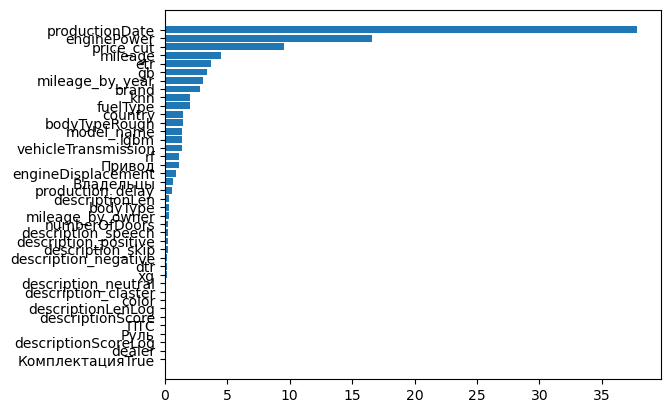

In [432]:
plt.rcdefaults()
fig, ax = plt.subplots()
ax.barh(a[0], a[1])
plt.show()

In [415]:
def cv_CB2(model, X, y):
    
    kf = KFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)
    # кросс-валидация на 3 выборках, так как на 5 время расчётов выше
    mape_train = []
    mape_valid = []
    for train_index, valid_index in tqdm_notebook(kf.split(X)):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]

        model.fit(X_train,y_train, verbose=50)
        
        #Введём предсказания на train для детекции переобучения        
        y_pred_train = model.predict(X_train)
        y_pred_valid = model.predict(X_valid)
        
        mape_train.append(mape_exp(y_train, y_pred_train))
        mape_valid.append(mape_exp(y_valid, y_pred_valid))
    
    mape_train = np.array(mape_train)
    mape_valid = np.array(mape_valid)
    # минимизируем абсолютную ошибку и разницу между валидационной и обучающей выборкой,
    # получим множество Паретто
    return np.mean(mape_valid), np.mean(np.abs(mape_valid - mape_train))

In [433]:
cv_CB2(CatBoostRegressor(random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['MAE'],
                          thread_count=-1,
                          task_type = "CPU",
                          silent=True
                         ), X_stack_2, y[not_outliers_mask].reset_index().drop("index", axis=1)["price"])

0it [00:00, ?it/s]

Learning rate set to 0.077734
0:	learn: 0.0588737	total: 9.44ms	remaining: 9.43s
50:	learn: 0.0344411	total: 402ms	remaining: 7.47s
100:	learn: 0.0338446	total: 775ms	remaining: 6.9s
150:	learn: 0.0333884	total: 1.15s	remaining: 6.48s
200:	learn: 0.0329153	total: 1.53s	remaining: 6.08s
250:	learn: 0.0325175	total: 1.91s	remaining: 5.7s
300:	learn: 0.0321845	total: 2.27s	remaining: 5.28s
350:	learn: 0.0318924	total: 2.65s	remaining: 4.89s
400:	learn: 0.0316206	total: 3.02s	remaining: 4.51s
450:	learn: 0.0313546	total: 3.39s	remaining: 4.13s
500:	learn: 0.0311280	total: 3.77s	remaining: 3.75s
550:	learn: 0.0309224	total: 4.13s	remaining: 3.36s
600:	learn: 0.0307331	total: 4.5s	remaining: 2.99s
650:	learn: 0.0305513	total: 4.87s	remaining: 2.61s
700:	learn: 0.0303892	total: 5.24s	remaining: 2.23s
750:	learn: 0.0302222	total: 5.6s	remaining: 1.86s
800:	learn: 0.0300530	total: 5.97s	remaining: 1.48s
850:	learn: 0.0298836	total: 6.35s	remaining: 1.11s
900:	learn: 0.0297330	total: 6.73s	remai

(0.5131558634238166, 0.06113274841367935)

Стекинг не дал результатов. Возможно, из-за использования сильных алгоритмов внутри(?)

# Submission

В качестве сабмита используем 3 решения от CatBoost, XGBoost, LightGBM

In [438]:
VERSION = 2

In [437]:
X_meta_cb_t

array([13.34725507, 13.67128684, 13.67254374, ..., 12.42068583,
       14.09098191, 13.84866476])

leaderboard = 14.11831

In [445]:
VERSION = 3

In [446]:
X_meta_xg_t

array([13.309042 , 13.62583  , 13.639973 , ..., 12.339837 , 14.1016035,
       13.879915 ], dtype=float32)

leaderboard = 14.58970

In [448]:
VERSION = 4

In [449]:
X_meta_lgbm_t

array([13.34051072, 13.72281492, 13.73515859, ..., 12.48615276,
       13.9770452 , 13.79731506])

leaderboard = 14.35190

In [451]:
VERSION = 5

In [453]:
X_meta_knn_t

array([13.70717599, 13.40258472, 13.67475284, ..., 13.3229309 ,
       14.11260136, 14.2843629 ])

In [ ]:
41.35308

In [454]:
VERSION = 6

In [455]:
X_meta_dtr_t

array([13.34651595, 13.74972363, 13.70520972, ..., 12.37976744,
       14.15674133, 13.86250256])

In [ ]:
18.91591

In [457]:
VERSION = 7

In [458]:
X_meta_etr_t

array([13.34285524, 13.54375845, 13.66732705, ..., 12.53117217,
       14.09079318, 13.78222791])

In [ ]:
17.48870

In [460]:
VERSION = 8

In [461]:
X_meta_rf_t

array([13.41768629, 13.70373725, 13.63563632, ..., 12.37140508,
       14.11371252, 13.83145666])

In [ ]:
15.80305

In [463]:
VERSION = 9

In [465]:
X_meta_gb_t

array([13.23790244, 13.64069   , 13.62147851, ..., 12.39960091,
       14.10991456, 13.77502791])

In [ ]:
15.04372

In [464]:
sample_submission['price'] = np.exp(X_meta_gb_t)
sample_submission.to_csv(f'submission_2_v{VERSION}.csv', index=False)
sample_submission.head(10)

sell_id         price
0  1100575026   561,239.180
1  1100549428   839,607.666
2  1100658222   823,631.506
3  1100937408   631,987.000
4  1101037972   675,008.415
5  1100912634   751,990.591
6  1101228730   603,016.365
7  1100165896   389,683.631
8  1100768262 2,016,728.164
9  1101218501   740,176.596

За лучшее решение взято решение, полученное CatBoost

Большая разница в ошибке может указывать на то что тест и трейн имеют различия по выборке или то что данные в трейне могли уже устареть и их нужно обновлять.

Подробный чек лист: https://docs.google.com/spreadsheets/d/1I_ErM3U0Cs7Rs1obyZbIEGtVn-H47pHNCi4xdDgUmXY/edit?usp=sharing